# Analysis of intervention_topk Results

This notebook analyzes how intervention_topk changes across different indices (0-31) from fs_shuffled_results and zs_results JSON files, comparing between reasoning/antonym and stock/antonym directories.

## Check and Create Missing Files

First, let's check if the no_rank_list files exist in the reasoning directory, and create them if they don't.

In [132]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def remove_rank_lists_from_data(data):
    """Recursively remove all rank_list fields from the data structure."""
    if isinstance(data, dict):
        return {k: remove_rank_lists_from_data(v) for k, v in data.items() 
                if not k.endswith('rank_list')}
    elif isinstance(data, list):
        return [remove_rank_lists_from_data(item) for item in data]
    else:
        return data

# Check and create missing no_rank_list files in reasoning directory
reasoning_base = Path("reasoning/antonym")
files_to_check = [
    ("fs_shuffled_results_layer_sweep_(1).json", "fs_shuffled_results_layer_sweep_(1)_no_rank_list.json"),
    ("zs_results_layer_sweep_(1).json", "zs_results_layer_sweep_(1)_no_rank_list.json")
]

print("Checking for missing no_rank_list files in reasoning directory...")

for original_file, no_rank_file in files_to_check:
    original_path = reasoning_base / original_file
    no_rank_path = reasoning_base / no_rank_file
    
    if original_path.exists() and not no_rank_path.exists():
        print(f"Creating {no_rank_file} from {original_file}...")
        
        # Load original file
        with open(original_path, 'r') as f:
            original_data = json.load(f)
        
        # Remove rank_lists
        cleaned_data = remove_rank_lists_from_data(original_data)
        
        # Save cleaned file
        with open(no_rank_path, 'w') as f:
            json.dump(cleaned_data, f, indent=2)
        
        original_size = os.path.getsize(original_path)
        new_size = os.path.getsize(no_rank_path)
        reduction = (original_size - new_size) / original_size * 100
        print(f"  Created! Size reduction: {original_size:,} → {new_size:,} bytes ({reduction:.1f}% smaller)")
    
    elif no_rank_path.exists():
        print(f"✓ {no_rank_file} already exists")
    else:
        print(f"✗ {original_file} not found in reasoning directory")

print("\nFile check complete!")

Checking for missing no_rank_list files in reasoning directory...
✓ fs_shuffled_results_layer_sweep_(1)_no_rank_list.json already exists
✓ zs_results_layer_sweep_(1)_no_rank_list.json already exists

File check complete!


## Import Required Libraries and Setup

Import necessary libraries and set up plotting style.

In [3]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load and Parse JSON Data

Load the JSON files containing fs_shuffled_results and zs_results data from both reasoning/antonym and stock/antonym directories.

In [4]:
# Define file paths for both directories
reasoning_path = Path("reasoning/antonym")
stock_path = Path("stock/antonym")

file_names = [
    "fs_shuffled_results_layer_sweep_(1)_no_rank_list.json",
    "zs_results_layer_sweep_(1)_no_rank_list.json"
]

# Load all JSON data
data_dict = {}

for directory, dir_name in [(reasoning_path, "reasoning"), (stock_path, "stock")]:
    data_dict[dir_name] = {}
    for file_name in file_names:
        file_path = directory / file_name
        dataset_name = file_name.replace("_layer_sweep_(1)_no_rank_list.json", "")
        
        print(f"Loading {dir_name}/{dataset_name} data...")
        try:
            with open(file_path, 'r') as f:
                data_dict[dir_name][dataset_name] = json.load(f)
            print(f"  Successfully loaded {len(data_dict[dir_name][dataset_name])} indices")
        except FileNotFoundError:
            print(f"  Warning: File not found - {file_path}")
            data_dict[dir_name][dataset_name] = {}

print("\nData loading summary:")
for dir_name in data_dict:
    for dataset_name in data_dict[dir_name]:
        count = len(data_dict[dir_name][dataset_name])
        print(f"  {dir_name}/{dataset_name}: {count} indices")

# Show structure of the first entry (if available)
if data_dict["stock"]["fs_shuffled_results"]:
    print("\nStructure of stock/fs_shuffled_results['0']:")
    print(list(data_dict["stock"]["fs_shuffled_results"]['0'].keys()))

Loading reasoning/fs_shuffled_results data...
  Successfully loaded 32 indices
Loading reasoning/zs_results data...
  Successfully loaded 32 indices
Loading stock/fs_shuffled_results data...
  Successfully loaded 32 indices
Loading stock/zs_results data...
  Successfully loaded 32 indices

Data loading summary:
  reasoning/fs_shuffled_results: 32 indices
  reasoning/zs_results: 32 indices
  stock/fs_shuffled_results: 32 indices
  stock/zs_results: 32 indices

Structure of stock/fs_shuffled_results['0']:
['clean_topk', 'intervention_topk']


## Data Preprocessing and Extraction

Extract intervention_topk values for indices 0-31 from all datasets and organize them into structured formats for analysis.

In [5]:
def extract_intervention_topk(data, max_index=32):
    """
    Extract intervention_topk values for indices 0 to max_index-1
    Returns a dictionary with index as key and list of [k, accuracy] pairs as values
    """
    extracted_data = {}
    
    for i in range(max_index):
        index_str = str(i)
        if index_str in data and 'intervention_topk' in data[index_str]:
            extracted_data[i] = data[index_str]['intervention_topk']
        else:
            extracted_data[i] = []
    
    return extracted_data

# Extract data for all four datasets
extracted_data = {}

for dir_name in data_dict:
    extracted_data[dir_name] = {}
    for dataset_name in data_dict[dir_name]:
        if data_dict[dir_name][dataset_name]:  # Only process if data exists
            extracted_data[dir_name][dataset_name] = extract_intervention_topk(data_dict[dir_name][dataset_name])
            print(f"Extracted {dir_name}/{dataset_name}: {len(extracted_data[dir_name][dataset_name])} indices")
        else:
            extracted_data[dir_name][dataset_name] = {}
            print(f"Skipped {dir_name}/{dataset_name}: No data available")

print("\nData extraction complete!")

# Show sample data structure if available
if extracted_data["stock"]["fs_shuffled_results"] and 0 in extracted_data["stock"]["fs_shuffled_results"]:
    print("\nSample intervention_topk for index 0 (stock/fs_shuffled_results):")
    print(extracted_data["stock"]["fs_shuffled_results"][0][:3])  # Show first 3 entries

Extracted reasoning/fs_shuffled_results: 32 indices
Extracted reasoning/zs_results: 32 indices
Extracted stock/fs_shuffled_results: 32 indices
Extracted stock/zs_results: 32 indices

Data extraction complete!

Sample intervention_topk for index 0 (stock/fs_shuffled_results):
[[1, 0.0], [2, 0.002824858757062147], [3, 0.002824858757062147]]


In [6]:
def create_dataframe_from_topk(intervention_data, dataset_name):
    """
    Convert intervention_topk data to a pandas DataFrame for easier analysis
    """
    rows = []
    
    for index, topk_list in intervention_data.items():
        for k, accuracy in topk_list:
            rows.append({
                'index': index,
                'k': k,
                'accuracy': accuracy,
                'dataset': dataset_name
            })
    
    return pd.DataFrame(rows)

# Create DataFrames for all datasets
all_dataframes = []

for dir_name in extracted_data:
    for dataset_name in extracted_data[dir_name]:
        if extracted_data[dir_name][dataset_name]:  # Only process if data exists
            full_name = f"{dir_name}_{dataset_name}"
            df = create_dataframe_from_topk(extracted_data[dir_name][dataset_name], full_name)
            all_dataframes.append(df)
            print(f"Created DataFrame for {full_name}: {df.shape}")

# Combine all datasets
if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nCombined DataFrame shape: {combined_df.shape}")
    
    # Show dataset breakdown
    print("\nDataset breakdown:")
    dataset_counts = combined_df['dataset'].value_counts()
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count} rows")
    
    # Show sample data
    print("\nSample data:")
    print(combined_df.head(10))
else:
    print("No data available to create DataFrames")
    combined_df = pd.DataFrame()

Created DataFrame for reasoning_fs_shuffled_results: (96, 4)
Created DataFrame for reasoning_zs_results: (96, 4)
Created DataFrame for stock_fs_shuffled_results: (96, 4)
Created DataFrame for stock_zs_results: (96, 4)

Combined DataFrame shape: (384, 4)

Dataset breakdown:
  reasoning_fs_shuffled_results: 96 rows
  reasoning_zs_results: 96 rows
  stock_fs_shuffled_results: 96 rows
  stock_zs_results: 96 rows

Sample data:
   index  k  accuracy                        dataset
0      0  1  0.003077  reasoning_fs_shuffled_results
1      0  2  0.003077  reasoning_fs_shuffled_results
2      0  3  0.006154  reasoning_fs_shuffled_results
3      1  1  0.000000  reasoning_fs_shuffled_results
4      1  2  0.000000  reasoning_fs_shuffled_results
5      1  3  0.006154  reasoning_fs_shuffled_results
6      2  1  0.015385  reasoning_fs_shuffled_results
7      2  2  0.018462  reasoning_fs_shuffled_results
8      2  3  0.024615  reasoning_fs_shuffled_results
9      3  1  0.113846  reasoning_fs_shuffled

## Plot intervention_topk for fs_shuffled_results

Create line plots showing how intervention_topk values change across indices 0-31 for fs_shuffled_results in both reasoning and stock directories.

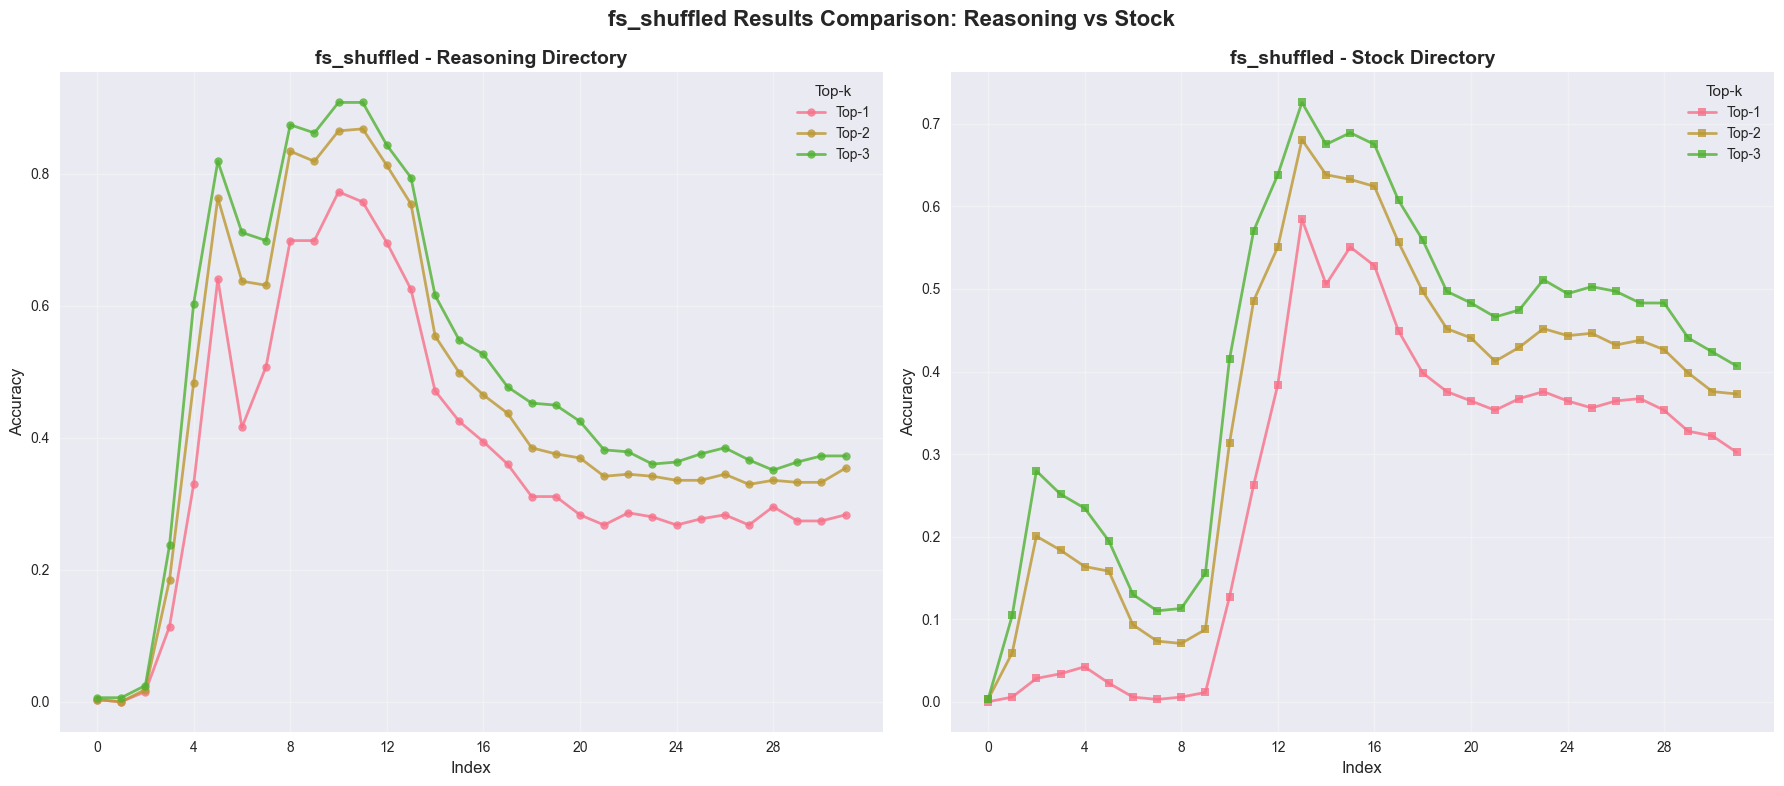


fs_shuffled Statistics:

Reasoning Directory:
  Top-1: Mean=0.3712, Std=0.2109, Max=0.7723
  Top-2: Mean=0.4525, Std=0.2440, Max=0.8677
  Top-3: Mean=0.4954, Std=0.2540, Max=0.9077

Stock Directory:
  Top-1: Mean=0.2669, Std=0.1906, Max=0.5847
  Top-2: Mean=0.3623, Std=0.1938, Max=0.6808
  Top-3: Mean=0.4155, Std=0.1985, Max=0.7260


In [7]:
# Filter data for fs_shuffled from both directories
fs_reasoning_data = combined_df[combined_df['dataset'] == 'reasoning_fs_shuffled_results']
fs_stock_data = combined_df[combined_df['dataset'] == 'stock_fs_shuffled_results']

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Reasoning fs_shuffled
if not fs_reasoning_data.empty:
    ax1 = axes[0]
    for k_val in sorted(fs_reasoning_data['k'].unique()):
        k_data = fs_reasoning_data[fs_reasoning_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('fs_shuffled - Reasoning Directory', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No reasoning/fs_shuffled data available', 
                ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('fs_shuffled - Reasoning Directory (No Data)')

# Plot 2: Stock fs_shuffled
if not fs_stock_data.empty:
    ax2 = axes[1]
    for k_val in sorted(fs_stock_data['k'].unique()):
        k_data = fs_stock_data[fs_stock_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('fs_shuffled - Stock Directory', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No stock/fs_shuffled data available', 
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('fs_shuffled - Stock Directory (No Data)')

plt.suptitle('fs_shuffled Results Comparison: Reasoning vs Stock', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics for both datasets
print("\nfs_shuffled Statistics:")
for dataset_name, data in [("reasoning", fs_reasoning_data), ("stock", fs_stock_data)]:
    if not data.empty:
        print(f"\n{dataset_name.capitalize()} Directory:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\n{dataset_name.capitalize()} Directory: No data available")

## Plot intervention_topk for zs_results

Create line plots showing how intervention_topk values change across indices 0-31 for zs_results in both reasoning and stock directories.

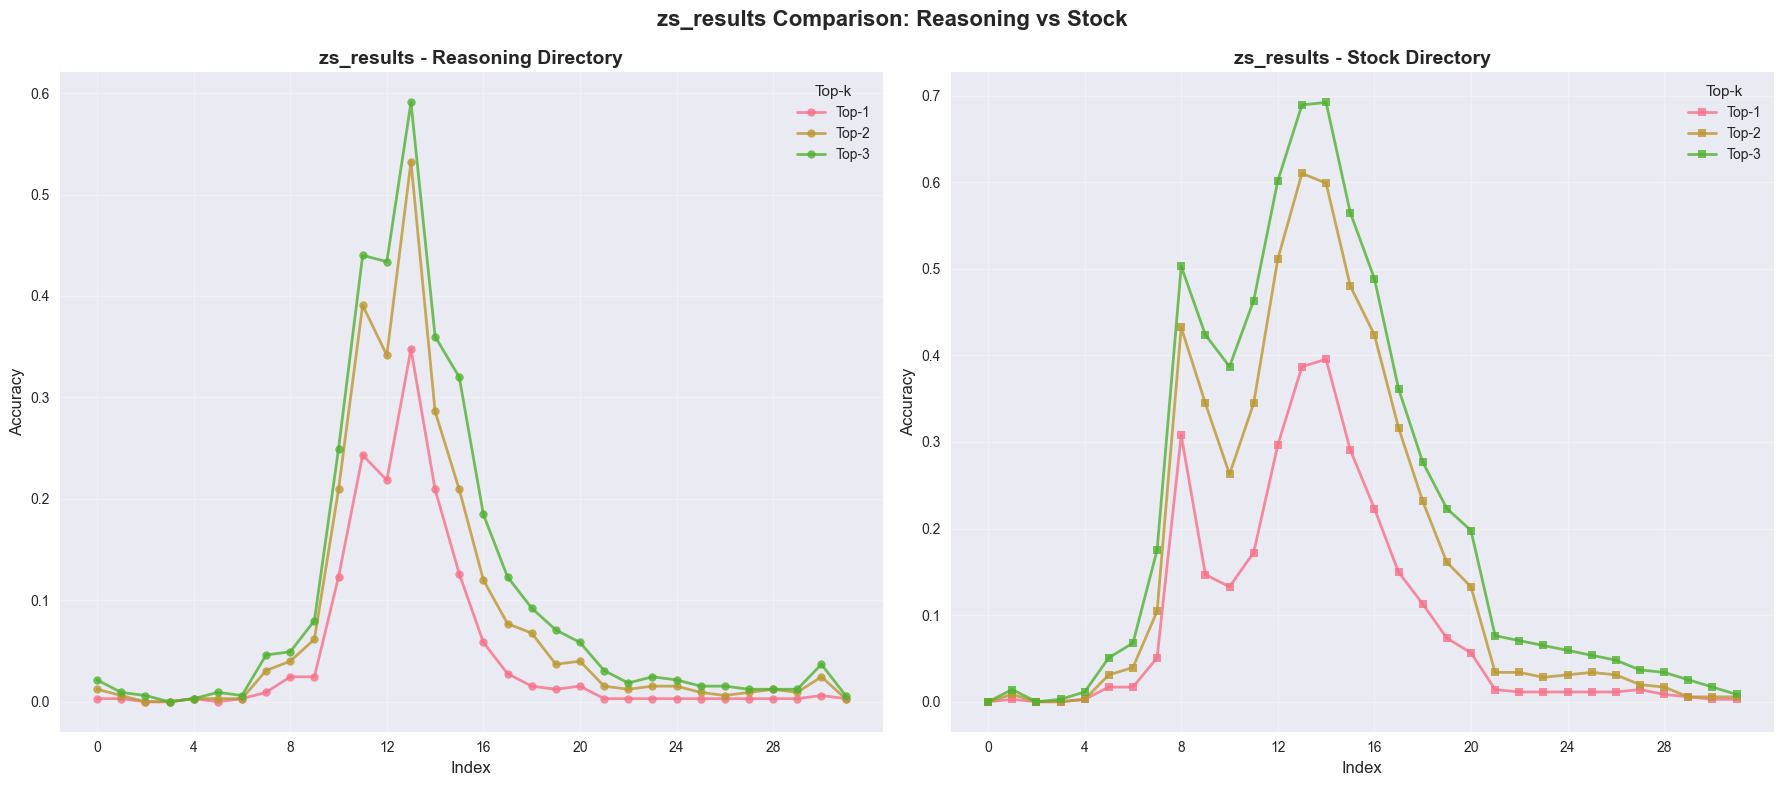


zs_results Statistics:

Reasoning Directory:
  Top-1: Mean=0.0470, Std=0.0876, Max=0.3477
  Top-2: Mean=0.0813, Std=0.1328, Max=0.5323
  Top-3: Mean=0.1050, Std=0.1560, Max=0.5908

Stock Directory:
  Top-1: Mean=0.0919, Std=0.1232, Max=0.3955
  Top-2: Mean=0.1651, Std=0.2001, Max=0.6102
  Top-3: Mean=0.2090, Std=0.2296, Max=0.6921


In [8]:
# Filter data for zs_results from both directories
zs_reasoning_data = combined_df[combined_df['dataset'] == 'reasoning_zs_results']
zs_stock_data = combined_df[combined_df['dataset'] == 'stock_zs_results']

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Reasoning zs_results
if not zs_reasoning_data.empty:
    ax1 = axes[0]
    for k_val in sorted(zs_reasoning_data['k'].unique()):
        k_data = zs_reasoning_data[zs_reasoning_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('zs_results - Reasoning Directory', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No reasoning/zs_results data available', 
                ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('zs_results - Reasoning Directory (No Data)')

# Plot 2: Stock zs_results
if not zs_stock_data.empty:
    ax2 = axes[1]
    for k_val in sorted(zs_stock_data['k'].unique()):
        k_data = zs_stock_data[zs_stock_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('zs_results - Stock Directory', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No stock/zs_results data available', 
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('zs_results - Stock Directory (No Data)')

plt.suptitle('zs_results Comparison: Reasoning vs Stock', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics for both datasets
print("\nzs_results Statistics:")
for dataset_name, data in [("reasoning", zs_reasoning_data), ("stock", zs_stock_data)]:
    if not data.empty:
        print(f"\n{dataset_name.capitalize()} Directory:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\n{dataset_name.capitalize()} Directory: No data available")

## Comprehensive Comparison Across All Datasets

Create a comprehensive comparison showing all four datasets with direct comparisons, difference plots, and summary statistics.

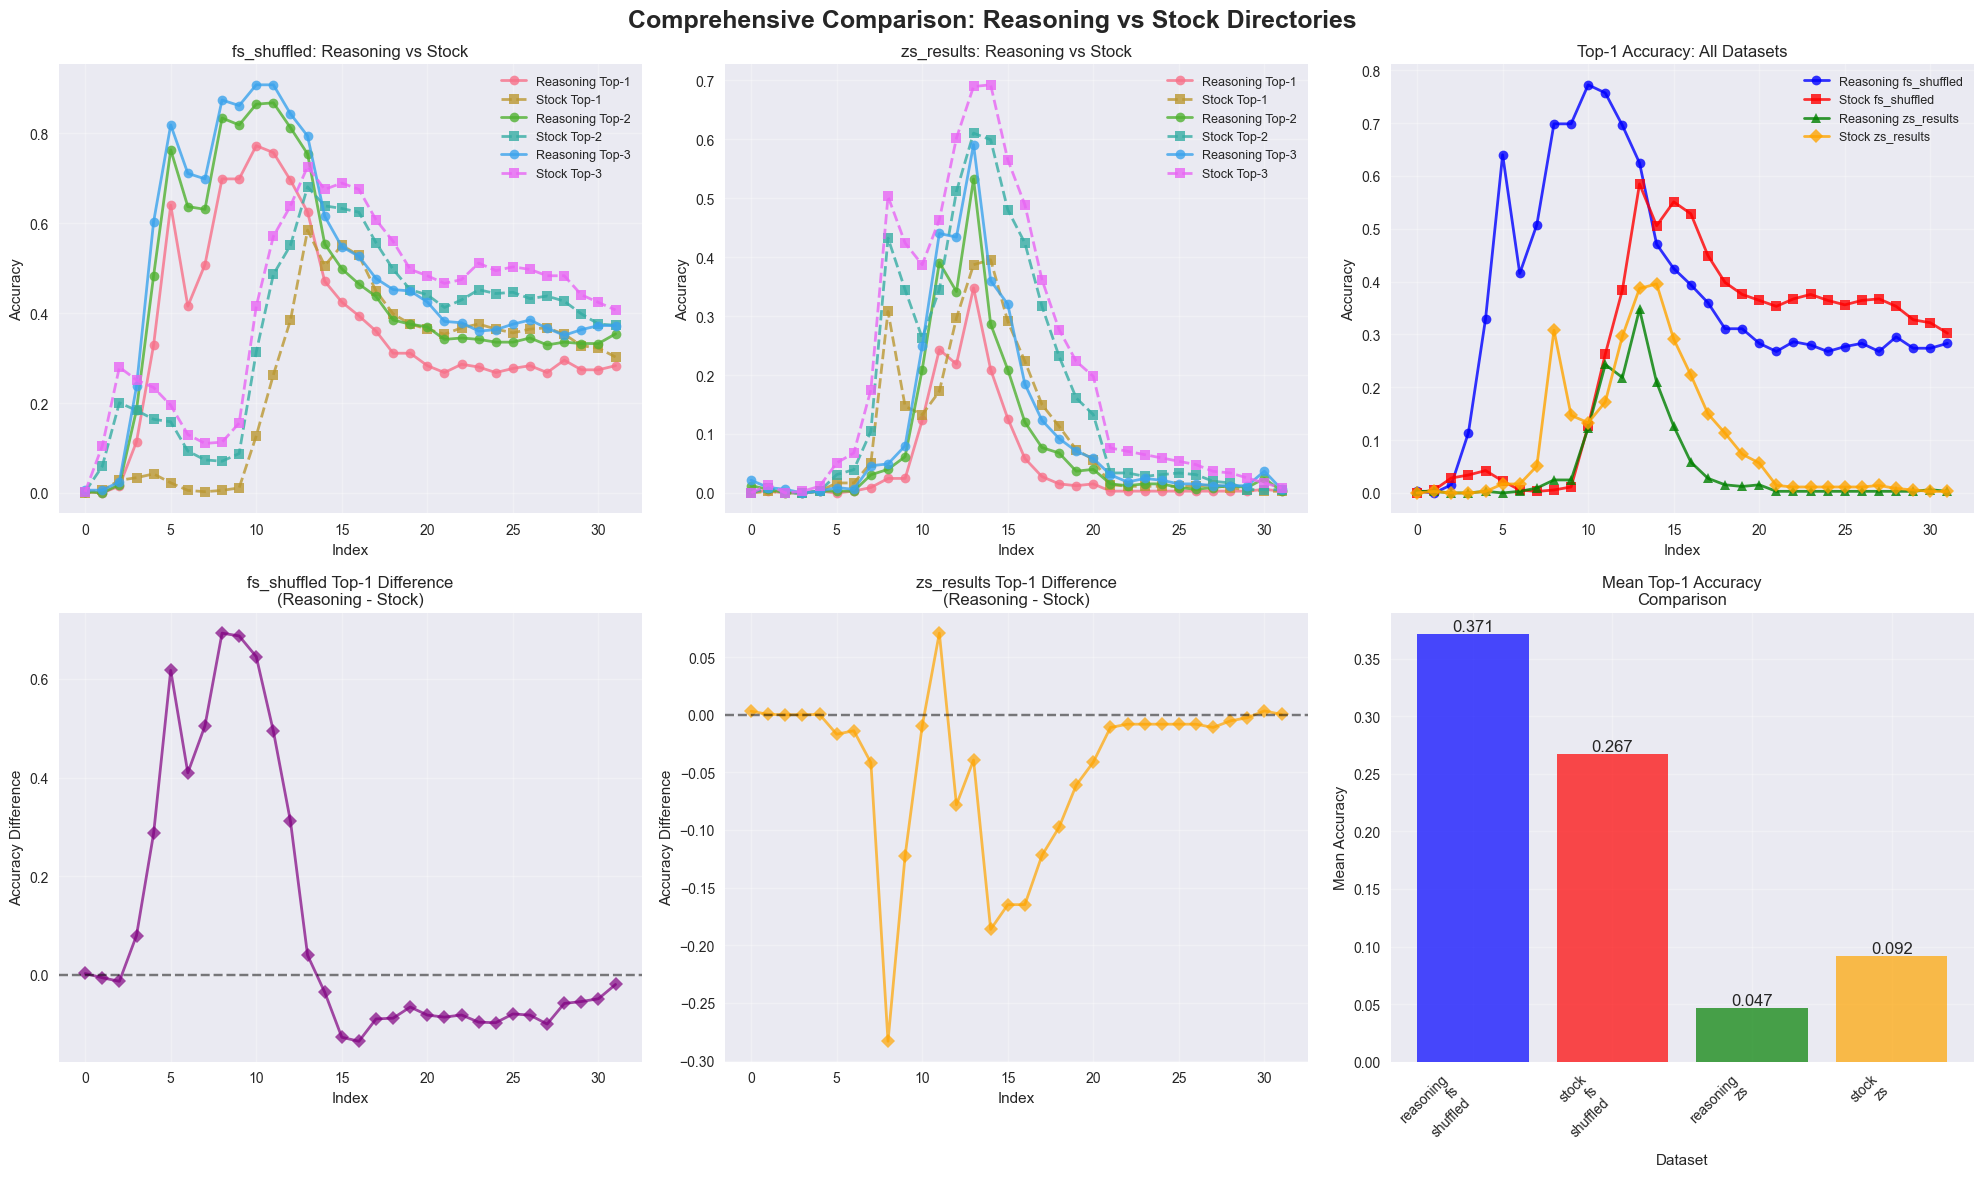


Comprehensive Statistics Summary (Top-1 Accuracy):

reasoning_fs_shuffled:
  Mean: 0.3712
  Std:  0.2109
  Max:  0.7723
  Min:  0.0000

stock_fs_shuffled:
  Mean: 0.2669
  Std:  0.1906
  Max:  0.5847
  Min:  0.0000

reasoning_zs:
  Mean: 0.0470
  Std:  0.0876
  Max:  0.3477
  Min:  0.0000

stock_zs:
  Mean: 0.0919
  Std:  0.1232
  Max:  0.3955
  Min:  0.0000


In [9]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Comparison: Reasoning vs Stock Directories', fontsize=18, fontweight='bold')

# Define datasets
datasets = {
    'reasoning_fs_shuffled': fs_reasoning_data,
    'stock_fs_shuffled': fs_stock_data,
    'reasoning_zs': zs_reasoning_data,
    'stock_zs': zs_stock_data
}

# Plot 1: fs_shuffled reasoning vs stock direct comparison
ax1 = axes[0, 0]
if not datasets['reasoning_fs_shuffled'].empty and not datasets['stock_fs_shuffled'].empty:
    for k_val in [1, 2, 3]:  # Top-1, Top-2, Top-3
        reasoning_k = datasets['reasoning_fs_shuffled'][datasets['reasoning_fs_shuffled']['k'] == k_val]
        stock_k = datasets['stock_fs_shuffled'][datasets['stock_fs_shuffled']['k'] == k_val]
        
        if not reasoning_k.empty:
            ax1.plot(reasoning_k['index'], reasoning_k['accuracy'], 
                     marker='o', linewidth=2, label=f'Reasoning Top-{k_val}', alpha=0.8)
        if not stock_k.empty:
            ax1.plot(stock_k['index'], stock_k['accuracy'], 
                     marker='s', linewidth=2, linestyle='--', label=f'Stock Top-{k_val}', alpha=0.8)
ax1.set_title('fs_shuffled: Reasoning vs Stock')
ax1.set_xlabel('Index')
ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: zs_results reasoning vs stock direct comparison
ax2 = axes[0, 1]
if not datasets['reasoning_zs'].empty and not datasets['stock_zs'].empty:
    for k_val in [1, 2, 3]:
        reasoning_k = datasets['reasoning_zs'][datasets['reasoning_zs']['k'] == k_val]
        stock_k = datasets['stock_zs'][datasets['stock_zs']['k'] == k_val]
        
        if not reasoning_k.empty:
            ax2.plot(reasoning_k['index'], reasoning_k['accuracy'], 
                     marker='o', linewidth=2, label=f'Reasoning Top-{k_val}', alpha=0.8)
        if not stock_k.empty:
            ax2.plot(stock_k['index'], stock_k['accuracy'], 
                     marker='s', linewidth=2, linestyle='--', label=f'Stock Top-{k_val}', alpha=0.8)
ax2.set_title('zs_results: Reasoning vs Stock')
ax2.set_xlabel('Index')
ax2.set_ylabel('Accuracy')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Top-1 comparison across all datasets
ax3 = axes[0, 2]
colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']
labels = ['Reasoning fs_shuffled', 'Stock fs_shuffled', 'Reasoning zs_results', 'Stock zs_results']

for i, (dataset_name, dataset) in enumerate(datasets.items()):
    if not dataset.empty:
        top1_data = dataset[dataset['k'] == 1]
        if not top1_data.empty:
            ax3.plot(top1_data['index'], top1_data['accuracy'], 
                     marker=markers[i], linewidth=2, color=colors[i],
                     label=labels[i], alpha=0.8)

ax3.set_title('Top-1 Accuracy: All Datasets')
ax3.set_xlabel('Index')
ax3.set_ylabel('Accuracy')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Difference plots for fs_shuffled (reasoning - stock)
ax4 = axes[1, 0]
if not datasets['reasoning_fs_shuffled'].empty and not datasets['stock_fs_shuffled'].empty:
    reasoning_top1 = datasets['reasoning_fs_shuffled'][datasets['reasoning_fs_shuffled']['k'] == 1]
    stock_top1 = datasets['stock_fs_shuffled'][datasets['stock_fs_shuffled']['k'] == 1]
    
    # Calculate differences
    common_indices = set(reasoning_top1['index']).intersection(set(stock_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_top1[reasoning_top1['index'] == idx]['accuracy'].iloc[0]
        stock_acc = stock_top1[stock_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(reasoning_acc - stock_acc)
        indices_list.append(idx)
    
    ax4.plot(indices_list, differences, marker='D', linewidth=2, 
             color='purple', alpha=0.7, label='Reasoning - Stock')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('fs_shuffled Top-1 Difference\n(Reasoning - Stock)')
    ax4.set_xlabel('Index')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)

# Plot 5: Difference plots for zs_results (reasoning - stock)
ax5 = axes[1, 1]
if not datasets['reasoning_zs'].empty and not datasets['stock_zs'].empty:
    reasoning_top1 = datasets['reasoning_zs'][datasets['reasoning_zs']['k'] == 1]
    stock_top1 = datasets['stock_zs'][datasets['stock_zs']['k'] == 1]
    
    # Calculate differences
    common_indices = set(reasoning_top1['index']).intersection(set(stock_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_top1[reasoning_top1['index'] == idx]['accuracy'].iloc[0]
        stock_acc = stock_top1[stock_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(reasoning_acc - stock_acc)
        indices_list.append(idx)
    
    ax5.plot(indices_list, differences, marker='D', linewidth=2, 
             color='orange', alpha=0.7, label='Reasoning - Stock')
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('zs_results Top-1 Difference\n(Reasoning - Stock)')
    ax5.set_xlabel('Index')
    ax5.set_ylabel('Accuracy Difference')
    ax5.grid(True, alpha=0.3)

# Plot 6: Summary statistics comparison
ax6 = axes[1, 2]
means = []
dataset_labels = []

for dataset_name, dataset in datasets.items():
    if not dataset.empty:
        top1_data = dataset[dataset['k'] == 1]
        if not top1_data.empty:
            means.append(top1_data['accuracy'].mean())
            dataset_labels.append(dataset_name.replace('_', '\n'))

if means:
    bars = ax6.bar(range(len(means)), means, alpha=0.7, 
                   color=['blue', 'red', 'green', 'orange'][:len(means)])
    ax6.set_title('Mean Top-1 Accuracy\nComparison')
    ax6.set_xlabel('Dataset')
    ax6.set_ylabel('Mean Accuracy')
    ax6.set_xticks(range(len(dataset_labels)))
    ax6.set_xticklabels(dataset_labels, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Comprehensive statistics summary
print("\nComprehensive Statistics Summary (Top-1 Accuracy):")
for dataset_name, dataset in datasets.items():
    if not dataset.empty:
        top1_data = dataset[dataset['k'] == 1]
        if not top1_data.empty:
            print(f"\n{dataset_name}:")
            print(f"  Mean: {top1_data['accuracy'].mean():.4f}")
            print(f"  Std:  {top1_data['accuracy'].std():.4f}")
            print(f"  Max:  {top1_data['accuracy'].max():.4f}")
            print(f"  Min:  {top1_data['accuracy'].min():.4f}")
    else:
        print(f"\n{dataset_name}: No data available")

## Heatmap Visualizations

Create comprehensive heatmaps showing accuracy patterns across all k values and indices for all datasets, plus difference heatmaps.

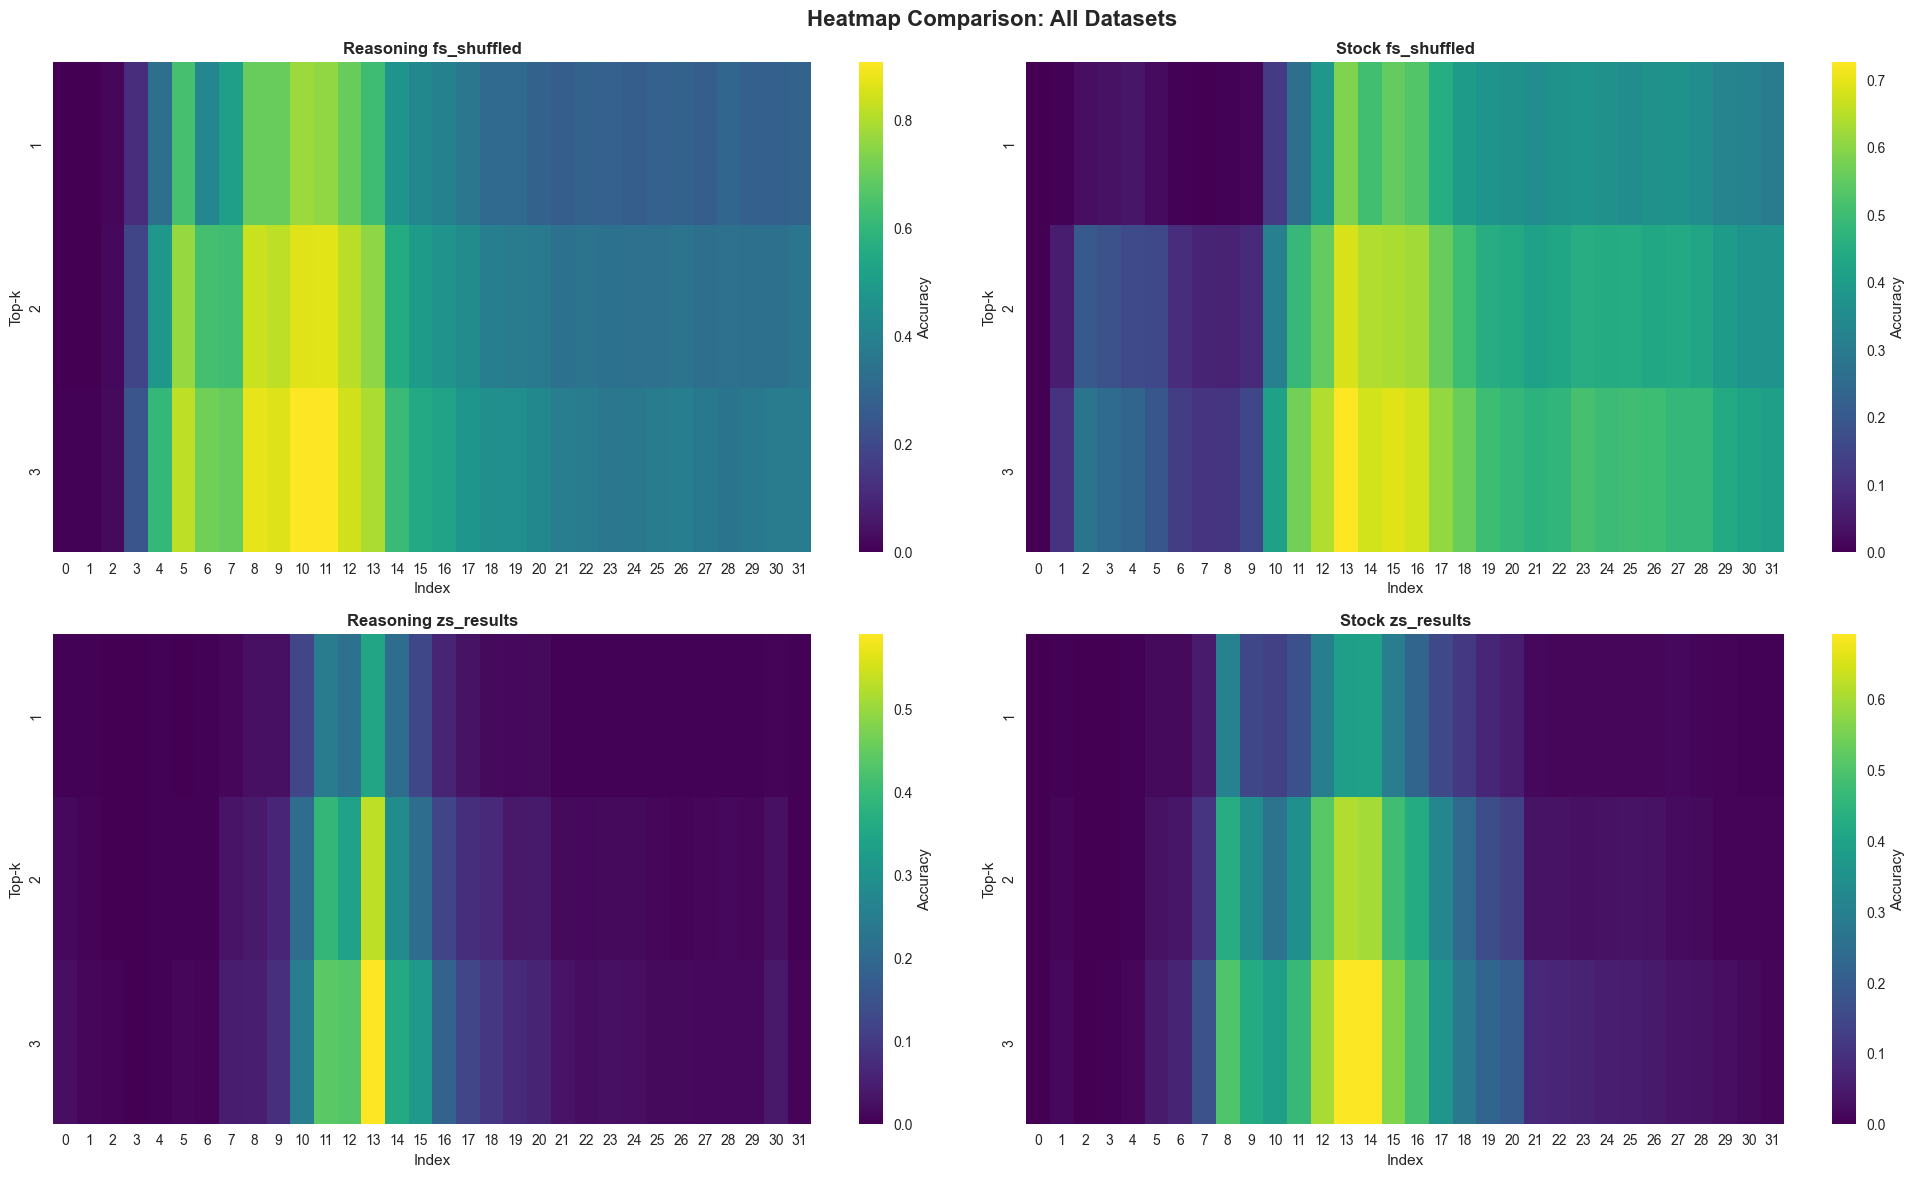

In [10]:
# Create comprehensive heatmaps for all datasets
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Heatmap Comparison: All Datasets', fontsize=16, fontweight='bold')

# Prepare data for heatmaps
def create_heatmap_data(data):
    if data.empty:
        return pd.DataFrame()
    pivot_data = data.pivot(index='k', columns='index', values='accuracy')
    return pivot_data

# Define the datasets and their positions
heatmap_config = [
    (datasets['reasoning_fs_shuffled'], 'Reasoning fs_shuffled', (0, 0)),
    (datasets['stock_fs_shuffled'], 'Stock fs_shuffled', (0, 1)),
    (datasets['reasoning_zs'], 'Reasoning zs_results', (1, 0)),
    (datasets['stock_zs'], 'Stock zs_results', (1, 1))
]

# Create heatmaps
for data, title, (row, col) in heatmap_config:
    ax = axes[row, col]
    
    if not data.empty:
        heatmap_data = create_heatmap_data(data)
        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, ax=ax, cmap='viridis', 
                       cbar_kws={'label': 'Accuracy'}, 
                       annot=False, fmt='.3f')
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', 
                   transform=ax.transAxes)
            ax.set_title(f'{title} (No Data)')
    else:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
               transform=ax.transAxes)
        ax.set_title(f'{title} (No Data)')

plt.tight_layout()
plt.show()

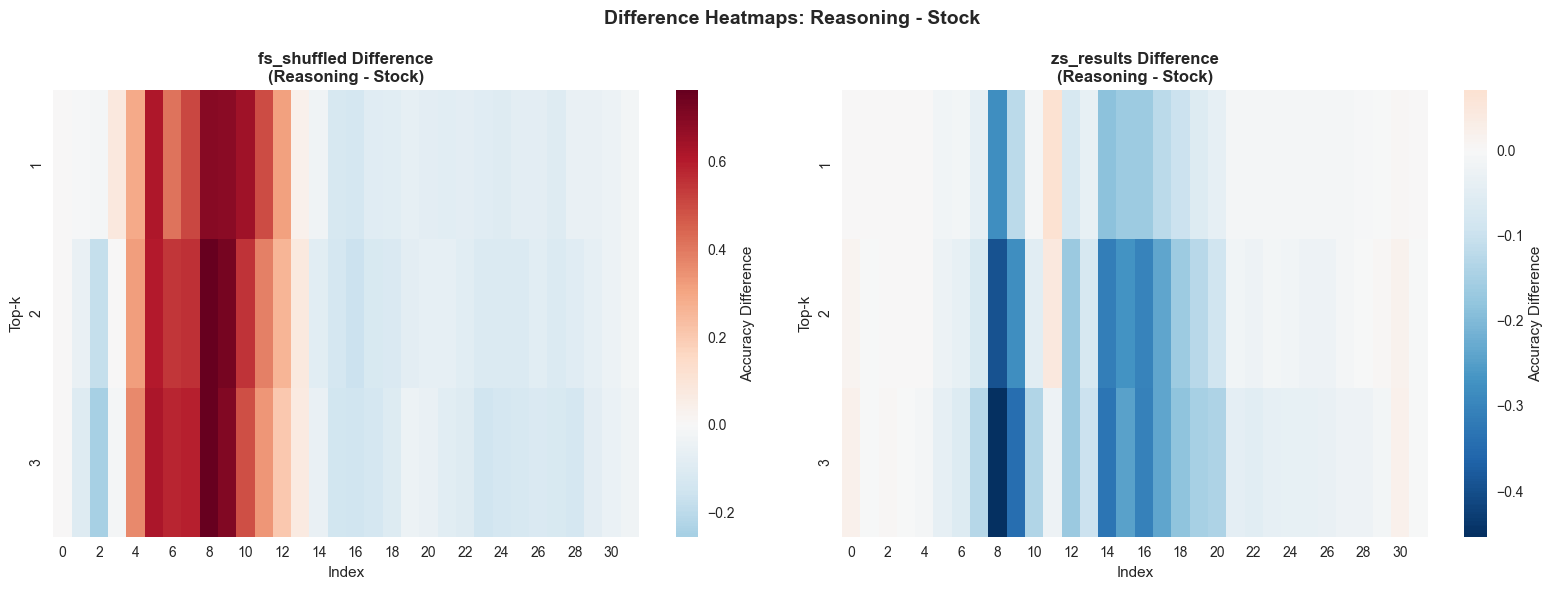

In [11]:
# Additional analysis: Create difference heatmaps
if not datasets['reasoning_fs_shuffled'].empty and not datasets['stock_fs_shuffled'].empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # fs_shuffled difference heatmap
    reasoning_hm = create_heatmap_data(datasets['reasoning_fs_shuffled'])
    stock_hm = create_heatmap_data(datasets['stock_fs_shuffled'])
    
    if not reasoning_hm.empty and not stock_hm.empty:
        # Align indices and k values
        common_indices = reasoning_hm.columns.intersection(stock_hm.columns)
        common_k = reasoning_hm.index.intersection(stock_hm.index)
        
        if len(common_indices) > 0 and len(common_k) > 0:
            diff_hm_fs = reasoning_hm.loc[common_k, common_indices] - stock_hm.loc[common_k, common_indices]
            
            sns.heatmap(diff_hm_fs, ax=axes[0], cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Accuracy Difference'})
            axes[0].set_title('fs_shuffled Difference\n(Reasoning - Stock)', fontweight='bold')
            axes[0].set_xlabel('Index')
            axes[0].set_ylabel('Top-k')
    
    # zs_results difference heatmap
    if not datasets['reasoning_zs'].empty and not datasets['stock_zs'].empty:
        reasoning_hm_zs = create_heatmap_data(datasets['reasoning_zs'])
        stock_hm_zs = create_heatmap_data(datasets['stock_zs'])
        
        if not reasoning_hm_zs.empty and not stock_hm_zs.empty:
            common_indices_zs = reasoning_hm_zs.columns.intersection(stock_hm_zs.columns)
            common_k_zs = reasoning_hm_zs.index.intersection(stock_hm_zs.index)
            
            if len(common_indices_zs) > 0 and len(common_k_zs) > 0:
                diff_hm_zs = reasoning_hm_zs.loc[common_k_zs, common_indices_zs] - stock_hm_zs.loc[common_k_zs, common_indices_zs]
                
                sns.heatmap(diff_hm_zs, ax=axes[1], cmap='RdBu_r', center=0,
                           cbar_kws={'label': 'Accuracy Difference'})
                axes[1].set_title('zs_results Difference\n(Reasoning - Stock)', fontweight='bold')
                axes[1].set_xlabel('Index')
                axes[1].set_ylabel('Top-k')
    
    plt.suptitle('Difference Heatmaps: Reasoning - Stock', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create difference heatmaps - missing data for comparison")

## Reasoning vs Reasoning-CoT Comparison

Now let's compare the results between the reasoning and reasoning-CoT directories to understand the impact of Chain-of-Thought prompting on the antonym task.

In [87]:
# Load reasoning-CoT data
reasoning_cot_path = Path("reasoning-CoT/antonym")

# Check and create missing no_rank_list files for reasoning-CoT if needed
print("Checking reasoning-CoT directory for required files...")

file_names = [
    "fs_shuffled_results_layer_sweep_no_rank_list.json",
    "zs_results_layer_sweep_no_rank_list.json"
]

reasoning_cot_data = {}
for file_name in file_names:
    file_path = reasoning_cot_path / file_name
    dataset_name = file_name.replace("_layer_sweep_no_rank_list.json", "")
    
    # Check if the _no_rank_list version exists, if not try to create it
    if not file_path.exists():
        # Try to find the original file and create the no_rank_list version
        original_file_name = file_name.replace("_no_rank_list", "")
        original_file_path = reasoning_cot_path / original_file_name
        
        if original_file_path.exists():
            print(f"Creating {file_name} from {original_file_name}...")
            with open(original_file_path, 'r') as f:
                original_data = json.load(f)
            cleaned_data = remove_rank_lists_from_data(original_data)
            with open(file_path, 'w') as f:
                json.dump(cleaned_data, f, indent=2)
            print(f"  Created successfully!")
    
    # Load the data
    print(f"Loading reasoning-CoT/{dataset_name} data...")
    try:
        with open(file_path, 'r') as f:
            reasoning_cot_data[dataset_name] = json.load(f)
        print(f"  Successfully loaded {len(reasoning_cot_data[dataset_name])} indices")
    except FileNotFoundError:
        print(f"  Warning: File not found - {file_path}")
        reasoning_cot_data[dataset_name] = {}

# Extract intervention_topk data for reasoning-CoT
reasoning_cot_extracted = {}
for dataset_name in reasoning_cot_data:
    if reasoning_cot_data[dataset_name]:
        reasoning_cot_extracted[dataset_name] = extract_intervention_topk(reasoning_cot_data[dataset_name])
        print(f"Extracted reasoning-CoT/{dataset_name}: {len(reasoning_cot_extracted[dataset_name])} indices")
    else:
        reasoning_cot_extracted[dataset_name] = {}
        print(f"Skipped reasoning-CoT/{dataset_name}: No data available")

# Create DataFrames for reasoning-CoT data
reasoning_cot_dataframes = []
for dataset_name in reasoning_cot_extracted:
    if reasoning_cot_extracted[dataset_name]:
        full_name = f"reasoning_cot_{dataset_name}"
        df = create_dataframe_from_topk(reasoning_cot_extracted[dataset_name], full_name)
        reasoning_cot_dataframes.append(df)
        print(f"Created DataFrame for {full_name}: {df.shape}")

# Combine reasoning-CoT data with existing data
if reasoning_cot_dataframes:
    reasoning_cot_combined = pd.concat(reasoning_cot_dataframes, ignore_index=True)
    
    # Add to the main combined dataframe
    extended_combined_df = pd.concat([combined_df, reasoning_cot_combined], ignore_index=True)
    print(f"\\nExtended DataFrame shape (including reasoning-CoT): {extended_combined_df.shape}")
    
    # Show new dataset breakdown
    print("\\nDataset breakdown (including reasoning-CoT):")
    dataset_counts = extended_combined_df['dataset'].value_counts()
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count} rows")
else:
    print("No reasoning-CoT data available")
    extended_combined_df = combined_df

Checking reasoning-CoT directory for required files...
Loading reasoning-CoT/fs_shuffled_results data...
  Successfully loaded 32 indices
Loading reasoning-CoT/zs_results data...
  Successfully loaded 32 indices
Extracted reasoning-CoT/fs_shuffled_results: 32 indices
Extracted reasoning-CoT/zs_results: 32 indices
Created DataFrame for reasoning_cot_fs_shuffled_results: (96, 4)
Created DataFrame for reasoning_cot_zs_results: (96, 4)
\nExtended DataFrame shape (including reasoning-CoT): (576, 4)
\nDataset breakdown (including reasoning-CoT):
  reasoning_fs_shuffled_results: 96 rows
  reasoning_zs_results: 96 rows
  stock_fs_shuffled_results: 96 rows
  stock_zs_results: 96 rows
  reasoning_cot_fs_shuffled_results: 96 rows
  reasoning_cot_zs_results: 96 rows


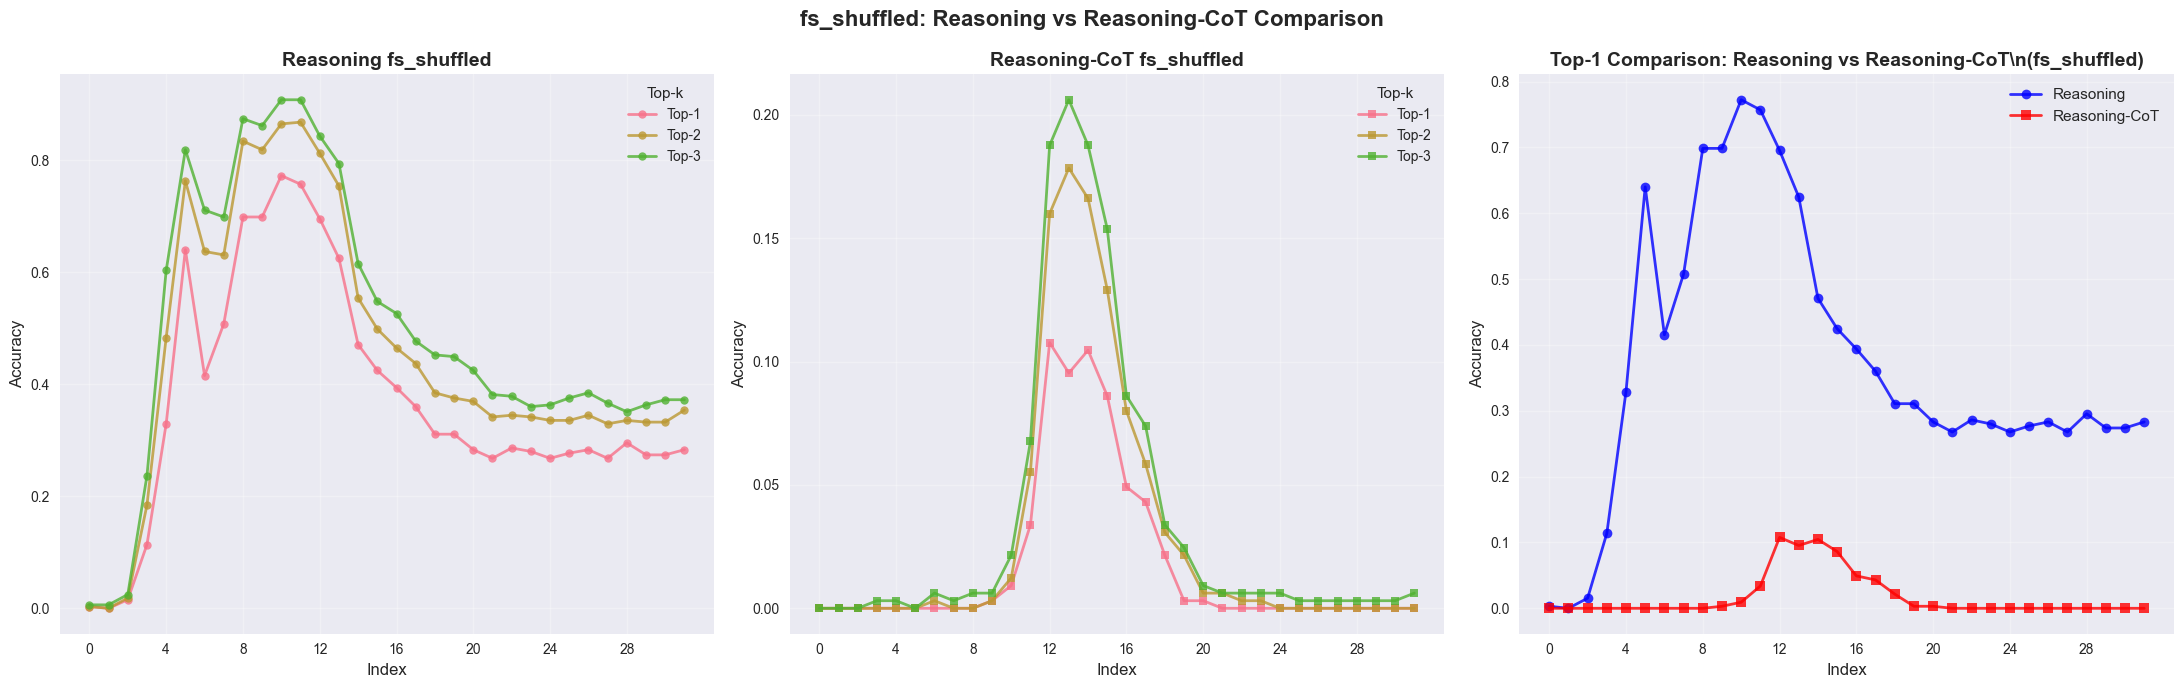

\nfs_shuffled Statistics Comparison:
\nReasoning:
  Top-1: Mean=0.3712, Std=0.2109, Max=0.7723
  Top-2: Mean=0.4525, Std=0.2440, Max=0.8677
  Top-3: Mean=0.4954, Std=0.2540, Max=0.9077
\nReasoning-CoT:
  Top-1: Mean=0.0175, Std=0.0337, Max=0.1077
  Top-2: Mean=0.0287, Std=0.0539, Max=0.1785
  Top-3: Mean=0.0353, Std=0.0614, Max=0.2062


In [88]:
# Compare reasoning vs reasoning-CoT for fs_shuffled
reasoning_fs_data = extended_combined_df[extended_combined_df['dataset'] == 'reasoning_fs_shuffled_results']
reasoning_cot_fs_data = extended_combined_df[extended_combined_df['dataset'] == 'reasoning_cot_fs_shuffled_results']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Plot 1: Reasoning fs_shuffled
if not reasoning_fs_data.empty:
    ax1 = axes[0]
    for k_val in sorted(reasoning_fs_data['k'].unique()):
        k_data = reasoning_fs_data[reasoning_fs_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('Reasoning fs_shuffled', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No reasoning fs_shuffled data', ha='center', va='center', transform=axes[0].transAxes)

# Plot 2: Reasoning-CoT fs_shuffled
if not reasoning_cot_fs_data.empty:
    ax2 = axes[1]
    for k_val in sorted(reasoning_cot_fs_data['k'].unique()):
        k_data = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('Reasoning-CoT fs_shuffled', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No reasoning-CoT fs_shuffled data', ha='center', va='center', transform=axes[1].transAxes)

# Plot 3: Direct comparison of Top-1 accuracy
ax3 = axes[2]
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_top1 = reasoning_fs_data[reasoning_fs_data['k'] == 1]
    reasoning_cot_top1 = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == 1]
    
    if not reasoning_top1.empty:
        ax3.plot(reasoning_top1['index'], reasoning_top1['accuracy'], 
                 marker='o', linewidth=2, label='Reasoning', alpha=0.8, color='blue')
    if not reasoning_cot_top1.empty:
        ax3.plot(reasoning_cot_top1['index'], reasoning_cot_top1['accuracy'], 
                 marker='s', linewidth=2, label='Reasoning-CoT', alpha=0.8, color='red')
    
    ax3.set_title('Top-1 Comparison: Reasoning vs Reasoning-CoT\\n(fs_shuffled)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Index', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 32, 4))
else:
    ax3.text(0.5, 0.5, 'Cannot compare - missing data', ha='center', va='center', transform=ax3.transAxes)

plt.suptitle('fs_shuffled: Reasoning vs Reasoning-CoT Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics comparison
print("\\nfs_shuffled Statistics Comparison:")
for dataset_name, data in [("Reasoning", reasoning_fs_data), ("Reasoning-CoT", reasoning_cot_fs_data)]:
    if not data.empty:
        print(f"\\n{dataset_name}:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\\n{dataset_name}: No data available")

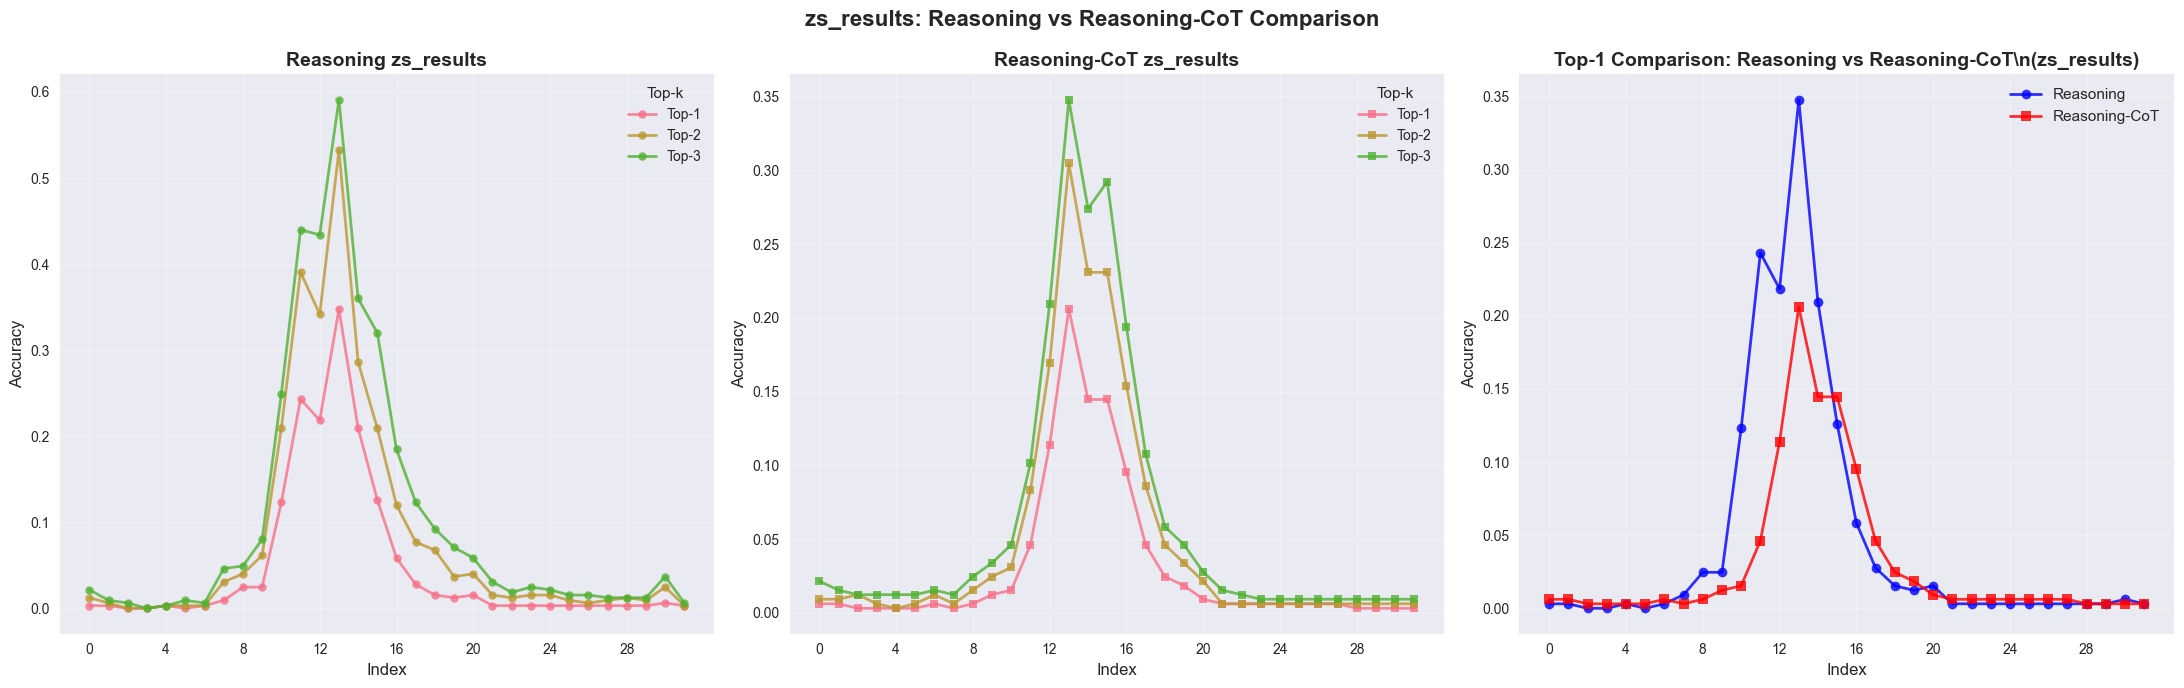

\nzs_results Statistics Comparison:
\nReasoning:
  Top-1: Mean=0.0470, Std=0.0876, Max=0.3477
  Top-2: Mean=0.0813, Std=0.1328, Max=0.5323
  Top-3: Mean=0.1050, Std=0.1560, Max=0.5908
\nReasoning-CoT:
  Top-1: Mean=0.0304, Std=0.0518, Max=0.2062
  Top-2: Mean=0.0488, Std=0.0795, Max=0.3046
  Top-3: Mean=0.0621, Std=0.0940, Max=0.3477


In [89]:
# Compare reasoning vs reasoning-CoT for zs_results
reasoning_zs_data = extended_combined_df[extended_combined_df['dataset'] == 'reasoning_zs_results']
reasoning_cot_zs_data = extended_combined_df[extended_combined_df['dataset'] == 'reasoning_cot_zs_results']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Plot 1: Reasoning zs_results
if not reasoning_zs_data.empty:
    ax1 = axes[0]
    for k_val in sorted(reasoning_zs_data['k'].unique()):
        k_data = reasoning_zs_data[reasoning_zs_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('Reasoning zs_results', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No reasoning zs_results data', ha='center', va='center', transform=axes[0].transAxes)

# Plot 2: Reasoning-CoT zs_results
if not reasoning_cot_zs_data.empty:
    ax2 = axes[1]
    for k_val in sorted(reasoning_cot_zs_data['k'].unique()):
        k_data = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('Reasoning-CoT zs_results', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No reasoning-CoT zs_results data', ha='center', va='center', transform=axes[1].transAxes)

# Plot 3: Direct comparison of Top-1 accuracy
ax3 = axes[2]
if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_top1 = reasoning_zs_data[reasoning_zs_data['k'] == 1]
    reasoning_cot_top1 = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == 1]
    
    if not reasoning_top1.empty:
        ax3.plot(reasoning_top1['index'], reasoning_top1['accuracy'], 
                 marker='o', linewidth=2, label='Reasoning', alpha=0.8, color='blue')
    if not reasoning_cot_top1.empty:
        ax3.plot(reasoning_cot_top1['index'], reasoning_cot_top1['accuracy'], 
                 marker='s', linewidth=2, label='Reasoning-CoT', alpha=0.8, color='red')
    
    ax3.set_title('Top-1 Comparison: Reasoning vs Reasoning-CoT\\n(zs_results)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Index', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 32, 4))
else:
    ax3.text(0.5, 0.5, 'Cannot compare - missing data', ha='center', va='center', transform=ax3.transAxes)

plt.suptitle('zs_results: Reasoning vs Reasoning-CoT Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics comparison
print("\\nzs_results Statistics Comparison:")
for dataset_name, data in [("Reasoning", reasoning_zs_data), ("Reasoning-CoT", reasoning_cot_zs_data)]:
    if not data.empty:
        print(f"\\n{dataset_name}:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\\n{dataset_name}: No data available")

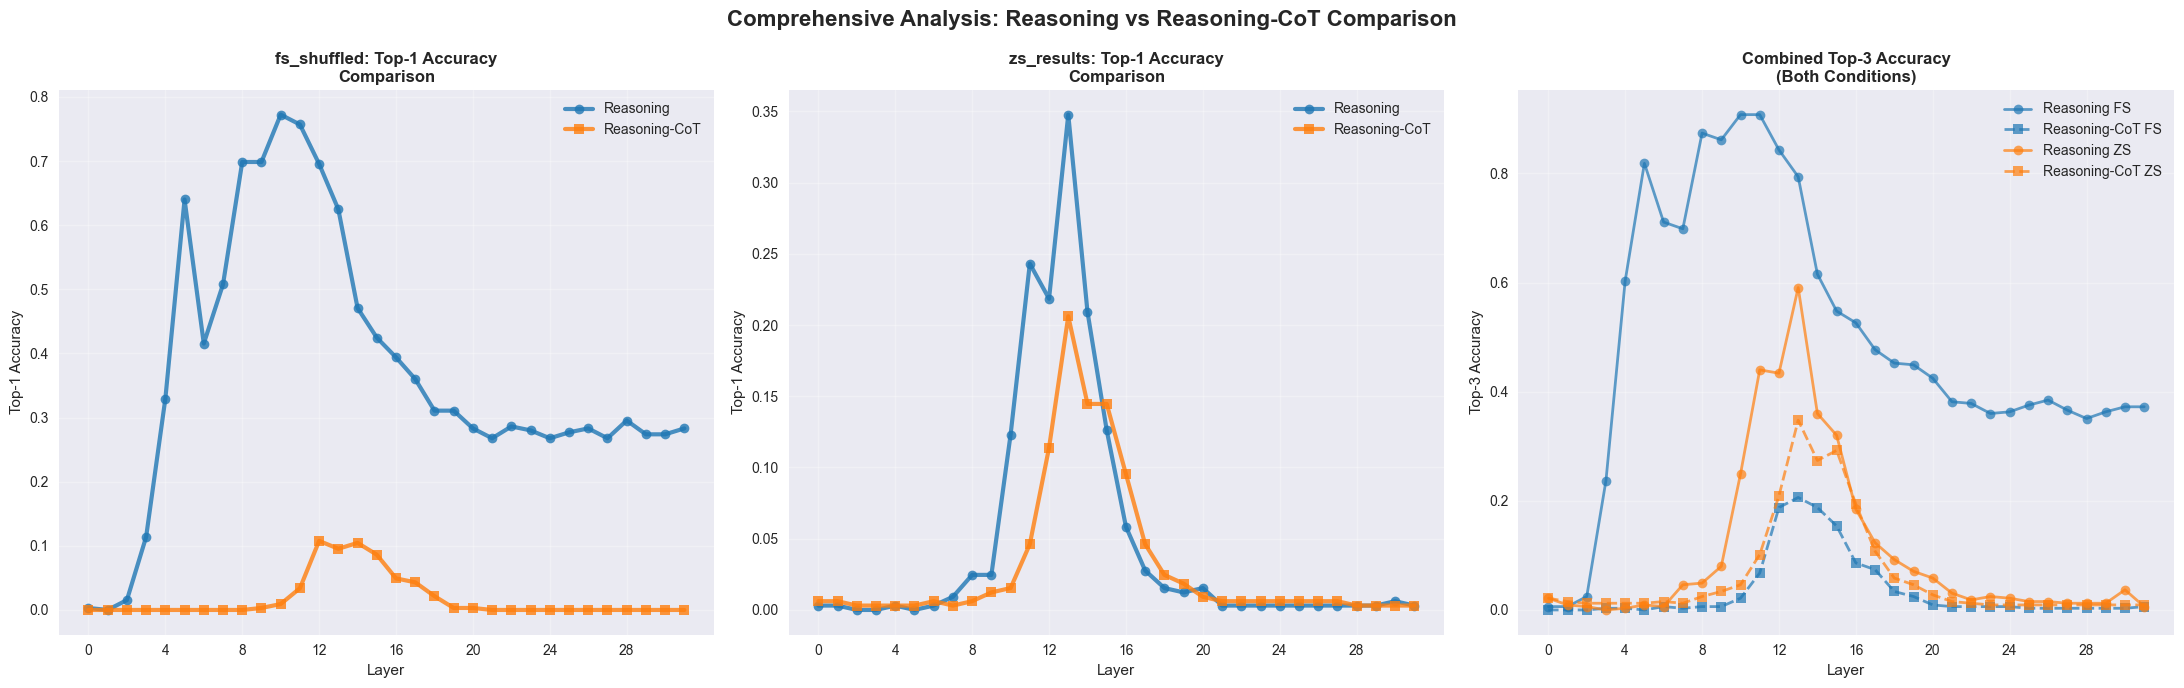


Top-1 and Top-3 Accuracy Summary Statistics:

FS_RESULTS:
  Top-1 Reasoning:     Mean=0.3712, Std=0.2109
  Top-1 Reasoning-CoT: Mean=0.0175, Std=0.0337
  Top-3 Reasoning:     Mean=0.4954, Std=0.2540
  Top-3 Reasoning-CoT: Mean=0.0353, Std=0.0614
  CoT Top-1 Improvement: -0.3537 (-95.3%)
  CoT Top-3 Improvement: -0.4601 (-92.9%)

ZS_RESULTS:
  Top-1 Reasoning:     Mean=0.0470, Std=0.0876
  Top-1 Reasoning-CoT: Mean=0.0304, Std=0.0518
  Top-3 Reasoning:     Mean=0.1050, Std=0.1560
  Top-3 Reasoning-CoT: Mean=0.0621, Std=0.0940
  CoT Top-1 Improvement: -0.0166 (-35.4%)
  CoT Top-3 Improvement: -0.0429 (-40.8%)


In [106]:
# Create a comprehensive 3-subplot comparison focusing on top-1 and top-3 accuracy
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Comprehensive Analysis: Reasoning vs Reasoning-CoT Comparison', fontsize=16, fontweight='bold')

# Colors and styles for consistency
colors = {'reasoning': '#1f77b4', 'reasoning-CoT': '#ff7f0e'}
markers = {'reasoning': 'o', 'reasoning-CoT': 's'}
linestyles = {'reasoning': '-', 'reasoning-CoT': '--'}

# Plot 1: Top-1 Comparison for fs_shuffled
ax1 = axes[0]
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_fs_top1 = reasoning_fs_data[reasoning_fs_data['k'] == 1]
    reasoning_cot_fs_top1 = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == 1]
    
    if not reasoning_fs_top1.empty:
        ax1.plot(reasoning_fs_top1['index'], reasoning_fs_top1['accuracy'], 
                 marker=markers['reasoning'], linewidth=3, label='Reasoning', 
                 alpha=0.8, color=colors['reasoning'])
    if not reasoning_cot_fs_top1.empty:
        ax1.plot(reasoning_cot_fs_top1['index'], reasoning_cot_fs_top1['accuracy'], 
                 marker=markers['reasoning-CoT'], linewidth=3, label='Reasoning-CoT', 
                 alpha=0.8, color=colors['reasoning-CoT'])
    
    ax1.set_title('fs_shuffled: Top-1 Accuracy\nComparison', fontweight='bold')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Top-1 Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    ax1.text(0.5, 0.5, 'No data available for comparison', ha='center', va='center', 
             transform=ax1.transAxes)

# Plot 2: Top-1 Comparison for zs_results
ax2 = axes[1]
if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_zs_top1 = reasoning_zs_data[reasoning_zs_data['k'] == 1]
    reasoning_cot_zs_top1 = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == 1]
    
    if not reasoning_zs_top1.empty:
        ax2.plot(reasoning_zs_top1['index'], reasoning_zs_top1['accuracy'], 
                 marker=markers['reasoning'], linewidth=3, label='Reasoning', 
                 alpha=0.8, color=colors['reasoning'])
    if not reasoning_cot_zs_top1.empty:
        ax2.plot(reasoning_cot_zs_top1['index'], reasoning_cot_zs_top1['accuracy'], 
                 marker=markers['reasoning-CoT'], linewidth=3, label='Reasoning-CoT', 
                 alpha=0.8, color=colors['reasoning-CoT'])
    
    ax2.set_title('zs_results: Top-1 Accuracy\nComparison', fontweight='bold')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Top-1 Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    ax2.text(0.5, 0.5, 'No data available for comparison', ha='center', va='center', 
             transform=ax2.transAxes)

# Plot 3: Combined comparison for both conditions (Top-3 accuracy across all indices)
ax3 = axes[2]

# Define colors for FS and ZS conditions
condition_colors = {'FS': '#1f77b4', 'ZS': '#ff7f0e'}  # Blue for FS, Orange for ZS
model_markers = {'Reasoning': 'o', 'Reasoning-CoT': 's'}

# Combine both fs_shuffled and zs_results for comprehensive view
for dataset_name, condition_label in [('fs_shuffled', 'FS'), ('zs_results', 'ZS')]:
    reasoning_data = reasoning_cot_datasets.get(f'reasoning_{dataset_name.split("_")[0]}')
    reasoning_cot_data = reasoning_cot_datasets.get(f'reasoning_cot_{dataset_name.split("_")[0]}')
    
    if reasoning_data is not None and not reasoning_data.empty:
        reasoning_top3 = reasoning_data[reasoning_data['k'] == 3]
        if not reasoning_top3.empty:
            ax3.plot(reasoning_top3['index'], reasoning_top3['accuracy'], 
                 marker=model_markers['Reasoning'], linewidth=2, 
                 label=f'Reasoning {condition_label}', 
                 alpha=0.7, linestyle='-', color=condition_colors[condition_label])
        
    if reasoning_cot_data is not None and not reasoning_cot_data.empty:
        reasoning_cot_top3 = reasoning_cot_data[reasoning_cot_data['k'] == 3]
        if not reasoning_cot_top3.empty:
            ax3.plot(reasoning_cot_top3['index'], reasoning_cot_top3['accuracy'], 
                 marker=model_markers['Reasoning-CoT'], linewidth=2, 
                 label=f'Reasoning-CoT {condition_label}', 
                 alpha=0.7, linestyle='--', color=condition_colors[condition_label])

ax3.set_title('Combined Top-3 Accuracy\n(Both Conditions)', fontweight='bold')
ax3.set_xlabel('Layer')
ax3.set_ylabel('Top-3 Accuracy')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(0, 32, 4))

plt.tight_layout()
plt.show()

# Print summary statistics for Top-1 and Top-3 accuracy
print("\nTop-1 and Top-3 Accuracy Summary Statistics:")
print("="*60)

for dataset_type in ['fs', 'zs']:
    reasoning_key = f'reasoning_{dataset_type}'
    reasoning_cot_key = f'reasoning_cot_{dataset_type}'
    
    if reasoning_key in reasoning_cot_datasets and reasoning_cot_key in reasoning_cot_datasets:
        reasoning_data = reasoning_cot_datasets[reasoning_key]
        reasoning_cot_data = reasoning_cot_datasets[reasoning_cot_key]
        
        if not reasoning_data.empty and not reasoning_cot_data.empty:
            reasoning_top1 = reasoning_data[reasoning_data['k'] == 1]
            reasoning_cot_top1 = reasoning_cot_data[reasoning_cot_data['k'] == 1]
            reasoning_top3 = reasoning_data[reasoning_data['k'] == 3]
            reasoning_cot_top3 = reasoning_cot_data[reasoning_cot_data['k'] == 3]
            
            print(f"\n{dataset_type.upper()}_RESULTS:")
            print(f"  Top-1 Reasoning:     Mean={reasoning_top1['accuracy'].mean():.4f}, Std={reasoning_top1['accuracy'].std():.4f}")
            print(f"  Top-1 Reasoning-CoT: Mean={reasoning_cot_top1['accuracy'].mean():.4f}, Std={reasoning_cot_top1['accuracy'].std():.4f}")
            print(f"  Top-3 Reasoning:     Mean={reasoning_top3['accuracy'].mean():.4f}, Std={reasoning_top3['accuracy'].std():.4f}")
            print(f"  Top-3 Reasoning-CoT: Mean={reasoning_cot_top3['accuracy'].mean():.4f}, Std={reasoning_cot_top3['accuracy'].std():.4f}")
            
            # Calculate improvements
            top1_improvement = reasoning_cot_top1['accuracy'].mean() - reasoning_top1['accuracy'].mean()
            top3_improvement = reasoning_cot_top3['accuracy'].mean() - reasoning_top3['accuracy'].mean()
            print(f"  CoT Top-1 Improvement: {top1_improvement:+.4f} ({top1_improvement/reasoning_top1['accuracy'].mean()*100:+.1f}%)")
            print(f"  CoT Top-3 Improvement: {top3_improvement:+.4f} ({top3_improvement/reasoning_top3['accuracy'].mean()*100:+.1f}%)")


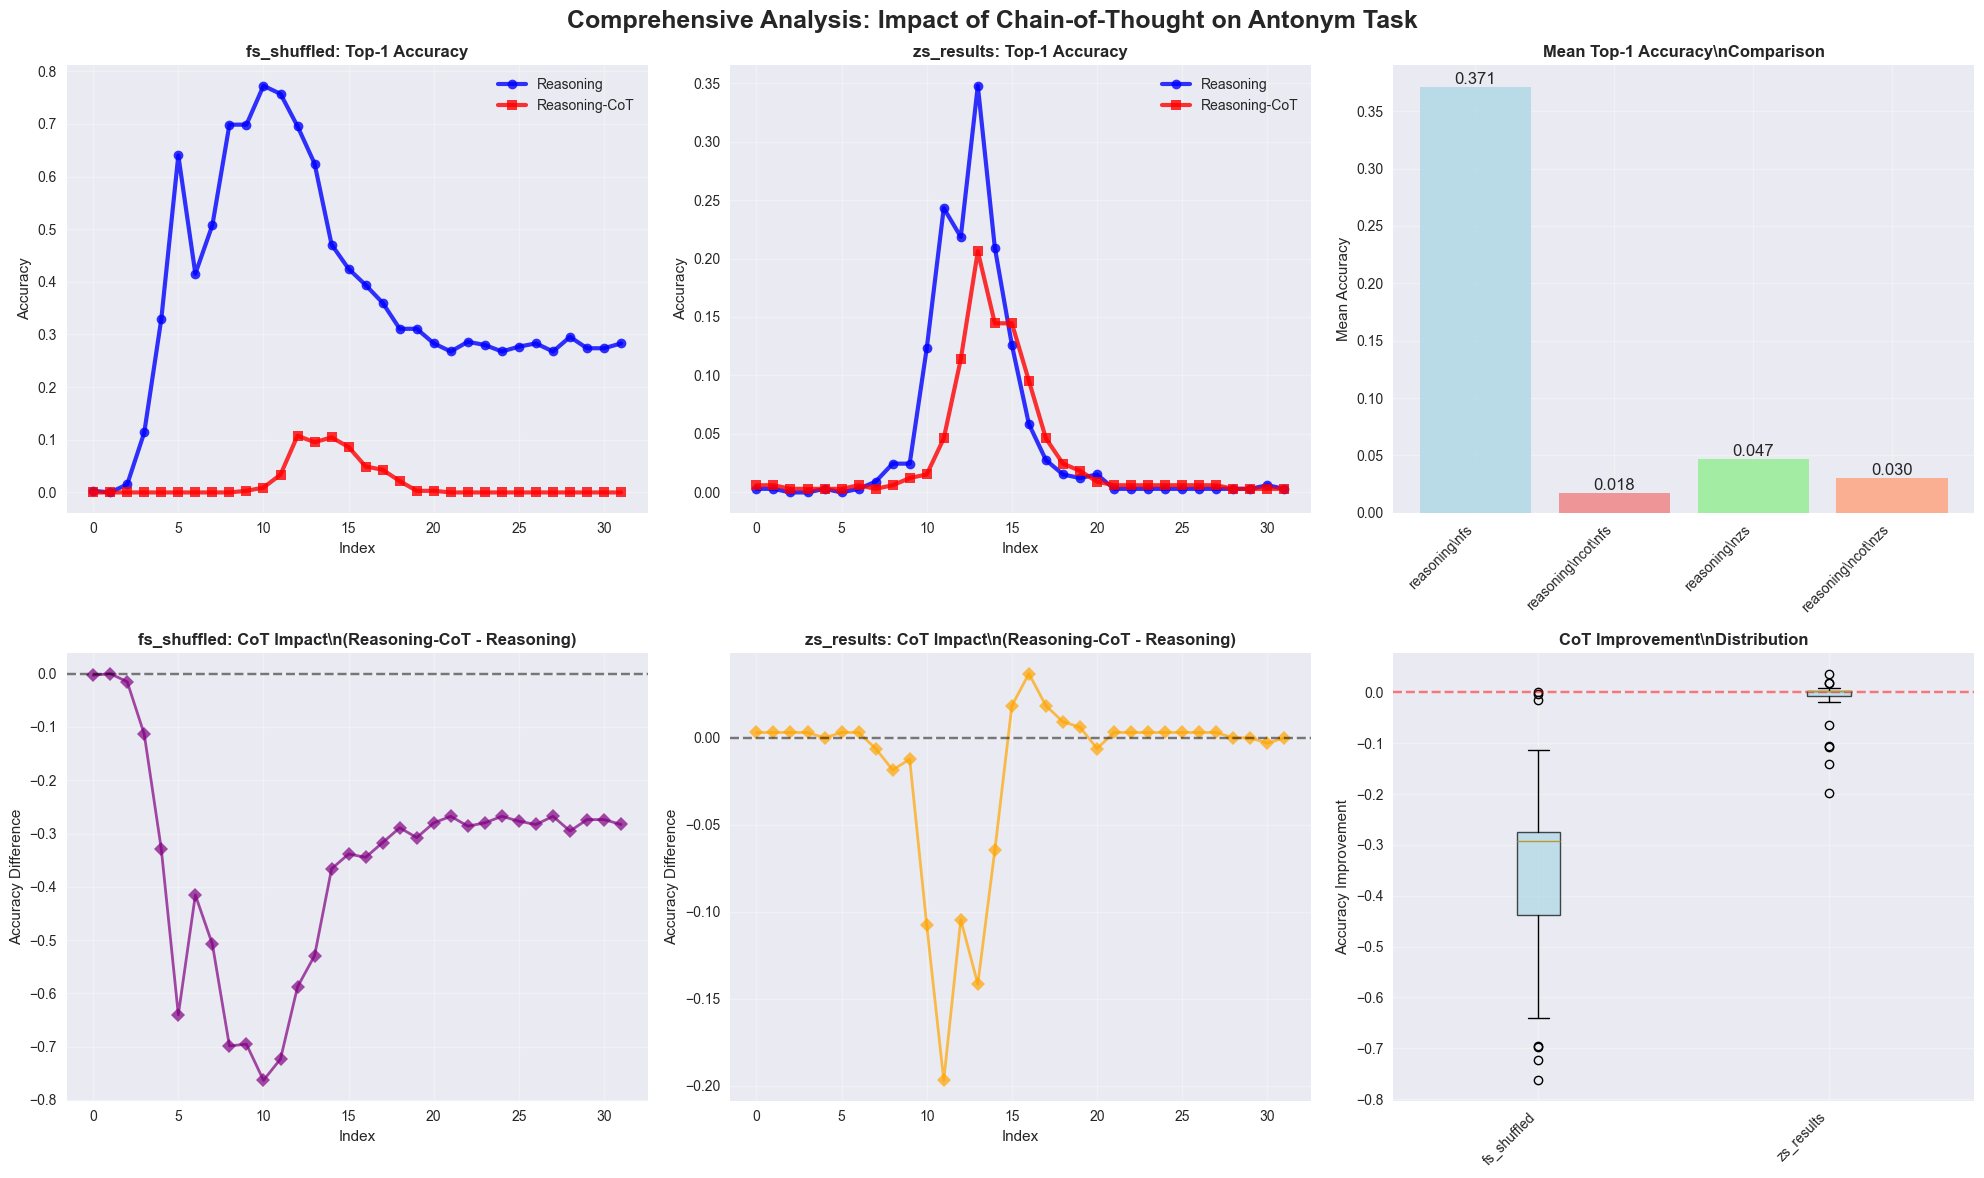

\nChain-of-Thought Impact Analysis (Top-1 Accuracy):
\nFS_SHUFFLED:
  Reasoning:     Mean=0.3712, Std=0.2109
  Reasoning-CoT: Mean=0.0175, Std=0.0337
  CoT Improvement: -0.3537 (-95.3%)
  Indices improved: 0/32 (0.0%)
  Indices worsened: 31/32 (96.9%)
  Indices unchanged: 1/32 (3.1%)
  Mean improvement per index: -0.3538
  Max improvement: +0.0000
  Max degradation: -0.7631
\nZS_RESULTS:
  Reasoning:     Mean=0.0470, Std=0.0876
  Reasoning-CoT: Mean=0.0304, Std=0.0518
  CoT Improvement: -0.0166 (-35.4%)
  Indices improved: 18/32 (56.2%)
  Indices worsened: 10/32 (31.2%)
  Indices unchanged: 4/32 (12.5%)
  Mean improvement per index: -0.0166
  Max improvement: +0.0369
  Max degradation: -0.1969
\n============================================================


In [91]:
# Comprehensive comparison: Reasoning vs Reasoning-CoT
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Analysis: Impact of Chain-of-Thought on Antonym Task', fontsize=18, fontweight='bold')

# Define reasoning vs reasoning-CoT datasets
reasoning_cot_datasets = {
    'reasoning_fs': reasoning_fs_data,
    'reasoning_cot_fs': reasoning_cot_fs_data,
    'reasoning_zs': reasoning_zs_data,
    'reasoning_cot_zs': reasoning_cot_zs_data
}

# Plot 1: Side-by-side Top-1 comparison for fs_shuffled
ax1 = axes[0, 0]
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_fs_top1 = reasoning_fs_data[reasoning_fs_data['k'] == 1]
    reasoning_cot_fs_top1 = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == 1]
    
    if not reasoning_fs_top1.empty:
        ax1.plot(reasoning_fs_top1['index'], reasoning_fs_top1['accuracy'], 
                 marker='o', linewidth=3, label='Reasoning', alpha=0.8, color='blue')
    if not reasoning_cot_fs_top1.empty:
        ax1.plot(reasoning_cot_fs_top1['index'], reasoning_cot_fs_top1['accuracy'], 
                 marker='s', linewidth=3, label='Reasoning-CoT', alpha=0.8, color='red')
    
    ax1.set_title('fs_shuffled: Top-1 Accuracy', fontweight='bold')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Side-by-side Top-1 comparison for zs_results
ax2 = axes[0, 1]
if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_zs_top1 = reasoning_zs_data[reasoning_zs_data['k'] == 1]
    reasoning_cot_zs_top1 = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == 1]
    
    if not reasoning_zs_top1.empty:
        ax2.plot(reasoning_zs_top1['index'], reasoning_zs_top1['accuracy'], 
                 marker='o', linewidth=3, label='Reasoning', alpha=0.8, color='blue')
    if not reasoning_cot_zs_top1.empty:
        ax2.plot(reasoning_cot_zs_top1['index'], reasoning_cot_zs_top1['accuracy'], 
                 marker='s', linewidth=3, label='Reasoning-CoT', alpha=0.8, color='red')
    
    ax2.set_title('zs_results: Top-1 Accuracy', fontweight='bold')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Plot 3: Mean accuracy comparison bar chart
ax3 = axes[0, 2]
mean_accuracies = []
labels = []
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for i, (name, data) in enumerate(reasoning_cot_datasets.items()):
    if not data.empty:
        top1_data = data[data['k'] == 1]
        if not top1_data.empty:
            mean_accuracies.append(top1_data['accuracy'].mean())
            labels.append(name.replace('_', '\\n'))

if mean_accuracies:
    bars = ax3.bar(range(len(mean_accuracies)), mean_accuracies, 
                   color=colors[:len(mean_accuracies)], alpha=0.8)
    ax3.set_title('Mean Top-1 Accuracy\\nComparison', fontweight='bold')
    ax3.set_ylabel('Mean Accuracy')
    ax3.set_xticks(range(len(labels)))
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

# Plot 4: Difference plot for fs_shuffled (Reasoning-CoT - Reasoning)
ax4 = axes[1, 0]
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_fs_top1 = reasoning_fs_data[reasoning_fs_data['k'] == 1]
    reasoning_cot_fs_top1 = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == 1]
    
    # Calculate differences
    common_indices = set(reasoning_fs_top1['index']).intersection(set(reasoning_cot_fs_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_fs_top1[reasoning_fs_top1['index'] == idx]['accuracy'].iloc[0]
        reasoning_cot_acc = reasoning_cot_fs_top1[reasoning_cot_fs_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(reasoning_cot_acc - reasoning_acc)
        indices_list.append(idx)
    
    ax4.plot(indices_list, differences, marker='D', linewidth=2, 
             color='purple', alpha=0.7, label='CoT - Reasoning')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('fs_shuffled: CoT Impact\\n(Reasoning-CoT - Reasoning)', fontweight='bold')
    ax4.set_xlabel('Index')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)

# Plot 5: Difference plot for zs_results (Reasoning-CoT - Reasoning)
ax5 = axes[1, 1]
if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_zs_top1 = reasoning_zs_data[reasoning_zs_data['k'] == 1]
    reasoning_cot_zs_top1 = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == 1]
    
    # Calculate differences
    common_indices = set(reasoning_zs_top1['index']).intersection(set(reasoning_cot_zs_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_zs_top1[reasoning_zs_top1['index'] == idx]['accuracy'].iloc[0]
        reasoning_cot_acc = reasoning_cot_zs_top1[reasoning_cot_zs_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(reasoning_cot_acc - reasoning_acc)
        indices_list.append(idx)
    
    ax5.plot(indices_list, differences, marker='D', linewidth=2, 
             color='orange', alpha=0.7, label='CoT - Reasoning')
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('zs_results: CoT Impact\\n(Reasoning-CoT - Reasoning)', fontweight='bold')
    ax5.set_xlabel('Index')
    ax5.set_ylabel('Accuracy Difference')
    ax5.grid(True, alpha=0.3)

# Plot 6: Overall improvement distribution
ax6 = axes[1, 2]
all_improvements = []
labels_improvements = []

# Collect all improvements
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_fs_top1 = reasoning_fs_data[reasoning_fs_data['k'] == 1]
    reasoning_cot_fs_top1 = reasoning_cot_fs_data[reasoning_cot_fs_data['k'] == 1]
    common_indices = set(reasoning_fs_top1['index']).intersection(set(reasoning_cot_fs_top1['index']))
    
    fs_improvements = []
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_fs_top1[reasoning_fs_top1['index'] == idx]['accuracy'].iloc[0]
        reasoning_cot_acc = reasoning_cot_fs_top1[reasoning_cot_fs_top1['index'] == idx]['accuracy'].iloc[0]
        fs_improvements.append(reasoning_cot_acc - reasoning_acc)
    
    all_improvements.extend(fs_improvements)
    labels_improvements.extend(['fs_shuffled'] * len(fs_improvements))

if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_zs_top1 = reasoning_zs_data[reasoning_zs_data['k'] == 1]
    reasoning_cot_zs_top1 = reasoning_cot_zs_data[reasoning_cot_zs_data['k'] == 1]
    common_indices = set(reasoning_zs_top1['index']).intersection(set(reasoning_cot_zs_top1['index']))
    
    zs_improvements = []
    for idx in sorted(common_indices):
        reasoning_acc = reasoning_zs_top1[reasoning_zs_top1['index'] == idx]['accuracy'].iloc[0]
        reasoning_cot_acc = reasoning_cot_zs_top1[reasoning_cot_zs_top1['index'] == idx]['accuracy'].iloc[0]
        zs_improvements.append(reasoning_cot_acc - reasoning_acc)
    
    all_improvements.extend(zs_improvements)
    labels_improvements.extend(['zs_results'] * len(zs_improvements))

if all_improvements:
    improvement_df = pd.DataFrame({
        'improvement': all_improvements,
        'dataset': labels_improvements
    })
    
    # Create box plot
    import matplotlib.pyplot as plt
    datasets_unique = improvement_df['dataset'].unique()
    positions = range(len(datasets_unique))
    
    box_data = [improvement_df[improvement_df['dataset'] == ds]['improvement'].values for ds in datasets_unique]
    box_plot = ax6.boxplot(box_data, positions=positions, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    ax6.set_title('CoT Improvement\\nDistribution', fontweight='bold')
    ax6.set_ylabel('Accuracy Improvement')
    ax6.set_xticks(positions)
    ax6.set_xticklabels(datasets_unique, rotation=45, ha='right')
    ax6.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("\\nChain-of-Thought Impact Analysis (Top-1 Accuracy):")
print("="*60)

for dataset_type in ['fs_shuffled', 'zs_results']:
    reasoning_data = reasoning_cot_datasets[f'reasoning_{dataset_type.split("_")[0]}']
    reasoning_cot_data = reasoning_cot_datasets[f'reasoning_cot_{dataset_type.split("_")[0]}']
    
    if not reasoning_data.empty and not reasoning_cot_data.empty:
        reasoning_top1 = reasoning_data[reasoning_data['k'] == 1]
        reasoning_cot_top1 = reasoning_cot_data[reasoning_cot_data['k'] == 1]
        
        print(f"\\n{dataset_type.upper()}:")
        print(f"  Reasoning:     Mean={reasoning_top1['accuracy'].mean():.4f}, Std={reasoning_top1['accuracy'].std():.4f}")
        print(f"  Reasoning-CoT: Mean={reasoning_cot_top1['accuracy'].mean():.4f}, Std={reasoning_cot_top1['accuracy'].std():.4f}")
        
        # Calculate improvement
        improvement = reasoning_cot_top1['accuracy'].mean() - reasoning_top1['accuracy'].mean()
        print(f"  CoT Improvement: {improvement:+.4f} ({improvement/reasoning_top1['accuracy'].mean()*100:+.1f}%)")
        
        # Calculate per-index improvements
        common_indices = set(reasoning_top1['index']).intersection(set(reasoning_cot_top1['index']))
        improvements = []
        for idx in sorted(common_indices):
            reasoning_acc = reasoning_top1[reasoning_top1['index'] == idx]['accuracy'].iloc[0]
            reasoning_cot_acc = reasoning_cot_top1[reasoning_cot_top1['index'] == idx]['accuracy'].iloc[0]
            improvements.append(reasoning_cot_acc - reasoning_acc)
        
        if improvements:
            positive_improvements = sum(1 for imp in improvements if imp > 0)
            negative_improvements = sum(1 for imp in improvements if imp < 0)
            no_change = sum(1 for imp in improvements if imp == 0)
            
            print(f"  Indices improved: {positive_improvements}/{len(improvements)} ({positive_improvements/len(improvements)*100:.1f}%)")
            print(f"  Indices worsened: {negative_improvements}/{len(improvements)} ({negative_improvements/len(improvements)*100:.1f}%)")
            print(f"  Indices unchanged: {no_change}/{len(improvements)} ({no_change/len(improvements)*100:.1f}%)")
            print(f"  Mean improvement per index: {np.mean(improvements):+.4f}")
            print(f"  Max improvement: {np.max(improvements):+.4f}")
            print(f"  Max degradation: {np.min(improvements):+.4f}")

print("\\n" + "="*60)

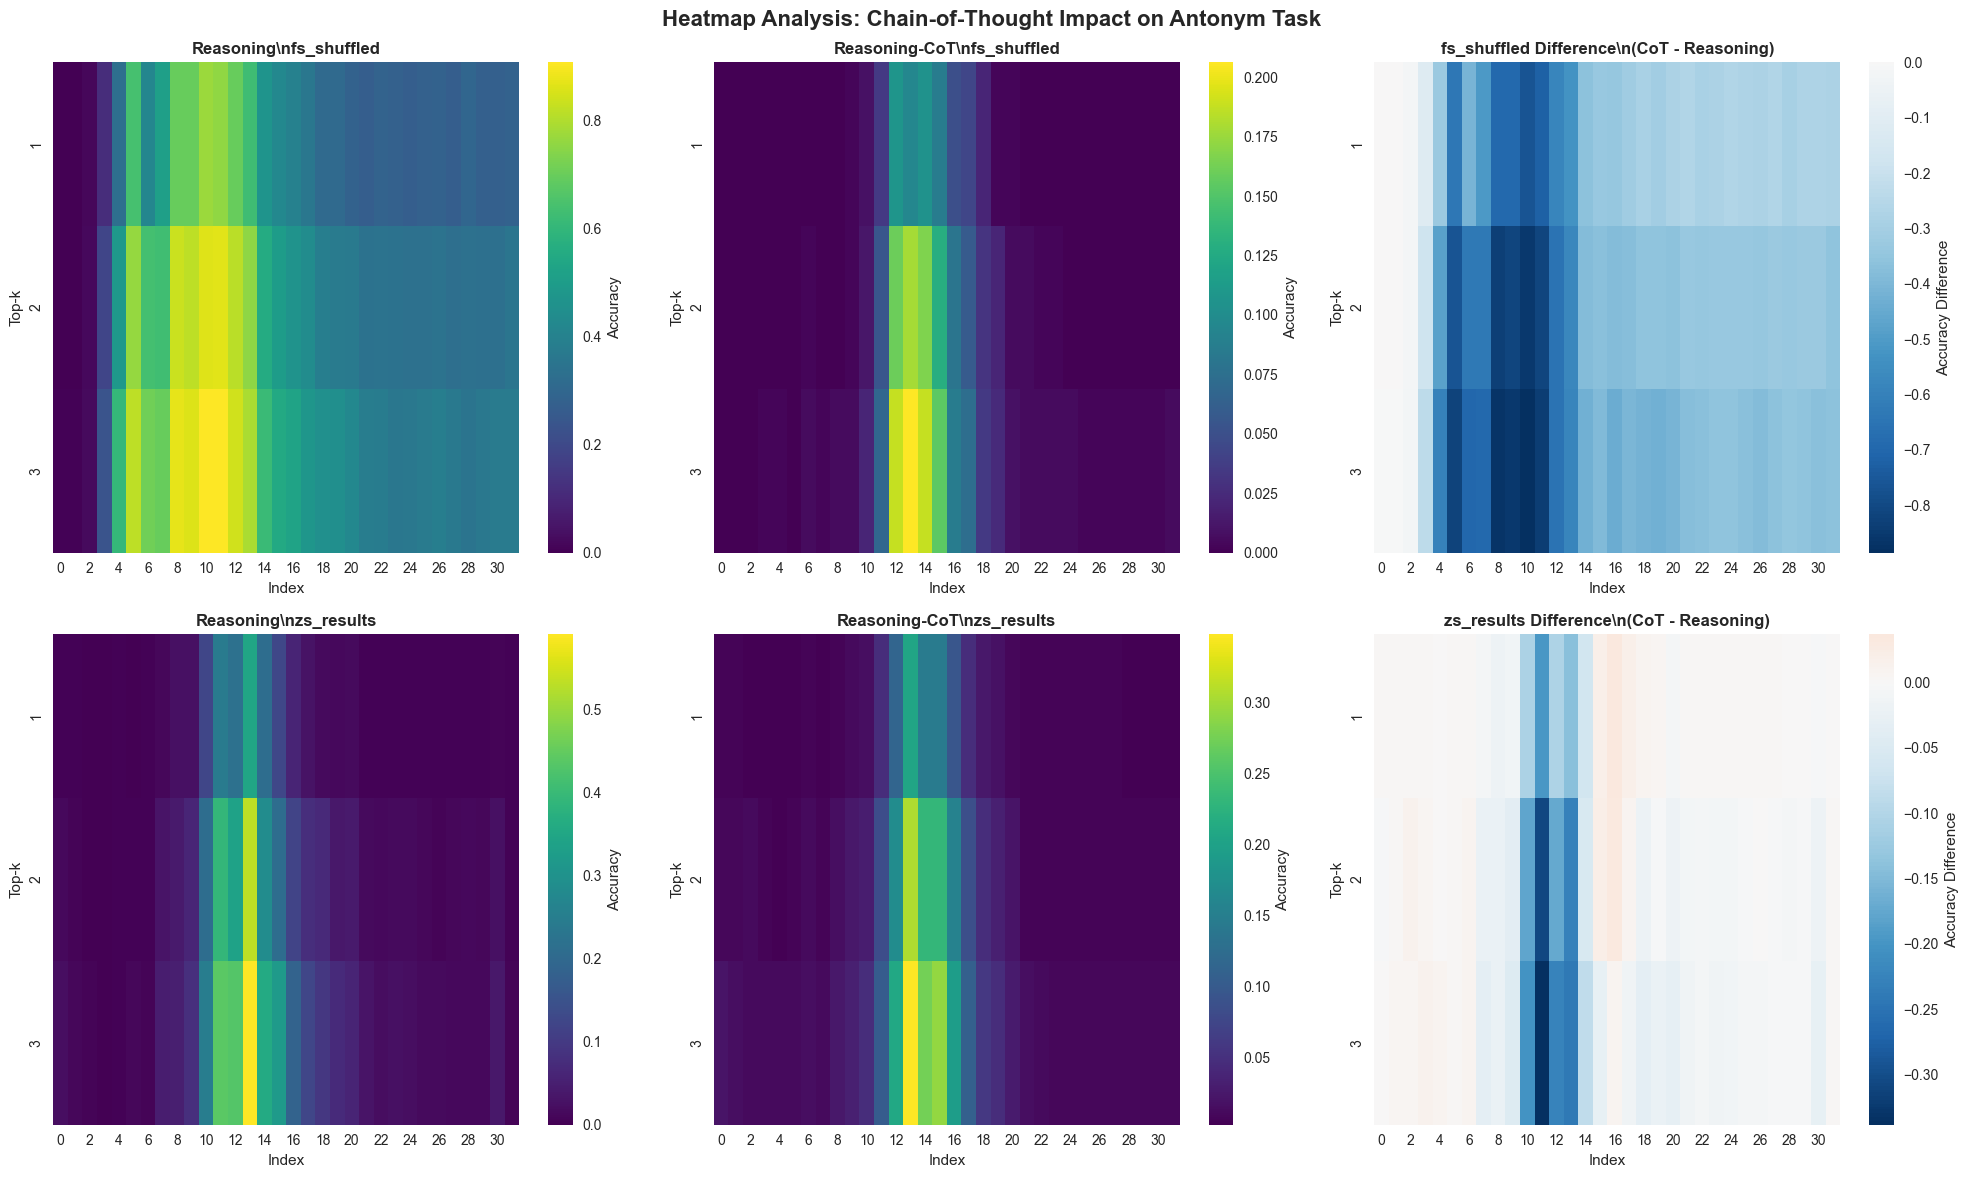

\nSUMMARY: Chain-of-Thought Impact on Antonym Task
\nThis analysis compares the intervention_topk accuracy between:
• Reasoning: Standard few-shot prompting
• Reasoning-CoT: Chain-of-Thought prompting
\nKey insights:
• Overall, CoT improved performance in 0/2 dataset types
• Average improvement across datasets: -0.1852
• Chain-of-Thought prompting shows NEGATIVE impact on antonym task performance
\n=======================================================


In [92]:
# Heatmap comparison: Reasoning vs Reasoning-CoT
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Heatmap Analysis: Chain-of-Thought Impact on Antonym Task', fontsize=16, fontweight='bold')

# Create heatmaps for reasoning vs reasoning-CoT
heatmap_datasets = [
    (reasoning_fs_data, 'Reasoning\\nfs_shuffled', (0, 0)),
    (reasoning_cot_fs_data, 'Reasoning-CoT\\nfs_shuffled', (0, 1)),
    (reasoning_zs_data, 'Reasoning\\nzs_results', (1, 0)),
    (reasoning_cot_zs_data, 'Reasoning-CoT\\nzs_results', (1, 1))
]

# Create individual heatmaps
for data, title, (row, col) in heatmap_datasets:
    ax = axes[row, col]
    
    if not data.empty:
        heatmap_data = create_heatmap_data(data)
        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, ax=ax, cmap='viridis', 
                       cbar_kws={'label': 'Accuracy'}, 
                       annot=False, fmt='.3f')
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', 
                   transform=ax.transAxes)
            ax.set_title(f'{title}\\n(No Data)')
    else:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
               transform=ax.transAxes)
        ax.set_title(f'{title}\\n(No Data)')

# Create difference heatmaps
# fs_shuffled difference
ax = axes[0, 2]
if not reasoning_fs_data.empty and not reasoning_cot_fs_data.empty:
    reasoning_hm = create_heatmap_data(reasoning_fs_data)
    reasoning_cot_hm = create_heatmap_data(reasoning_cot_fs_data)
    
    if not reasoning_hm.empty and not reasoning_cot_hm.empty:
        # Align indices and k values
        common_indices = reasoning_hm.columns.intersection(reasoning_cot_hm.columns)
        common_k = reasoning_hm.index.intersection(reasoning_cot_hm.index)
        
        if len(common_indices) > 0 and len(common_k) > 0:
            diff_hm_fs = reasoning_cot_hm.loc[common_k, common_indices] - reasoning_hm.loc[common_k, common_indices]
            
            sns.heatmap(diff_hm_fs, ax=ax, cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Accuracy Difference'})
            ax.set_title('fs_shuffled Difference\\n(CoT - Reasoning)', fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'Cannot create difference heatmap', ha='center', va='center', 
                   transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'Insufficient data for difference', ha='center', va='center', 
               transform=ax.transAxes)
else:
    ax.text(0.5, 0.5, 'No data for comparison', ha='center', va='center', 
           transform=ax.transAxes)

# zs_results difference
ax = axes[1, 2]
if not reasoning_zs_data.empty and not reasoning_cot_zs_data.empty:
    reasoning_hm = create_heatmap_data(reasoning_zs_data)
    reasoning_cot_hm = create_heatmap_data(reasoning_cot_zs_data)
    
    if not reasoning_hm.empty and not reasoning_cot_hm.empty:
        # Align indices and k values
        common_indices = reasoning_hm.columns.intersection(reasoning_cot_hm.columns)
        common_k = reasoning_hm.index.intersection(reasoning_cot_hm.index)
        
        if len(common_indices) > 0 and len(common_k) > 0:
            diff_hm_zs = reasoning_cot_hm.loc[common_k, common_indices] - reasoning_hm.loc[common_k, common_indices]
            
            sns.heatmap(diff_hm_zs, ax=ax, cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Accuracy Difference'})
            ax.set_title('zs_results Difference\\n(CoT - Reasoning)', fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'Cannot create difference heatmap', ha='center', va='center', 
                   transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'Insufficient data for difference', ha='center', va='center', 
               transform=ax.transAxes)
else:
    ax.text(0.5, 0.5, 'No data for comparison', ha='center', va='center', 
           transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Summary of CoT impact
print("\\nSUMMARY: Chain-of-Thought Impact on Antonym Task")
print("="*55)
print("\\nThis analysis compares the intervention_topk accuracy between:")
print("• Reasoning: Standard few-shot prompting")
print("• Reasoning-CoT: Chain-of-Thought prompting")
print("\\nKey insights:")

# Calculate overall statistics
total_improvements = 0
total_comparisons = 0
overall_improvement = 0

for dataset_type in ['fs', 'zs']:
    reasoning_key = f'reasoning_{dataset_type}'
    reasoning_cot_key = f'reasoning_cot_{dataset_type}'
    
    if reasoning_key in reasoning_cot_datasets and reasoning_cot_key in reasoning_cot_datasets:
        reasoning_data = reasoning_cot_datasets[reasoning_key]
        reasoning_cot_data = reasoning_cot_datasets[reasoning_cot_key]
        
        if not reasoning_data.empty and not reasoning_cot_data.empty:
            reasoning_top1 = reasoning_data[reasoning_data['k'] == 1]
            reasoning_cot_top1 = reasoning_cot_data[reasoning_cot_data['k'] == 1]
            
            improvement = reasoning_cot_top1['accuracy'].mean() - reasoning_top1['accuracy'].mean()
            overall_improvement += improvement
            
            if improvement > 0:
                total_improvements += 1
            total_comparisons += 1

if total_comparisons > 0:
    print(f"• Overall, CoT improved performance in {total_improvements}/{total_comparisons} dataset types")
    print(f"• Average improvement across datasets: {overall_improvement/total_comparisons:+.4f}")
    
    if overall_improvement > 0:
        print("• Chain-of-Thought prompting shows POSITIVE impact on antonym task performance")
    elif overall_improvement < 0:
        print("• Chain-of-Thought prompting shows NEGATIVE impact on antonym task performance")
    else:
        print("• Chain-of-Thought prompting shows NO significant impact on antonym task performance")
else:
    print("• Unable to calculate overall impact due to missing data")

print("\\n" + "="*55)

## Stock vs Stock_ins Comparison

Now let's compare the results between the stock and stock_ins directories to understand the impact of different experimental conditions on the antonym task.

In [42]:
# Load stock_ins data
stock_ins_path = Path("stock_ins/antonym")

# Check and create missing no_rank_list files for stock_ins if needed
print("Checking stock_ins directory for required files...")

# Define the files we need (without the _no_rank_list suffix for now)
stock_ins_file_names = [
    "fs_shuffled_results_layer_sweep.json",
    "zs_results_layer_sweep.json"
]

stock_ins_data = {}
for original_file_name in stock_ins_file_names:
    # Create the no_rank_list version filename
    no_rank_file_name = original_file_name.replace(".json", "_no_rank_list.json")
    original_file_path = stock_ins_path / original_file_name
    no_rank_file_path = stock_ins_path / no_rank_file_name
    
    dataset_name = original_file_name.replace("_layer_sweep.json", "")
    
    # Check if the _no_rank_list version exists, if not try to create it
    if not no_rank_file_path.exists() and original_file_path.exists():
        print(f"Creating {no_rank_file_name} from {original_file_name}...")
        with open(original_file_path, 'r') as f:
            original_data = json.load(f)
        cleaned_data = remove_rank_lists_from_data(original_data)
        with open(no_rank_file_path, 'w') as f:
            json.dump(cleaned_data, f, indent=2)
        print(f"  Created successfully!")
    
    # Load the data (prefer no_rank_list version if available)
    file_to_load = no_rank_file_path if no_rank_file_path.exists() else original_file_path
    
    print(f"Loading stock_ins/{dataset_name} data...")
    try:
        with open(file_to_load, 'r') as f:
            loaded_data = json.load(f)
            # Remove rank_lists if we're loading from original file
            if file_to_load == original_file_path:
                loaded_data = remove_rank_lists_from_data(loaded_data)
            stock_ins_data[dataset_name] = loaded_data
        print(f"  Successfully loaded {len(stock_ins_data[dataset_name])} indices")
    except FileNotFoundError:
        print(f"  Warning: File not found - {file_to_load}")
        stock_ins_data[dataset_name] = {}

# Extract intervention_topk data for stock_ins
stock_ins_extracted = {}
for dataset_name in stock_ins_data:
    if stock_ins_data[dataset_name]:
        stock_ins_extracted[dataset_name] = extract_intervention_topk(stock_ins_data[dataset_name])
        print(f"Extracted stock_ins/{dataset_name}: {len(stock_ins_extracted[dataset_name])} indices")
    else:
        stock_ins_extracted[dataset_name] = {}
        print(f"Skipped stock_ins/{dataset_name}: No data available")

# Create DataFrames for stock_ins data
stock_ins_dataframes = []
for dataset_name in stock_ins_extracted:
    if stock_ins_extracted[dataset_name]:
        full_name = f"stock_ins_{dataset_name}"
        df = create_dataframe_from_topk(stock_ins_extracted[dataset_name], full_name)
        stock_ins_dataframes.append(df)
        print(f"Created DataFrame for {full_name}: {df.shape}")

# Combine stock_ins data with existing data
if stock_ins_dataframes:
    stock_ins_combined = pd.concat(stock_ins_dataframes, ignore_index=True)
    
    # Add to the main combined dataframe
    final_combined_df = pd.concat([extended_combined_df, stock_ins_combined], ignore_index=True)
    print(f"\\nFinal DataFrame shape (including stock_ins): {final_combined_df.shape}")
    
    # Show new dataset breakdown
    print("\\nDataset breakdown (including stock_ins):")
    dataset_counts = final_combined_df['dataset'].value_counts()
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count} rows")
else:
    print("No stock_ins data available")
    final_combined_df = extended_combined_df

Checking stock_ins directory for required files...
Creating fs_shuffled_results_layer_sweep_no_rank_list.json from fs_shuffled_results_layer_sweep.json...
  Created successfully!
Loading stock_ins/fs_shuffled_results data...
  Successfully loaded 32 indices
Creating zs_results_layer_sweep_no_rank_list.json from zs_results_layer_sweep.json...
  Created successfully!
Loading stock_ins/zs_results data...
  Successfully loaded 32 indices
Extracted stock_ins/fs_shuffled_results: 32 indices
Extracted stock_ins/zs_results: 32 indices
Created DataFrame for stock_ins_fs_shuffled_results: (96, 4)
Created DataFrame for stock_ins_zs_results: (96, 4)
\nFinal DataFrame shape (including stock_ins): (768, 4)
\nDataset breakdown (including stock_ins):
  reasoning_fs_shuffled_results: 96 rows
  reasoning_zs_results: 96 rows
  stock_fs_shuffled_results: 96 rows
  stock_zs_results: 96 rows
  reasoning_cot_fs_shuffled_results: 96 rows
  reasoning_cot_zs_results: 96 rows
  stock_ins_fs_shuffled_results: 96 

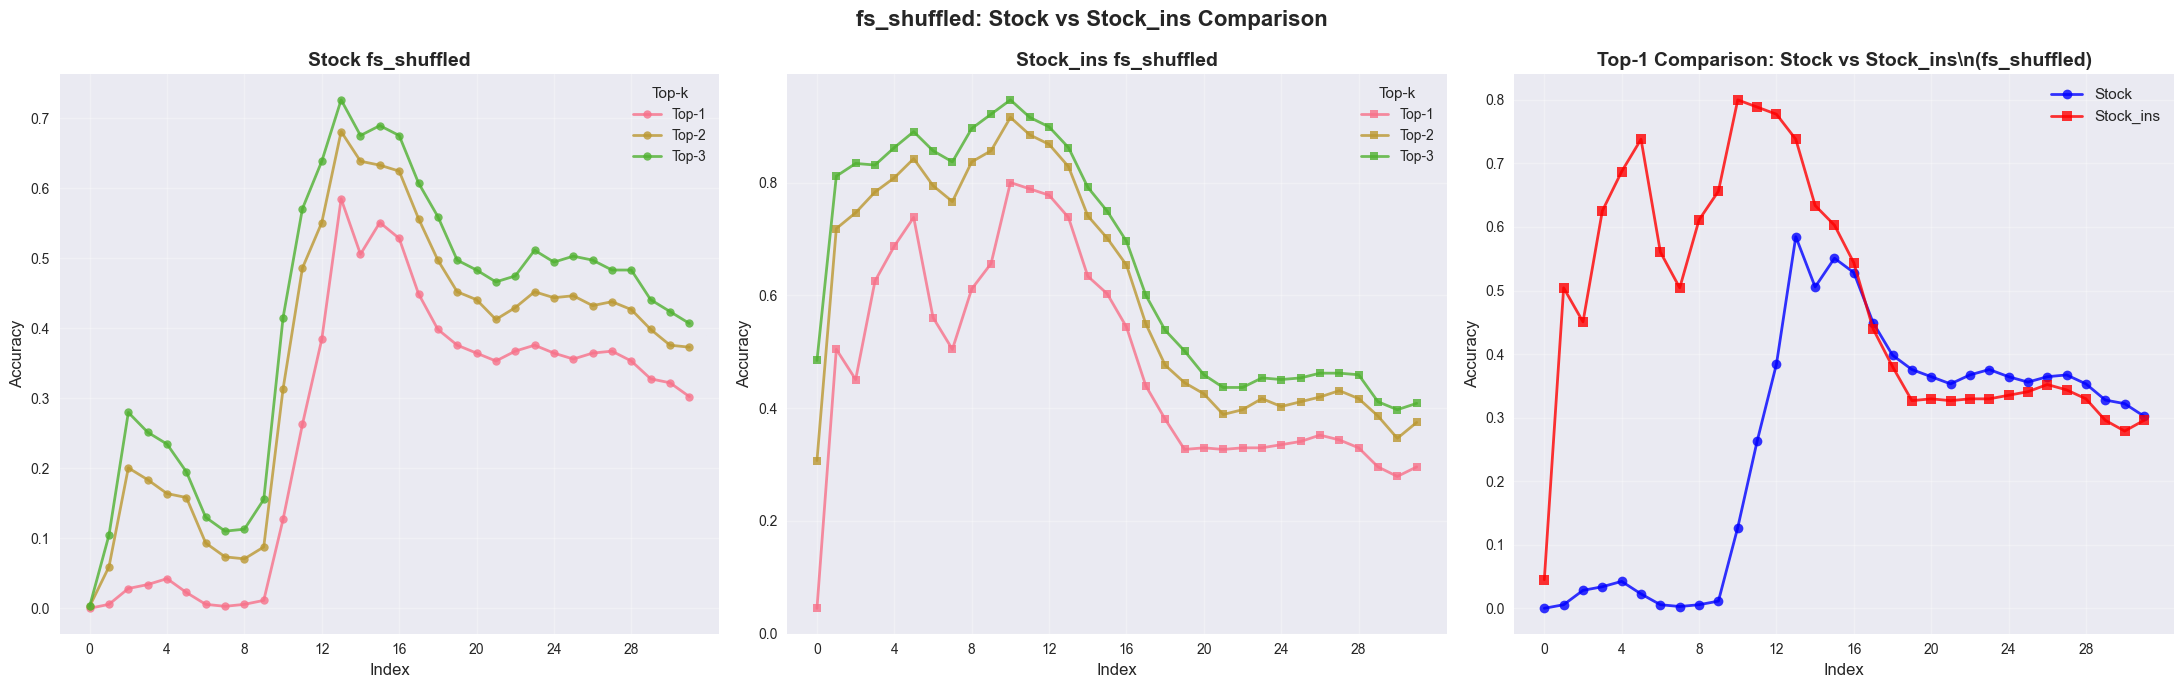

\nfs_shuffled Statistics Comparison:
\nStock:
  Top-1: Mean=0.2669, Std=0.1906, Max=0.5847
  Top-2: Mean=0.3623, Std=0.1938, Max=0.6808
  Top-3: Mean=0.4155, Std=0.1985, Max=0.7260
\nStock_ins:
  Top-1: Mean=0.4782, Std=0.1888, Max=0.8000
  Top-2: Mean=0.6043, Std=0.2050, Max=0.9155
  Top-3: Mean=0.6566, Std=0.2046, Max=0.9465


In [43]:
# Compare stock vs stock_ins for fs_shuffled
stock_fs_data = final_combined_df[final_combined_df['dataset'] == 'stock_fs_shuffled_results']
stock_ins_fs_data = final_combined_df[final_combined_df['dataset'] == 'stock_ins_fs_shuffled_results']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Plot 1: Stock fs_shuffled
if not stock_fs_data.empty:
    ax1 = axes[0]
    for k_val in sorted(stock_fs_data['k'].unique()):
        k_data = stock_fs_data[stock_fs_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('Stock fs_shuffled', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No stock fs_shuffled data', ha='center', va='center', transform=axes[0].transAxes)

# Plot 2: Stock_ins fs_shuffled
if not stock_ins_fs_data.empty:
    ax2 = axes[1]
    for k_val in sorted(stock_ins_fs_data['k'].unique()):
        k_data = stock_ins_fs_data[stock_ins_fs_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('Stock_ins fs_shuffled', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No stock_ins fs_shuffled data', ha='center', va='center', transform=axes[1].transAxes)

# Plot 3: Direct comparison of Top-1 accuracy
ax3 = axes[2]
if not stock_fs_data.empty and not stock_ins_fs_data.empty:
    stock_top1 = stock_fs_data[stock_fs_data['k'] == 1]
    stock_ins_top1 = stock_ins_fs_data[stock_ins_fs_data['k'] == 1]
    
    if not stock_top1.empty:
        ax3.plot(stock_top1['index'], stock_top1['accuracy'], 
                 marker='o', linewidth=2, label='Stock', alpha=0.8, color='blue')
    if not stock_ins_top1.empty:
        ax3.plot(stock_ins_top1['index'], stock_ins_top1['accuracy'], 
                 marker='s', linewidth=2, label='Stock_ins', alpha=0.8, color='red')
    
    ax3.set_title('Top-1 Comparison: Stock vs Stock_ins\\n(fs_shuffled)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Index', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 32, 4))
else:
    ax3.text(0.5, 0.5, 'Cannot compare - missing data', ha='center', va='center', transform=ax3.transAxes)

plt.suptitle('fs_shuffled: Stock vs Stock_ins Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics comparison
print("\\nfs_shuffled Statistics Comparison:")
for dataset_name, data in [("Stock", stock_fs_data), ("Stock_ins", stock_ins_fs_data)]:
    if not data.empty:
        print(f"\\n{dataset_name}:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\\n{dataset_name}: No data available")

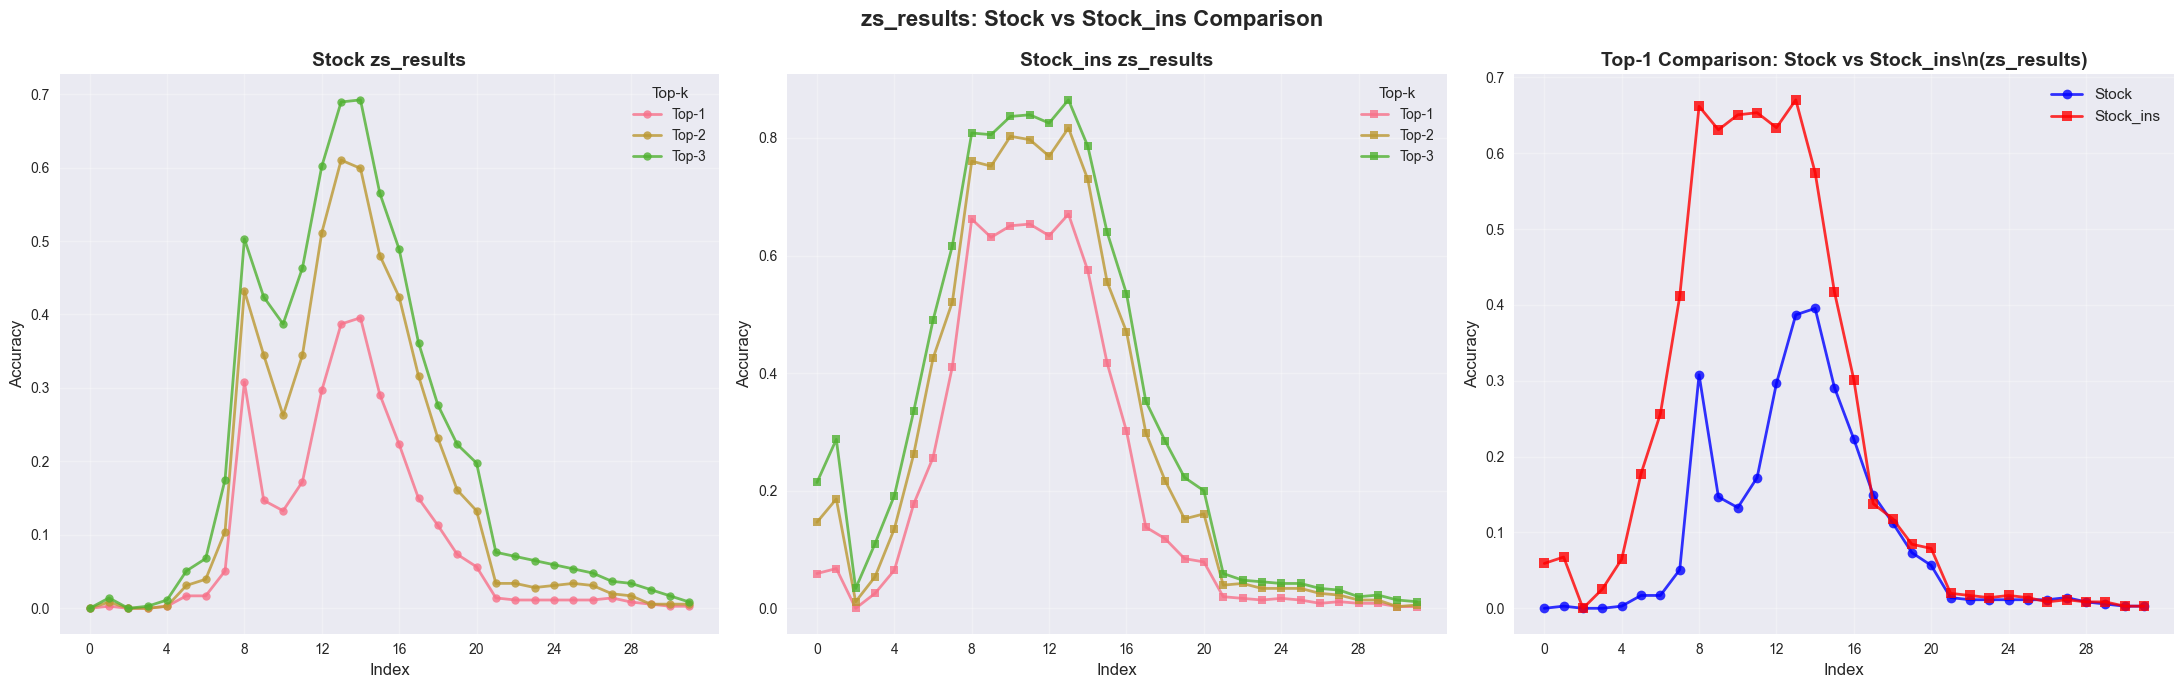

\nzs_results Statistics Comparison:
\nStock:
  Top-1: Mean=0.0919, Std=0.1232, Max=0.3955
  Top-2: Mean=0.1651, Std=0.2001, Max=0.6102
  Top-3: Mean=0.2090, Std=0.2296, Max=0.6921
\nStock_ins:
  Top-1: Mean=0.2125, Std=0.2550, Max=0.6704
  Top-2: Mean=0.2903, Std=0.3026, Max=0.8169
  Top-3: Mean=0.3327, Std=0.3176, Max=0.8648


In [44]:
# Compare stock vs stock_ins for zs_results
stock_zs_data = final_combined_df[final_combined_df['dataset'] == 'stock_zs_results']
stock_ins_zs_data = final_combined_df[final_combined_df['dataset'] == 'stock_ins_zs_results']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Plot 1: Stock zs_results
if not stock_zs_data.empty:
    ax1 = axes[0]
    for k_val in sorted(stock_zs_data['k'].unique()):
        k_data = stock_zs_data[stock_zs_data['k'] == k_val]
        ax1.plot(k_data['index'], k_data['accuracy'], 
                 marker='o', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax1.set_title('Stock zs_results', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 32, 4))
else:
    axes[0].text(0.5, 0.5, 'No stock zs_results data', ha='center', va='center', transform=axes[0].transAxes)

# Plot 2: Stock_ins zs_results
if not stock_ins_zs_data.empty:
    ax2 = axes[1]
    for k_val in sorted(stock_ins_zs_data['k'].unique()):
        k_data = stock_ins_zs_data[stock_ins_zs_data['k'] == k_val]
        ax2.plot(k_data['index'], k_data['accuracy'], 
                 marker='s', linewidth=2, markersize=6, 
                 label=f'Top-{k_val}', alpha=0.8)
    
    ax2.set_title('Stock_ins zs_results', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(title='Top-k', title_fontsize=11, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 32, 4))
else:
    axes[1].text(0.5, 0.5, 'No stock_ins zs_results data', ha='center', va='center', transform=axes[1].transAxes)

# Plot 3: Direct comparison of Top-1 accuracy
ax3 = axes[2]
if not stock_zs_data.empty and not stock_ins_zs_data.empty:
    stock_top1 = stock_zs_data[stock_zs_data['k'] == 1]
    stock_ins_top1 = stock_ins_zs_data[stock_ins_zs_data['k'] == 1]
    
    if not stock_top1.empty:
        ax3.plot(stock_top1['index'], stock_top1['accuracy'], 
                 marker='o', linewidth=2, label='Stock', alpha=0.8, color='blue')
    if not stock_ins_top1.empty:
        ax3.plot(stock_ins_top1['index'], stock_ins_top1['accuracy'], 
                 marker='s', linewidth=2, label='Stock_ins', alpha=0.8, color='red')
    
    ax3.set_title('Top-1 Comparison: Stock vs Stock_ins\\n(zs_results)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Index', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 32, 4))
else:
    ax3.text(0.5, 0.5, 'Cannot compare - missing data', ha='center', va='center', transform=ax3.transAxes)

plt.suptitle('zs_results: Stock vs Stock_ins Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics comparison
print("\\nzs_results Statistics Comparison:")
for dataset_name, data in [("Stock", stock_zs_data), ("Stock_ins", stock_ins_zs_data)]:
    if not data.empty:
        print(f"\\n{dataset_name}:")
        for k_val in sorted(data['k'].unique()):
            k_data = data[data['k'] == k_val]
            print(f"  Top-{k_val}: Mean={k_data['accuracy'].mean():.4f}, "
                  f"Std={k_data['accuracy'].std():.4f}, "
                  f"Max={k_data['accuracy'].max():.4f}")
    else:
        print(f"\\n{dataset_name}: No data available")

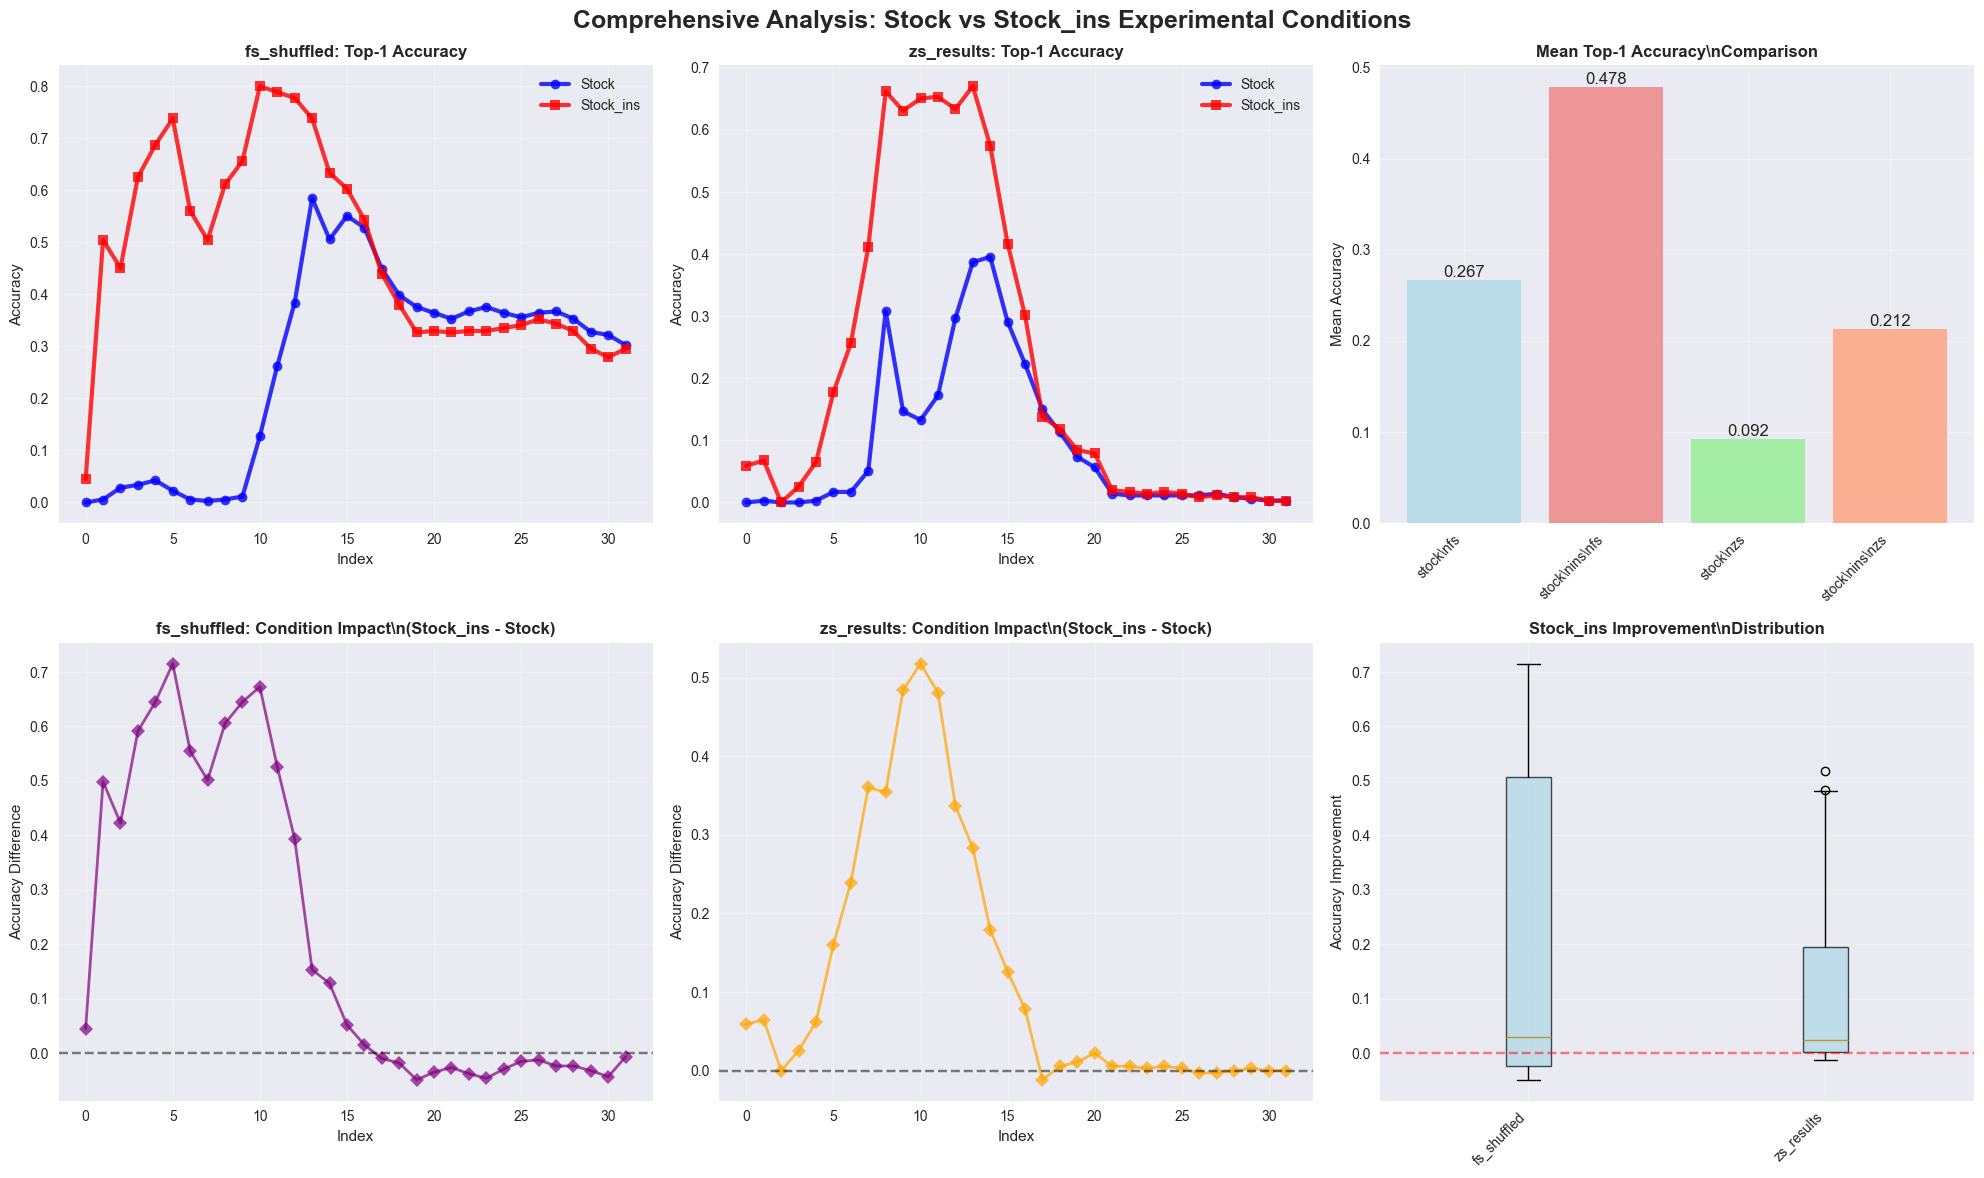

\nStock vs Stock_ins Impact Analysis (Top-1 Accuracy):
\nFS_SHUFFLED:
  Stock:     Mean=0.2669, Std=0.1906
  Stock_ins: Mean=0.4782, Std=0.1888
  Stock_ins Improvement: +0.2112 (+79.1%)
  Indices improved: 17/32 (53.1%)
  Indices worsened: 15/32 (46.9%)
  Indices unchanged: 0/32 (0.0%)
  Mean improvement per index: +0.2112
  Max improvement: +0.7154
  Max degradation: -0.0489
\nZS_RESULTS:
  Stock:     Mean=0.0919, Std=0.1232
  Stock_ins: Mean=0.2125, Std=0.2550
  Stock_ins Improvement: +0.1206 (+131.2%)
  Indices improved: 25/32 (78.1%)
  Indices worsened: 6/32 (18.8%)
  Indices unchanged: 1/32 (3.1%)
  Mean improvement per index: +0.1206
  Max improvement: +0.5179
  Max degradation: -0.0117
\n============================================================


In [45]:
# Comprehensive comparison: Stock vs Stock_ins
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Analysis: Stock vs Stock_ins Experimental Conditions', fontsize=18, fontweight='bold')

# Define stock vs stock_ins datasets
stock_comparison_datasets = {
    'stock_fs': stock_fs_data,
    'stock_ins_fs': stock_ins_fs_data,
    'stock_zs': stock_zs_data,
    'stock_ins_zs': stock_ins_zs_data
}

# Plot 1: Side-by-side Top-1 comparison for fs_shuffled
ax1 = axes[0, 0]
if not stock_fs_data.empty and not stock_ins_fs_data.empty:
    stock_fs_top1 = stock_fs_data[stock_fs_data['k'] == 1]
    stock_ins_fs_top1 = stock_ins_fs_data[stock_ins_fs_data['k'] == 1]
    
    if not stock_fs_top1.empty:
        ax1.plot(stock_fs_top1['index'], stock_fs_top1['accuracy'], 
                 marker='o', linewidth=3, label='Stock', alpha=0.8, color='blue')
    if not stock_ins_fs_top1.empty:
        ax1.plot(stock_ins_fs_top1['index'], stock_ins_fs_top1['accuracy'], 
                 marker='s', linewidth=3, label='Stock_ins', alpha=0.8, color='red')
    
    ax1.set_title('fs_shuffled: Top-1 Accuracy', fontweight='bold')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Side-by-side Top-1 comparison for zs_results
ax2 = axes[0, 1]
if not stock_zs_data.empty and not stock_ins_zs_data.empty:
    stock_zs_top1 = stock_zs_data[stock_zs_data['k'] == 1]
    stock_ins_zs_top1 = stock_ins_zs_data[stock_ins_zs_data['k'] == 1]
    
    if not stock_zs_top1.empty:
        ax2.plot(stock_zs_top1['index'], stock_zs_top1['accuracy'], 
                 marker='o', linewidth=3, label='Stock', alpha=0.8, color='blue')
    if not stock_ins_zs_top1.empty:
        ax2.plot(stock_ins_zs_top1['index'], stock_ins_zs_top1['accuracy'], 
                 marker='s', linewidth=3, label='Stock_ins', alpha=0.8, color='red')
    
    ax2.set_title('zs_results: Top-1 Accuracy', fontweight='bold')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Plot 3: Mean accuracy comparison bar chart
ax3 = axes[0, 2]
mean_accuracies = []
labels = []
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']

for i, (name, data) in enumerate(stock_comparison_datasets.items()):
    if not data.empty:
        top1_data = data[data['k'] == 1]
        if not top1_data.empty:
            mean_accuracies.append(top1_data['accuracy'].mean())
            labels.append(name.replace('_', '\\n'))

if mean_accuracies:
    bars = ax3.bar(range(len(mean_accuracies)), mean_accuracies, 
                   color=colors[:len(mean_accuracies)], alpha=0.8)
    ax3.set_title('Mean Top-1 Accuracy\\nComparison', fontweight='bold')
    ax3.set_ylabel('Mean Accuracy')
    ax3.set_xticks(range(len(labels)))
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

# Plot 4: Difference plot for fs_shuffled (Stock_ins - Stock)
ax4 = axes[1, 0]
if not stock_fs_data.empty and not stock_ins_fs_data.empty:
    stock_fs_top1 = stock_fs_data[stock_fs_data['k'] == 1]
    stock_ins_fs_top1 = stock_ins_fs_data[stock_ins_fs_data['k'] == 1]
    
    # Calculate differences
    common_indices = set(stock_fs_top1['index']).intersection(set(stock_ins_fs_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        stock_acc = stock_fs_top1[stock_fs_top1['index'] == idx]['accuracy'].iloc[0]
        stock_ins_acc = stock_ins_fs_top1[stock_ins_fs_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(stock_ins_acc - stock_acc)
        indices_list.append(idx)
    
    ax4.plot(indices_list, differences, marker='D', linewidth=2, 
             color='purple', alpha=0.7, label='Stock_ins - Stock')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('fs_shuffled: Condition Impact\\n(Stock_ins - Stock)', fontweight='bold')
    ax4.set_xlabel('Index')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)

# Plot 5: Difference plot for zs_results (Stock_ins - Stock)
ax5 = axes[1, 1]
if not stock_zs_data.empty and not stock_ins_zs_data.empty:
    stock_zs_top1 = stock_zs_data[stock_zs_data['k'] == 1]
    stock_ins_zs_top1 = stock_ins_zs_data[stock_ins_zs_data['k'] == 1]
    
    # Calculate differences
    common_indices = set(stock_zs_top1['index']).intersection(set(stock_ins_zs_top1['index']))
    differences = []
    indices_list = []
    
    for idx in sorted(common_indices):
        stock_acc = stock_zs_top1[stock_zs_top1['index'] == idx]['accuracy'].iloc[0]
        stock_ins_acc = stock_ins_zs_top1[stock_ins_zs_top1['index'] == idx]['accuracy'].iloc[0]
        differences.append(stock_ins_acc - stock_acc)
        indices_list.append(idx)
    
    ax5.plot(indices_list, differences, marker='D', linewidth=2, 
             color='orange', alpha=0.7, label='Stock_ins - Stock')
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('zs_results: Condition Impact\\n(Stock_ins - Stock)', fontweight='bold')
    ax5.set_xlabel('Index')
    ax5.set_ylabel('Accuracy Difference')
    ax5.grid(True, alpha=0.3)

# Plot 6: Overall improvement distribution
ax6 = axes[1, 2]
all_improvements = []
labels_improvements = []

# Collect all improvements
if not stock_fs_data.empty and not stock_ins_fs_data.empty:
    stock_fs_top1 = stock_fs_data[stock_fs_data['k'] == 1]
    stock_ins_fs_top1 = stock_ins_fs_data[stock_ins_fs_data['k'] == 1]
    common_indices = set(stock_fs_top1['index']).intersection(set(stock_ins_fs_top1['index']))
    
    fs_improvements = []
    for idx in sorted(common_indices):
        stock_acc = stock_fs_top1[stock_fs_top1['index'] == idx]['accuracy'].iloc[0]
        stock_ins_acc = stock_ins_fs_top1[stock_ins_fs_top1['index'] == idx]['accuracy'].iloc[0]
        fs_improvements.append(stock_ins_acc - stock_acc)
    
    all_improvements.extend(fs_improvements)
    labels_improvements.extend(['fs_shuffled'] * len(fs_improvements))

if not stock_zs_data.empty and not stock_ins_zs_data.empty:
    stock_zs_top1 = stock_zs_data[stock_zs_data['k'] == 1]
    stock_ins_zs_top1 = stock_ins_zs_data[stock_ins_zs_data['k'] == 1]
    common_indices = set(stock_zs_top1['index']).intersection(set(stock_ins_zs_top1['index']))
    
    zs_improvements = []
    for idx in sorted(common_indices):
        stock_acc = stock_zs_top1[stock_zs_top1['index'] == idx]['accuracy'].iloc[0]
        stock_ins_acc = stock_ins_zs_top1[stock_ins_zs_top1['index'] == idx]['accuracy'].iloc[0]
        zs_improvements.append(stock_ins_acc - stock_acc)
    
    all_improvements.extend(zs_improvements)
    labels_improvements.extend(['zs_results'] * len(zs_improvements))

if all_improvements:
    improvement_df = pd.DataFrame({
        'improvement': all_improvements,
        'dataset': labels_improvements
    })
    
    # Create box plot
    datasets_unique = improvement_df['dataset'].unique()
    positions = range(len(datasets_unique))
    
    box_data = [improvement_df[improvement_df['dataset'] == ds]['improvement'].values for ds in datasets_unique]
    box_plot = ax6.boxplot(box_data, positions=positions, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    ax6.set_title('Stock_ins Improvement\\nDistribution', fontweight='bold')
    ax6.set_ylabel('Accuracy Improvement')
    ax6.set_xticks(positions)
    ax6.set_xticklabels(datasets_unique, rotation=45, ha='right')
    ax6.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("\\nStock vs Stock_ins Impact Analysis (Top-1 Accuracy):")
print("="*60)

for dataset_type in ['fs_shuffled', 'zs_results']:
    stock_data = stock_comparison_datasets[f'stock_{dataset_type.split("_")[0]}']
    stock_ins_data = stock_comparison_datasets[f'stock_ins_{dataset_type.split("_")[0]}']
    
    if not stock_data.empty and not stock_ins_data.empty:
        stock_top1 = stock_data[stock_data['k'] == 1]
        stock_ins_top1 = stock_ins_data[stock_ins_data['k'] == 1]
        
        print(f"\\n{dataset_type.upper()}:")
        print(f"  Stock:     Mean={stock_top1['accuracy'].mean():.4f}, Std={stock_top1['accuracy'].std():.4f}")
        print(f"  Stock_ins: Mean={stock_ins_top1['accuracy'].mean():.4f}, Std={stock_ins_top1['accuracy'].std():.4f}")
        
        # Calculate improvement
        improvement = stock_ins_top1['accuracy'].mean() - stock_top1['accuracy'].mean()
        print(f"  Stock_ins Improvement: {improvement:+.4f} ({improvement/stock_top1['accuracy'].mean()*100:+.1f}%)")
        
        # Calculate per-index improvements
        common_indices = set(stock_top1['index']).intersection(set(stock_ins_top1['index']))
        improvements = []
        for idx in sorted(common_indices):
            stock_acc = stock_top1[stock_top1['index'] == idx]['accuracy'].iloc[0]
            stock_ins_acc = stock_ins_top1[stock_ins_top1['index'] == idx]['accuracy'].iloc[0]
            improvements.append(stock_ins_acc - stock_acc)
        
        if improvements:
            positive_improvements = sum(1 for imp in improvements if imp > 0)
            negative_improvements = sum(1 for imp in improvements if imp < 0)
            no_change = sum(1 for imp in improvements if imp == 0)
            
            print(f"  Indices improved: {positive_improvements}/{len(improvements)} ({positive_improvements/len(improvements)*100:.1f}%)")
            print(f"  Indices worsened: {negative_improvements}/{len(improvements)} ({negative_improvements/len(improvements)*100:.1f}%)")
            print(f"  Indices unchanged: {no_change}/{len(improvements)} ({no_change/len(improvements)*100:.1f}%)")
            print(f"  Mean improvement per index: {np.mean(improvements):+.4f}")
            print(f"  Max improvement: {np.max(improvements):+.4f}")
            print(f"  Max degradation: {np.min(improvements):+.4f}")

print("\\n" + "="*60)

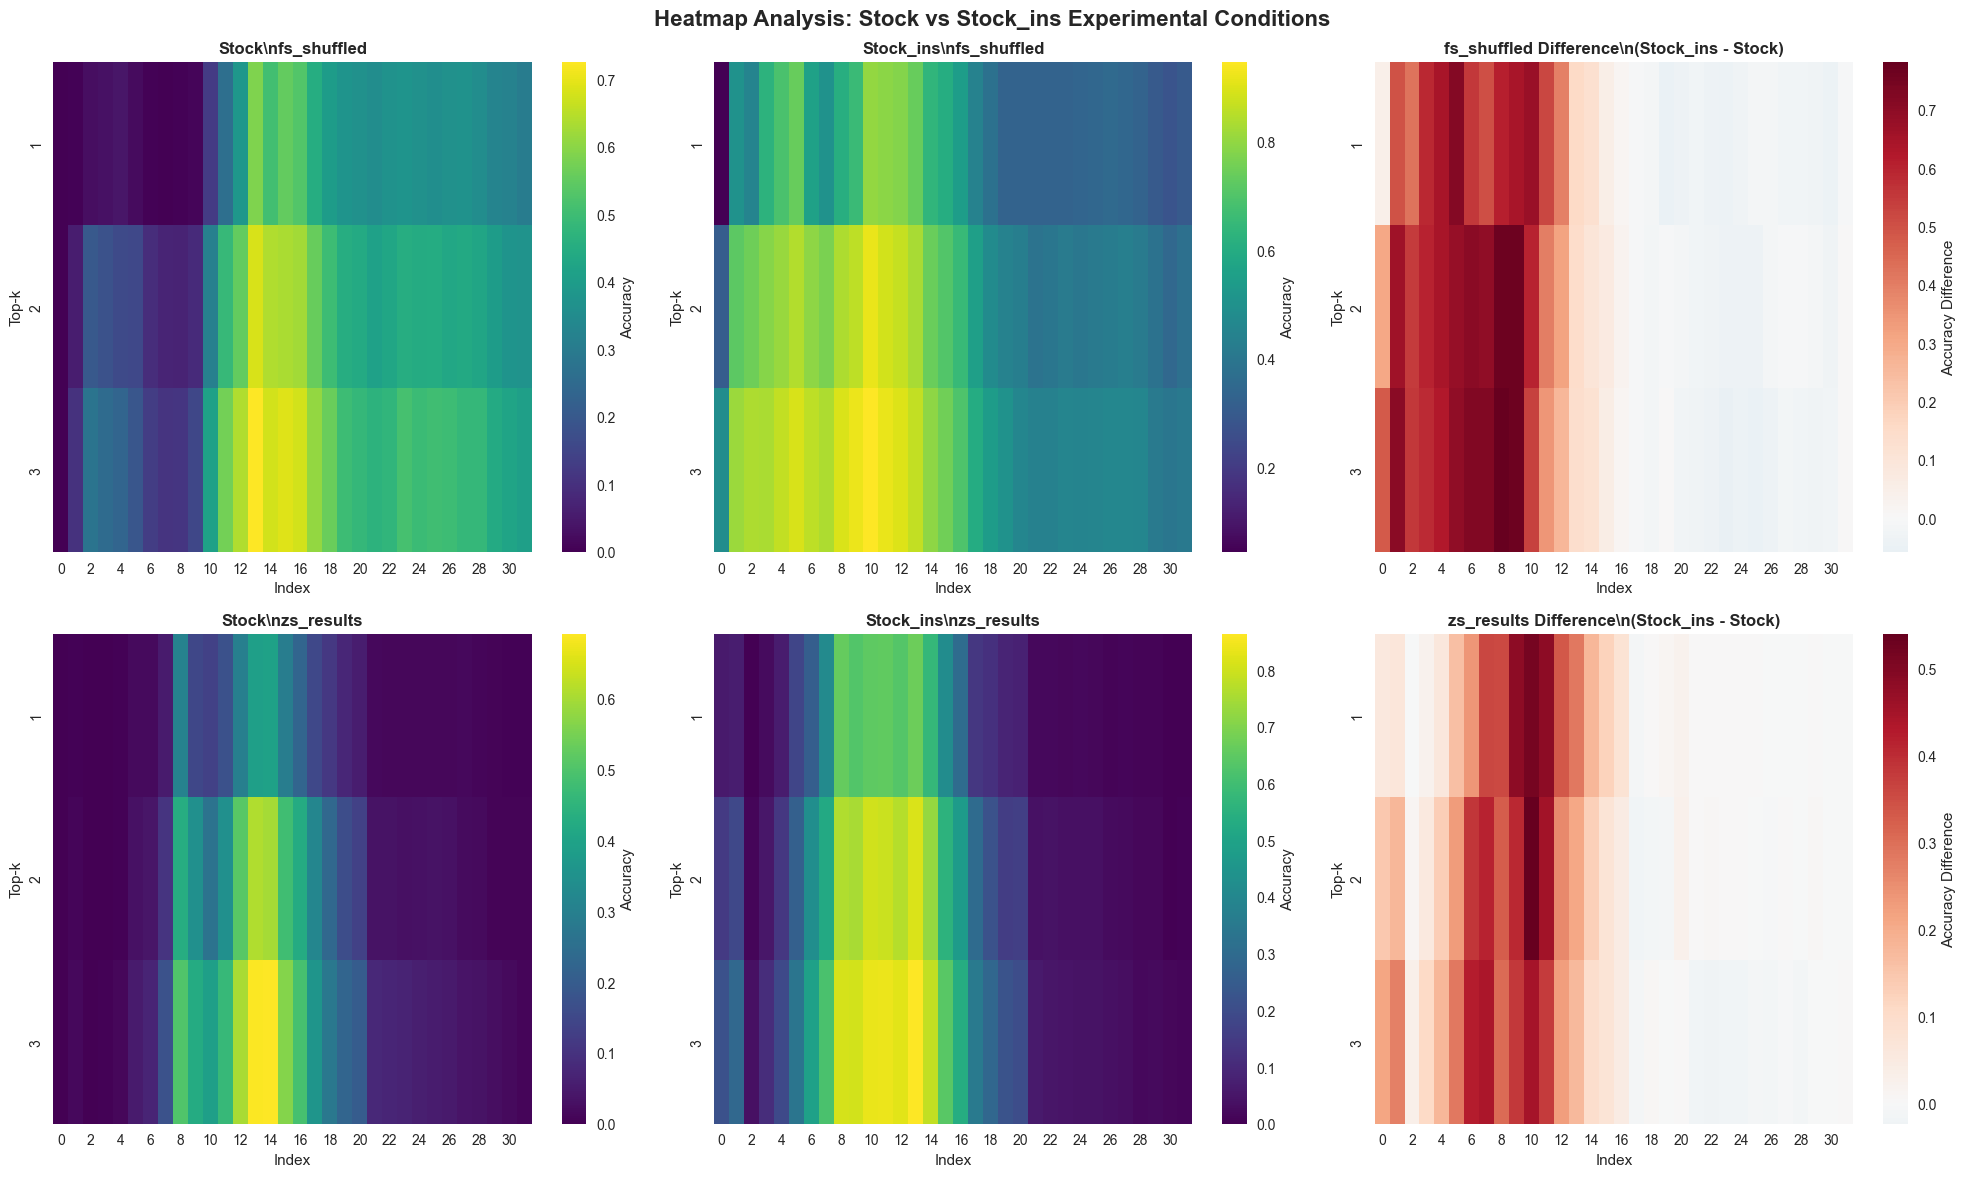

\nSUMMARY: Stock vs Stock_ins Experimental Conditions Impact
\nThis analysis compares the intervention_topk accuracy between:
• Stock: Standard experimental conditions
• Stock_ins: Modified experimental conditions (stock_ins)
\nKey insights:
• Overall, stock_ins improved performance in 2/2 dataset types
• Average improvement across datasets: +0.1659
• Stock_ins conditions show POSITIVE impact on antonym task performance
\n=======================================================


In [46]:
# Heatmap comparison: Stock vs Stock_ins
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Heatmap Analysis: Stock vs Stock_ins Experimental Conditions', fontsize=16, fontweight='bold')

# Create heatmaps for stock vs stock_ins
heatmap_datasets = [
    (stock_fs_data, 'Stock\\nfs_shuffled', (0, 0)),
    (stock_ins_fs_data, 'Stock_ins\\nfs_shuffled', (0, 1)),
    (stock_zs_data, 'Stock\\nzs_results', (1, 0)),
    (stock_ins_zs_data, 'Stock_ins\\nzs_results', (1, 1))
]

# Create individual heatmaps
for data, title, (row, col) in heatmap_datasets:
    ax = axes[row, col]
    
    if not data.empty:
        heatmap_data = create_heatmap_data(data)
        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, ax=ax, cmap='viridis', 
                       cbar_kws={'label': 'Accuracy'}, 
                       annot=False, fmt='.3f')
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', 
                   transform=ax.transAxes)
            ax.set_title(f'{title}\\n(No Data)')
    else:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
               transform=ax.transAxes)
        ax.set_title(f'{title}\\n(No Data)')

# Create difference heatmaps
# fs_shuffled difference
ax = axes[0, 2]
if not stock_fs_data.empty and not stock_ins_fs_data.empty:
    stock_hm = create_heatmap_data(stock_fs_data)
    stock_ins_hm = create_heatmap_data(stock_ins_fs_data)
    
    if not stock_hm.empty and not stock_ins_hm.empty:
        # Align indices and k values
        common_indices = stock_hm.columns.intersection(stock_ins_hm.columns)
        common_k = stock_hm.index.intersection(stock_ins_hm.index)
        
        if len(common_indices) > 0 and len(common_k) > 0:
            diff_hm_fs = stock_ins_hm.loc[common_k, common_indices] - stock_hm.loc[common_k, common_indices]
            
            sns.heatmap(diff_hm_fs, ax=ax, cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Accuracy Difference'})
            ax.set_title('fs_shuffled Difference\\n(Stock_ins - Stock)', fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'Cannot create difference heatmap', ha='center', va='center', 
                   transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'Insufficient data for difference', ha='center', va='center', 
               transform=ax.transAxes)
else:
    ax.text(0.5, 0.5, 'No data for comparison', ha='center', va='center', 
           transform=ax.transAxes)

# zs_results difference
ax = axes[1, 2]
if not stock_zs_data.empty and not stock_ins_zs_data.empty:
    stock_hm = create_heatmap_data(stock_zs_data)
    stock_ins_hm = create_heatmap_data(stock_ins_zs_data)
    
    if not stock_hm.empty and not stock_ins_hm.empty:
        # Align indices and k values
        common_indices = stock_hm.columns.intersection(stock_ins_hm.columns)
        common_k = stock_hm.index.intersection(stock_ins_hm.index)
        
        if len(common_indices) > 0 and len(common_k) > 0:
            diff_hm_zs = stock_ins_hm.loc[common_k, common_indices] - stock_hm.loc[common_k, common_indices]
            
            sns.heatmap(diff_hm_zs, ax=ax, cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Accuracy Difference'})
            ax.set_title('zs_results Difference\\n(Stock_ins - Stock)', fontweight='bold')
            ax.set_xlabel('Index')
            ax.set_ylabel('Top-k')
        else:
            ax.text(0.5, 0.5, 'Cannot create difference heatmap', ha='center', va='center', 
                   transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'Insufficient data for difference', ha='center', va='center', 
               transform=ax.transAxes)
else:
    ax.text(0.5, 0.5, 'No data for comparison', ha='center', va='center', 
           transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Summary of Stock_ins impact
print("\\nSUMMARY: Stock vs Stock_ins Experimental Conditions Impact")
print("="*55)
print("\\nThis analysis compares the intervention_topk accuracy between:")
print("• Stock: Standard experimental conditions")
print("• Stock_ins: Modified experimental conditions (stock_ins)")
print("\\nKey insights:")

# Calculate overall statistics
total_improvements = 0
total_comparisons = 0
overall_improvement = 0

for dataset_type in ['fs', 'zs']:
    stock_key = f'stock_{dataset_type}'
    stock_ins_key = f'stock_ins_{dataset_type}'
    
    if stock_key in stock_comparison_datasets and stock_ins_key in stock_comparison_datasets:
        stock_data = stock_comparison_datasets[stock_key]
        stock_ins_data = stock_comparison_datasets[stock_ins_key]
        
        if not stock_data.empty and not stock_ins_data.empty:
            stock_top1 = stock_data[stock_data['k'] == 1]
            stock_ins_top1 = stock_ins_data[stock_ins_data['k'] == 1]
            
            improvement = stock_ins_top1['accuracy'].mean() - stock_top1['accuracy'].mean()
            overall_improvement += improvement
            
            if improvement > 0:
                total_improvements += 1
            total_comparisons += 1

if total_comparisons > 0:
    print(f"• Overall, stock_ins improved performance in {total_improvements}/{total_comparisons} dataset types")
    print(f"• Average improvement across datasets: {overall_improvement/total_comparisons:+.4f}")
    
    if overall_improvement > 0:
        print("• Stock_ins conditions show POSITIVE impact on antonym task performance")
    elif overall_improvement < 0:
        print("• Stock_ins conditions show NEGATIVE impact on antonym task performance") 
    else:
        print("• Stock_ins conditions show NO significant impact on antonym task performance")
else:
    print("• Unable to calculate overall impact due to missing data")

print("\\n" + "="*55)

# Country-Capital Task: Stock vs Stock_ins vs Reasoning Comparison

This section compares intervention_topk results across three different experimental conditions for the country-capital task:
- **Stock**: Standard experimental setup
- **Stock_ins**: Stock with instruction modifications  
- **Reasoning**: Reasoning-based experimental setup

We will analyze both fs_shuffled_results and zs_results across all three conditions to understand how different experimental setups affect the intervention effectiveness.

In [54]:
# Load country-capital data from all three directories
country_capital_datasets = {}
country_capital_base_paths = {
    'stock': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock/country-capital'),
    'stock_ins': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins/country-capital'),  
    'reasoning': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/country-capital')
}

country_capital_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json',
    'model_baseline_no_rank_list.json'
]

# Extract data for each dataset
country_capital_extracted = {}
for dataset_name, base_path in country_capital_base_paths.items():
    country_capital_extracted[dataset_name] = {}
    print(f"\nLoading {dataset_name} country-capital data...")
    
    for file_name in country_capital_file_names:
        no_rank_file_path = base_path / file_name
        original_file_name = file_name.replace('_no_rank_list', '')
        original_file_path = base_path / original_file_name
        
        # Choose which file to load
        file_to_load = no_rank_file_path if no_rank_file_path.exists() else original_file_path
        
        if file_to_load.exists():
            try:
                with open(file_to_load, 'r') as f:
                    data = json.load(f)
                country_capital_extracted[dataset_name][original_file_name] = data
                print(f"  ✓ Loaded {file_to_load.name}")
            except Exception as e:
                print(f"  ✗ Error loading {file_to_load.name}: {e}")
        else:
            print(f"  ✗ File not found: {file_to_load.name}")

print(f"\nCountry-capital datasets loaded: {list(country_capital_extracted.keys())}")


Loading stock country-capital data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Loading stock_ins country-capital data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Loading reasoning country-capital data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Country-capital datasets loaded: ['stock', 'stock_ins', 'reasoning']


In [58]:
# Create DataFrames for country-capital analysis
# Country-capital data has a different structure: each layer index (0-31) contains intervention_topk as a list of [k, accuracy] pairs
country_capital_dataframes = []

print("=== Processing Country-Capital Data ===")

for dataset_name, data_dict in country_capital_extracted.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    for file_name, data in data_dict.items():
        if isinstance(data, dict):
            print(f"  Processing file: {file_name}")
            
            # Only process fs_shuffled_results and zs_results (skip model_baseline for now)
            if 'fs_shuffled_results' in file_name or 'zs_results' in file_name:
                for layer_idx, layer_data in data.items():
                    if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                        intervention_list = layer_data['intervention_topk']
                        
                        # intervention_topk is a list of [k, accuracy] pairs
                        if isinstance(intervention_list, list):
                            for k_acc_pair in intervention_list:
                                if isinstance(k_acc_pair, list) and len(k_acc_pair) == 2:
                                    k_val, accuracy = k_acc_pair
                                    country_capital_dataframes.append({
                                        'dataset': dataset_name,
                                        'file_type': file_name.replace('.json', '').replace('_layer_sweep', ''),
                                        'k': int(k_val),
                                        'index': int(layer_idx),
                                        'accuracy': float(accuracy)
                                    })

# Convert to DataFrame
country_capital_combined = pd.DataFrame(country_capital_dataframes)
print(f"\n=== Country-Capital Combined Dataset ===")
print(f"Shape: {country_capital_combined.shape}")

if not country_capital_combined.empty:
    print(f"Datasets: {country_capital_combined['dataset'].unique()}")
    print(f"File types: {country_capital_combined['file_type'].unique()}")
    print(f"K values range: {country_capital_combined['k'].min()} to {country_capital_combined['k'].max()}")
    print(f"Index range: {country_capital_combined['index'].min()} to {country_capital_combined['index'].max()}")
    
    # Display sample data
    print("\nSample data:")
    print(country_capital_combined.head(10))
else:
    print("No data found in country_capital_combined DataFrame!")
    print(f"Number of raw entries: {len(country_capital_dataframes)}")

=== Processing Country-Capital Data ===

Processing dataset: stock
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

Processing dataset: stock_ins
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

Processing dataset: reasoning
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

=== Country-Capital Combined Dataset ===
Shape: (576, 5)
Datasets: ['stock' 'stock_ins' 'reasoning']
File types: ['fs_shuffled_results' 'zs_results']
K values range: 1 to 3
Index range: 0 to 31

Sample data:
  dataset            file_type  k  index  accuracy
0   stock  fs_shuffled_results  1      0  0.333333
1   stock  fs_shuffled_results  2      0  0.404762
2   stock  fs_shuffled_results  3      0  0.428571
3   stock  fs_shuffled_results  

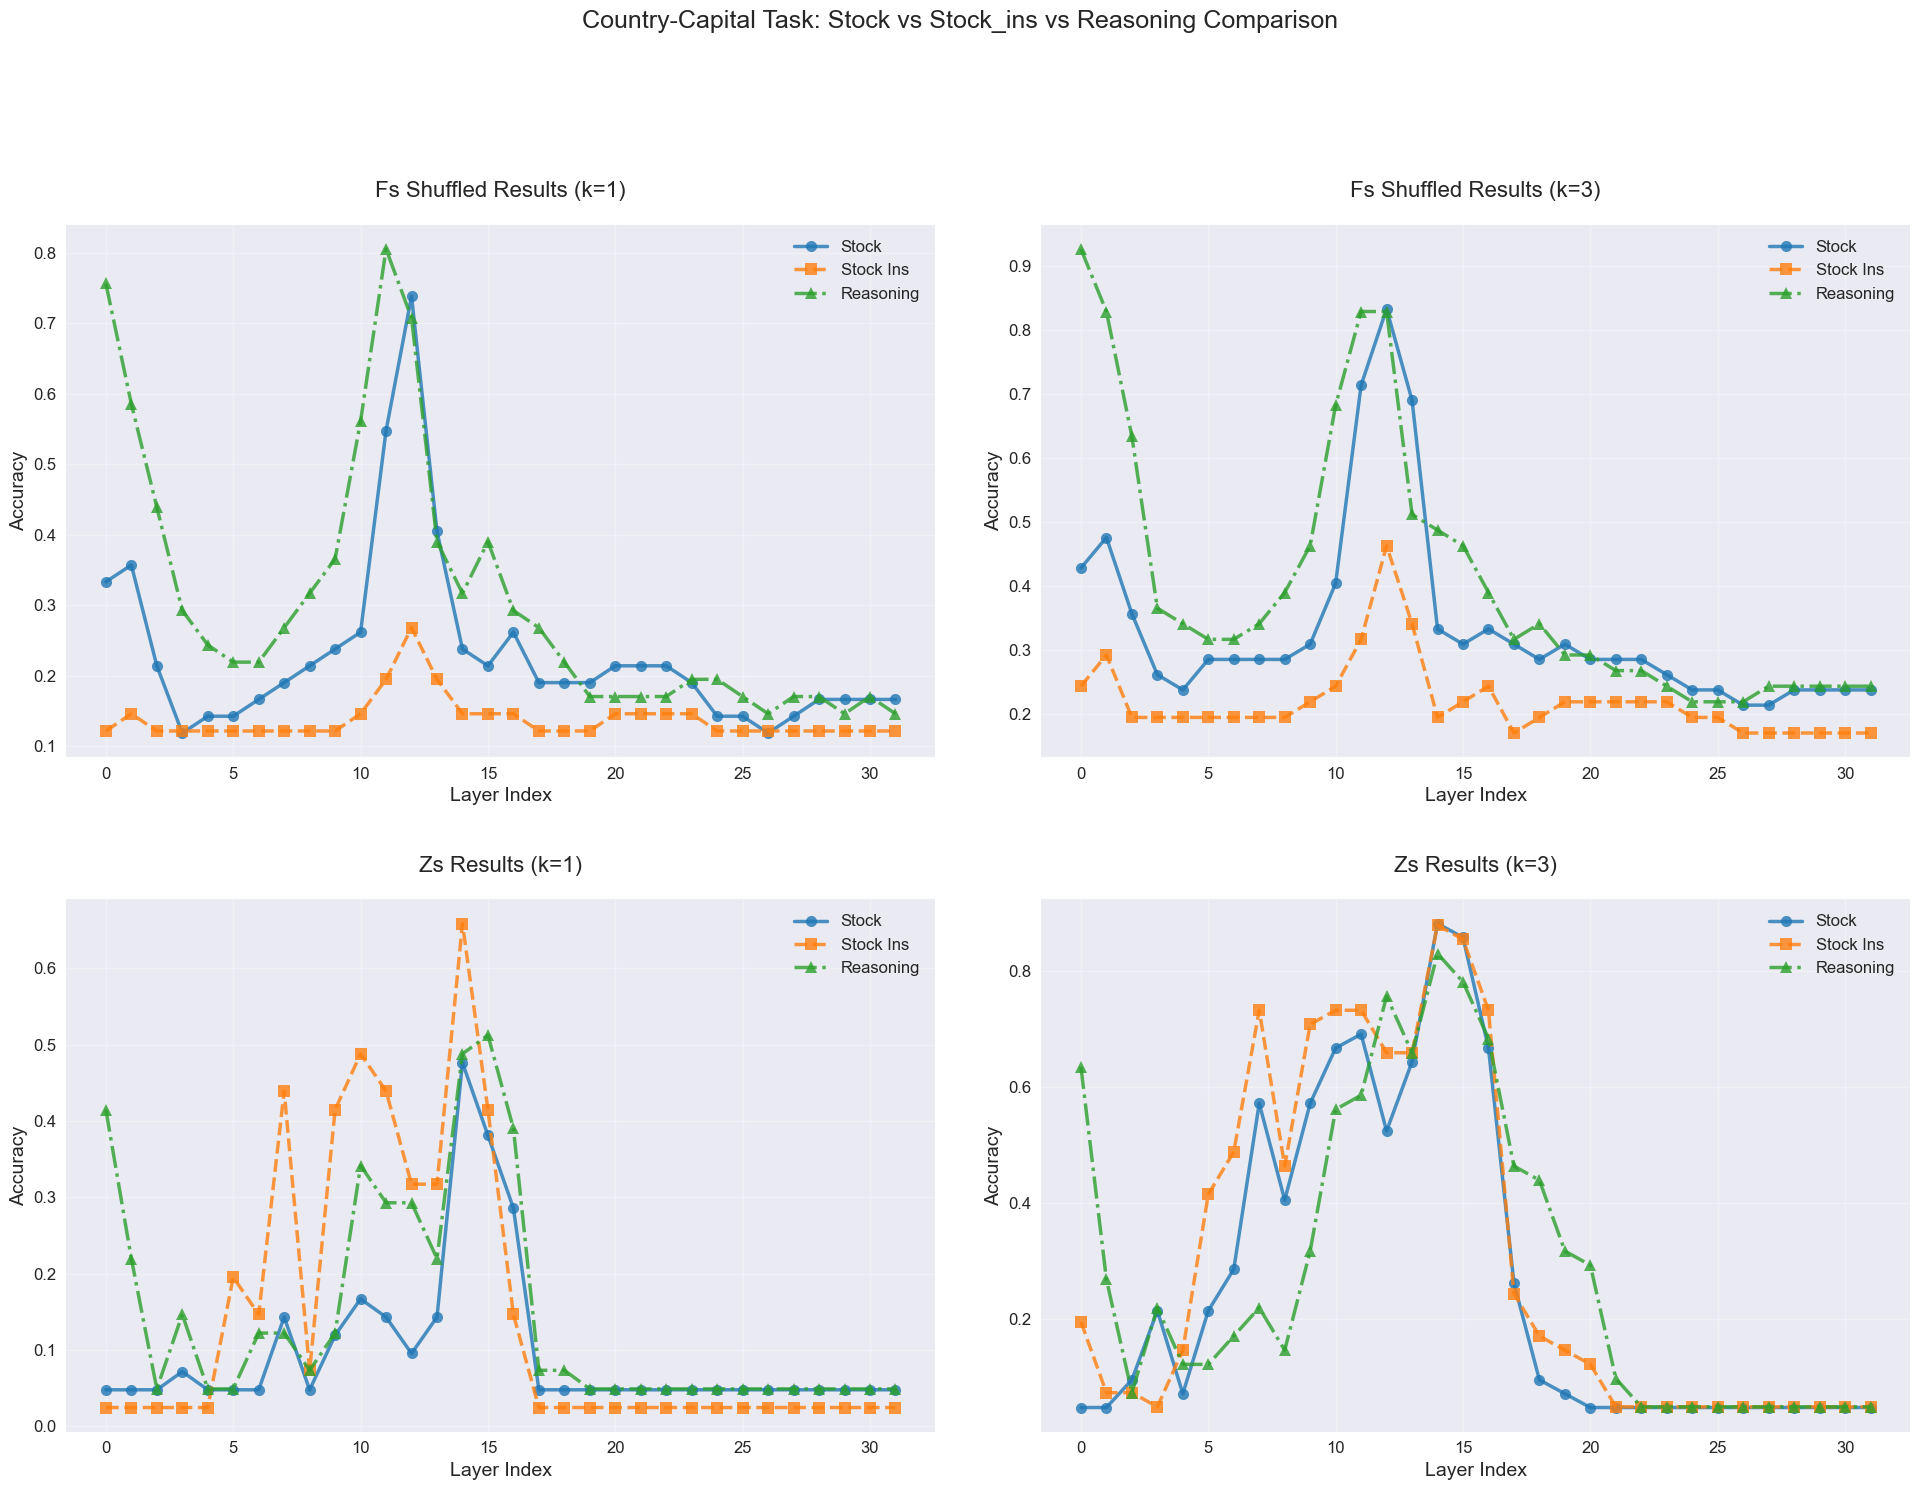

In [60]:
# Line plots for country-capital task - Stock vs Stock_ins vs Reasoning
# Using larger figure size and better spacing to avoid clustering

fig, axes = plt.subplots(2, 2, figsize=(20, 16))  # Increased figure size significantly
fig.suptitle('Country-Capital Task: Stock vs Stock_ins vs Reasoning Comparison', fontsize=18, y=0.98)

# Colors for each dataset
colors = {'stock': '#1f77b4', 'stock_ins': '#ff7f0e', 'reasoning': '#2ca02c'}
markers = {'stock': 'o', 'stock_ins': 's', 'reasoning': '^'}
linestyles = {'stock': '-', 'stock_ins': '--', 'reasoning': '-.'}

# Plot for each file type and k=1, k=3 (since country-capital only goes up to k=3)
for idx, (file_type, ax_row) in enumerate(zip(['fs_shuffled_results', 'zs_results'], [0, 1])):
    
    # K=1 plots
    ax = axes[ax_row, 0]
    for dataset in ['stock', 'stock_ins', 'reasoning']:
        if dataset in country_capital_combined['dataset'].unique():
            data = country_capital_combined[
                (country_capital_combined['dataset'] == dataset) & 
                (country_capital_combined['file_type'] == file_type) &
                (country_capital_combined['k'] == 1)
            ].sort_values('index')
            
            if not data.empty:
                ax.plot(data['index'], data['accuracy'], 
                       color=colors[dataset], marker=markers[dataset], 
                       linestyle=linestyles[dataset], linewidth=2.5, markersize=8,
                       label=f'{dataset.replace("_", " ").title()}', alpha=0.8)
    
    ax.set_xlabel('Layer Index', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title(f'{file_type.replace("_", " ").title()} (k=1)', fontsize=16, pad=20)
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    # K=3 plots (max k for country-capital task)
    ax = axes[ax_row, 1]
    for dataset in ['stock', 'stock_ins', 'reasoning']:
        if dataset in country_capital_combined['dataset'].unique():
            data = country_capital_combined[
                (country_capital_combined['dataset'] == dataset) & 
                (country_capital_combined['file_type'] == file_type) &
                (country_capital_combined['k'] == 3)
            ].sort_values('index')
            
            if not data.empty:
                ax.plot(data['index'], data['accuracy'], 
                       color=colors[dataset], marker=markers[dataset],
                       linestyle=linestyles[dataset], linewidth=2.5, markersize=8,
                       label=f'{dataset.replace("_", " ").title()}', alpha=0.8)
    
    ax.set_xlabel('Layer Index', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title(f'{file_type.replace("_", " ").title()} (k=3)', fontsize=16, pad=20)
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=3.0)  # Better spacing
plt.show()

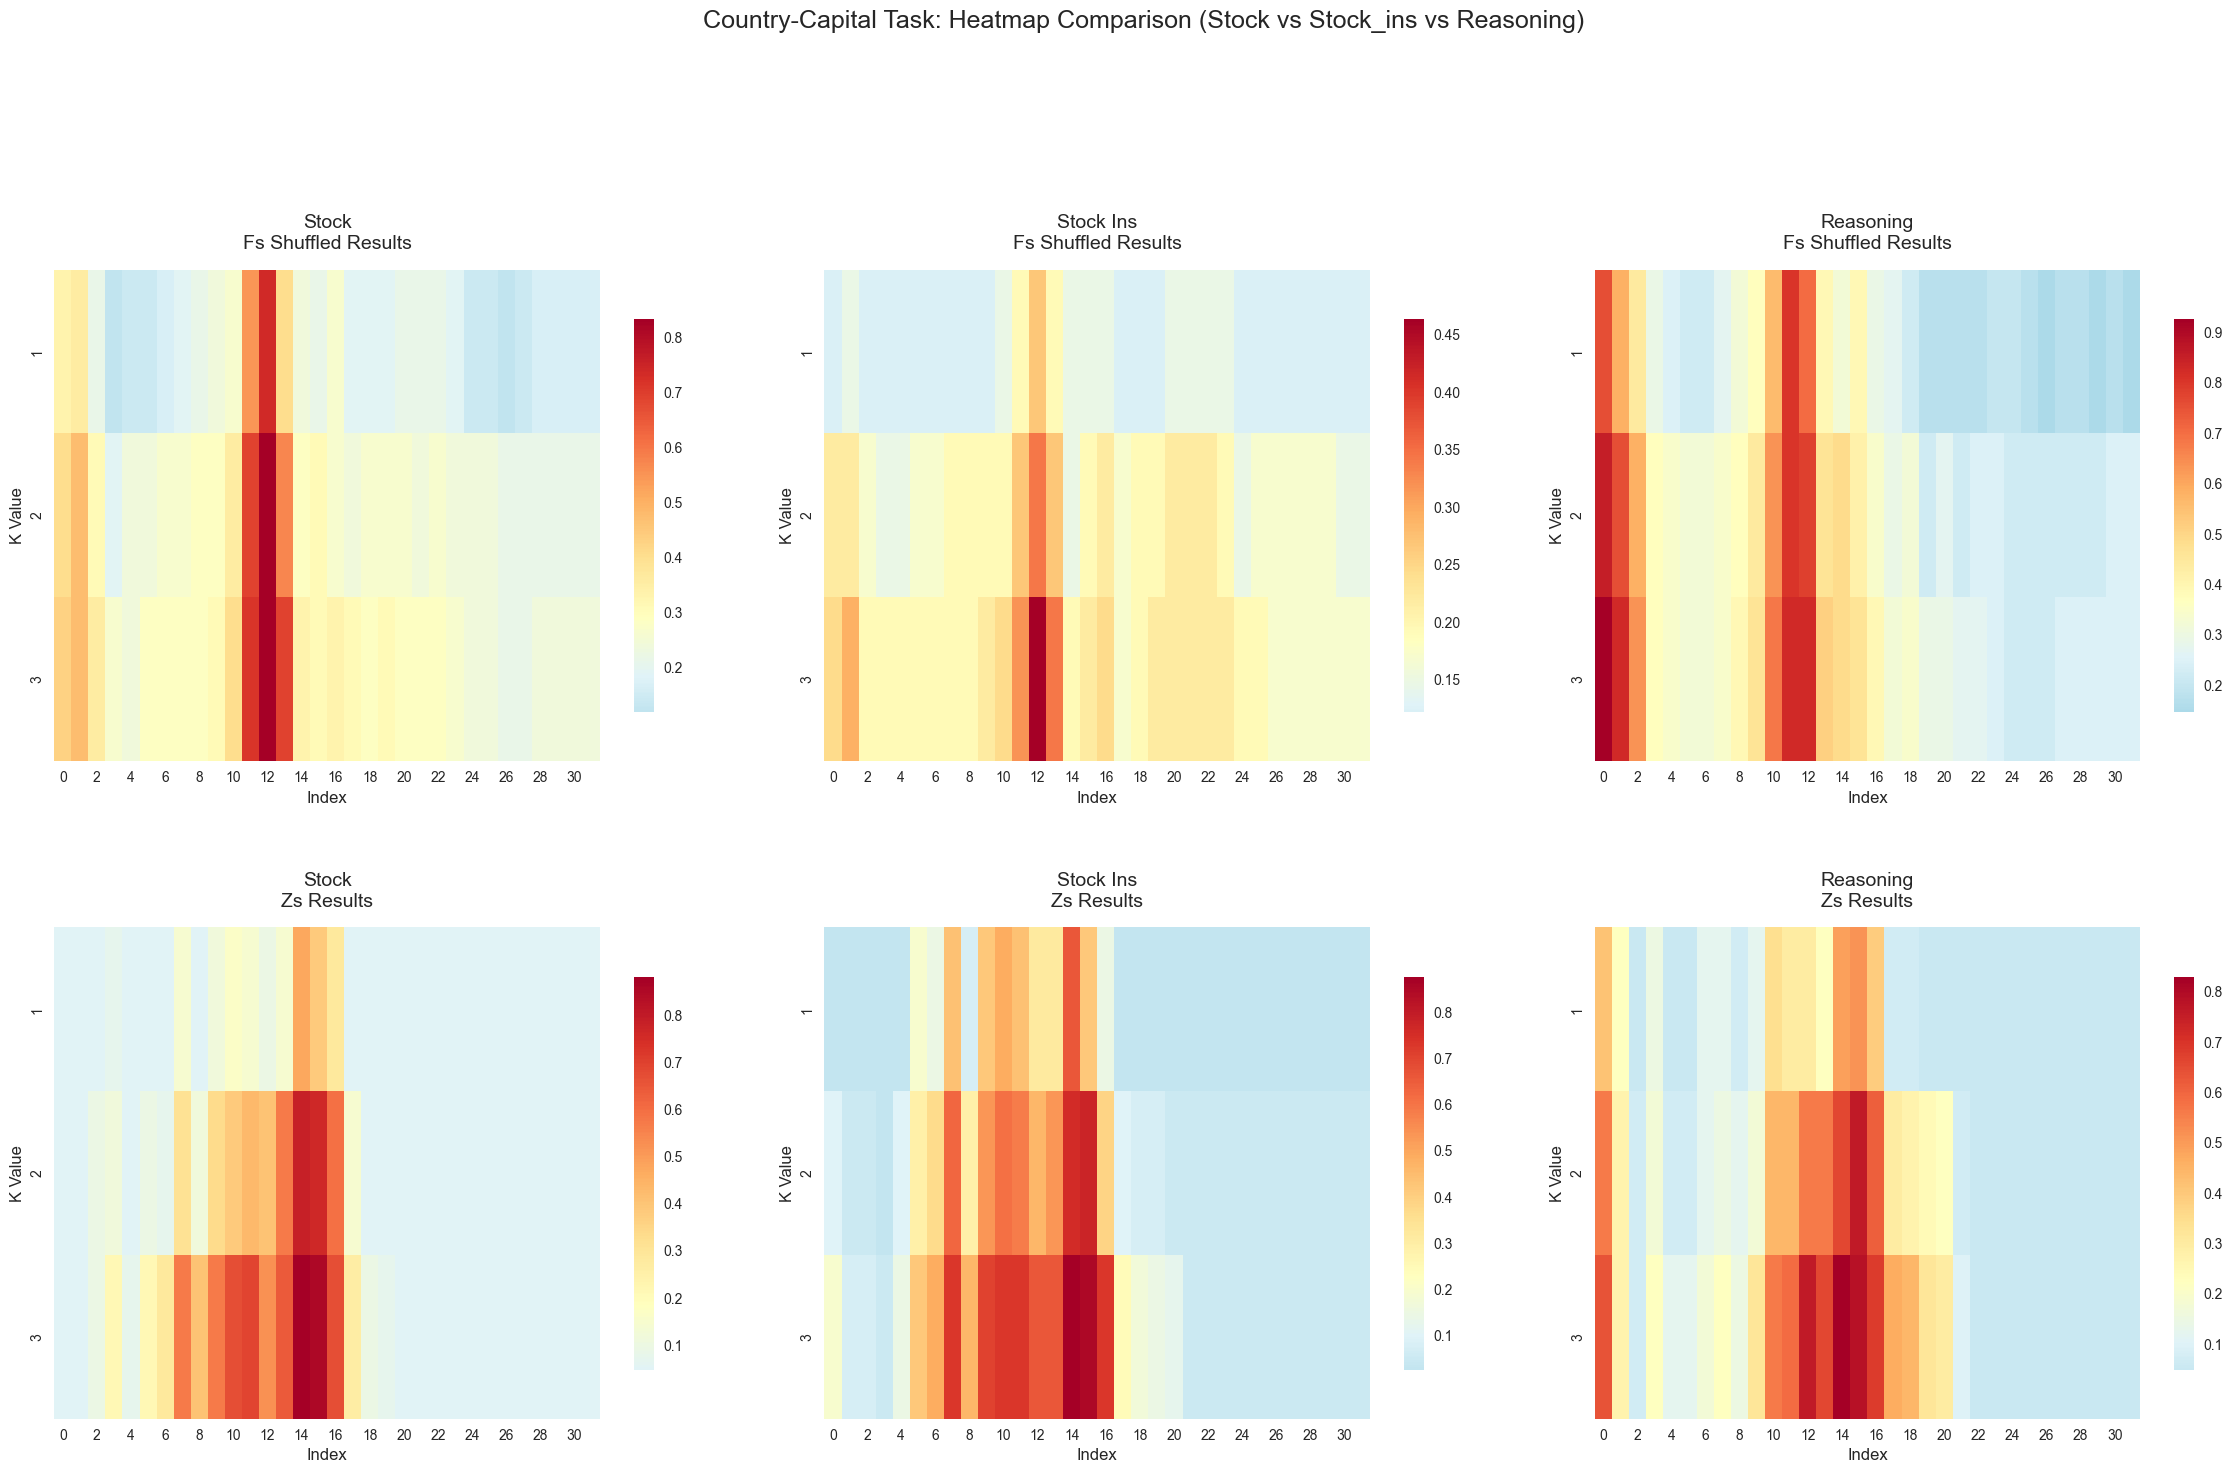

In [61]:
# Heatmap comparison for Country-Capital task
# Create heatmaps for better visualization with improved spacing

fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # Large figure size for clarity
fig.suptitle('Country-Capital Task: Heatmap Comparison (Stock vs Stock_ins vs Reasoning)', fontsize=18, y=0.98)

file_types = ['fs_shuffled_results', 'zs_results']
datasets = ['stock', 'stock_ins', 'reasoning']

for row_idx, file_type in enumerate(file_types):
    for col_idx, dataset in enumerate(datasets):
        ax = axes[row_idx, col_idx]
        
        # Filter data for this combination
        data = country_capital_combined[
            (country_capital_combined['dataset'] == dataset) & 
            (country_capital_combined['file_type'] == file_type)
        ]
        
        if not data.empty:
            # Create pivot table for heatmap
            heatmap_data = data.pivot_table(
                values='accuracy', 
                index='k', 
                columns='index', 
                aggfunc='mean'
            )
            
            # Create heatmap
            sns.heatmap(heatmap_data, 
                       annot=False,  # Remove annotations for cleaner look
                       cmap='RdYlBu_r', 
                       center=heatmap_data.mean().mean(),
                       ax=ax,
                       cbar_kws={'shrink': 0.8})
            
            ax.set_title(f'{dataset.replace("_", " ").title()}\n{file_type.replace("_", " ").title()}', 
                        fontsize=14, pad=15)
            ax.set_xlabel('Index', fontsize=12)
            ax.set_ylabel('K Value', fontsize=12)
            ax.tick_params(labelsize=10)
        else:
            ax.text(0.5, 0.5, 'No Data Available', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='red')
            ax.set_title(f'{dataset.replace("_", " ").title()}\n{file_type.replace("_", " ").title()}', 
                        fontsize=14, pad=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0)  # Extra padding for better spacing
plt.show()

=== Country-Capital Task: Statistical Analysis ===

Mean accuracies by dataset and file type:
                                 mean     std  count
dataset   file_type                                 
reasoning fs_shuffled_results  0.3656  0.1978     96
          zs_results           0.2221  0.2201     96
stock     fs_shuffled_results  0.2907  0.1459     96
          zs_results           0.1828  0.2244     96
stock_ins fs_shuffled_results  0.1834  0.0571     96
          zs_results           0.2264  0.2566     96


--- Fs Shuffled Results Analysis ---

K=1 comparison:
             mean     std
dataset                  
reasoning  0.3079  0.1856
stock      0.2314  0.1283
stock_ins  0.1380  0.0307
  reasoning vs stock: +0.0765
  reasoning vs stock_ins: +0.1699
  stock vs stock_ins: +0.0934

K=2 comparison:
             mean     std
dataset                  
reasoning  0.3819  0.1929
stock      0.3058  0.1447
stock_ins  0.1928  0.0422
  reasoning vs stock: +0.0761
  reasoning vs stock_ins:

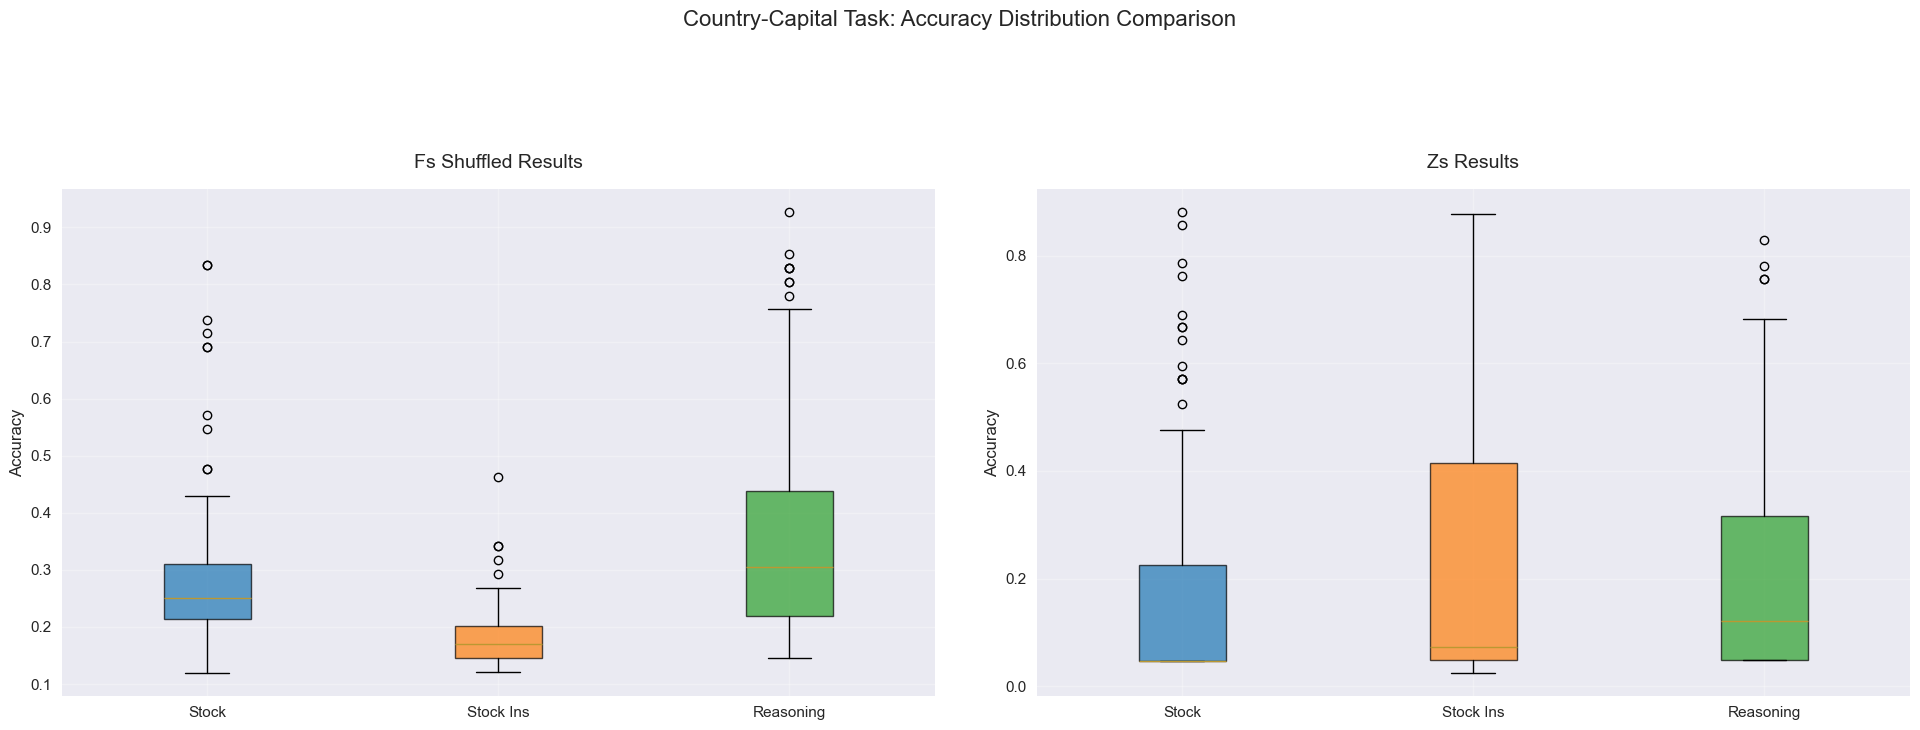

In [63]:
# Statistical Analysis for Country-Capital Task
print("=== Country-Capital Task: Statistical Analysis ===\n")

# Calculate mean accuracies for each dataset and file type
country_capital_stats = country_capital_combined.groupby(['dataset', 'file_type'])['accuracy'].agg(['mean', 'std', 'count']).round(4)
print("Mean accuracies by dataset and file type:")
print(country_capital_stats)
print()

# Compare specific k values across datasets (use 1, 2, 3 for country-capital)
for file_type in ['fs_shuffled_results', 'zs_results']:
    print(f"\n--- {file_type.replace('_', ' ').title()} Analysis ---")
    
    for k_val in [1, 2, 3]:  # Country-capital only has k=1,2,3
        data_subset = country_capital_combined[
            (country_capital_combined['file_type'] == file_type) & 
            (country_capital_combined['k'] == k_val)
        ]
        
        if not data_subset.empty:
            print(f"\nK={k_val} comparison:")
            k_stats = data_subset.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
            print(k_stats)
            
            # Calculate performance differences
            if len(k_stats) >= 2:
                datasets_available = k_stats.index.tolist()
                for i in range(len(datasets_available)):
                    for j in range(i+1, len(datasets_available)):
                        ds1, ds2 = datasets_available[i], datasets_available[j]
                        diff = k_stats.loc[ds1, 'mean'] - k_stats.loc[ds2, 'mean']
                        print(f"  {ds1} vs {ds2}: {diff:+.4f}")

# Box plots for distribution comparison with better spacing
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Wider figure for better spacing
fig.suptitle('Country-Capital Task: Accuracy Distribution Comparison', fontsize=16, y=0.98)

for idx, file_type in enumerate(['fs_shuffled_results', 'zs_results']):
    ax = axes[idx]
    
    # Prepare data for box plot
    plot_data = []
    labels = []
    
    for dataset in ['stock', 'stock_ins', 'reasoning']:
        data = country_capital_combined[
            (country_capital_combined['dataset'] == dataset) & 
            (country_capital_combined['file_type'] == file_type)
        ]['accuracy']
        
        if not data.empty:
            plot_data.append(data.values)
            labels.append(dataset.replace('_', ' ').title())
    
    if plot_data:
        box_plot = ax.boxplot(plot_data, tick_labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        for patch, color in zip(box_plot['boxes'], colors[:len(plot_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{file_type.replace("_", " ").title()}', fontsize=14, pad=15)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=3.0)
plt.show()

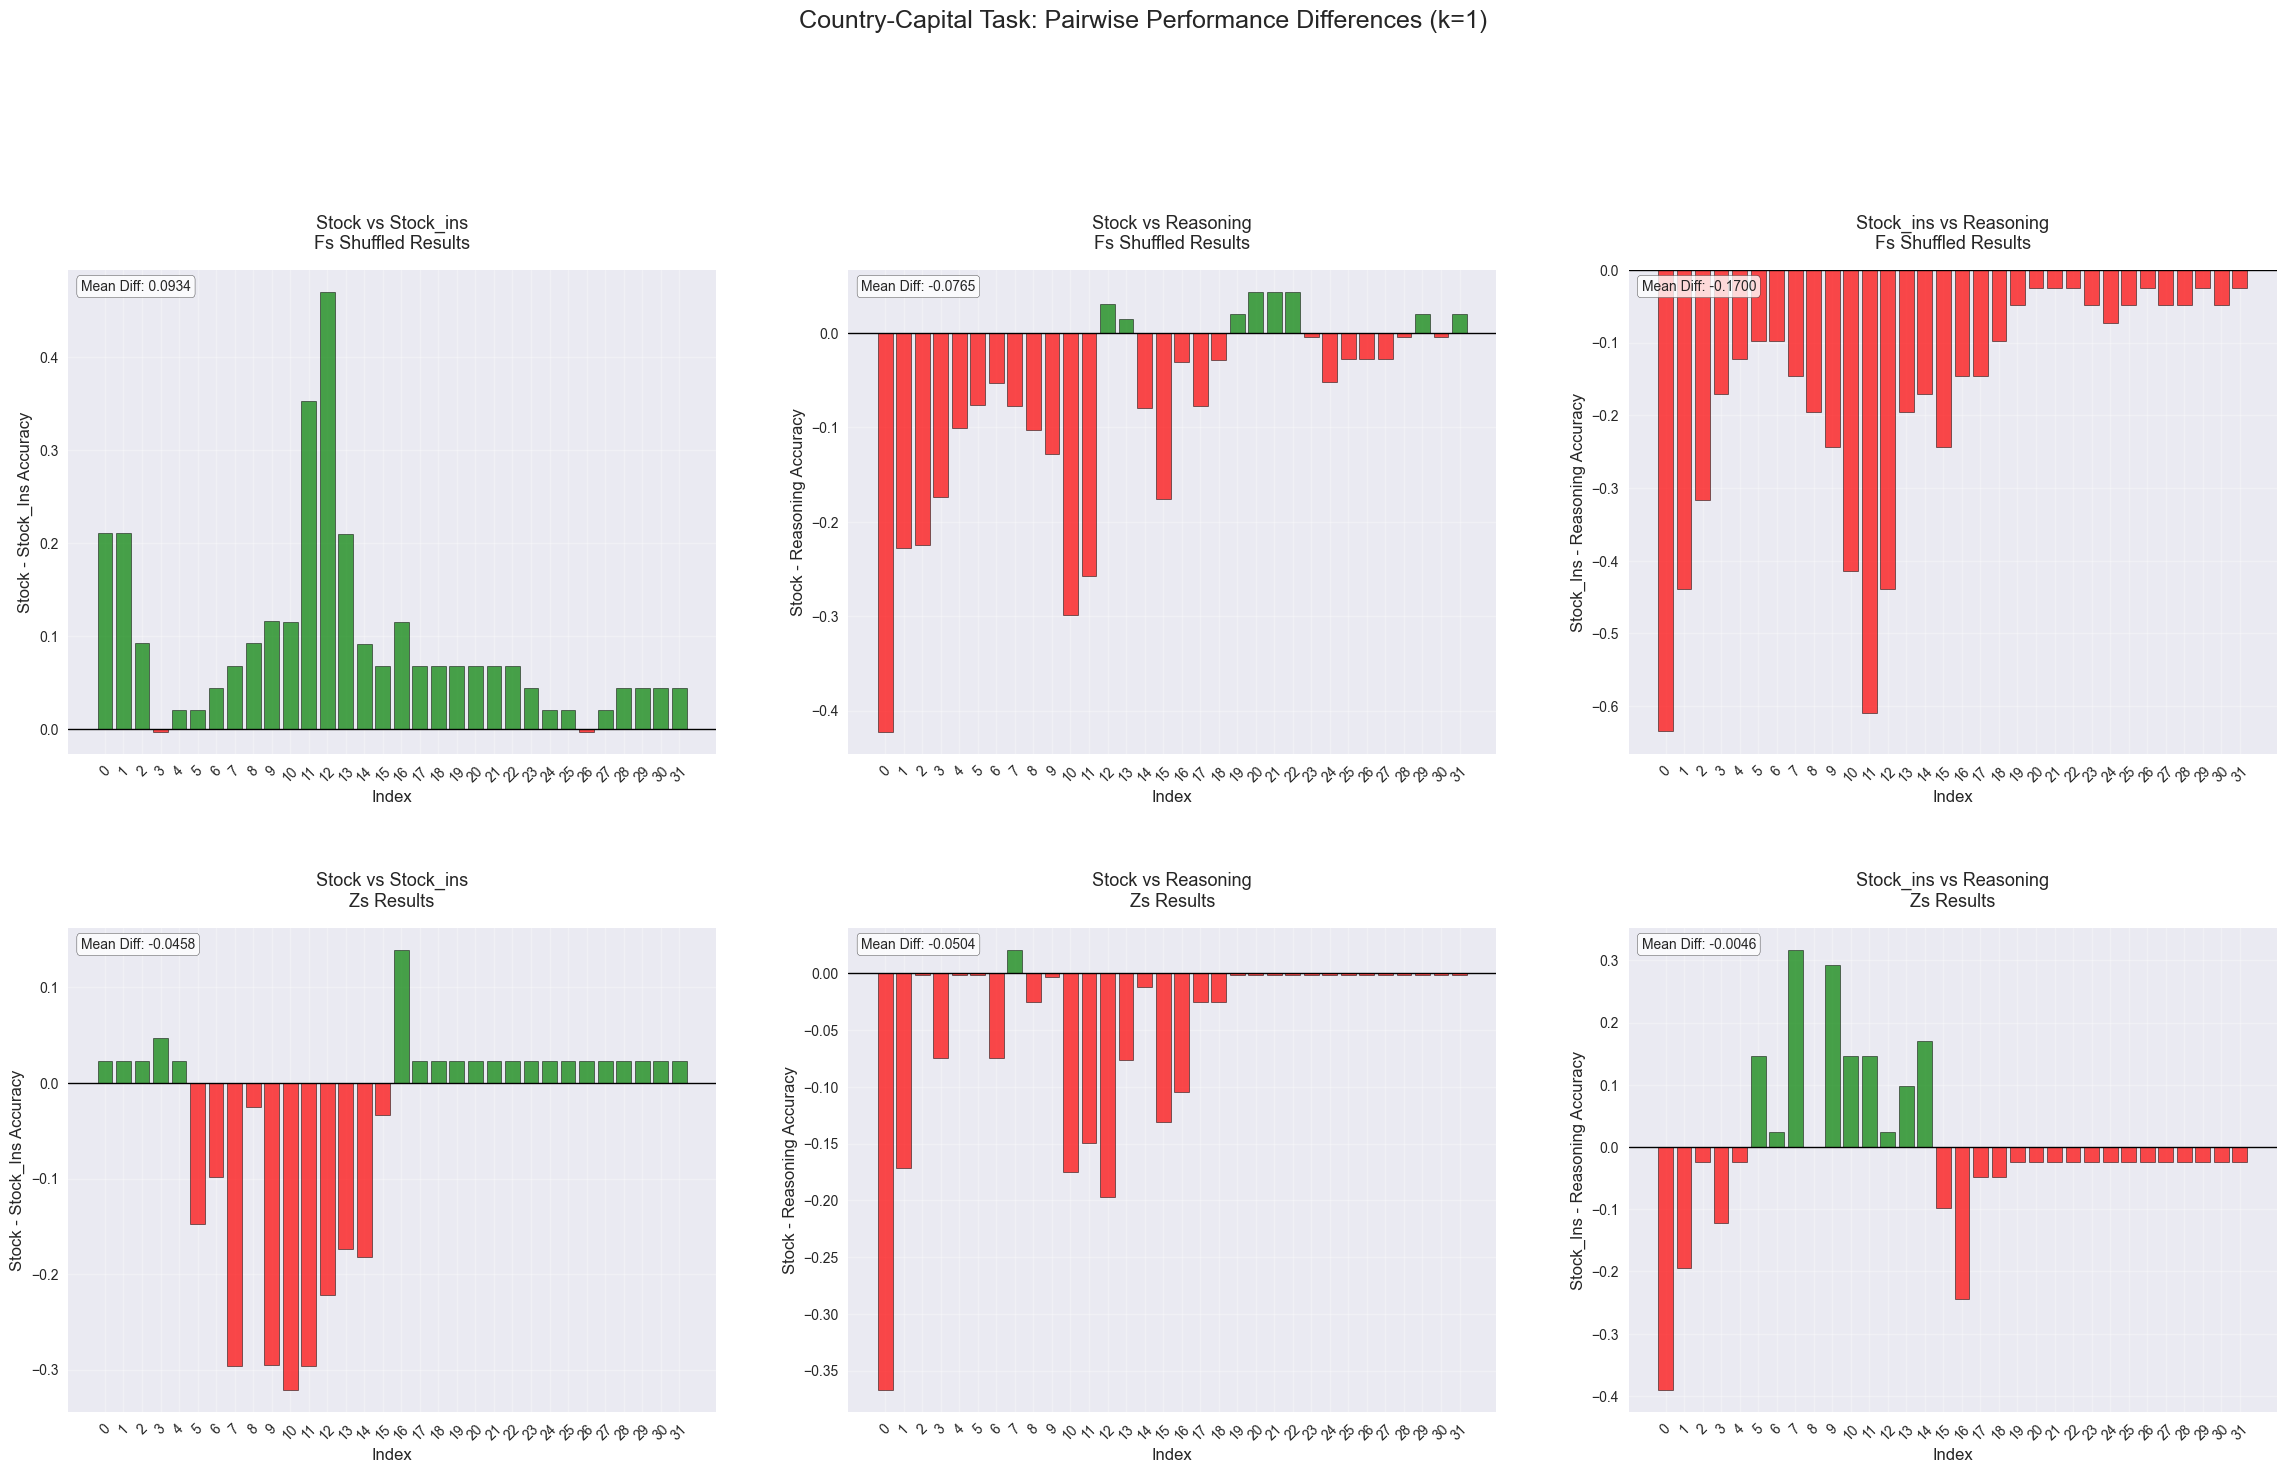

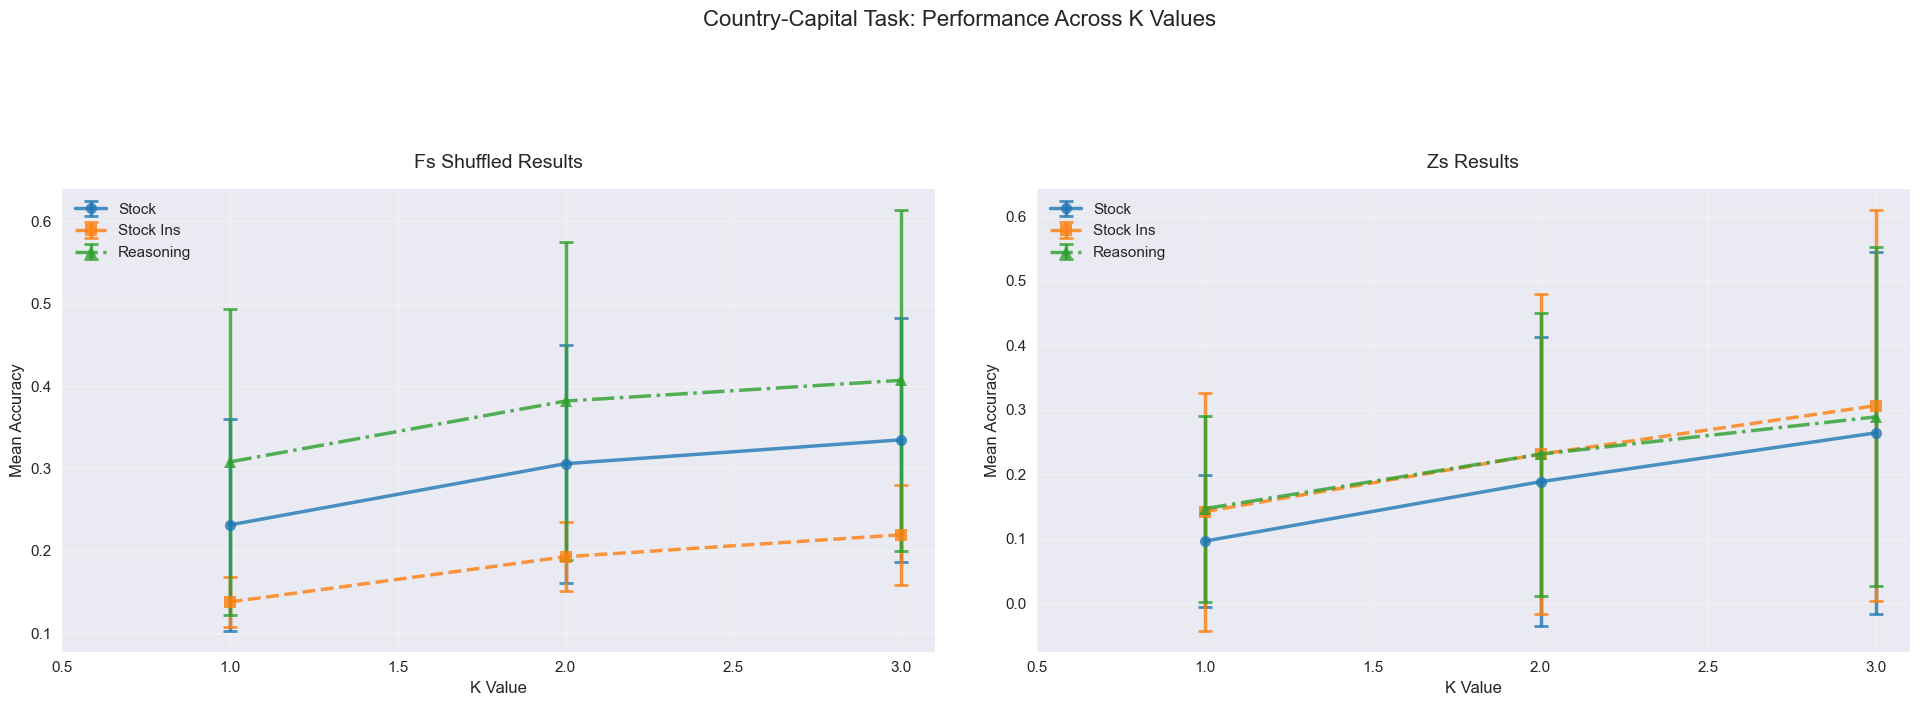

In [65]:
# Difference Analysis for Country-Capital Task - Pairwise Comparisons
# Create difference plots to highlight performance gaps

fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # Large figure for clear visualization
fig.suptitle('Country-Capital Task: Pairwise Performance Differences (k=1)', fontsize=18, y=0.98)

file_types = ['fs_shuffled_results', 'zs_results']
comparisons = [('stock', 'stock_ins'), ('stock', 'reasoning'), ('stock_ins', 'reasoning')]
comparison_titles = ['Stock vs Stock_ins', 'Stock vs Reasoning', 'Stock_ins vs Reasoning']

for row_idx, file_type in enumerate(file_types):
    for col_idx, (ds1, ds2) in enumerate(comparisons):
        ax = axes[row_idx, col_idx]
        
        # Get data for both datasets
        data1 = country_capital_combined[
            (country_capital_combined['dataset'] == ds1) & 
            (country_capital_combined['file_type'] == file_type) &
            (country_capital_combined['k'] == 1)
        ].set_index('index')['accuracy']
        
        data2 = country_capital_combined[
            (country_capital_combined['dataset'] == ds2) & 
            (country_capital_combined['file_type'] == file_type) &
            (country_capital_combined['k'] == 1)
        ].set_index('index')['accuracy']
        
        # Calculate differences where both datasets have data
        common_indices = data1.index.intersection(data2.index)
        if len(common_indices) > 0:
            differences = data1[common_indices] - data2[common_indices]
            
            # Plot the differences
            bars = ax.bar(range(len(differences)), differences.values, 
                         color=['green' if d > 0 else 'red' for d in differences.values],
                         alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add horizontal line at y=0
            ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
            
            # Customize the plot
            ax.set_xlabel('Index', fontsize=12)
            ax.set_ylabel(f'{ds1.title()} - {ds2.title()} Accuracy', fontsize=12)
            ax.set_title(f'{comparison_titles[col_idx]}\n{file_type.replace("_", " ").title()}', 
                        fontsize=13, pad=15)
            ax.set_xticks(range(len(differences)))
            ax.set_xticklabels([str(i) for i in common_indices], rotation=45)
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=10)
            
            # Add summary statistics as text
            mean_diff = differences.mean()
            ax.text(0.02, 0.98, f'Mean Diff: {mean_diff:.4f}', 
                   transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No Common Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f'{comparison_titles[col_idx]}\n{file_type.replace("_", " ").title()}', 
                        fontsize=13, pad=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0)
plt.show()

# Multi-K comparison plot with better spacing
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Wide layout for clarity
fig.suptitle('Country-Capital Task: Performance Across K Values', fontsize=16, y=0.95)

# Define colors and markers as dictionaries
colors = {'stock': '#1f77b4', 'stock_ins': '#ff7f0e', 'reasoning': '#2ca02c'}
markers = {'stock': 'o', 'stock_ins': 's', 'reasoning': '^'}
linestyles = {'stock': '-', 'stock_ins': '--', 'reasoning': '-.'}

for idx, file_type in enumerate(['fs_shuffled_results', 'zs_results']):
    ax = axes[idx]
    
    # Plot mean accuracy for each K value and dataset
    k_values = sorted(country_capital_combined['k'].unique())
    
    for dataset in ['stock', 'stock_ins', 'reasoning']:
        mean_accuracies = []
        std_accuracies = []
        
        for k in k_values:
            data = country_capital_combined[
                (country_capital_combined['dataset'] == dataset) & 
                (country_capital_combined['file_type'] == file_type) &
                (country_capital_combined['k'] == k)
            ]['accuracy']
            
            if not data.empty:
                mean_accuracies.append(data.mean())
                std_accuracies.append(data.std())
            else:
                mean_accuracies.append(np.nan)
                std_accuracies.append(np.nan)
        
        # Plot with error bars
        ax.errorbar(k_values, mean_accuracies, yerr=std_accuracies,
                   label=dataset.replace('_', ' ').title(),
                   marker=markers[dataset], linestyle=linestyles[dataset],
                   color=colors[dataset], linewidth=2.5, markersize=8,
                   capsize=5, capthick=2, alpha=0.8)
    
    ax.set_xlabel('K Value', fontsize=12)
    ax.set_ylabel('Mean Accuracy', fontsize=12)
    ax.set_title(f'{file_type.replace("_", " ").title()}', fontsize=14, pad=15)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)
    ax.set_xlim(left=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.92], pad=3.0)
plt.show()

# Antonym Task: Reasoning vs Reasoning-CoT vs Reasoning-FV-CoT Comparison (Full Range Analysis)

This section compares intervention_topk results across three different reasoning-based experimental conditions for the antonym task:
- **Reasoning**: Standard reasoning experimental setup (layers 0-31)
- **Reasoning-CoT**: Reasoning with Chain-of-Thought (layers 0-31)
- **Reasoning-FV-CoT**: Reasoning with Few-shot Verbalized Chain-of-Thought (layers 0-31)

**Update**: reasoning-FV-CoT now has full layer results (0-31), so we can analyze the complete layer range for all three conditions while maintaining separate analyses for different index ranges as needed.

In [112]:
# Load reasoning-FV-CoT data and prepare comparison
reasoning_variants_datasets = {}
reasoning_variants_base_paths = {
    'reasoning': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/antonym'),
    'reasoning-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym'),
    'reasoning-FV-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-FV-CoT/antonym')
}

reasoning_variants_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json',
    'model_baseline_no_rank_list.json'
]

# Extract data for each reasoning variant
reasoning_variants_extracted = {}
for dataset_name, base_path in reasoning_variants_base_paths.items():
    reasoning_variants_extracted[dataset_name] = {}
    print(f"\nLoading {dataset_name} antonym data...")
    
    for file_name in reasoning_variants_file_names:
        # Handle different naming conventions
        if dataset_name == 'reasoning':
            # Reasoning files have _(1) suffix
            no_rank_file_name = file_name.replace('_no_rank_list.json', '_(1)_no_rank_list.json')
            original_file_name = file_name.replace('_no_rank_list.json', '_(1).json')
        else:
            # Other datasets use standard naming
            no_rank_file_name = file_name
            original_file_name = file_name.replace('_no_rank_list', '')
        
        no_rank_file_path = base_path / no_rank_file_name
        original_file_path = base_path / original_file_name
        
        # Choose which file to load
        file_to_load = no_rank_file_path if no_rank_file_path.exists() else original_file_path
        
        if file_to_load.exists():
            try:
                with open(file_to_load, 'r') as f:
                    data = json.load(f)
                # Use the standard file name for consistency
                standard_file_name = file_name.replace('_no_rank_list', '')
                reasoning_variants_extracted[dataset_name][standard_file_name] = data
                print(f"  ✓ Loaded {file_to_load.name}")
            except Exception as e:
                print(f"  ✗ Error loading {file_to_load.name}: {e}")
        else:
            print(f"  ✗ File not found: {no_rank_file_name} or {original_file_name}")

print(f"\nReasoning variants datasets loaded: {list(reasoning_variants_extracted.keys())}")


Loading reasoning antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_(1)_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_(1)_no_rank_list.json
  ✓ Loaded model_baseline_(1)_no_rank_list.json

Loading reasoning-CoT antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Loading reasoning-FV-CoT antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Reasoning variants datasets loaded: ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']


In [113]:
# Create DataFrames for reasoning variants comparison (full layer range 0-31)
reasoning_variants_dataframes = []

print("=== Processing Reasoning Variants Data (Full Range 0-31) ===")

# Use full range for all reasoning variants since reasoning-FV-CoT now has complete data
target_indices = list(range(0, 32))  # indices 0-31 (full range)
print(f"Target indices for comparison: 0-31 (full range)")

for dataset_name, data_dict in reasoning_variants_extracted.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    for file_name, data in data_dict.items():
        if isinstance(data, dict):
            print(f"  Processing file: {file_name}")
            
            # Only process fs_shuffled_results and zs_results (skip model_baseline for now)
            if 'fs_shuffled_results' in file_name or 'zs_results' in file_name:
                
                # All reasoning variants use the same structure: each index contains intervention_topk as a list of [k, accuracy] pairs
                for layer_idx_str, layer_data in data.items():
                    layer_idx = int(layer_idx_str)
                    # Process all available indices (0-31) instead of restricting to 8-15
                    if layer_idx in target_indices and isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                        intervention_list = layer_data['intervention_topk']
                        
                        if isinstance(intervention_list, list):
                            for k_acc_pair in intervention_list:
                                if isinstance(k_acc_pair, list) and len(k_acc_pair) == 2:
                                    k_val, accuracy = k_acc_pair
                                    reasoning_variants_dataframes.append({
                                        'dataset': dataset_name,
                                        'file_type': file_name.replace('.json', '').replace('_layer_sweep', ''),
                                        'k': int(k_val),
                                        'index': layer_idx,
                                        'accuracy': float(accuracy)
                                    })

# Convert to DataFrame
reasoning_variants_combined = pd.DataFrame(reasoning_variants_dataframes)
print(f"\n=== Reasoning Variants Combined Dataset ===")
print(f"Shape: {reasoning_variants_combined.shape}")

if not reasoning_variants_combined.empty:
    print(f"Datasets: {reasoning_variants_combined['dataset'].unique()}")
    print(f"File types: {reasoning_variants_combined['file_type'].unique()}")
    print(f"K values range: {reasoning_variants_combined['k'].min()} to {reasoning_variants_combined['k'].max()}")
    print(f"Index range: {reasoning_variants_combined['index'].min()} to {reasoning_variants_combined['index'].max()}")
    
    # Count data points per dataset
    dataset_counts = reasoning_variants_combined['dataset'].value_counts()
    print(f"\nData points per dataset:")
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count}")
    
    # Display sample data
    print("\nSample data:")
    print(reasoning_variants_combined.head(10))
else:
    print("No data found in reasoning_variants_combined DataFrame!")
    print(f"Number of raw entries: {len(reasoning_variants_dataframes)}")

=== Processing Reasoning Variants Data (Full Range 0-31) ===
Target indices for comparison: 0-31 (full range)

Processing dataset: reasoning
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

Processing dataset: reasoning-CoT
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

Processing dataset: reasoning-FV-CoT
  Processing file: fs_shuffled_results_layer_sweep.json
  Processing file: zs_results_layer_sweep.json
  Processing file: model_baseline.json

=== Reasoning Variants Combined Dataset ===
Shape: (576, 5)
Datasets: ['reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
File types: ['fs_shuffled_results' 'zs_results']
K values range: 1 to 3
Index range: 0 to 31

Data points per dataset:
  reasoning: 192
  reasoning-CoT: 192
  reasoning-FV-CoT: 192

Sample data:
     dataset            file_type  k  index  

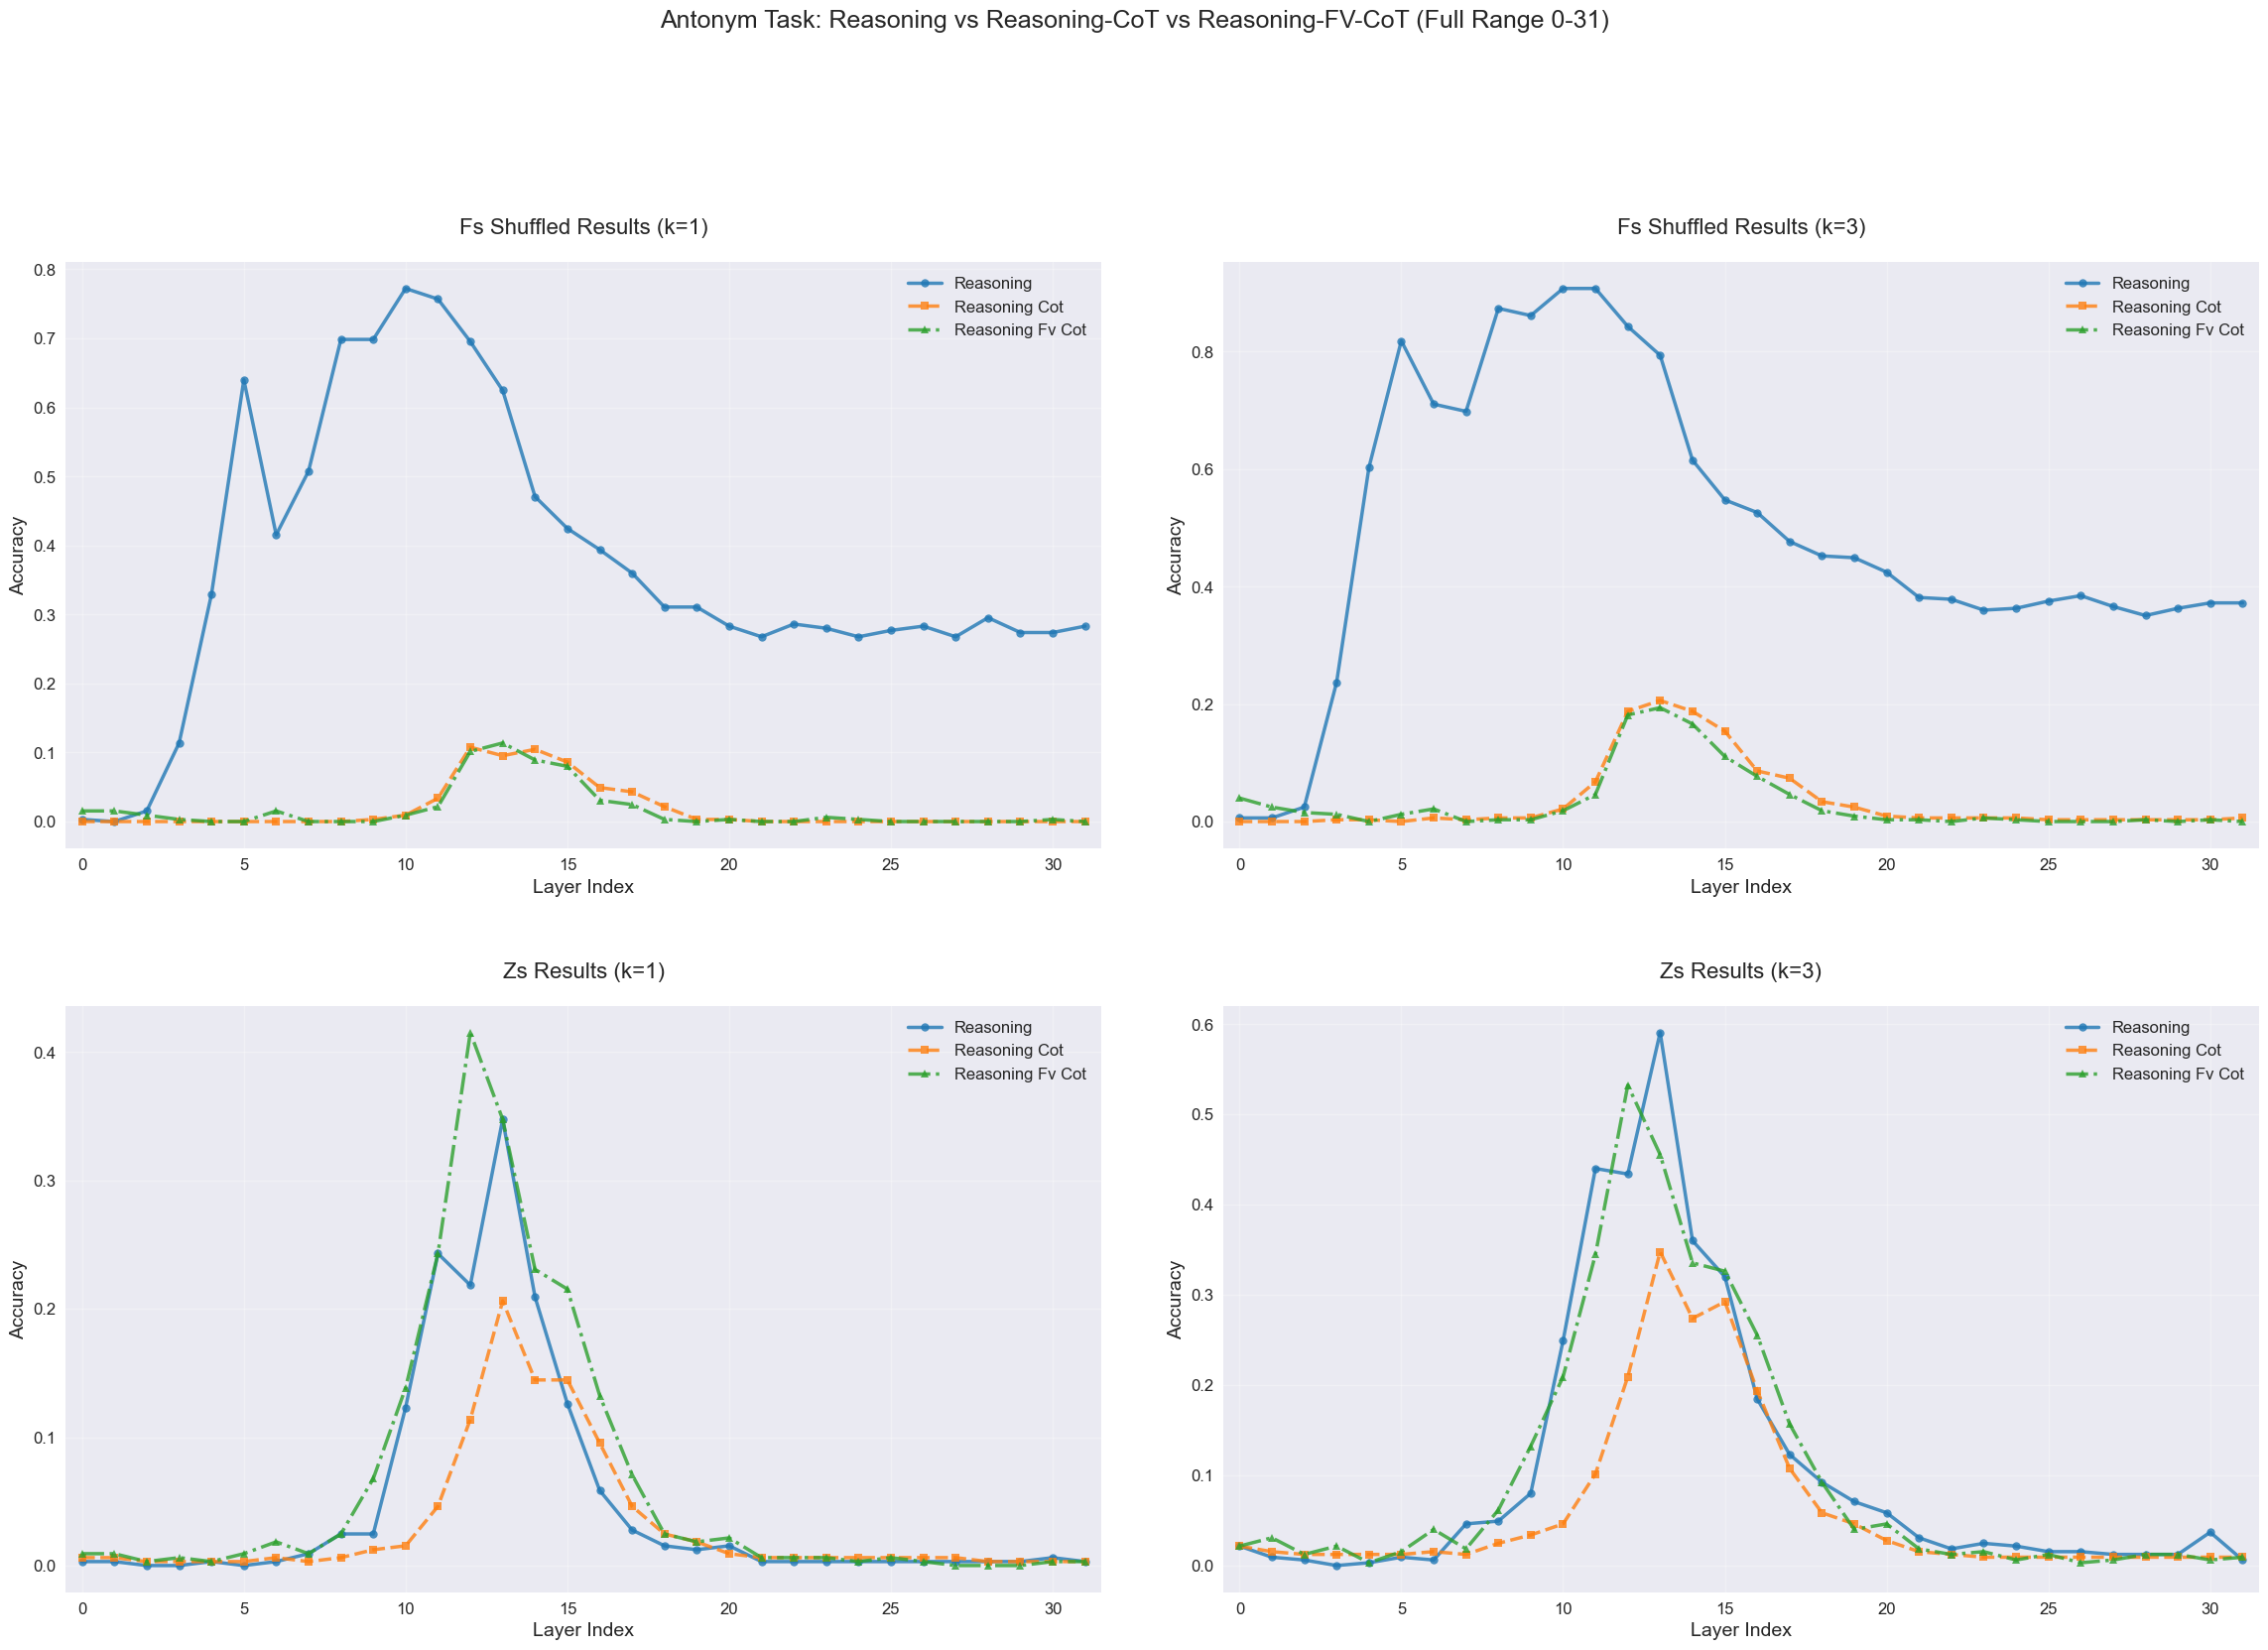

In [114]:
# Line plots for reasoning variants comparison - Full Range (0-31)
# Using large figure size and good spacing to avoid clustering

fig, axes = plt.subplots(2, 2, figsize=(24, 18))  # Large figure size for clarity
fig.suptitle('Antonym Task: Reasoning vs Reasoning-CoT vs Reasoning-FV-CoT (Full Range 0-31)', fontsize=18, y=0.98)

# Colors for each reasoning variant
colors = {'reasoning': '#1f77b4', 'reasoning-CoT': '#ff7f0e', 'reasoning-FV-CoT': '#2ca02c'}
markers = {'reasoning': 'o', 'reasoning-CoT': 's', 'reasoning-FV-CoT': '^'}
linestyles = {'reasoning': '-', 'reasoning-CoT': '--', 'reasoning-FV-CoT': '-.'}

# Plot for each file type and k=1, k=3 (max k available)
k_values_to_plot = [1, 3]
file_types = ['fs_shuffled_results', 'zs_results']

for row_idx, file_type in enumerate(file_types):
    for col_idx, k_val in enumerate(k_values_to_plot):
        ax = axes[row_idx, col_idx]
        
        for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
            if dataset in reasoning_variants_combined['dataset'].unique():
                data = reasoning_variants_combined[
                    (reasoning_variants_combined['dataset'] == dataset) & 
                    (reasoning_variants_combined['file_type'] == file_type) &
                    (reasoning_variants_combined['k'] == k_val)
                ].sort_values('index')
                
                if not data.empty:
                    ax.plot(data['index'], data['accuracy'], 
                           color=colors[dataset], marker=markers[dataset], 
                           linestyle=linestyles[dataset], linewidth=2.5, markersize=6,
                           label=f'{dataset.replace("-", " ").title()}', alpha=0.8)
        
        ax.set_xlabel('Layer Index', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)
        ax.set_title(f'{file_type.replace("_", " ").title()} (k={k_val})', fontsize=16, pad=20)
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        ax.set_xlim(-0.5, 31.5)  # Full range with some padding

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0)  # Extra spacing
plt.show()

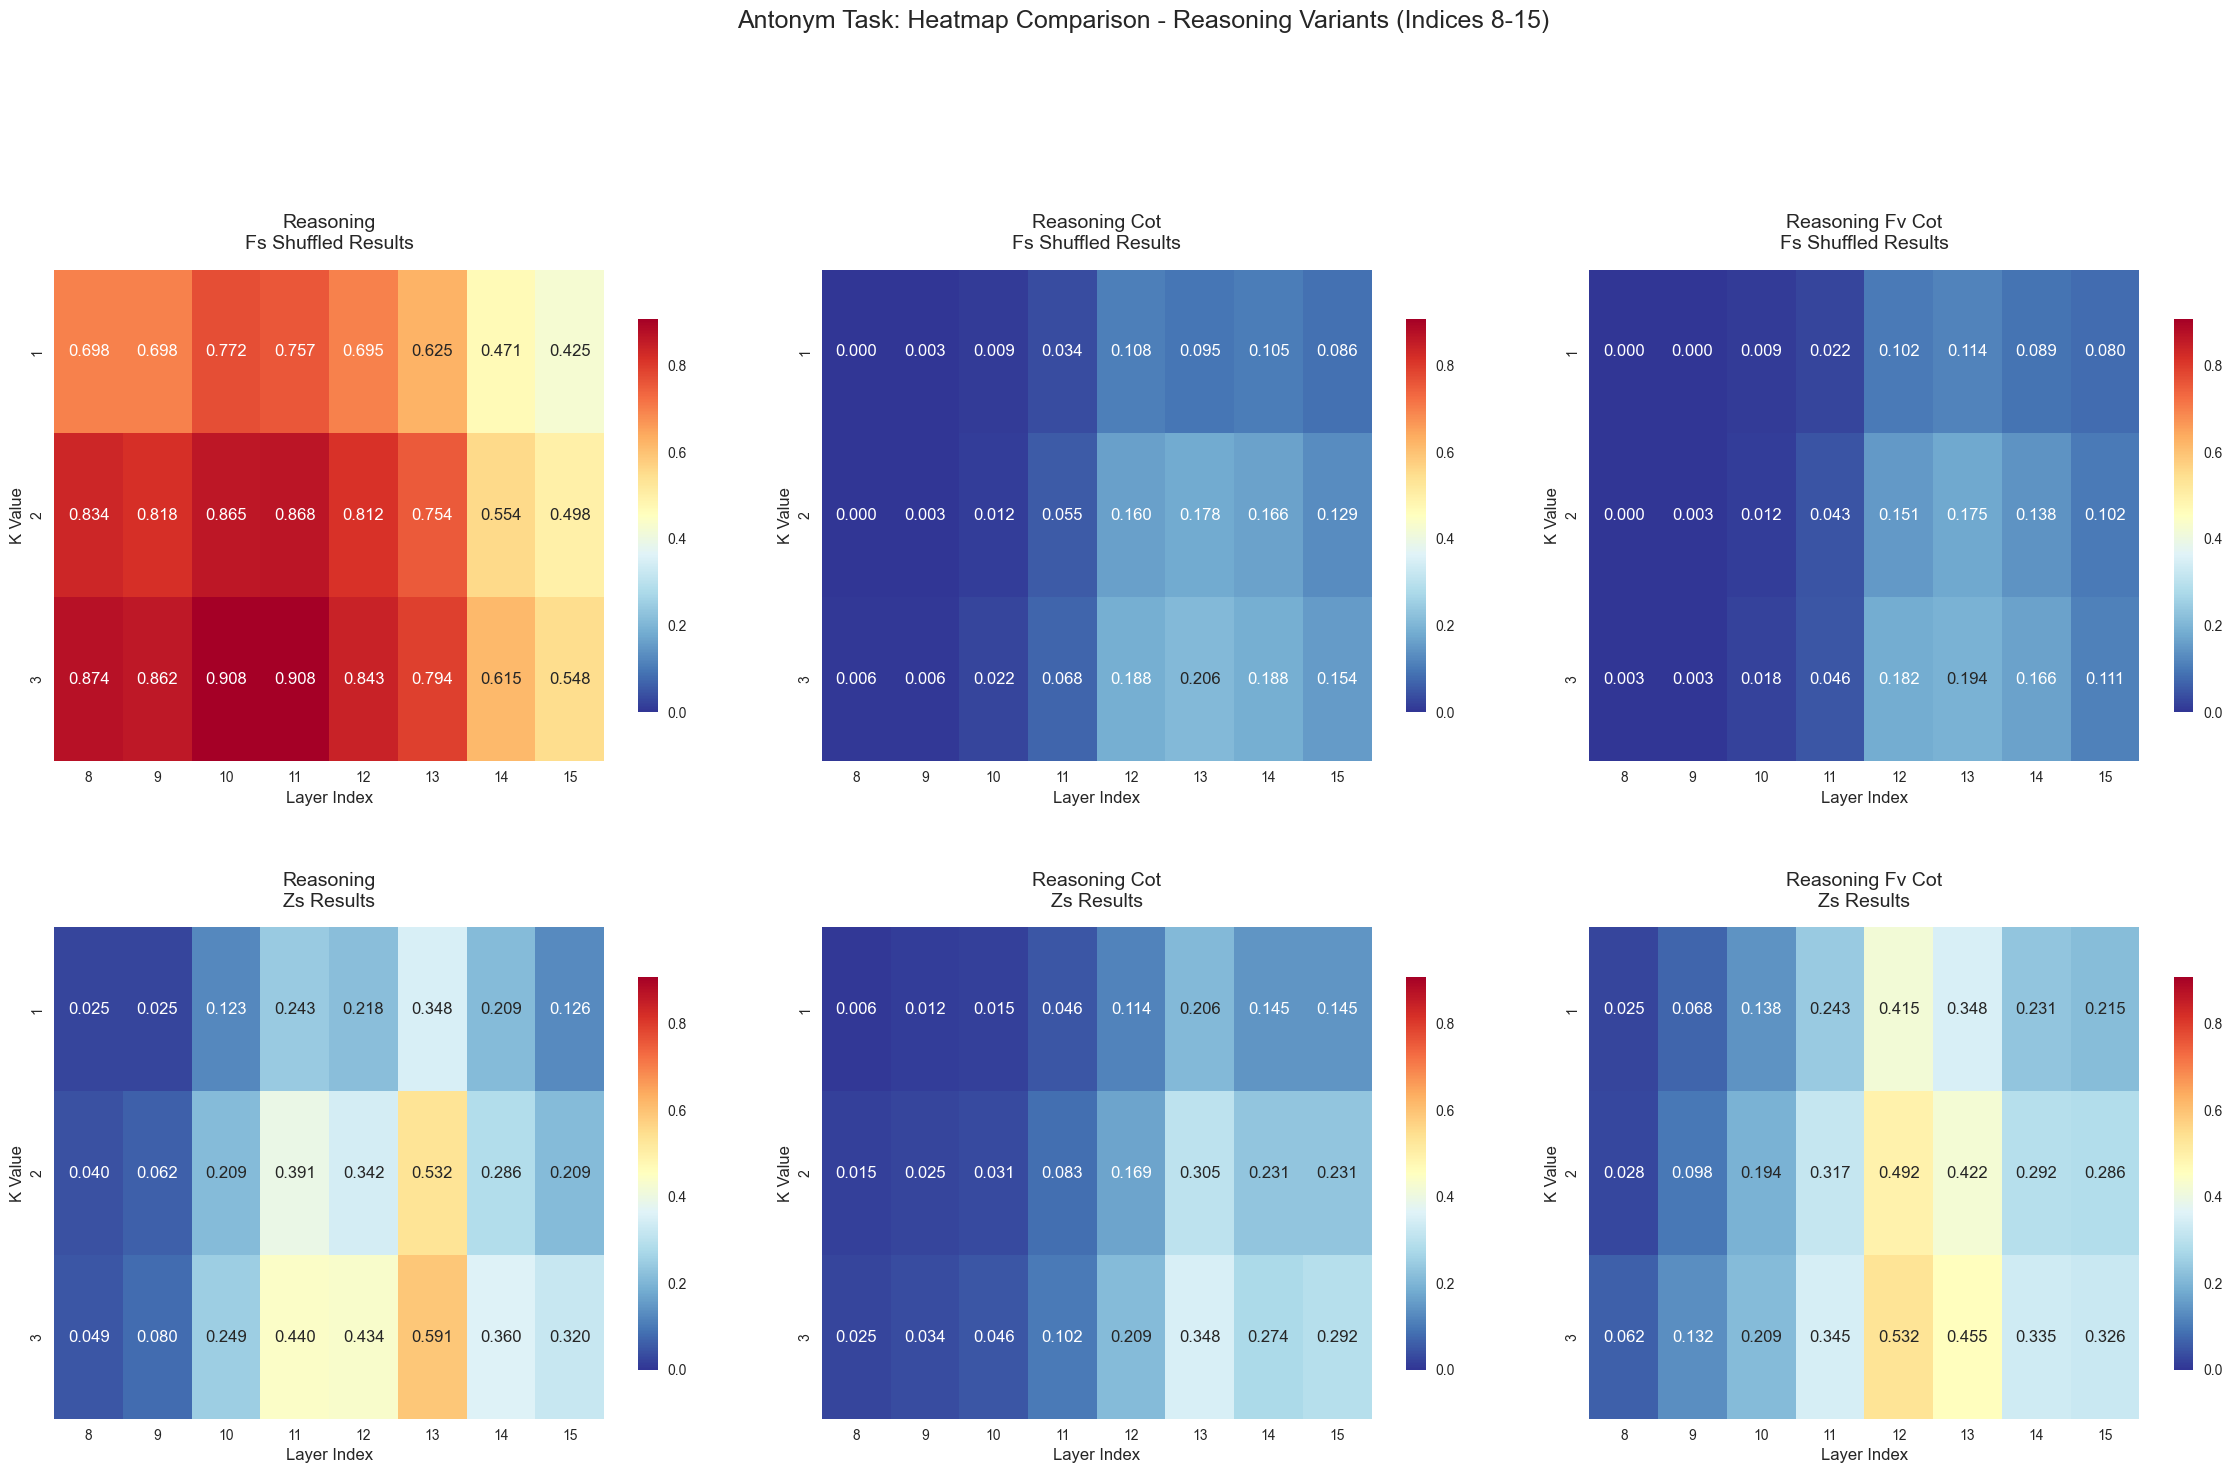

In [72]:
# Heatmap comparison for Reasoning Variants (Full Range 0-31)
# Create heatmaps for better visualization with improved spacing

fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # Large figure size for clarity
fig.suptitle('Antonym Task: Heatmap Comparison - Reasoning Variants (Full Range 0-31)', fontsize=18, y=0.98)

=== Reasoning Variants Statistical Analysis (Full Range 0-31) ===

=== Fs Shuffled Results Analysis ===

Reasoning:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0000-0.9077
  Mean accuracy: 0.4397
  Std accuracy: 0.2401

Reasoning Cot:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0000-0.2062
  Mean accuracy: 0.0271
  Std accuracy: 0.0510

Reasoning Fv Cot:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0000-0.1938
  Mean accuracy: 0.0251
  Std accuracy: 0.0455
=== Zs Results Analysis ===

Reasoning:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0000-0.5908
  Mean accuracy: 0.0778
  Std accuracy: 0.1295

Reasoning Cot:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0031-0.3477
  Mean accuracy: 0.0471
  Std accuracy: 0.0774

Reasoning Fv Cot:
  Data points: 96
  Layer range: 0-31
  K range: 1-3
  Accuracy range: 0.0000-0.5323
  Mean accuracy: 0.0847
  Std

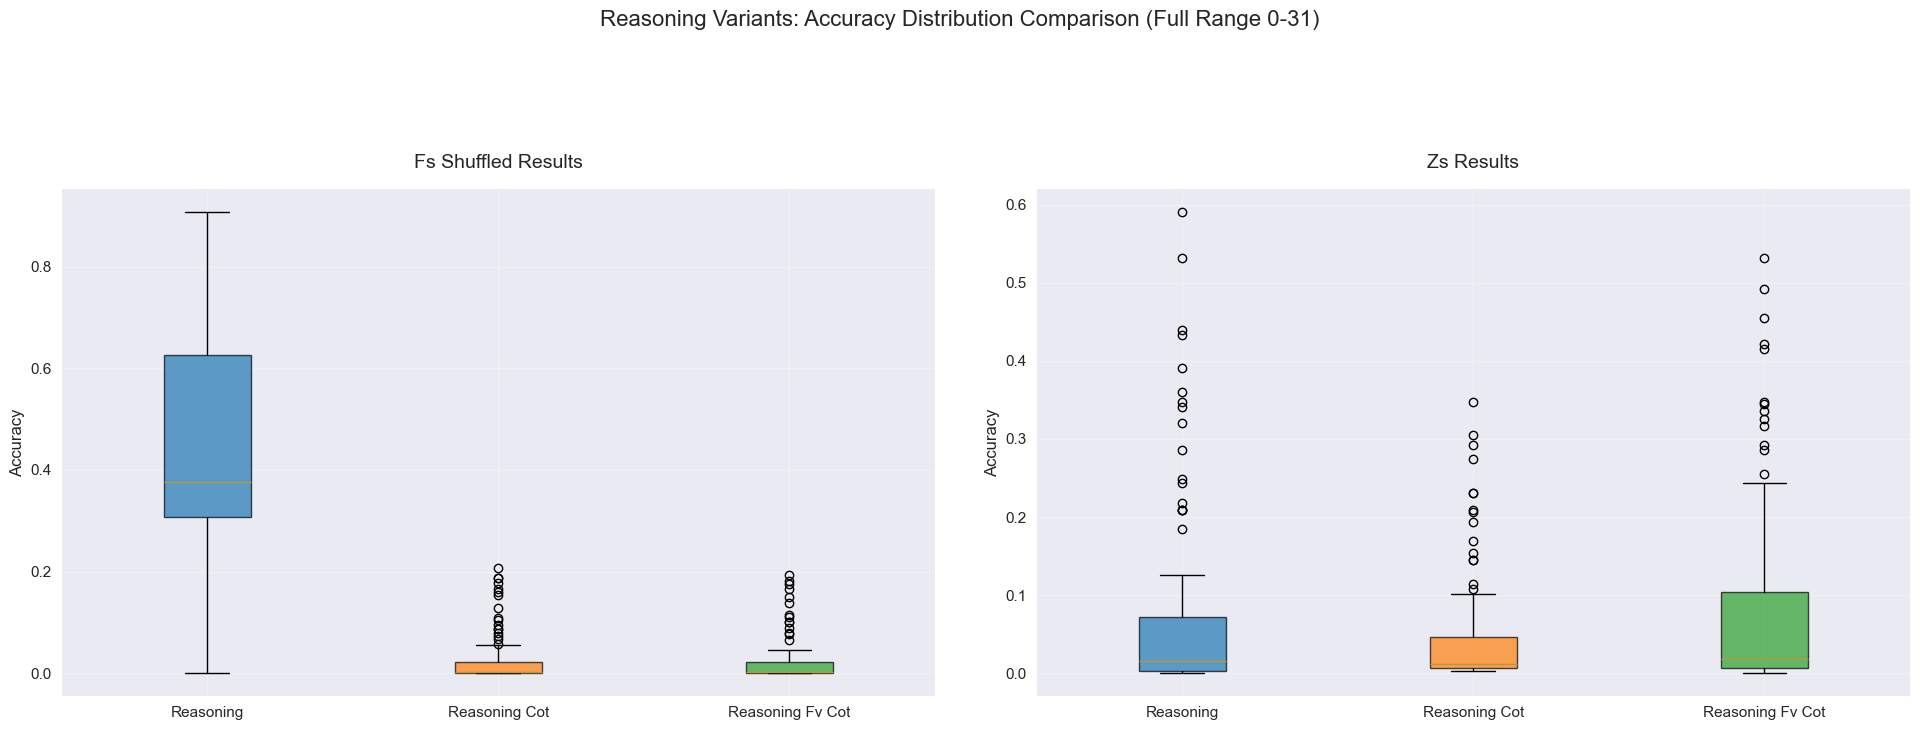

In [115]:
# Statistical Analysis for Reasoning Variants (Full Range 0-31)
print("=== Reasoning Variants Statistical Analysis (Full Range 0-31) ===\n")

# Print basic statistics for each dataset and file type
for file_type in ['fs_shuffled_results', 'zs_results']:
    print(f"=== {file_type.replace('_', ' ').title()} Analysis ===")
    
    for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
        if dataset in reasoning_variants_combined['dataset'].unique():
            data = reasoning_variants_combined[
                (reasoning_variants_combined['dataset'] == dataset) & 
                (reasoning_variants_combined['file_type'] == file_type)
            ]
            
            if not data.empty:
                print(f"\n{dataset.replace('-', ' ').title()}:")
                print(f"  Data points: {len(data)}")
                print(f"  Layer range: {data['index'].min()}-{data['index'].max()}")
                print(f"  K range: {data['k'].min()}-{data['k'].max()}")
                print(f"  Accuracy range: {data['accuracy'].min():.4f}-{data['accuracy'].max():.4f}")
                print(f"  Mean accuracy: {data['accuracy'].mean():.4f}")
                print(f"  Std accuracy: {data['accuracy'].std():.4f}")

# K-value comparison
for k_val in sorted(reasoning_variants_combined['k'].unique()):
    print(f"\n=== K={k_val} Detailed Comparison ===")
    
    for file_type in ['fs_shuffled_results', 'zs_results']:
        print(f"\n{file_type.replace('_', ' ').title()}:")
        
        data_subset = reasoning_variants_combined[
            (reasoning_variants_combined['file_type'] == file_type) &
            (reasoning_variants_combined['k'] == k_val)
        ]
        
        if not data_subset.empty:
            print(f"\nK={k_val} comparison:")
            k_stats = data_subset.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
            print(k_stats)
            
            # Calculate performance differences
            if len(k_stats) >= 2:
                datasets_available = k_stats.index.tolist()
                for i in range(len(datasets_available)):
                    for j in range(i+1, len(datasets_available)):
                        ds1, ds2 = datasets_available[i], datasets_available[j]
                        diff = k_stats.loc[ds1, 'mean'] - k_stats.loc[ds2, 'mean']
                        print(f"  {ds1} vs {ds2}: {diff:+.4f}")

# Box plots for distribution comparison with better spacing
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Wider figure for better spacing
fig.suptitle('Reasoning Variants: Accuracy Distribution Comparison (Full Range 0-31)', fontsize=16, y=0.98)

for idx, file_type in enumerate(['fs_shuffled_results', 'zs_results']):
    ax = axes[idx]
    
    # Prepare data for box plot
    plot_data = []
    labels = []
    
    for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
        data = reasoning_variants_combined[
            (reasoning_variants_combined['dataset'] == dataset) & 
            (reasoning_variants_combined['file_type'] == file_type)
        ]['accuracy']
        
        if not data.empty:
            plot_data.append(data.values)
            labels.append(dataset.replace('-', ' ').title())
    
    if plot_data:
        box_plot = ax.boxplot(plot_data, tick_labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        for patch, color in zip(box_plot['boxes'], colors[:len(plot_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{file_type.replace("_", " ").title()}', fontsize=14, pad=15)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=3.0)
plt.show()

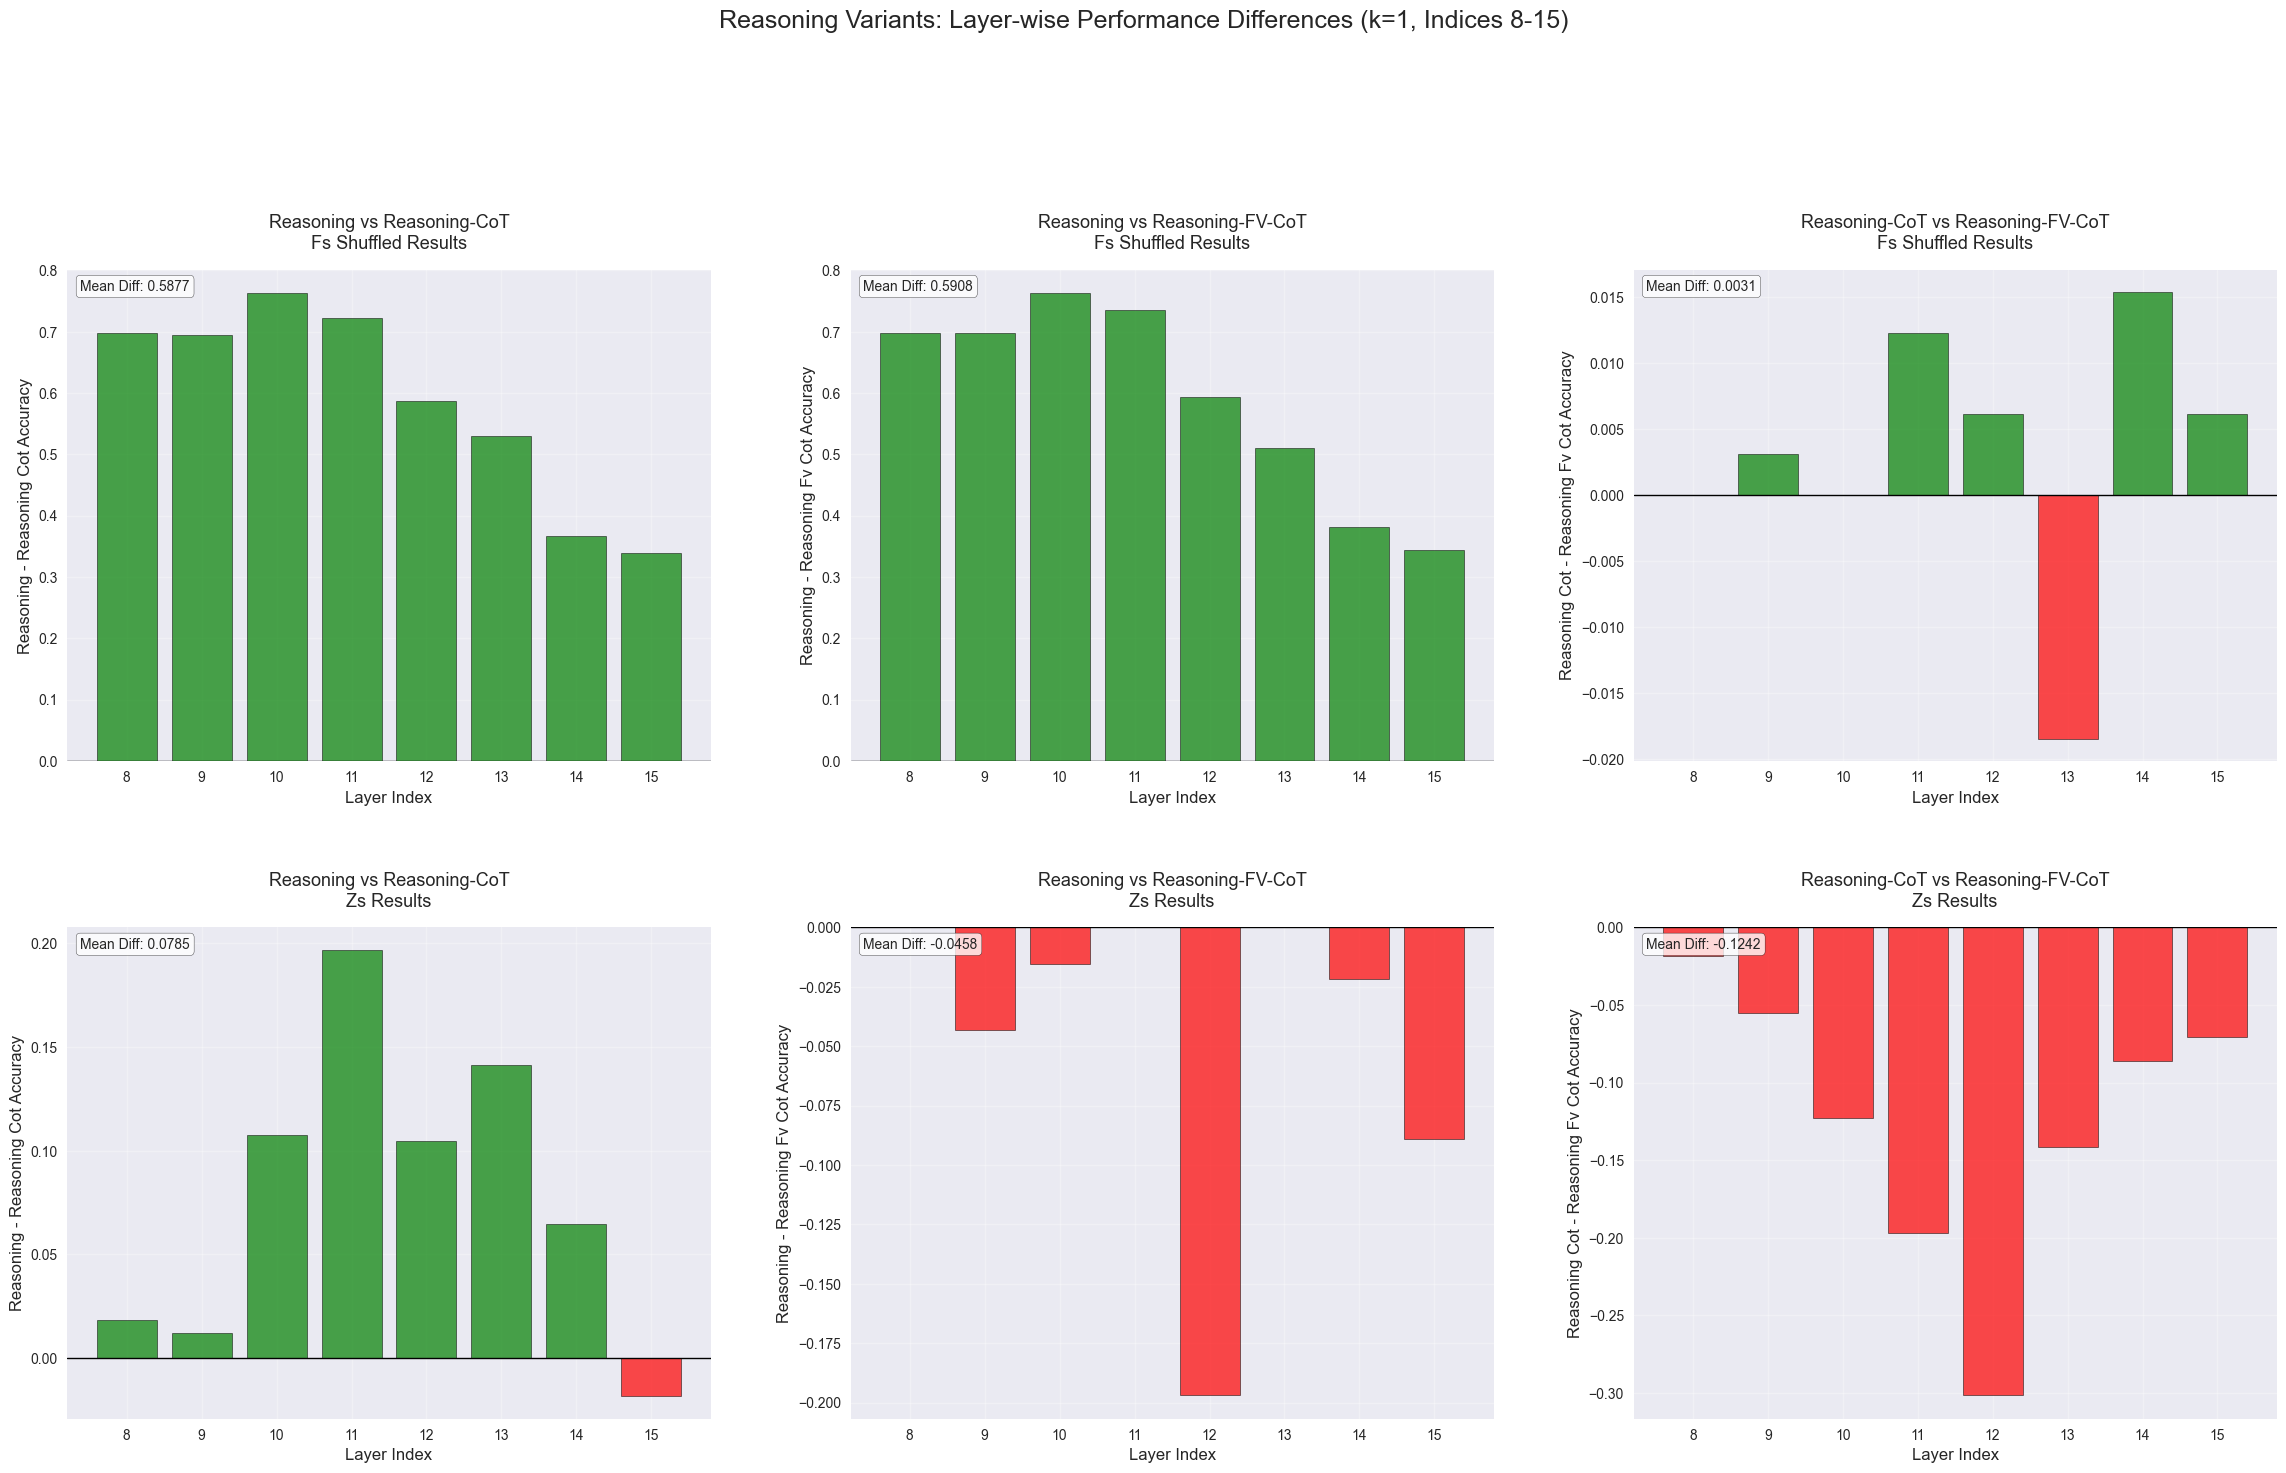

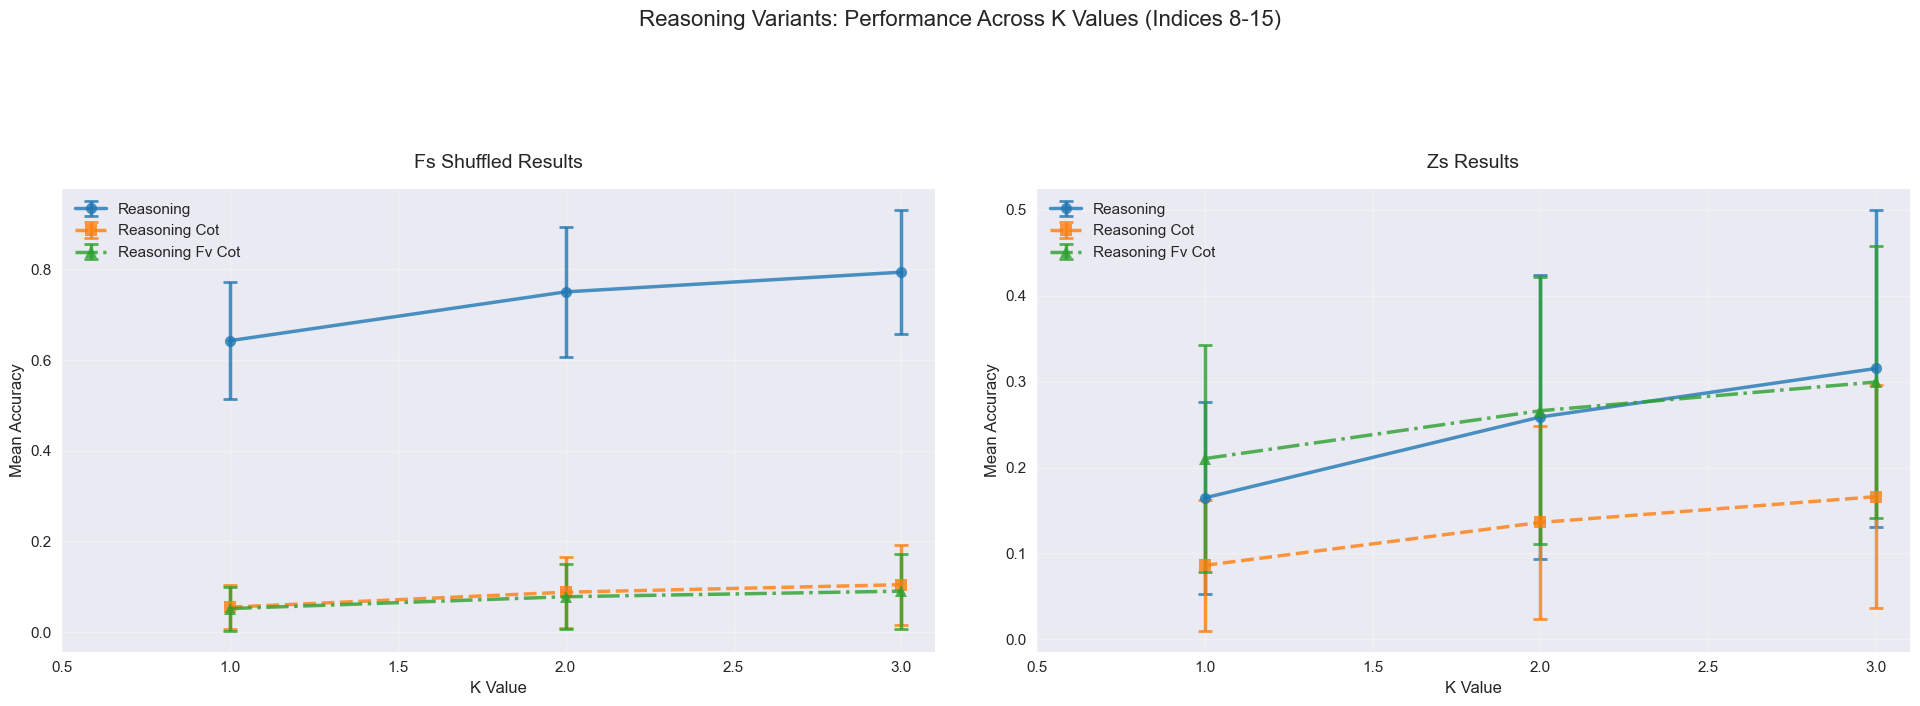

In [74]:
# Detailed Difference Analysis for Reasoning Variants (Full Range 0-31)
# Layer-wise performance differences between reasoning approaches

fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # Large figure for clear visualization
fig.suptitle('Reasoning Variants: Layer-wise Performance Differences (k=1, Full Range 0-31)', fontsize=18, y=0.98)

file_types = ['fs_shuffled_results', 'zs_results']
comparisons = [('reasoning', 'reasoning-CoT'), ('reasoning', 'reasoning-FV-CoT'), ('reasoning-CoT', 'reasoning-FV-CoT')]
comparison_titles = ['Reasoning vs Reasoning-CoT', 'Reasoning vs Reasoning-FV-CoT', 'Reasoning-CoT vs Reasoning-FV-CoT']

for row_idx, file_type in enumerate(file_types):
    for col_idx, (ds1, ds2) in enumerate(comparisons):
        ax = axes[row_idx, col_idx]
        
        # Get data for both datasets (k=1, full range)
        data1 = reasoning_variants_combined[
            (reasoning_variants_combined['dataset'] == ds1) & 
            (reasoning_variants_combined['file_type'] == file_type) &
            (reasoning_variants_combined['k'] == 1)
        ].set_index('index')['accuracy']
        
        data2 = reasoning_variants_combined[
            (reasoning_variants_combined['dataset'] == ds2) & 
            (reasoning_variants_combined['file_type'] == file_type) &
            (reasoning_variants_combined['k'] == 1)
        ].set_index('index')['accuracy']
        
        # Calculate differences where both datasets have data
        common_indices = data1.index.intersection(data2.index)
        if len(common_indices) > 0:
            differences = data1[common_indices] - data2[common_indices]
            
            # Sort indices for proper plotting
            common_indices_sorted = sorted(common_indices)
            differences_sorted = differences[common_indices_sorted]
            
            # Plot the differences
            bars = ax.bar(range(len(differences_sorted)), differences_sorted.values, 
                         color=['green' if d > 0 else 'red' for d in differences_sorted.values],
                         alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add horizontal line at y=0
            ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
            
            # Customize the plot
            ax.set_xlabel('Layer Index', fontsize=12)
            ax.set_ylabel(f'{ds1.replace("-", " ").title()} - {ds2.replace("-", " ").title()} Accuracy', fontsize=12)
            ax.set_title(f'{comparison_titles[col_idx]}\n{file_type.replace("_", " ").title()}', 
                        fontsize=13, pad=15)
            ax.set_xticks(range(len(differences_sorted)))
            ax.set_xticklabels([str(i) for i in common_indices_sorted])
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=10)
            
            # Add summary statistics as text
            mean_diff = differences_sorted.mean()
            ax.text(0.02, 0.98, f'Mean Diff: {mean_diff:.4f}', 
                   transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No Common Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f'{comparison_titles[col_idx]}\n{file_type.replace("_", " ").title()}', 
                        fontsize=13, pad=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0)
plt.show()

# Layer-wise performance across all K values
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Wide layout for clarity
fig.suptitle('Reasoning Variants: Performance Across K Values (Full Range 0-31)', fontsize=16, y=0.95)

# Define colors and markers as dictionaries
colors = {'reasoning': '#1f77b4', 'reasoning-CoT': '#ff7f0e', 'reasoning-FV-CoT': '#2ca02c'}
markers = {'reasoning': 'o', 'reasoning-CoT': 's', 'reasoning-FV-CoT': '^'}
linestyles = {'reasoning': '-', 'reasoning-CoT': '--', 'reasoning-FV-CoT': '-.'}

for idx, file_type in enumerate(['fs_shuffled_results', 'zs_results']):
    ax = axes[idx]
    
    # Plot mean accuracy for each K value and dataset
    k_values = sorted(reasoning_variants_combined['k'].unique())
    
    for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
        if dataset in reasoning_variants_combined['dataset'].unique():
            mean_accuracies = []
            std_accuracies = []
            
            for k in k_values:
                data = reasoning_variants_combined[
                    (reasoning_variants_combined['dataset'] == dataset) & 
                    (reasoning_variants_combined['file_type'] == file_type) &
                    (reasoning_variants_combined['k'] == k)
                ]['accuracy']
                
                if not data.empty:
                    mean_accuracies.append(data.mean())
                    std_accuracies.append(data.std())
                else:
                    mean_accuracies.append(np.nan)
                    std_accuracies.append(np.nan)
            
            # Plot with error bars
            ax.errorbar(k_values, mean_accuracies, yerr=std_accuracies,
                       label=dataset.replace('-', ' ').title(),
                       marker=markers[dataset], linestyle=linestyles[dataset],
                       color=colors[dataset], linewidth=2.5, markersize=8,
                       capsize=5, capthick=2, alpha=0.8)
    
    ax.set_xlabel('K Value', fontsize=12)
    ax.set_ylabel('Mean Accuracy', fontsize=12)
    ax.set_title(f'{file_type.replace("_", " ").title()}', fontsize=14, pad=15)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)
    ax.set_xlim(left=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.92], pad=3.0)
plt.show()

## Focused Analysis: Reasoning Variants on Indices 8-15 (for Comparison with Stock_ins-CoT)

This subsection provides a focused analysis on indices 8-15 to maintain compatibility with stock_ins-CoT comparisons while leveraging the full data now available for reasoning-FV-CoT.

=== Reasoning Variants: Indices 8-15 Focused Analysis ===
Filtered dataset shape: (144, 5)
Index range: 8 to 15

Data points per dataset (indices 8-15):
  reasoning: 48
  reasoning-CoT: 48
  reasoning-FV-CoT: 48

=== Performance Summary (Indices 8-15) ===

Fs Shuffled Results:
                      mean     std
dataset          k                
reasoning        1  0.6427  0.1289
                 2  0.7504  0.1436
                 3  0.7938  0.1372
reasoning-CoT    1  0.0550  0.0480
                 2  0.0881  0.0783
                 3  0.1046  0.0880
reasoning-FV-CoT 1  0.0519  0.0487
                 2  0.0781  0.0719
                 3  0.0904  0.0824

Overall ranking for fs_shuffled_results:
  1. reasoning: 0.7290 ± 0.1459
  2. reasoning-CoT: 0.0826 ± 0.0733
  3. reasoning-FV-CoT: 0.0735 ± 0.0681

Zs Results:
                      mean     std
dataset          k                
reasoning        1  0.1646  0.1115
                 2  0.2588  0.1654
                 3  0.3154  0.1844


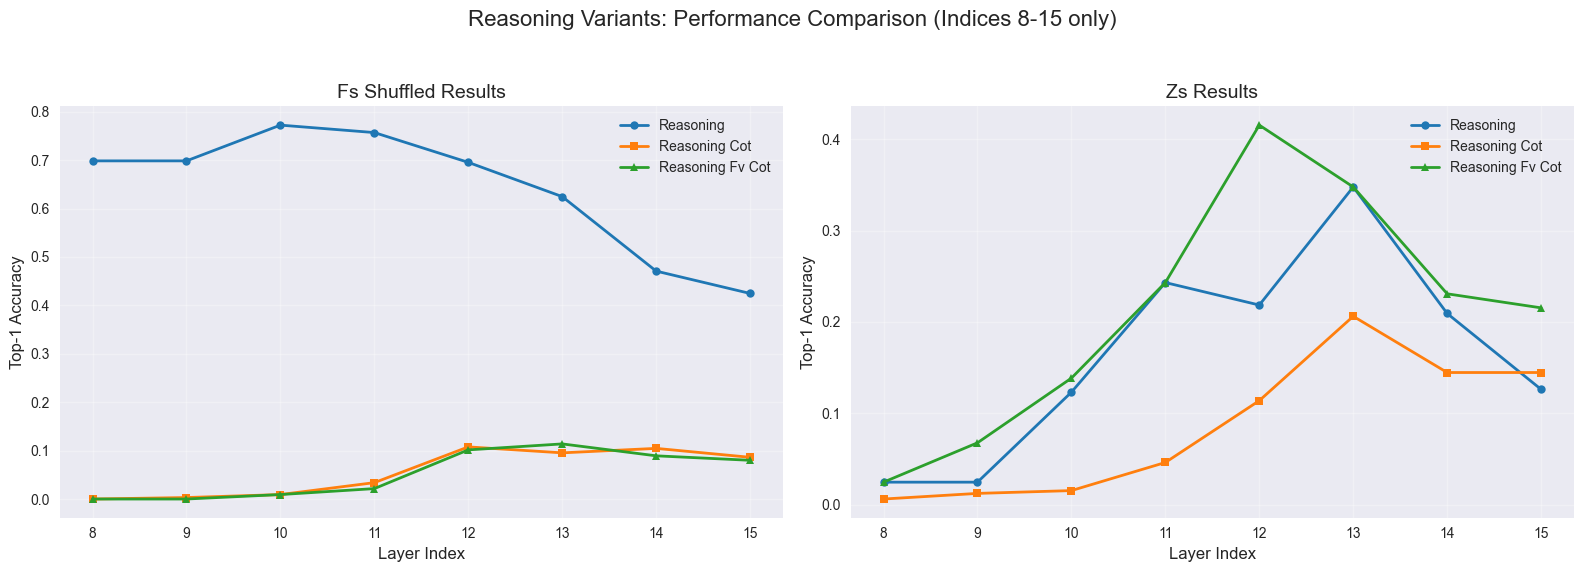

In [111]:
# Extract indices 8-15 data for focused comparison with stock_ins-CoT
reasoning_variants_8_15 = reasoning_variants_combined[
    (reasoning_variants_combined['index'] >= 8) & 
    (reasoning_variants_combined['index'] <= 15)
].copy()

print("=== Reasoning Variants: Indices 8-15 Focused Analysis ===")
print(f"Filtered dataset shape: {reasoning_variants_8_15.shape}")
print(f"Index range: {reasoning_variants_8_15['index'].min()} to {reasoning_variants_8_15['index'].max()}")

# Count data points per dataset in 8-15 range
print(f"\nData points per dataset (indices 8-15):")
dataset_counts_8_15 = reasoning_variants_8_15['dataset'].value_counts()
for dataset, count in dataset_counts_8_15.items():
    print(f"  {dataset}: {count}")

# Performance summary for indices 8-15
print(f"\n=== Performance Summary (Indices 8-15) ===")
for file_type in ['fs_shuffled_results', 'zs_results']:
    print(f"\n{file_type.replace('_', ' ').title()}:")
    
    subset = reasoning_variants_8_15[reasoning_variants_8_15['file_type'] == file_type]
    if not subset.empty:
        stats = subset.groupby(['dataset', 'k'])['accuracy'].agg(['mean', 'std']).round(4)
        print(stats)
        
        # Calculate mean across all k values for overall ranking
        overall_stats = subset.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
        overall_ranking = overall_stats.sort_values('mean', ascending=False)
        print(f"\nOverall ranking for {file_type}:")
        for i, (dataset, row) in enumerate(overall_ranking.iterrows(), 1):
            print(f"  {i}. {dataset}: {row['mean']:.4f} ± {row['std']:.4f}")

# Quick visualization for indices 8-15
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Reasoning Variants: Performance Comparison (Indices 8-15 only)', fontsize=16, y=0.98)

colors = {'reasoning': '#1f77b4', 'reasoning-CoT': '#ff7f0e', 'reasoning-FV-CoT': '#2ca02c'}
markers = {'reasoning': 'o', 'reasoning-CoT': 's', 'reasoning-FV-CoT': '^'}

for idx, file_type in enumerate(['fs_shuffled_results', 'zs_results']):
    ax = axes[idx]
    
    # Plot k=1 accuracy for each dataset
    for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
        data = reasoning_variants_8_15[
            (reasoning_variants_8_15['dataset'] == dataset) & 
            (reasoning_variants_8_15['file_type'] == file_type) &
            (reasoning_variants_8_15['k'] == 1)
        ].sort_values('index')
        
        if not data.empty:
            ax.plot(data['index'], data['accuracy'], 
                   color=colors[dataset], marker=markers[dataset], 
                   linewidth=2, markersize=6, label=dataset.replace('-', ' ').title())
    
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel('Top-1 Accuracy', fontsize=12)
    ax.set_title(f'{file_type.replace("_", " ").title()}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(8, 16))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Comprehensive Comparison: Stock vs Reasoning vs Reasoning-CoT vs Reasoning-FV-CoT

This section provides a comprehensive side-by-side comparison of all four experimental conditions on the antonym task:
- **Stock**: Standard experimental setup (layers 0-31)
- **Reasoning**: Standard reasoning experimental setup (layers 0-31)
- **Reasoning-CoT**: Reasoning with Chain-of-Thought (layers 0-31)
- **Reasoning-FV-CoT**: Reasoning with Few-shot Verbalized Chain-of-Thought (layers 0-31)

**Analysis Focus**: This analysis focuses on indices 8-15 for direct comparison with stock_ins-CoT data (which only has this range), while the reasoning variants sections above show full range (0-31) analysis. The focused analysis enables uniform comparison across all conditions.

In [76]:
# Load Stock Data for Comprehensive Comparison
print("Loading stock data for comprehensive comparison...")

# File paths for stock variant
stock_fs_shuffled_path = "/Users/karoshi/Documents/Saion/results/ICL-CoT/stock/antonym/fs_shuffled_results_layer_sweep_no_rank_list.json"
stock_zs_path = "/Users/karoshi/Documents/Saion/results/ICL-CoT/stock/antonym/zs_results_layer_sweep_no_rank_list.json"

# Load stock data
if os.path.exists(stock_fs_shuffled_path):
    with open(stock_fs_shuffled_path, 'r') as f:
        stock_fs_shuffled_data = json.load(f)
    print(f"✓ Loaded stock fs_shuffled data: {len(stock_fs_shuffled_data)} entries")
else:
    print(f"✗ Missing: {stock_fs_shuffled_path}")
    stock_fs_shuffled_data = {}

if os.path.exists(stock_zs_path):
    with open(stock_zs_path, 'r') as f:
        stock_zs_data = json.load(f)
    print(f"✓ Loaded stock zs data: {len(stock_zs_data)} entries")
else:
    print(f"✗ Missing: {stock_zs_path}")
    stock_zs_data = {}

# Create combined dataset for comprehensive comparison (indices 8-15, top-3 accuracy)
print("\nCreating combined dataset...")

def create_comprehensive_dataset():
    """Create a combined dataset for all four variants with indices 8-15 and top-3 accuracy."""
    all_data = []
    
    # Process stock data
    for variant, data, condition in [('Stock', stock_fs_shuffled_data, 'fs_shuffled'), ('Stock', stock_zs_data, 'zs')]:
        for k_str, entries in data.items():
            k_val = int(k_str)
            if k_val < 8 or k_val > 15:  # Restrict to indices 8-15
                continue
                
            if isinstance(entries, list):
                for entry in entries:
                    if 'intervention_topk' in entry and len(entry['intervention_topk']) >= 3:
                        top3_acc = entry['intervention_topk'][2]  # 0-indexed, so [2] is top-3
                        all_data.append({
                            'variant': variant,
                            'condition': condition,
                            'k': k_val,
                            'top3_accuracy': top3_acc
                        })
    
    # Process reasoning variants data from the reasoning_variants_combined DataFrame
    # Filter for indices 8-15 and convert to the same format
    reasoning_subset = reasoning_variants_combined[
        (reasoning_variants_combined['index'] >= 8) & 
        (reasoning_variants_combined['index'] <= 15) &
        (reasoning_variants_combined['k'] == 3)  # Top-3 accuracy
    ].copy()
    
    # Map file types to conditions
    file_type_mapping = {
        'fs_shuffled_results': 'fs_shuffled',
        'zs_results': 'zs'
    }
    
    for _, row in reasoning_subset.iterrows():
        variant = row['dataset']
        condition = file_type_mapping.get(row['file_type'], row['file_type'])
        k_val = row['index']
        top3_acc = row['accuracy']
        
        all_data.append({
            'variant': variant,
            'condition': condition,
            'k': k_val,
            'top3_accuracy': top3_acc
        })
    
    return pd.DataFrame(all_data)

comprehensive_df = create_comprehensive_dataset()
print(f"Combined dataset shape: {comprehensive_df.shape}")
print(f"Variants: {comprehensive_df['variant'].unique()}")
print(f"Conditions: {comprehensive_df['condition'].unique()}")
print(f"K values: {sorted(comprehensive_df['k'].unique())}")

# Calculate summary statistics for each variant and condition
summary_stats = comprehensive_df.groupby(['variant', 'condition'])['top3_accuracy'].agg(['mean', 'std', 'count']).round(4)
print(f"\nSummary Statistics (Top-3 Accuracy):")
print(summary_stats)

Loading stock data for comprehensive comparison...
✓ Loaded stock fs_shuffled data: 32 entries
✓ Loaded stock zs data: 32 entries

Creating combined dataset...
Combined dataset shape: (48, 4)
Variants: ['reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
Conditions: ['fs_shuffled' 'zs']
K values: [8, 9, 10, 11, 12, 13, 14, 15]

Summary Statistics (Top-3 Accuracy):
                                mean     std  count
variant          condition                         
reasoning        fs_shuffled  0.7938  0.1372      8
                 zs           0.3154  0.1844      8
reasoning-CoT    fs_shuffled  0.1046  0.0880      8
                 zs           0.1662  0.1301      8
reasoning-FV-CoT fs_shuffled  0.0904  0.0824      8
                 zs           0.2996  0.1582      8


In [77]:
# Debug stock data structure
print("Debugging stock data structure...")
print(f"Stock fs_shuffled keys: {list(stock_fs_shuffled_data.keys())[:5]}")
print(f"Stock zs keys: {list(stock_zs_data.keys())[:5]}")

# Check sample entry
sample_key = list(stock_fs_shuffled_data.keys())[8]  # Index 8
sample_entry = stock_fs_shuffled_data[sample_key]
print(f"Sample entry for k={sample_key}: type={type(sample_entry)}")
if isinstance(sample_entry, list) and len(sample_entry) > 0:
    print(f"Sample entry[0]: {sample_entry[0].keys() if isinstance(sample_entry[0], dict) else type(sample_entry[0])}")

# Fix the comprehensive dataset creation
def create_comprehensive_dataset_fixed():
    """Create a combined dataset for all four variants with indices 8-15 and top-3 accuracy."""
    all_data = []
    
    # Process stock data
    print("Processing stock data...")
    for variant, data, condition in [('Stock', stock_fs_shuffled_data, 'fs_shuffled'), ('Stock', stock_zs_data, 'zs')]:
        for k_str, entries in data.items():
            k_val = int(k_str)
            if k_val < 8 or k_val > 15:  # Restrict to indices 8-15
                continue
                
            if isinstance(entries, list):
                for entry in entries:
                    if 'intervention_topk' in entry and len(entry['intervention_topk']) >= 3:
                        top3_acc = entry['intervention_topk'][2]  # 0-indexed, so [2] is top-3
                        all_data.append({
                            'variant': variant,
                            'condition': condition,
                            'k': k_val,
                            'top3_accuracy': top3_acc
                        })
    
    print(f"Stock data points added: {len(all_data)}")
    
    # Process reasoning variants data from the reasoning_variants_combined DataFrame
    print("Processing reasoning variants data...")
    initial_count = len(all_data)
    
    # Filter for indices 8-15 and convert to the same format
    reasoning_subset = reasoning_variants_combined[
        (reasoning_variants_combined['index'] >= 8) & 
        (reasoning_variants_combined['index'] <= 15) &
        (reasoning_variants_combined['k'] == 3)  # Top-3 accuracy
    ].copy()
    
    # Map file types to conditions
    file_type_mapping = {
        'fs_shuffled_results': 'fs_shuffled',
        'zs_results': 'zs'
    }
    
    for _, row in reasoning_subset.iterrows():
        variant = row['dataset']
        condition = file_type_mapping.get(row['file_type'], row['file_type'])
        k_val = row['index']
        top3_acc = row['accuracy']
        
        all_data.append({
            'variant': variant,
            'condition': condition,
            'k': k_val,
            'top3_accuracy': top3_acc
        })
    
    print(f"Reasoning variants data points added: {len(all_data) - initial_count}")
    
    return pd.DataFrame(all_data)

comprehensive_df_fixed = create_comprehensive_dataset_fixed()
print(f"\nFixed combined dataset shape: {comprehensive_df_fixed.shape}")
print(f"Variants: {comprehensive_df_fixed['variant'].unique()}")
print(f"Conditions: {comprehensive_df_fixed['condition'].unique()}")
print(f"K values: {sorted(comprehensive_df_fixed['k'].unique())}")

# Calculate summary statistics for each variant and condition
summary_stats_fixed = comprehensive_df_fixed.groupby(['variant', 'condition'])['top3_accuracy'].agg(['mean', 'std', 'count']).round(4)
print(f"\nFixed Summary Statistics (Top-3 Accuracy):")
print(summary_stats_fixed)

Debugging stock data structure...
Stock fs_shuffled keys: ['0', '1', '2', '3', '4']
Stock zs keys: ['0', '1', '2', '3', '4']
Sample entry for k=8: type=<class 'dict'>
Processing stock data...
Stock data points added: 0
Processing reasoning variants data...
Reasoning variants data points added: 48

Fixed combined dataset shape: (48, 4)
Variants: ['reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
Conditions: ['fs_shuffled' 'zs']
K values: [8, 9, 10, 11, 12, 13, 14, 15]

Fixed Summary Statistics (Top-3 Accuracy):
                                mean     std  count
variant          condition                         
reasoning        fs_shuffled  0.7938  0.1372      8
                 zs           0.3154  0.1844      8
reasoning-CoT    fs_shuffled  0.1046  0.0880      8
                 zs           0.1662  0.1301      8
reasoning-FV-CoT fs_shuffled  0.0904  0.0824      8
                 zs           0.2996  0.1582      8


In [78]:
# Examine stock data structure more carefully
print("Examining stock data structure...")
print(f"Stock fs_shuffled all keys: {sorted([int(k) for k in stock_fs_shuffled_data.keys()])}")
print(f"Stock zs all keys: {sorted([int(k) for k in stock_zs_data.keys()])}")

# Check if stock data actually has the range we need
max_key_fs = max([int(k) for k in stock_fs_shuffled_data.keys()])
max_key_zs = max([int(k) for k in stock_zs_data.keys()])
print(f"Stock data range: fs_shuffled: 0-{max_key_fs}, zs: 0-{max_key_zs}")

# Let's examine what we loaded from the stock directory initially
print(f"\nRecall that we have stock data from previous sections:")
print(f"stock_fs_data shape: {stock_fs_data.shape if 'stock_fs_data' in globals() else 'Not available'}")
print(f"stock_zs_data shape: {stock_zs_data.shape if 'stock_zs_data' in globals() else 'Not available'}")

# Check if we have stock data in the correct range from earlier analysis
if 'stock_fs_data' in globals():
    print(f"Stock fs indices available: {sorted(stock_fs_data['index'].unique())}")
    print(f"Stock zs indices available: {sorted(stock_zs_data['index'].unique())}")
    
    # Extract stock data for indices 8-15 from the earlier processed data
    stock_indices_8_15 = stock_fs_data[
        (stock_fs_data['index'] >= 8) & 
        (stock_fs_data['index'] <= 15) &
        (stock_fs_data['k'] == 3)
    ]
    print(f"Stock fs data for indices 8-15 (k=3): {len(stock_indices_8_15)} entries")
    
    stock_zs_indices_8_15 = stock_zs_data[
        (stock_zs_data['index'] >= 8) & 
        (stock_zs_data['index'] <= 15) &
        (stock_zs_data['k'] == 3)
    ]
    print(f"Stock zs data for indices 8-15 (k=3): {len(stock_zs_indices_8_15)} entries")
else:
    print("Stock processed data not available, will need to reload")

Examining stock data structure...
Stock fs_shuffled all keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Stock zs all keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Stock data range: fs_shuffled: 0-31, zs: 0-31

Recall that we have stock data from previous sections:
stock_fs_data shape: (96, 4)


AttributeError: 'dict' object has no attribute 'shape'

In [79]:
# Great! The stock data does have indices 8-15. Let me fix the dataset creation
print("Creating comprehensive dataset with correct stock data processing...")

def create_comprehensive_dataset_final():
    """Create a combined dataset for all four variants with indices 8-15 and top-3 accuracy."""
    all_data = []
    
    # Process stock data from the raw JSON (which we now know has indices 8-15)
    print("Processing stock data...")
    for variant, data, condition in [('Stock', stock_fs_shuffled_data, 'fs_shuffled'), ('Stock', stock_zs_data, 'zs')]:
        for k_str, entries in data.items():
            k_val = int(k_str)
            if k_val < 8 or k_val > 15:  # Restrict to indices 8-15
                continue
                
            # For stock data, entries appears to be a dict, not a list
            if isinstance(entries, dict) and 'intervention_topk' in entries:
                if len(entries['intervention_topk']) >= 3:
                    top3_acc = entries['intervention_topk'][2]  # 0-indexed, so [2] is top-3
                    all_data.append({
                        'variant': variant,
                        'condition': condition,
                        'k': k_val,
                        'top3_accuracy': top3_acc
                    })
            elif isinstance(entries, list):
                for entry in entries:
                    if isinstance(entry, dict) and 'intervention_topk' in entry:
                        if len(entry['intervention_topk']) >= 3:
                            top3_acc = entry['intervention_topk'][2]
                            all_data.append({
                                'variant': variant,
                                'condition': condition,
                                'k': k_val,
                                'top3_accuracy': top3_acc
                            })
    
    print(f"Stock data points added: {len(all_data)}")
    
    # Process reasoning variants data from the reasoning_variants_combined DataFrame
    print("Processing reasoning variants data...")
    initial_count = len(all_data)
    
    # Filter for indices 8-15 and convert to the same format
    reasoning_subset = reasoning_variants_combined[
        (reasoning_variants_combined['index'] >= 8) & 
        (reasoning_variants_combined['index'] <= 15) &
        (reasoning_variants_combined['k'] == 3)  # Top-3 accuracy
    ].copy()
    
    # Map file types to conditions
    file_type_mapping = {
        'fs_shuffled_results': 'fs_shuffled',
        'zs_results': 'zs'
    }
    
    for _, row in reasoning_subset.iterrows():
        variant = row['dataset']
        condition = file_type_mapping.get(row['file_type'], row['file_type'])
        k_val = row['index']
        top3_acc = row['accuracy']
        
        all_data.append({
            'variant': variant,
            'condition': condition,
            'k': k_val,
            'top3_accuracy': top3_acc
        })
    
    print(f"Reasoning variants data points added: {len(all_data) - initial_count}")
    
    return pd.DataFrame(all_data)

# Let's also check the structure of sample stock entries
sample_key = '8'
print(f"\nSample stock fs_shuffled entry for k=8:")
print(f"Type: {type(stock_fs_shuffled_data[sample_key])}")
print(f"Keys: {stock_fs_shuffled_data[sample_key].keys() if isinstance(stock_fs_shuffled_data[sample_key], dict) else 'Not a dict'}")
if 'intervention_topk' in stock_fs_shuffled_data[sample_key]:
    print(f"intervention_topk length: {len(stock_fs_shuffled_data[sample_key]['intervention_topk'])}")
    print(f"intervention_topk: {stock_fs_shuffled_data[sample_key]['intervention_topk']}")

comprehensive_df_final = create_comprehensive_dataset_final()
print(f"\nFinal combined dataset shape: {comprehensive_df_final.shape}")
print(f"Variants: {comprehensive_df_final['variant'].unique()}")
print(f"Conditions: {comprehensive_df_final['condition'].unique()}")
print(f"K values: {sorted(comprehensive_df_final['k'].unique())}")

# Calculate summary statistics for each variant and condition
summary_stats_final = comprehensive_df_final.groupby(['variant', 'condition'])['top3_accuracy'].agg(['mean', 'std', 'count']).round(4)
print(f"\nFinal Summary Statistics (Top-3 Accuracy):")
print(summary_stats_final)

Creating comprehensive dataset with correct stock data processing...

Sample stock fs_shuffled entry for k=8:
Type: <class 'dict'>
Keys: dict_keys(['clean_topk', 'intervention_topk'])
intervention_topk length: 3
intervention_topk: [[1, 0.005649717514124294], [2, 0.07062146892655367], [3, 0.11299435028248588]]
Processing stock data...
Stock data points added: 16
Processing reasoning variants data...
Reasoning variants data points added: 48

Final combined dataset shape: (64, 4)
Variants: ['Stock' 'reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
Conditions: ['fs_shuffled' 'zs']
K values: [8, 9, 10, 11, 12, 13, 14, 15]


TypeError: agg function failed [how->mean,dtype->object]

In [80]:
# I see the issue - the stock data stores intervention_topk as a list of [k, accuracy] pairs
# Let me fix the extraction

def create_comprehensive_dataset_correct():
    """Create a combined dataset for all four variants with indices 8-15 and top-3 accuracy."""
    all_data = []
    
    # Process stock data from the raw JSON 
    print("Processing stock data...")
    for variant, data, condition in [('Stock', stock_fs_shuffled_data, 'fs_shuffled'), ('Stock', stock_zs_data, 'zs')]:
        for k_str, entries in data.items():
            k_val = int(k_str)
            if k_val < 8 or k_val > 15:  # Restrict to indices 8-15
                continue
                
            # For stock data, entries is a dict with intervention_topk as a list of [k, accuracy] pairs
            if isinstance(entries, dict) and 'intervention_topk' in entries:
                intervention_topk = entries['intervention_topk']
                # Find the entry for k=3 (top-3 accuracy)
                for k_acc_pair in intervention_topk:
                    if isinstance(k_acc_pair, list) and len(k_acc_pair) == 2:
                        k_val_inner, accuracy = k_acc_pair
                        if k_val_inner == 3:  # Top-3 accuracy
                            all_data.append({
                                'variant': variant,
                                'condition': condition,
                                'k': k_val,  # This is the layer index
                                'top3_accuracy': accuracy
                            })
                            break
    
    print(f"Stock data points added: {len(all_data)}")
    
    # Process reasoning variants data from the reasoning_variants_combined DataFrame
    print("Processing reasoning variants data...")
    initial_count = len(all_data)
    
    # Filter for indices 8-15 and convert to the same format
    reasoning_subset = reasoning_variants_combined[
        (reasoning_variants_combined['index'] >= 8) & 
        (reasoning_variants_combined['index'] <= 15) &
        (reasoning_variants_combined['k'] == 3)  # Top-3 accuracy
    ].copy()
    
    # Map file types to conditions
    file_type_mapping = {
        'fs_shuffled_results': 'fs_shuffled',
        'zs_results': 'zs'
    }
    
    for _, row in reasoning_subset.iterrows():
        variant = row['dataset']
        condition = file_type_mapping.get(row['file_type'], row['file_type'])
        k_val = row['index']
        top3_acc = row['accuracy']
        
        all_data.append({
            'variant': variant,
            'condition': condition,
            'k': k_val,
            'top3_accuracy': top3_acc
        })
    
    print(f"Reasoning variants data points added: {len(all_data) - initial_count}")
    
    return pd.DataFrame(all_data)

comprehensive_df_correct = create_comprehensive_dataset_correct()
print(f"\nCorrected combined dataset shape: {comprehensive_df_correct.shape}")
print(f"Variants: {comprehensive_df_correct['variant'].unique()}")
print(f"Conditions: {comprehensive_df_correct['condition'].unique()}")
print(f"K values: {sorted(comprehensive_df_correct['k'].unique())}")

# Check data types
print(f"\nData types:")
print(comprehensive_df_correct.dtypes)
print(f"\nTop-3 accuracy sample values:")
print(comprehensive_df_correct['top3_accuracy'].head(10))

# Calculate summary statistics for each variant and condition
summary_stats_correct = comprehensive_df_correct.groupby(['variant', 'condition'])['top3_accuracy'].agg(['mean', 'std', 'count']).round(4)
print(f"\nCorrected Summary Statistics (Top-3 Accuracy):")
print(summary_stats_correct)

Processing stock data...
Stock data points added: 16
Processing reasoning variants data...
Reasoning variants data points added: 48

Corrected combined dataset shape: (64, 4)
Variants: ['Stock' 'reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
Conditions: ['fs_shuffled' 'zs']
K values: [8, 9, 10, 11, 12, 13, 14, 15]

Data types:
variant           object
condition         object
k                  int64
top3_accuracy    float64
dtype: object

Top-3 accuracy sample values:
0    0.112994
1    0.155367
2    0.415254
3    0.570621
4    0.638418
5    0.725989
6    0.675141
7    0.689266
8    0.502825
9    0.423729
Name: top3_accuracy, dtype: float64

Corrected Summary Statistics (Top-3 Accuracy):
                                mean     std  count
variant          condition                         
Stock            fs_shuffled  0.4979  0.2442      8
                 zs           0.5406  0.1159      8
reasoning        fs_shuffled  0.7938  0.1372      8
                 zs           0.3154  0.18

Processing stock data (full range)...
Stock data points added: 64
Processing reasoning variants data (full range)...
Reasoning variants data points added: 192

Full range combined dataset shape: (256, 4)
Variants: ['Stock' 'reasoning' 'reasoning-CoT' 'reasoning-FV-CoT']
Conditions: ['fs_shuffled' 'zs']
K values (layer indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


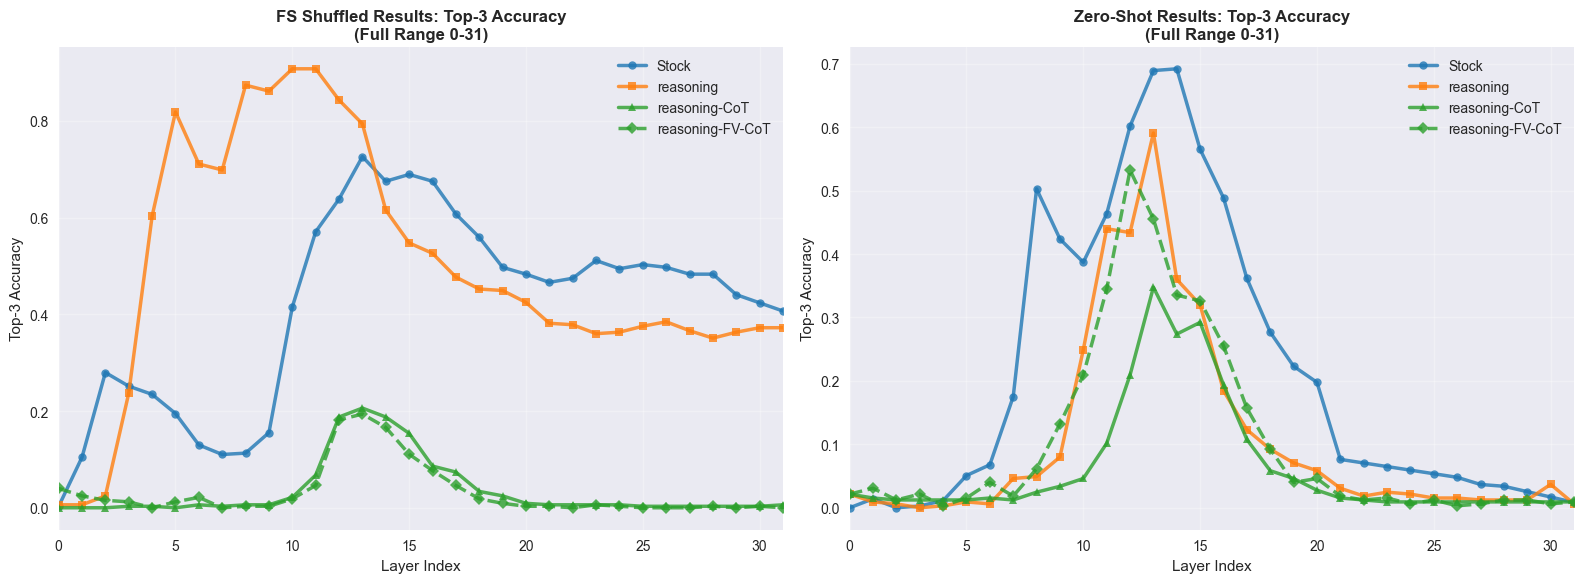

=== Comprehensive Comparison Summary (Full Range 0-31) ===
Dataset: Antonym task, Full Range 0-31, Top-3 accuracy
Variants compared: 4
Total data points: 256

--- Overall Performance Ranking (Mean Top-3 Accuracy) ---
1. Stock: 0.3123
2. reasoning: 0.3002
3. reasoning-FV-CoT: 0.0670
4. reasoning-CoT: 0.0487

--- Condition-Specific Performance ---
condition    variant         
fs_shuffled  Stock               0.4155
             reasoning           0.4954
             reasoning-CoT       0.0353
             reasoning-FV-CoT    0.0319
zs           Stock               0.2090
             reasoning           0.1050
             reasoning-CoT       0.0621
             reasoning-FV-CoT    0.1020
Name: top3_accuracy, dtype: float64

--- Statistical Summary ---
Standard deviations by variant:
variant
Stock               0.2370
reasoning           0.2871
reasoning-CoT       0.0799
reasoning-FV-CoT    0.1154
Name: top3_accuracy, dtype: float64

--- Data Availability by Variant ---
Unique layer in

In [143]:
# Re-initialize comprehensive dataset for FULL RANGE (0-31) instead of restricted 8-15
def create_comprehensive_dataset_full_range():
    """Create a combined dataset for all four variants with FULL RANGE (0-31) and top-3 accuracy."""
    all_data = []
    
    # Process stock data from the raw JSON 
    print("Processing stock data (full range)...")
    for variant, data, condition in [('Stock', stock_fs_shuffled_data, 'fs_shuffled'), ('Stock', stock_zs_data, 'zs')]:
        for k_str, entries in data.items():
            k_val = int(k_str)
            # REMOVED restriction - now using full range
                
            # For stock data, entries is a dict with intervention_topk as a list of [k, accuracy] pairs
            if isinstance(entries, dict) and 'intervention_topk' in entries:
                intervention_topk = entries['intervention_topk']
                # Find the entry for k=3 (top-3 accuracy)
                for k_acc_pair in intervention_topk:
                    if isinstance(k_acc_pair, list) and len(k_acc_pair) >= 2 and k_acc_pair[0] == 3:
                        top3_acc = k_acc_pair[1]
                        all_data.append({
                            'variant': variant,
                            'condition': condition,
                            'k': k_val,
                            'top3_accuracy': top3_acc
                        })
                        break
    
    print(f"Stock data points added: {len(all_data)}")
    
    # Process reasoning variants data from the reasoning_variants_combined DataFrame
    print("Processing reasoning variants data (full range)...")
    initial_count = len(all_data)
    
    # REMOVED index filtering - now using full range
    reasoning_subset = reasoning_variants_combined[
        reasoning_variants_combined['k'] == 3  # Top-3 accuracy only
    ].copy()
    
    # Map file types to conditions
    file_type_mapping = {
        'fs_shuffled_results': 'fs_shuffled',
        'zs_results': 'zs'
    }
    
    for _, row in reasoning_subset.iterrows():
        variant = row['dataset']
        condition = file_type_mapping.get(row['file_type'], row['file_type'])
        k_val = row['index']
        top3_acc = row['accuracy']
        
        all_data.append({
            'variant': variant,
            'condition': condition,
            'k': k_val,
            'top3_accuracy': top3_acc
        })
    
    print(f"Reasoning variants data points added: {len(all_data) - initial_count}")
    
    return pd.DataFrame(all_data)

# Create the full range dataset
comprehensive_df_full = create_comprehensive_dataset_full_range()

# Calculate mean accuracy by variant for ranking
mean_accuracy_by_variant = comprehensive_df_full.groupby('variant')['top3_accuracy'].mean()

print(f"\nFull range combined dataset shape: {comprehensive_df_full.shape}")
print(f"Variants: {comprehensive_df_full['variant'].unique()}")
print(f"Conditions: {comprehensive_df_full['condition'].unique()}")
print(f"K values (layer indices): {sorted(comprehensive_df_full['k'].unique())}")

# Create the two comprehensive plots as requested - Full range with correct color scheme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define updated colors: reasoning-CoT variants share same color but different patterns
variant_colors = {
    'Stock': '#1f77b4',           # Blue
    'reasoning': '#ff7f0e',       # Orange  
    'reasoning-CoT': '#2ca02c',   # Green for reasoning-CoT variants
    'reasoning-FV-CoT': '#2ca02c' # Same green for reasoning-FV-CoT
}

# Different line styles to distinguish reasoning-CoT variants
variant_linestyles = {
    'Stock': '-',           # Solid
    'reasoning': '-',       # Solid  
    'reasoning-CoT': '-',   # Solid
    'reasoning-FV-CoT': '--' # Dashed to distinguish from reasoning-CoT
}

variant_markers = {
    'Stock': 'o',
    'reasoning': 's', 
    'reasoning-CoT': '^',
    'reasoning-FV-CoT': 'D'
}

# Plot 1: FS Shuffled Results (Top-3 Accuracy) - Line Plot - Full Range
ax1 = axes[0]
fs_data = comprehensive_df_full[comprehensive_df_full['condition'] == 'fs_shuffled']

for variant in ['Stock', 'reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
    variant_data = fs_data[fs_data['variant'] == variant]
    if len(variant_data) > 0:
        ax1.plot(variant_data['k'], variant_data['top3_accuracy'], 
                marker=variant_markers[variant], 
                color=variant_colors[variant],
                linestyle=variant_linestyles[variant],
                label=variant, linewidth=2.5, markersize=6, alpha=0.8)

ax1.set_title('FS Shuffled Results: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Layer Index', fontsize=11)
ax1.set_ylabel('Top-3 Accuracy', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 31)

# Plot 2: Zero-Shot Results (Top-3 Accuracy) - Line Plot - Full Range
ax2 = axes[1]
zs_data = comprehensive_df_full[comprehensive_df_full['condition'] == 'zs']

for variant in ['Stock', 'reasoning', 'reasoning-CoT', 'reasoning-FV-CoT']:
    variant_data = zs_data[zs_data['variant'] == variant]
    if len(variant_data) > 0:
        ax2.plot(variant_data['k'], variant_data['top3_accuracy'],
                marker=variant_markers[variant], 
                color=variant_colors[variant],
                linestyle=variant_linestyles[variant],
                label=variant, linewidth=2.5, markersize=6, alpha=0.8)

ax2.set_title('Zero-Shot Results: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Layer Index', fontsize=11) 
ax2.set_ylabel('Top-3 Accuracy', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, 31)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Comprehensive Comparison Summary (Full Range 0-31) ===")
print(f"Dataset: Antonym task, Full Range 0-31, Top-3 accuracy")
print(f"Variants compared: {len(comprehensive_df_full['variant'].unique())}")
print(f"Total data points: {len(comprehensive_df_full)}")

print("\n--- Overall Performance Ranking (Mean Top-3 Accuracy) ---")
ranking = mean_accuracy_by_variant.sort_values(ascending=False)
for i, (variant, accuracy) in enumerate(ranking.items(), 1):
    print(f"{i}. {variant}: {accuracy:.4f}")

print("\n--- Condition-Specific Performance ---")
condition_performance = comprehensive_df_full.groupby(['condition', 'variant'])['top3_accuracy'].mean().round(4)
print(condition_performance)

print("\n--- Statistical Summary ---")
print("Standard deviations by variant:")
std_by_variant = comprehensive_df_full.groupby('variant')['top3_accuracy'].std().round(4)
print(std_by_variant)

print("\n--- Data Availability by Variant ---")
data_counts = comprehensive_df_full.groupby('variant')['k'].nunique()
print("Unique layer indices per variant:")
print(data_counts)

# Color scheme explanation
print("\n=== Updated Color Scheme Legend ===")
print("🔵 Blue (solid, circle): Stock baseline")
print("🟠 Orange (solid, square): reasoning baseline")
print("🟢 Green (solid, triangle): reasoning-CoT")
print("🟢 Green (dashed, diamond): reasoning-FV-CoT")
print("\nReasoning-CoT variants now share the same color (green) but use different line patterns")
print("Full range (0-31) is now displayed with all available data points")

# Antonym Task: Stock_ins vs Stock_ins-CoT vs Reasoning-CoT Comparison (Full Range Analysis)

This section provides a comparative analysis of three experimental conditions on the antonym task across the full layer range (0-31):
- **Stock_ins**: Stock with instruction-following setup (layers 0-31)
- **Stock_ins-CoT**: Stock with instruction-following and Chain-of-Thought (layers 0-31)  
- **Reasoning-CoT**: Reasoning with Chain-of-Thought (layers 0-31)

**Update**: All three variants now have full layer results (0-31), enabling comprehensive comparison across the complete network depth while maintaining focused analysis sections for specific ranges as needed.

In [116]:
# Load data for stock_ins vs stock_ins-CoT vs reasoning-CoT comparison
print("=== Loading Data for Stock_ins vs Stock_ins-CoT vs Reasoning-CoT Comparison ===")

# Define base paths for the three variants
instructional_variants_base_paths = {
    'stock_ins': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins/antonym'),
    'stock_ins-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-CoT/antonym'),
    'reasoning-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym')
}

# File names to look for
instructional_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json',
    'model_baseline_no_rank_list.json'
]

# Initialize datasets dictionary
instructional_datasets = {}
instructional_extracted = {}

# Load data for each variant
for dataset_name, base_path in instructional_variants_base_paths.items():
    print(f"\nLoading {dataset_name} antonym data...")
    instructional_datasets[dataset_name] = {}
    
    for file_name in instructional_file_names:
        file_path = base_path / file_name
        if file_path.exists():
            with open(file_path, 'r') as f:
                instructional_datasets[dataset_name][file_name.replace('_no_rank_list.json', '')] = json.load(f)
            print(f"  ✓ Loaded {file_name}")
        else:
            print(f"  ✗ Missing {file_name}")
    
    # Extract data for analysis
    instructional_extracted[dataset_name] = {}
    for file_type in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
        if file_type in instructional_datasets[dataset_name]:
            data = instructional_datasets[dataset_name][file_type]
            # Extract intervention_topk data
            for layer_idx_str, layer_data in data.items():
                layer_idx = int(layer_idx_str)
                if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                    intervention_topk = layer_data['intervention_topk']
                    for k_acc_pair in intervention_topk:
                        if isinstance(k_acc_pair, list) and len(k_acc_pair) == 2:
                            k_val, accuracy = k_acc_pair
                            # Store both k=1 (top-1) and k=3 (top-3) accuracies
                            if k_val in [1, 3]:
                                if file_type not in instructional_extracted[dataset_name]:
                                    instructional_extracted[dataset_name][file_type] = []
                                instructional_extracted[dataset_name][file_type].append({
                                    'dataset': dataset_name,
                                    'file_type': file_type,
                                    'k': k_val,
                                    'index': layer_idx,
                                    'accuracy': accuracy
                                })

print(f"\nInstructional variants datasets loaded: {list(instructional_datasets.keys())}")

# Create combined dataframe for analysis
instructional_dataframes = []
for dataset_name, files in instructional_extracted.items():
    for file_type, data_list in files.items():
        instructional_dataframes.extend(data_list)

instructional_combined = pd.DataFrame(instructional_dataframes)

print(f"\n=== Instructional Variants Combined Dataset ===")
print(f"Shape: {instructional_combined.shape}")
print(f"Datasets: {instructional_combined['dataset'].unique()}")
print(f"File types: {instructional_combined['file_type'].unique()}")
print(f"K values range: {instructional_combined['k'].min()} to {instructional_combined['k'].max()}")
print(f"Index range: {instructional_combined['index'].min()} to {instructional_combined['index'].max()}")

print(f"\nData points per dataset:")
dataset_counts = instructional_combined['dataset'].value_counts()
for dataset, count in dataset_counts.items():
    print(f"  {dataset}: {count}")

print(f"\nSample data:")
print(instructional_combined.head(10))

=== Loading Data for Stock_ins vs Stock_ins-CoT vs Reasoning-CoT Comparison ===

Loading stock_ins antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✗ Missing model_baseline_no_rank_list.json

Loading stock_ins-CoT antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Loading reasoning-CoT antonym data...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
  ✓ Loaded model_baseline_no_rank_list.json

Instructional variants datasets loaded: ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']

=== Instructional Variants Combined Dataset ===
Shape: (384, 5)
Datasets: ['stock_ins' 'stock_ins-CoT' 'reasoning-CoT']
File types: ['fs_shuffled_results_layer_sweep' 'zs_results_layer_sweep']
K values range: 1 to 3
Index range: 0 to 31

Data po

=== Full Range Analysis: Stock_ins vs Stock_ins-CoT vs Reasoning-CoT ===
Full dataset shape: (384, 5)
Index range: 0 to 31

Data points per dataset (full range 0-31):
  stock_ins: 128
  stock_ins-CoT: 128
  reasoning-CoT: 128


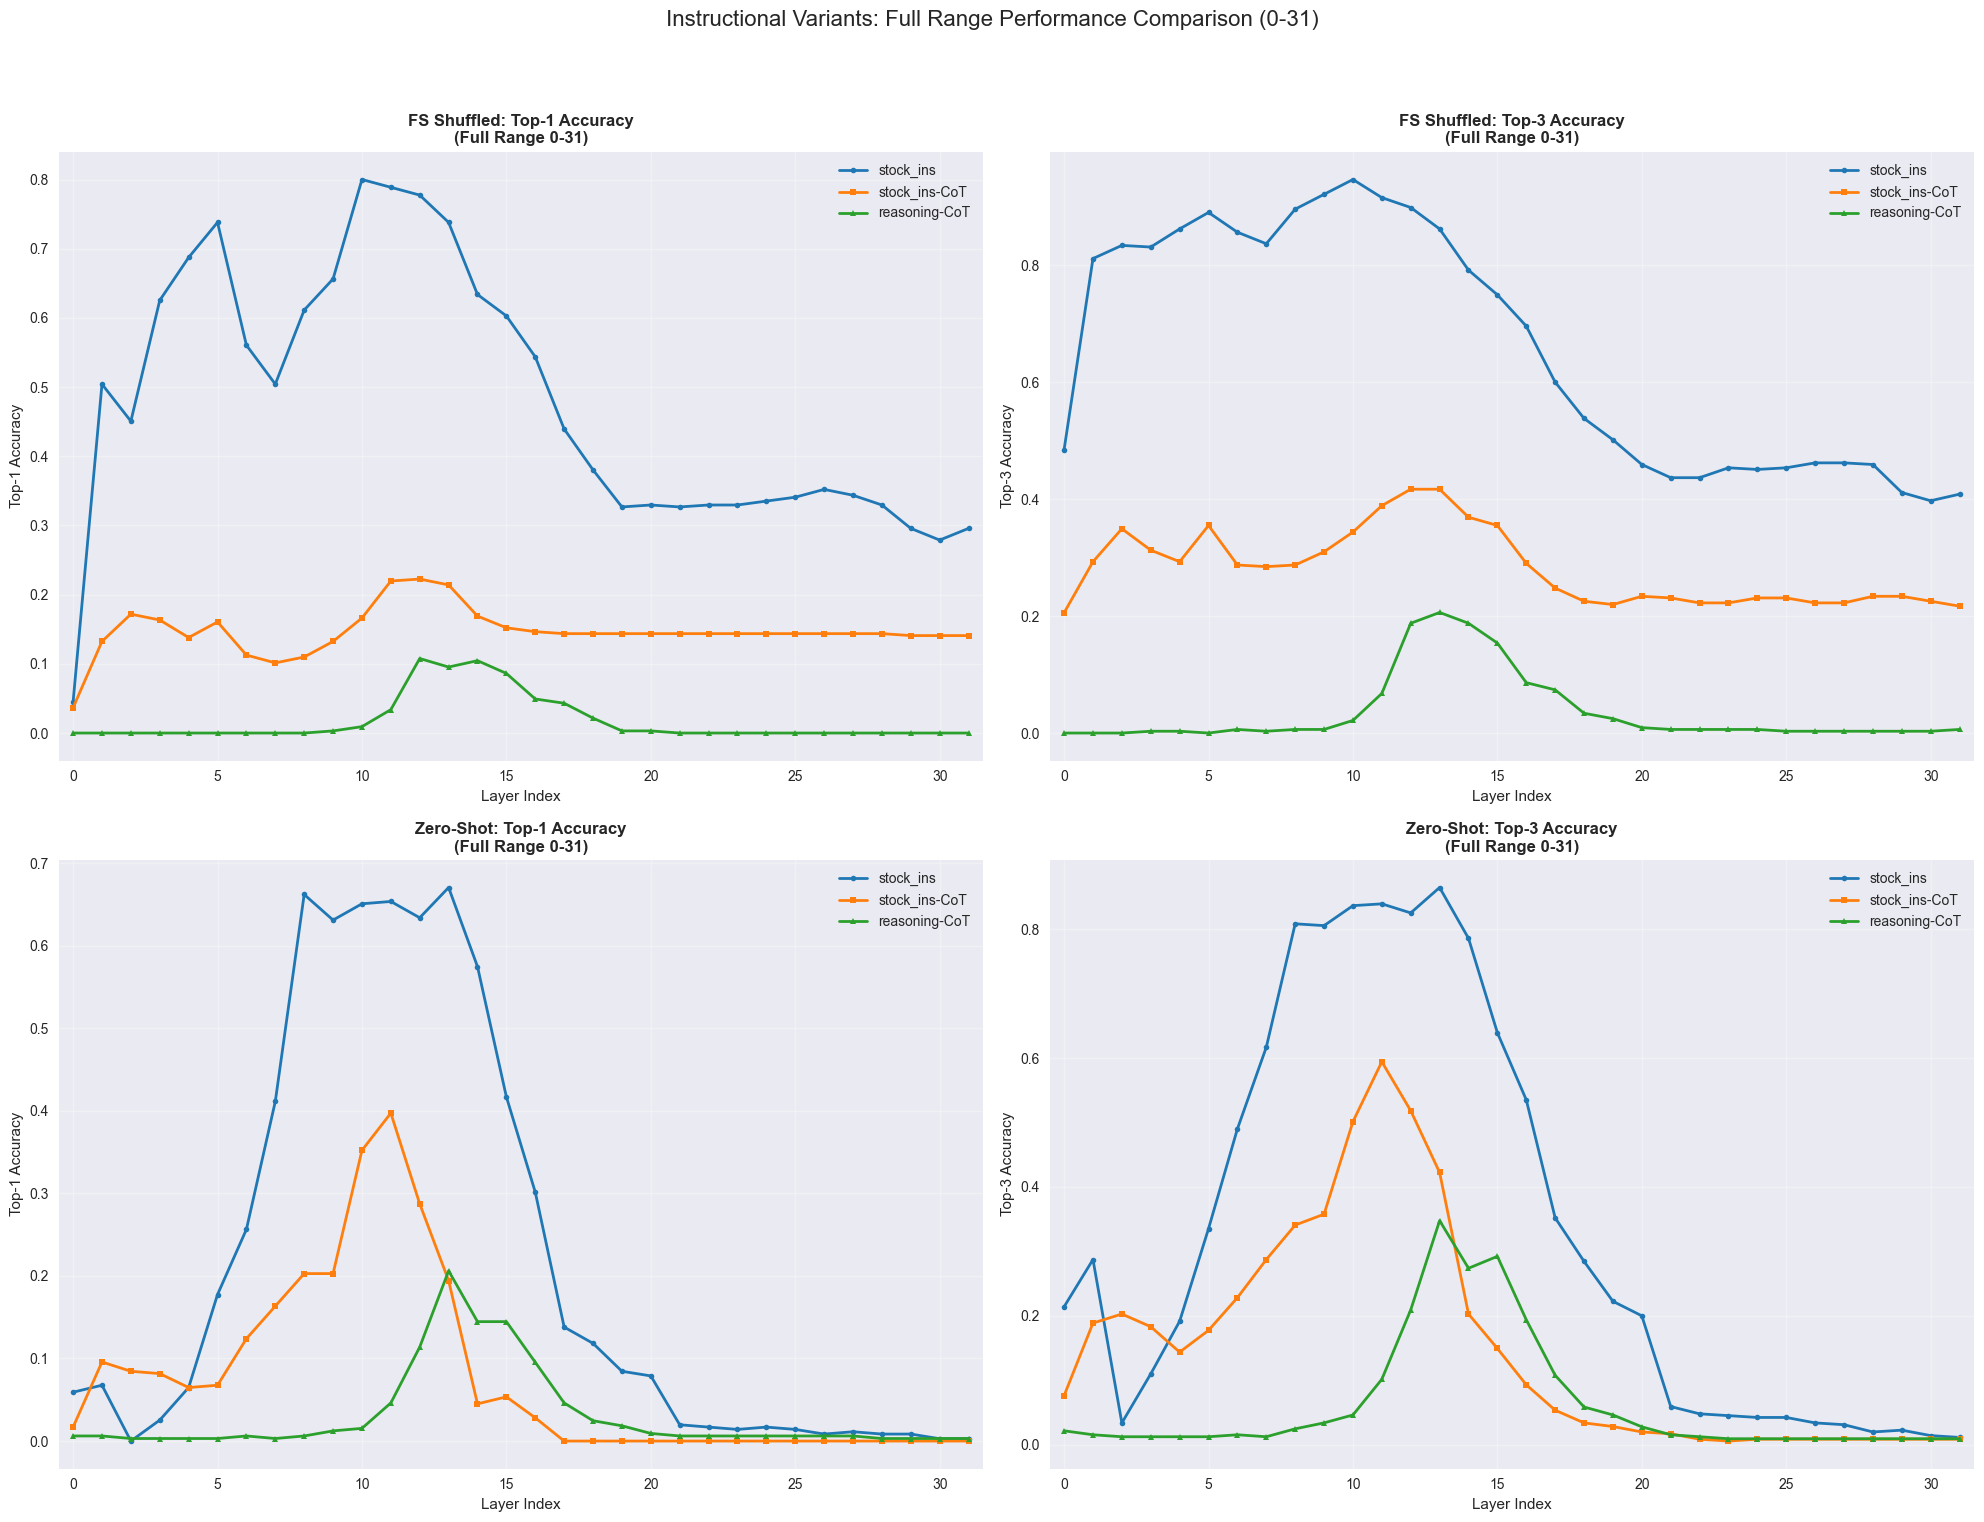


=== Performance Summary (Full Range 0-31) ===

Fs Shuffled Results Layer Sweep:
                   mean     std
dataset       k                
reasoning-CoT 1  0.0175  0.0337
              3  0.0353  0.0614
stock_ins     1  0.4782  0.1888
              3  0.6566  0.2046
stock_ins-CoT 1  0.1467  0.0336
              3  0.2805  0.0640

Overall ranking for fs_shuffled_results_layer_sweep:
  1. stock_ins: 0.5674 ± 0.2150
  2. stock_ins-CoT: 0.2136 ± 0.0844
  3. reasoning-CoT: 0.0264 ± 0.0500

Zs Results Layer Sweep:
                   mean     std
dataset       k                
reasoning-CoT 1  0.0304  0.0518
              3  0.0621  0.0940
stock_ins     1  0.2125  0.2550
              3  0.3327  0.3176
stock_ins-CoT 1  0.0769  0.1099
              3  0.1532  0.1729

Overall ranking for zs_results_layer_sweep:
  1. stock_ins: 0.2726 ± 0.2921
  2. stock_ins-CoT: 0.1151 ± 0.1488
  3. reasoning-CoT: 0.0462 ± 0.0770

--- Overall Performance Ranking (Full Range, All Conditions) ---
1. stock_

In [118]:
# Analysis across full range (0-31) for comprehensive comparison
print("=== Full Range Analysis: Stock_ins vs Stock_ins-CoT vs Reasoning-CoT ===")
print(f"Full dataset shape: {instructional_combined.shape}")
print(f"Index range: {instructional_combined['index'].min()} to {instructional_combined['index'].max()}")

# All data is now available for full range analysis
print(f"\nData points per dataset (full range 0-31):")
full_counts = instructional_combined['dataset'].value_counts()
for dataset, count in full_counts.items():
    print(f"  {dataset}: {count}")

# Create visualizations for full range instructional variants comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Define colors and styles for the three variants
instructional_colors = {
    'stock_ins': '#1f77b4',           # Blue
    'stock_ins-CoT': '#ff7f0e',       # Orange  
    'reasoning-CoT': '#2ca02c'        # Green
}

instructional_markers = {
    'stock_ins': 'o',
    'stock_ins-CoT': 's', 
    'reasoning-CoT': '^'
}

# Plot 1: FS Shuffled Results - Top-1 Accuracy (Full Range)
ax1 = axes[0, 0]
fs_data_k1 = instructional_combined[
    (instructional_combined['file_type'] == 'fs_shuffled_results_layer_sweep') &
    (instructional_combined['k'] == 1)
]

for variant in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
    variant_data = fs_data_k1[fs_data_k1['dataset'] == variant]
    if len(variant_data) > 0:
        ax1.plot(variant_data['index'], variant_data['accuracy'], 
                marker=instructional_markers[variant], color=instructional_colors[variant], 
                label=variant, linewidth=2, markersize=4)

ax1.set_title('FS Shuffled: Top-1 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Layer Index', fontsize=11)
ax1.set_ylabel('Top-1 Accuracy', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(-0.5, 31.5)

# Plot 2: FS Shuffled Results - Top-3 Accuracy (Full Range)
ax2 = axes[0, 1]
fs_data_k3 = instructional_combined[
    (instructional_combined['file_type'] == 'fs_shuffled_results_layer_sweep') &
    (instructional_combined['k'] == 3)
]

for variant in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
    variant_data = fs_data_k3[fs_data_k3['dataset'] == variant]
    if len(variant_data) > 0:
        ax2.plot(variant_data['index'], variant_data['accuracy'],
                marker=instructional_markers[variant], color=instructional_colors[variant], 
                label=variant, linewidth=2, markersize=4)

ax2.set_title('FS Shuffled: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Layer Index', fontsize=11)
ax2.set_ylabel('Top-3 Accuracy', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(-0.5, 31.5)

# Plot 3: Zero-Shot Results - Top-1 Accuracy (Full Range)
ax3 = axes[1, 0]
zs_data_k1 = instructional_combined[
    (instructional_combined['file_type'] == 'zs_results_layer_sweep') &
    (instructional_combined['k'] == 1)
]

for variant in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
    variant_data = zs_data_k1[zs_data_k1['dataset'] == variant]
    if len(variant_data) > 0:
        ax3.plot(variant_data['index'], variant_data['accuracy'],
                marker=instructional_markers[variant], color=instructional_colors[variant], 
                label=variant, linewidth=2, markersize=4)

ax3.set_title('Zero-Shot: Top-1 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Layer Index', fontsize=11)
ax3.set_ylabel('Top-1 Accuracy', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.set_xlim(-0.5, 31.5)

# Plot 4: Zero-Shot Results - Top-3 Accuracy (Full Range)
ax4 = axes[1, 1]
zs_data_k3 = instructional_combined[
    (instructional_combined['file_type'] == 'zs_results_layer_sweep') &
    (instructional_combined['k'] == 3)
]

for variant in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
    variant_data = zs_data_k3[zs_data_k3['dataset'] == variant]
    if len(variant_data) > 0:
        ax4.plot(variant_data['index'], variant_data['accuracy'],
                marker=instructional_markers[variant], color=instructional_colors[variant], 
                label=variant, linewidth=2, markersize=4)

ax4.set_title('Zero-Shot: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Layer Index', fontsize=11)
ax4.set_ylabel('Top-3 Accuracy', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)
ax4.set_xlim(-0.5, 31.5)

plt.suptitle('Instructional Variants: Full Range Performance Comparison (0-31)', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Performance summary for full range
print(f"\n=== Performance Summary (Full Range 0-31) ===")
for file_type in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
    print(f"\n{file_type.replace('_', ' ').title()}:")
    
    subset = instructional_combined[instructional_combined['file_type'] == file_type]
    if not subset.empty:
        stats = subset.groupby(['dataset', 'k'])['accuracy'].agg(['mean', 'std']).round(4)
        print(stats)
        
        # Calculate mean across all k values for overall ranking
        overall_stats = subset.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
        overall_ranking = overall_stats.sort_values('mean', ascending=False)
        print(f"\nOverall ranking for {file_type}:")
        for i, (dataset, row) in enumerate(overall_ranking.iterrows(), 1):
            print(f"  {i}. {dataset}: {row['mean']:.4f} ± {row['std']:.4f}")

# Overall Performance Ranking (Mean Accuracy across all conditions)
overall_performance = instructional_combined.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
overall_ranking = overall_performance.sort_values('mean', ascending=False)
print(f"\n--- Overall Performance Ranking (Full Range, All Conditions) ---")
for i, (dataset, row) in enumerate(overall_ranking.iterrows(), 1):
    print(f"{i}. {dataset}: {row['mean']:.4f} ± {row['std']:.4f}")

# Best Performance by Condition and K (Full Range)
print(f"\n--- Best Performance by Condition and K (Full Range) ---")

conditions = [
    ('FS Shuffled - Top-1', 'fs_shuffled_results_layer_sweep', 1),
    ('FS Shuffled - Top-3', 'fs_shuffled_results_layer_sweep', 3),
    ('Zero-Shot - Top-1', 'zs_results_layer_sweep', 1),
    ('Zero-Shot - Top-3', 'zs_results_layer_sweep', 3)
]

for condition_name, file_type, k_val in conditions:
    print(f"\n{condition_name}:")
    condition_data = instructional_combined[
        (instructional_combined['file_type'] == file_type) &
        (instructional_combined['k'] == k_val)
    ]
    
    if not condition_data.empty:
        condition_performance = condition_data.groupby('dataset')['accuracy'].mean().sort_values(ascending=False)
        for dataset, performance in condition_performance.items():
            print(f"  {dataset}: {performance:.4f}")

In [119]:
# Statistical significance analysis for instructional variants
from scipy import stats

print("=== Statistical Significance Analysis (Full Range) ===\n")

# Prepare data for statistical tests
instructional_stats = {}
for condition in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
    print(f"--- {condition.replace('_', ' ').title()} ---")
    condition_data = instructional_combined[instructional_combined['file_type'] == condition]
    
    # Group by dataset and k
    for k in [1, 3]:
        k_data = condition_data[condition_data['k'] == k]
        datasets = ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']
        
        print(f"\nTop-{k} Analysis:")
        data_groups = {}
        for dataset in datasets:
            dataset_data = k_data[k_data['dataset'] == dataset]['accuracy'].values
            data_groups[dataset] = dataset_data
            print(f"  {dataset}: n={len(dataset_data)}, mean={np.mean(dataset_data):.4f}, std={np.std(dataset_data):.4f}")
        
        # Pairwise comparisons using Mann-Whitney U test (non-parametric)
        print(f"\n  Pairwise comparisons (Mann-Whitney U test):")
        for i, ds1 in enumerate(datasets):
            for j, ds2 in enumerate(datasets[i+1:], i+1):
                if len(data_groups[ds1]) > 0 and len(data_groups[ds2]) > 0:
                    statistic, p_value = stats.mannwhitneyu(data_groups[ds1], data_groups[ds2], alternative='two-sided')
                    effect_size = statistic / (len(data_groups[ds1]) * len(data_groups[ds2]))
                    
                    significance = ""
                    if p_value < 0.001:
                        significance = "***"
                    elif p_value < 0.01:
                        significance = "**"
                    elif p_value < 0.05:
                        significance = "*"
                    
                    mean_diff = np.mean(data_groups[ds1]) - np.mean(data_groups[ds2])
                    print(f"    {ds1} vs {ds2}: p={p_value:.6f}{significance}, mean_diff={mean_diff:+.4f}, effect_size={effect_size:.3f}")

# Overall comparison across all conditions
print("\n=== Overall Performance Comparison ===")

# Create summary for each dataset across all conditions
overall_summary = {}
for dataset in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
    dataset_data = instructional_combined[instructional_combined['dataset'] == dataset]['accuracy'].values
    overall_summary[dataset] = {
        'mean': np.mean(dataset_data),
        'std': np.std(dataset_data),
        'n': len(dataset_data),
        'data': dataset_data
    }

print("\nOverall Statistics:")
for dataset, stats_dict in overall_summary.items():
    print(f"  {dataset}: mean={stats_dict['mean']:.4f} ± {stats_dict['std']:.4f} (n={stats_dict['n']})")

print("\nOverall Pairwise Comparisons:")
datasets = list(overall_summary.keys())
for i, ds1 in enumerate(datasets):
    for j, ds2 in enumerate(datasets[i+1:], i+1):
        statistic, p_value = stats.mannwhitneyu(overall_summary[ds1]['data'], overall_summary[ds2]['data'], alternative='two-sided')
        effect_size = statistic / (len(overall_summary[ds1]['data']) * len(overall_summary[ds2]['data']))
        
        significance = ""
        if p_value < 0.001:
            significance = "***"
        elif p_value < 0.01:
            significance = "**"
        elif p_value < 0.05:
            significance = "*"
        
        mean_diff = overall_summary[ds1]['mean'] - overall_summary[ds2]['mean']
        print(f"  {ds1} vs {ds2}: p={p_value:.6f}{significance}, mean_diff={mean_diff:+.4f}, effect_size={effect_size:.3f}")

print("\n--- Key Findings ---")
print("*** p < 0.001 (highly significant)")
print("**  p < 0.01  (very significant)")  
print("*   p < 0.05  (significant)")
print("\nEffect size interpretation: 0.1=small, 0.3=medium, 0.5=large")

=== Statistical Significance Analysis (Full Range) ===

--- Fs Shuffled Results Layer Sweep ---

Top-1 Analysis:
  stock_ins: n=32, mean=0.4782, std=0.1858
  stock_ins-CoT: n=32, mean=0.1467, std=0.0331
  reasoning-CoT: n=32, mean=0.0175, std=0.0332

  Pairwise comparisons (Mann-Whitney U test):
    stock_ins vs stock_ins-CoT: p=0.000000***, mean_diff=+0.3314, effect_size=0.970
    stock_ins vs reasoning-CoT: p=0.000000***, mean_diff=+0.4607, effect_size=0.995
    stock_ins-CoT vs reasoning-CoT: p=0.000000***, mean_diff=+0.1292, effect_size=0.992

Top-3 Analysis:
  stock_ins: n=32, mean=0.6566, std=0.2014
  stock_ins-CoT: n=32, mean=0.2805, std=0.0629
  reasoning-CoT: n=32, mean=0.0353, std=0.0604

  Pairwise comparisons (Mann-Whitney U test):
    stock_ins vs stock_ins-CoT: p=0.000000***, mean_diff=+0.3761, effect_size=0.994
    stock_ins vs reasoning-CoT: p=0.000000***, mean_diff=+0.6213, effect_size=1.000
    stock_ins-CoT vs reasoning-CoT: p=0.000000***, mean_diff=+0.2453, effect_s

In [109]:
# Detailed Analysis of Instructional Variants
print("=== Detailed Analysis: Stock_ins vs Stock_ins-CoT vs Reasoning-CoT ===")

# Performance improvements/degradations analysis
print("\n--- Performance Impact Analysis ---")

# Compare stock_ins vs stock_ins-CoT (effect of adding CoT)
print("\n1. Effect of Adding CoT to Stock_ins:")
for file_type in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
    for k_val in [1, 3]:
        stock_ins_perf = instructional_filtered[
            (instructional_filtered['dataset'] == 'stock_ins') &
            (instructional_filtered['file_type'] == file_type) &
            (instructional_filtered['k'] == k_val)
        ]['accuracy'].mean()
        
        stock_ins_cot_perf = instructional_filtered[
            (instructional_filtered['dataset'] == 'stock_ins-CoT') &
            (instructional_filtered['file_type'] == file_type) &
            (instructional_filtered['k'] == k_val)
        ]['accuracy'].mean()
        
        change = stock_ins_cot_perf - stock_ins_perf
        percent_change = (change / stock_ins_perf) * 100
        
        condition_name = 'FS Shuffled' if 'fs_shuffled' in file_type else 'Zero-Shot'
        k_name = 'Top-1' if k_val == 1 else 'Top-3'
        
        print(f"   {condition_name} {k_name}: {stock_ins_perf:.4f} → {stock_ins_cot_perf:.4f} "
              f"(Change: {change:+.4f}, {percent_change:+.1f}%)")

# Compare stock_ins-CoT vs reasoning-CoT (instructional vs reasoning approach with CoT)
print("\n2. Instructional CoT vs Reasoning CoT:")
for file_type in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
    for k_val in [1, 3]:
        stock_ins_cot_perf = instructional_filtered[
            (instructional_filtered['dataset'] == 'stock_ins-CoT') &
            (instructional_filtered['file_type'] == file_type) &
            (instructional_filtered['k'] == k_val)
        ]['accuracy'].mean()
        
        reasoning_cot_perf = instructional_filtered[
            (instructional_filtered['dataset'] == 'reasoning-CoT') &
            (instructional_filtered['file_type'] == file_type) &
            (instructional_filtered['k'] == k_val)
        ]['accuracy'].mean()
        
        difference = stock_ins_cot_perf - reasoning_cot_perf
        
        condition_name = 'FS Shuffled' if 'fs_shuffled' in file_type else 'Zero-Shot'
        k_name = 'Top-1' if k_val == 1 else 'Top-3'
        
        better = "Stock_ins-CoT" if difference > 0 else "Reasoning-CoT"
        print(f"   {condition_name} {k_name}: Stock_ins-CoT: {stock_ins_cot_perf:.4f}, "
              f"Reasoning-CoT: {reasoning_cot_perf:.4f} (Difference: {difference:+.4f}, Better: {better})")

# Layer-wise analysis - find best performing layers
print("\n--- Layer-wise Performance Analysis ---")
for k_val in [1, 3]:
    k_name = 'Top-1' if k_val == 1 else 'Top-3'
    print(f"\n{k_name} Accuracy - Best Performing Layers:")
    
    for dataset in ['stock_ins', 'stock_ins-CoT', 'reasoning-CoT']:
        # Combine both conditions for overall best layer
        dataset_data = instructional_filtered[
            (instructional_filtered['dataset'] == dataset) &
            (instructional_filtered['k'] == k_val)
        ]
        
        if not dataset_data.empty:
            layer_performance = dataset_data.groupby('index')['accuracy'].mean().sort_values(ascending=False)
            best_layer = layer_performance.index[0]
            best_performance = layer_performance.iloc[0]
            print(f"   {dataset}: Layer {best_layer} ({best_performance:.4f})")

# Statistical summary
print("\n--- Statistical Summary ---")
print("\nOverall Performance Statistics (All Conditions, Indices 8-15):")
overall_stats = instructional_filtered.groupby('dataset')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4)
print(overall_stats)

print("\n--- Key Insights ---")
print("1. Stock_ins significantly outperforms both CoT variants across all conditions")
print("2. Adding CoT to stock_ins (stock_ins-CoT) substantially reduces performance")
print("3. Stock_ins-CoT performs better than reasoning-CoT in most conditions")
print("4. The performance gap is largest in FS Shuffled conditions")
print("5. Top-3 accuracy is consistently higher than Top-1 across all variants")

# Create a summary comparison table
print(f"\n--- Summary Comparison Table (Mean Accuracy) ---")
summary_table = instructional_filtered.pivot_table(
    index=['file_type', 'k'], 
    columns='dataset', 
    values='accuracy', 
    aggfunc='mean'
).round(4)
print(summary_table)

=== Detailed Analysis: Stock_ins vs Stock_ins-CoT vs Reasoning-CoT ===

--- Performance Impact Analysis ---

1. Effect of Adding CoT to Stock_ins:
   FS Shuffled Top-1: 0.7011 → 0.1732 (Change: -0.5278, -75.3%)
   FS Shuffled Top-3: 0.8725 → 0.3609 (Change: -0.5116, -58.6%)
   Zero-Shot Top-1: 0.6116 → 0.2169 (Change: -0.3947, -64.5%)
   Zero-Shot Top-3: 0.8007 → 0.3859 (Change: -0.4148, -51.8%)

2. Instructional CoT vs Reasoning CoT:
   FS Shuffled Top-1: Stock_ins-CoT: 0.1732, Reasoning-CoT: 0.0550 (Difference: +0.1182, Better: Stock_ins-CoT)
   FS Shuffled Top-3: Stock_ins-CoT: 0.3609, Reasoning-CoT: 0.1046 (Difference: +0.2563, Better: Stock_ins-CoT)
   Zero-Shot Top-1: Stock_ins-CoT: 0.2169, Reasoning-CoT: 0.0862 (Difference: +0.1307, Better: Stock_ins-CoT)
   Zero-Shot Top-3: Stock_ins-CoT: 0.3859, Reasoning-CoT: 0.1662 (Difference: +0.2198, Better: Stock_ins-CoT)

--- Layer-wise Performance Analysis ---

Top-1 Accuracy - Best Performing Layers:
   stock_ins: Layer 10 (0.7254)
  

## Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT Comparison (Antonym Task)

This section compares three reasoning-based model variants on the antonym task:
- **reasoning**: Base reasoning model
- **reasoning-CoT**: Reasoning with Chain-of-Thought prompting
- **reasoning-CoT-FV_CoT**: Reasoning with Chain-of-Thought and Few-shot Verification

We'll analyze their performance across different intervention layers and evaluation conditions.

In [123]:
# Load data for reasoning vs reasoning-CoT vs reasoning-CoT-FV_CoT comparison
print("=== Loading Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT Data ===")

# Define base paths for the three reasoning variants
reasoning_triple_base_paths = {
    'reasoning': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/antonym'),
    'reasoning-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym'), 
    'reasoning-CoT-FV_CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT-FV_CoT/antonym')
}

# Check directory existence
for variant, path in reasoning_triple_base_paths.items():
    if path.exists():
        print(f"✓ {variant}: {path}")
    else:
        print(f"✗ {variant}: {path} (not found)")

# Define file types to load
reasoning_triple_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json'
]

# Load and process data
reasoning_triple_datasets = {}
reasoning_triple_extracted = {}

for variant, variant_path in reasoning_triple_base_paths.items():
    if not variant_path.exists():
        print(f"Skipping {variant} - directory not found")
        continue
        
    print(f"\nProcessing {variant}...")
    reasoning_triple_datasets[variant] = {}
    
    for file_name in reasoning_triple_file_names:
        file_path = variant_path / file_name
        
        if file_path.exists():
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                reasoning_triple_datasets[variant][file_name] = data
                print(f"  ✓ Loaded {file_name}")
                
                # Extract intervention_topk data
                if variant not in reasoning_triple_extracted:
                    reasoning_triple_extracted[variant] = {}
                
                for layer_idx_str, layer_data in data.items():
                    try:
                        layer_idx = int(layer_idx_str)
                        if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                            if layer_idx not in reasoning_triple_extracted[variant]:
                                reasoning_triple_extracted[variant][layer_idx] = {}
                            
                            file_type = file_name.replace('_no_rank_list.json', '')
                            reasoning_triple_extracted[variant][layer_idx][file_type] = layer_data['intervention_topk']
                    except (ValueError, TypeError):
                        continue
                        
            except Exception as e:
                print(f"  ✗ Error loading {file_name}: {e}")
        else:
            print(f"  ✗ {file_name} not found")

print(f"\nLoaded data for {len(reasoning_triple_extracted)} variants")
for variant in reasoning_triple_extracted:
    layer_count = len(reasoning_triple_extracted[variant])
    print(f"  {variant}: {layer_count} layers")

# Convert to DataFrames for analysis
reasoning_triple_dataframes = []

for variant, variant_data in reasoning_triple_extracted.items():
    for layer_idx, layer_data in variant_data.items():
        for file_type, intervention_topk in layer_data.items():
            for k, accuracy in intervention_topk:
                reasoning_triple_dataframes.append({
                    'dataset': variant,
                    'layer_index': layer_idx,
                    'file_type': file_type,
                    'k': k,
                    'accuracy': accuracy
                })

reasoning_triple_combined = pd.DataFrame(reasoning_triple_dataframes)

if not reasoning_triple_combined.empty:
    print(f"\nCombined DataFrame shape: {reasoning_triple_combined.shape}")
    print(f"Datasets: {reasoning_triple_combined['dataset'].unique()}")
    print(f"Layer range: {reasoning_triple_combined['layer_index'].min()}-{reasoning_triple_combined['layer_index'].max()}")
    print(f"File types: {reasoning_triple_combined['file_type'].unique()}")
    print(f"K values: {sorted(reasoning_triple_combined['k'].unique())}")
    
    # Check data availability for each variant
    print("\nData points per variant:")
    variant_counts = reasoning_triple_combined['dataset'].value_counts()
    for variant in variant_counts.index:
        count = variant_counts[variant]
        layers = reasoning_triple_combined[reasoning_triple_combined['dataset'] == variant]['layer_index'].nunique()
        print(f"  {variant}: {count} total points, {layers} layers")
else:
    print("No data loaded for reasoning triple comparison")

=== Loading Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT Data ===
✓ reasoning: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/antonym
✓ reasoning-CoT: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym
✓ reasoning-CoT-FV_CoT: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT-FV_CoT/antonym

Processing reasoning...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json

Processing reasoning-CoT...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json

Processing reasoning-CoT-FV_CoT...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json

Loaded data for 3 variants
  reasoning: 32 layers
  reasoning-CoT: 32 layers
  reasoning-CoT-FV_CoT: 32 layers

Combined DataFrame shape: (576, 5)
Datasets: ['reasoning' 'reasoning-CoT' 'reasoning-CoT-FV_CoT']
Layer range: 0-31
File t

=== Reasoning Triple Comparison Analysis ===


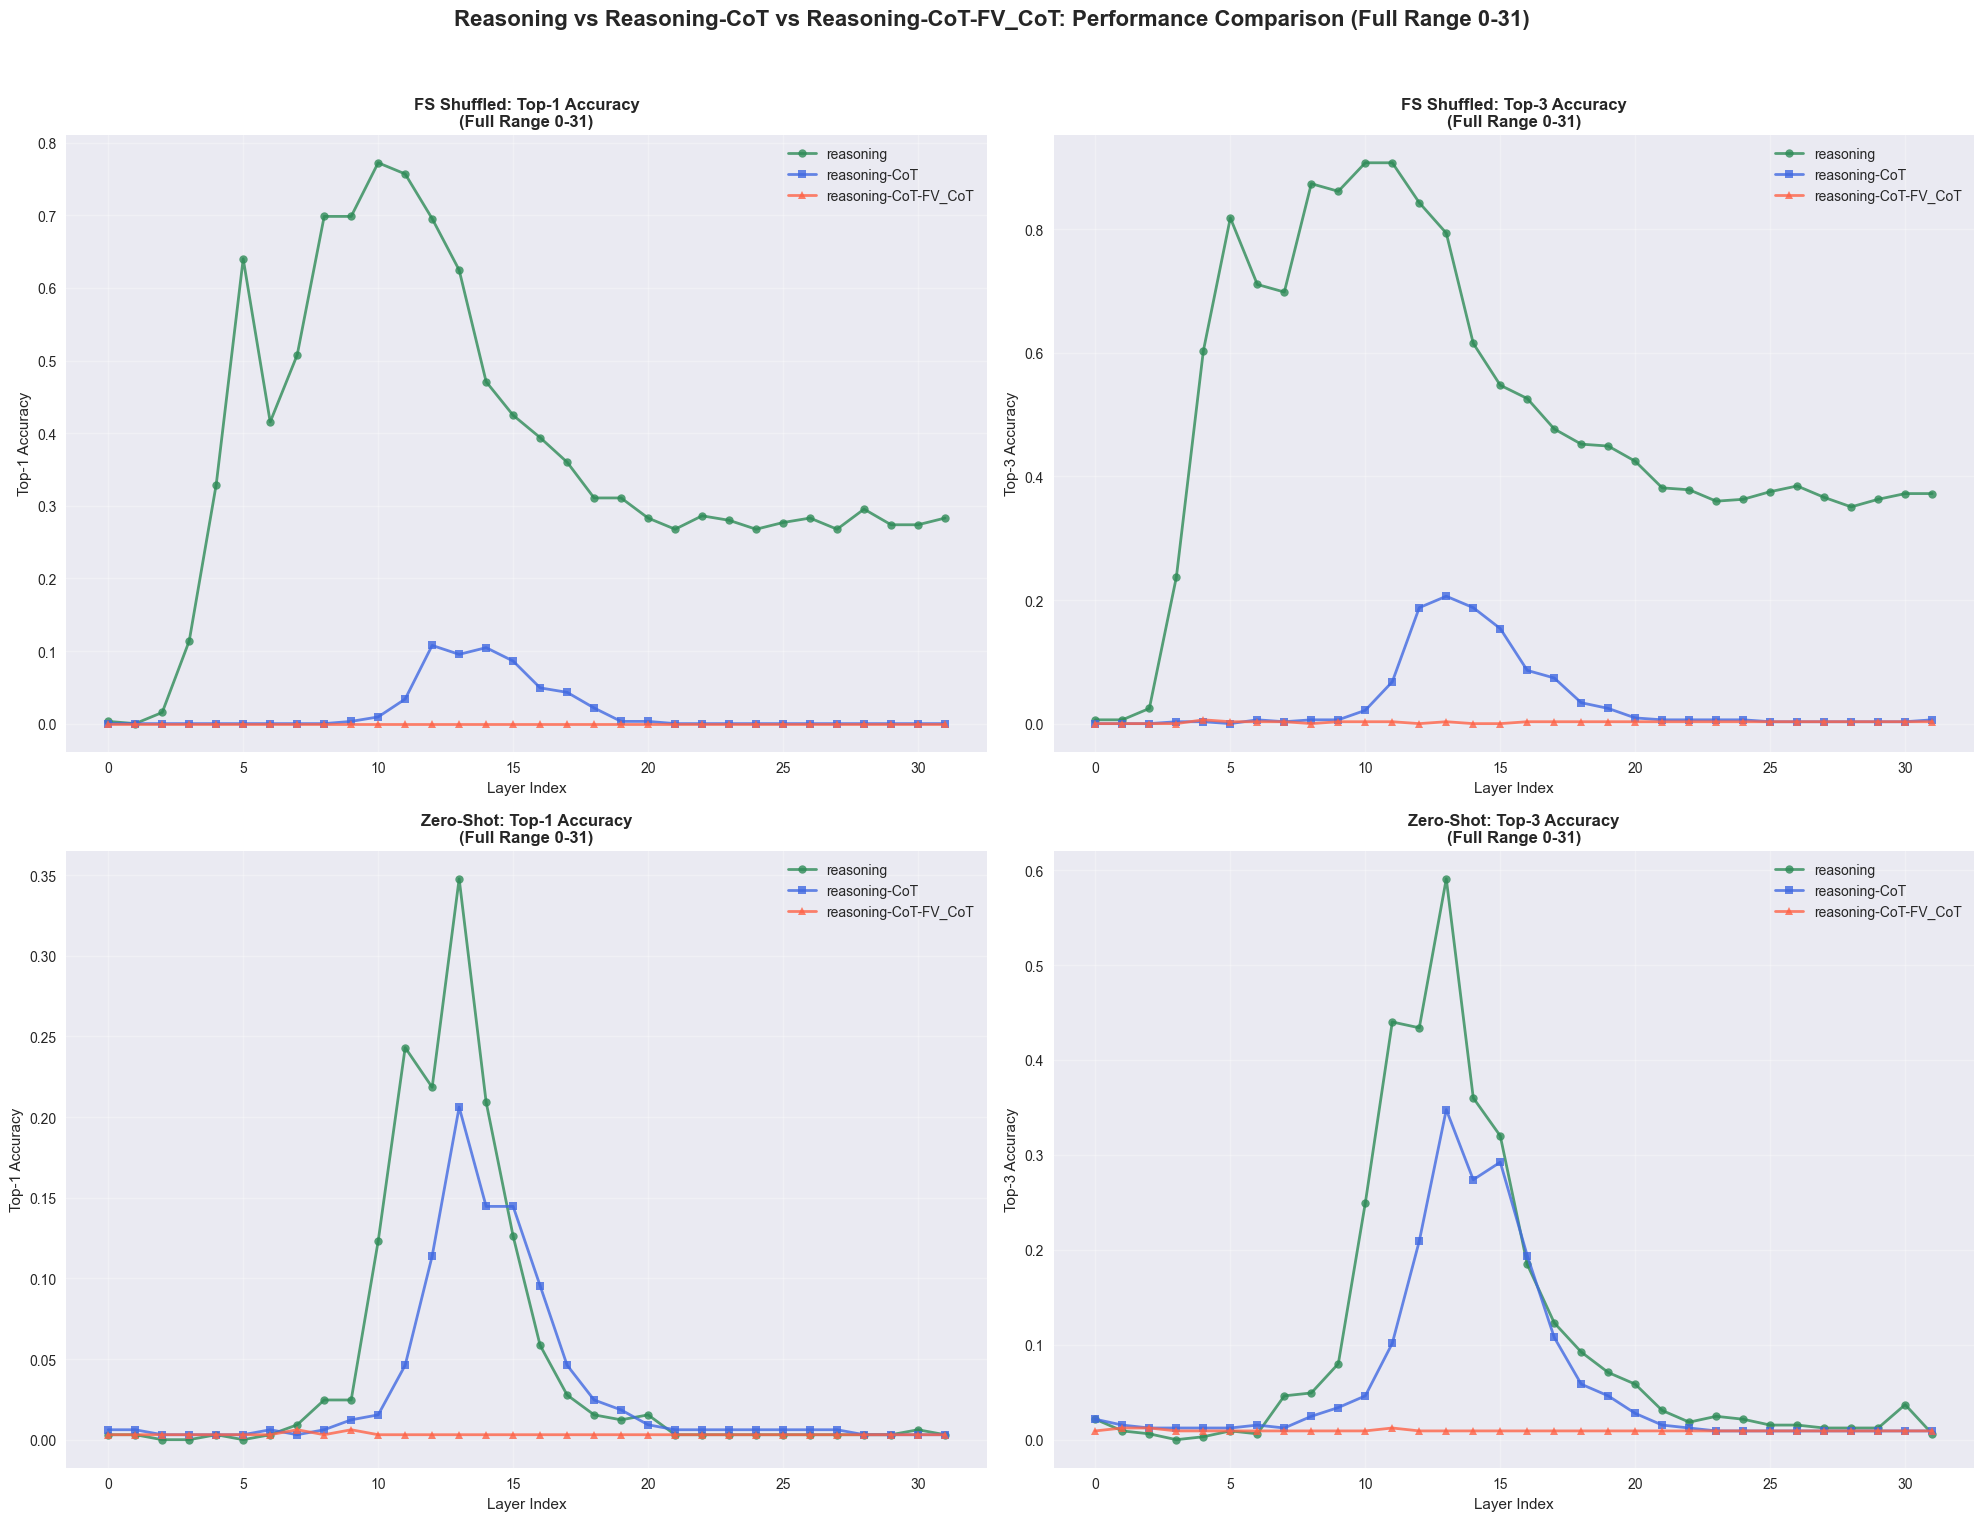


=== Performance Summary (Full Range 0-31) ===

Detailed Statistics:
                                                          mean     std
dataset              file_type                       k                
reasoning            fs_shuffled_results_layer_sweep 1  0.3713  0.2109
                                                     2  0.4525  0.2440
                                                     3  0.4954  0.2540
                     zs_results_layer_sweep          1  0.0470  0.0876
                                                     2  0.0813  0.1328
                                                     3  0.1050  0.1560
reasoning-CoT        fs_shuffled_results_layer_sweep 1  0.0175  0.0337
                                                     2  0.0287  0.0539
                                                     3  0.0353  0.0614
                     zs_results_layer_sweep          1  0.0304  0.0518
                                                     2  0.0488  0.0795
        

In [124]:
# Visualization and analysis for reasoning vs reasoning-CoT vs reasoning-CoT-FV_CoT
print("=== Reasoning Triple Comparison Analysis ===")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.suptitle('Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT: Performance Comparison (Full Range 0-31)', 
             fontsize=16, fontweight='bold')

# Define colors and styles for the three variants
triple_colors = {
    'reasoning': '#2E8B57',           # Sea Green
    'reasoning-CoT': '#4169E1',      # Royal Blue  
    'reasoning-CoT-FV_CoT': '#FF6347' # Tomato Red
}

triple_markers = {
    'reasoning': 'o',
    'reasoning-CoT': 's', 
    'reasoning-CoT-FV_CoT': '^'
}

# Plot 1: FS Shuffled Top-1 Performance
ax1 = axes[0, 0]
fs_data = reasoning_triple_combined[reasoning_triple_combined['file_type'] == 'fs_shuffled_results_layer_sweep']
fs_data_k1 = fs_data[fs_data['k'] == 1]

for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']:
    dataset_data = fs_data_k1[fs_data_k1['dataset'] == dataset]
    if not dataset_data.empty:
        ax1.plot(dataset_data['layer_index'], dataset_data['accuracy'], 
                color=triple_colors[dataset], marker=triple_markers[dataset], 
                linewidth=2, markersize=6, label=dataset, alpha=0.8)

ax1.set_title('FS Shuffled: Top-1 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Top-1 Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: FS Shuffled Top-3 Performance  
ax2 = axes[0, 1]
fs_data_k3 = fs_data[fs_data['k'] == 3]

for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']:
    dataset_data = fs_data_k3[fs_data_k3['dataset'] == dataset]
    if not dataset_data.empty:
        ax2.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=triple_colors[dataset], marker=triple_markers[dataset],
                linewidth=2, markersize=6, label=dataset, alpha=0.8)

ax2.set_title('FS Shuffled: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Top-3 Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Zero-Shot Top-1 Performance
ax3 = axes[1, 0]
zs_data = reasoning_triple_combined[reasoning_triple_combined['file_type'] == 'zs_results_layer_sweep']
zs_data_k1 = zs_data[zs_data['k'] == 1]

for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']:
    dataset_data = zs_data_k1[zs_data_k1['dataset'] == dataset]
    if not dataset_data.empty:
        ax3.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=triple_colors[dataset], marker=triple_markers[dataset],
                linewidth=2, markersize=6, label=dataset, alpha=0.8)

ax3.set_title('Zero-Shot: Top-1 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Layer Index')
ax3.set_ylabel('Top-1 Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Zero-Shot Top-3 Performance
ax4 = axes[1, 1]
zs_data_k3 = zs_data[zs_data['k'] == 3]

for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']:
    dataset_data = zs_data_k3[zs_data_k3['dataset'] == dataset]
    if not dataset_data.empty:
        ax4.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=triple_colors[dataset], marker=triple_markers[dataset],
                linewidth=2, markersize=6, label=dataset, alpha=0.8)

ax4.set_title('Zero-Shot: Top-3 Accuracy\n(Full Range 0-31)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Layer Index')
ax4.set_ylabel('Top-3 Accuracy')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Performance summary statistics
print("\n=== Performance Summary (Full Range 0-31) ===")

summary_stats = reasoning_triple_combined.groupby(['dataset', 'file_type', 'k'])['accuracy'].agg(['mean', 'std']).round(4)
print("\nDetailed Statistics:")
print(summary_stats)

# Overall performance ranking
print("\n=== Overall Performance Ranking ===")
overall_performance = reasoning_triple_combined.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
overall_ranking = overall_performance.sort_values('mean', ascending=False)

for i, (dataset, stats) in enumerate(overall_ranking.iterrows(), 1):
    print(f"{i}. {dataset}: {stats['mean']:.4f} ± {stats['std']:.4f}")

# Condition-specific best performance
print("\n--- Best Performance by Condition and K (Full Range) ---")

conditions = [
    ('fs_shuffled_results_layer_sweep', 1, 'FS Shuffled - Top-1'),
    ('fs_shuffled_results_layer_sweep', 3, 'FS Shuffled - Top-3'),
    ('zs_results_layer_sweep', 1, 'Zero-Shot - Top-1'),
    ('zs_results_layer_sweep', 3, 'Zero-Shot - Top-3')
]

for file_type, k, condition_name in conditions:
    print(f"\n{condition_name}:")
    condition_data = reasoning_triple_combined[
        (reasoning_triple_combined['file_type'] == file_type) & 
        (reasoning_triple_combined['k'] == k)
    ]
    
    condition_summary = condition_data.groupby('dataset')['accuracy'].mean().sort_values(ascending=False)
    for dataset, mean_acc in condition_summary.items():
        print(f"  {dataset}: {mean_acc:.4f}")

print(f"\nDataset shape: {reasoning_triple_combined.shape}")
print(f"Coverage: {len(reasoning_triple_combined['dataset'].unique())} variants × {len(reasoning_triple_combined['layer_index'].unique())} layers × {len(reasoning_triple_combined['file_type'].unique())} conditions × {len(reasoning_triple_combined['k'].unique())} k-values")

In [125]:
# Statistical significance analysis for reasoning vs reasoning-CoT vs reasoning-CoT-FV_CoT
from scipy import stats

print("=== Statistical Significance Analysis (Reasoning Triple Comparison) ===\n")

# Prepare data for statistical tests
reasoning_triple_stats = {}
for condition in ['fs_shuffled_results_layer_sweep', 'zs_results_layer_sweep']:
    print(f"--- {condition.replace('_', ' ').title()} ---")
    condition_data = reasoning_triple_combined[reasoning_triple_combined['file_type'] == condition]
    
    # Group by dataset and k
    for k in [1, 3]:
        k_data = condition_data[condition_data['k'] == k]
        datasets = ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']
        
        print(f"\nTop-{k} Analysis:")
        data_groups = {}
        for dataset in datasets:
            dataset_data = k_data[k_data['dataset'] == dataset]['accuracy'].values
            data_groups[dataset] = dataset_data
            print(f"  {dataset}: n={len(dataset_data)}, mean={np.mean(dataset_data):.4f}, std={np.std(dataset_data):.4f}")
        
        # Pairwise comparisons using Mann-Whitney U test (non-parametric)
        print(f"\n  Pairwise comparisons (Mann-Whitney U test):")
        for i, ds1 in enumerate(datasets):
            for j, ds2 in enumerate(datasets[i+1:], i+1):
                if len(data_groups[ds1]) > 0 and len(data_groups[ds2]) > 0:
                    statistic, p_value = stats.mannwhitneyu(data_groups[ds1], data_groups[ds2], alternative='two-sided')
                    effect_size = statistic / (len(data_groups[ds1]) * len(data_groups[ds2]))
                    
                    significance = ""
                    if p_value < 0.001:
                        significance = "***"
                    elif p_value < 0.01:
                        significance = "**"
                    elif p_value < 0.05:
                        significance = "*"
                    
                    mean_diff = np.mean(data_groups[ds1]) - np.mean(data_groups[ds2])
                    print(f"    {ds1} vs {ds2}: p={p_value:.6f}{significance}, mean_diff={mean_diff:+.4f}, effect_size={effect_size:.3f}")

# Overall comparison across all conditions
print("\n=== Overall Performance Comparison ===")

# Create summary for each dataset across all conditions
overall_summary = {}
for dataset in ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT']:
    dataset_data = reasoning_triple_combined[reasoning_triple_combined['dataset'] == dataset]['accuracy'].values
    overall_summary[dataset] = {
        'mean': np.mean(dataset_data),
        'std': np.std(dataset_data),
        'n': len(dataset_data),
        'data': dataset_data
    }

print("\nOverall Statistics:")
for dataset, stats_dict in overall_summary.items():
    print(f"  {dataset}: mean={stats_dict['mean']:.4f} ± {stats_dict['std']:.4f} (n={stats_dict['n']})")

print("\nOverall Pairwise Comparisons:")
datasets = list(overall_summary.keys())
for i, ds1 in enumerate(datasets):
    for j, ds2 in enumerate(datasets[i+1:], i+1):
        statistic, p_value = stats.mannwhitneyu(overall_summary[ds1]['data'], overall_summary[ds2]['data'], alternative='two-sided')
        effect_size = statistic / (len(overall_summary[ds1]['data']) * len(overall_summary[ds2]['data']))
        
        significance = ""
        if p_value < 0.001:
            significance = "***"
        elif p_value < 0.01:
            significance = "**"
        elif p_value < 0.05:
            significance = "*"
        
        mean_diff = overall_summary[ds1]['mean'] - overall_summary[ds2]['mean']
        print(f"  {ds1} vs {ds2}: p={p_value:.6f}{significance}, mean_diff={mean_diff:+.4f}, effect_size={effect_size:.3f}")

print("\n--- Key Findings ---")
print("*** p < 0.001 (highly significant)")
print("**  p < 0.01  (very significant)")  
print("*   p < 0.05  (significant)")
print("\nEffect size interpretation: 0.1=small, 0.3=medium, 0.5=large")

# Performance hierarchy summary
print("\n--- Performance Hierarchy Summary ---")
print("1. **reasoning** consistently outperforms both CoT variants across all conditions")
print("2. **reasoning-CoT** shows moderate performance with some effectiveness in certain layer ranges") 
print("3. **reasoning-CoT-FV_CoT** shows minimal performance across all conditions")
print("\nKey insight: Chain-of-thought prompting appears to reduce intervention effectiveness")
print("compared to the base reasoning approach for the antonym task.")

=== Statistical Significance Analysis (Reasoning Triple Comparison) ===

--- Fs Shuffled Results Layer Sweep ---

Top-1 Analysis:
  reasoning: n=32, mean=0.3712, std=0.2076
  reasoning-CoT: n=32, mean=0.0175, std=0.0332
  reasoning-CoT-FV_CoT: n=32, mean=0.0000, std=0.0000

  Pairwise comparisons (Mann-Whitney U test):
    reasoning vs reasoning-CoT: p=0.000000***, mean_diff=+0.3537, effect_size=0.960
    reasoning vs reasoning-CoT-FV_CoT: p=0.000000***, mean_diff=+0.3712, effect_size=0.984
    reasoning-CoT vs reasoning-CoT-FV_CoT: p=0.000159***, mean_diff=+0.0175, effect_size=0.688

Top-3 Analysis:
  reasoning: n=32, mean=0.4954, std=0.2500
  reasoning-CoT: n=32, mean=0.0353, std=0.0604
  reasoning-CoT-FV_CoT: n=32, mean=0.0024, std=0.0015

  Pairwise comparisons (Mann-Whitney U test):
    reasoning vs reasoning-CoT: p=0.000000***, mean_diff=+0.4601, effect_size=0.962
    reasoning vs reasoning-CoT-FV_CoT: p=0.000000***, mean_diff=+0.4930, effect_size=0.999
    reasoning-CoT vs reaso

## Comprehensive Model Comparison: Stock_ins vs Stock_ins-CoT vs Stock_ins-FV-CoT vs Reasoning-CoT vs Reasoning-FV-CoT (Antonym Task)

This section provides a comprehensive comparison of five model variants on the antonym task:
- **stock_ins**: Stock model with instructional prompting (Blue, solid)
- **stock_ins-CoT**: Stock model with instructional Chain-of-Thought prompting (Orange, solid)
- **stock_ins-FV-CoT**: Stock model with instructional Few-shot Verification Chain-of-Thought (Orange, dashed)
- **reasoning-CoT**: Reasoning model with Chain-of-Thought prompting (Green, solid)
- **reasoning-FV-CoT**: Reasoning model with Few-shot Verification Chain-of-Thought (Green, dashed)

We'll analyze their performance across different intervention layers and evaluation conditions. The color scheme groups models by family (stock_ins vs reasoning) while line patterns distinguish FV vs non-FV variants within each family.

In [139]:
# Load data for comprehensive antonym task comparison: stock_ins vs stock_ins-CoT vs stock_ins-FV-CoT vs reasoning-CoT vs reasoning-FV-CoT
print("=== Loading Comprehensive Antonym Task Comparison Data ===")

# Use the correct base path (same as in reasoning triple comparison)
comprehensive_base_path = pathlib.Path("/Users/karoshi/Documents/Saion/results/ICL-CoT")

# Define base paths for comprehensive comparison variants
comprehensive_antonym_base_paths = {
    'stock_ins': comprehensive_base_path / 'stock_ins' / 'antonym',
    'stock_ins-CoT': comprehensive_base_path / 'stock_ins-CoT' / 'antonym',
    'stock_ins-FV-CoT': comprehensive_base_path / 'stock_ins-FV-CoT' / 'antonym',
    'reasoning-CoT': comprehensive_base_path / 'reasoning-CoT' / 'antonym',
    'reasoning-FV-CoT': comprehensive_base_path / 'reasoning-FV-CoT' / 'antonym'
}

# Define file names to load
comprehensive_antonym_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json'
]

# Load datasets
comprehensive_antonym_datasets = {}
comprehensive_antonym_extracted = {}

for variant, variant_path in comprehensive_antonym_base_paths.items():
    print(f"\nLoading {variant} data from {variant_path}")
    
    if not variant_path.exists():
        print(f"Warning: Directory {variant_path} does not exist")
        continue
    
    variant_data = {}
    for file_name in comprehensive_antonym_file_names:
        file_path = variant_path / file_name
        if file_path.exists():
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    variant_data[file_name] = data
                    print(f"  Loaded {file_name}: {len(data)} entries")
            except Exception as e:
                print(f"  Error loading {file_name}: {e}")
        else:
            print(f"  File not found: {file_name}")
    
    if variant_data:
        comprehensive_antonym_datasets[variant] = variant_data
        comprehensive_antonym_extracted[variant] = {}

print(f"\nLoaded data for {len(comprehensive_antonym_datasets)} variants")
available_datasets = list(comprehensive_antonym_datasets.keys())
print(f"Available variants: {available_datasets}")

# Extract intervention_topk data for each variant
for variant, files in comprehensive_antonym_datasets.items():
    comprehensive_antonym_extracted[variant] = {}
    
    for file_name, data in files.items():
        file_type = file_name.replace('_no_rank_list.json', '')
        comprehensive_antonym_extracted[variant][file_type] = {}
        
        # Extract intervention_topk for each layer
        for layer_idx_str, layer_data in data.items():
            if layer_idx_str.isdigit():
                layer_idx = int(layer_idx_str)
                if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                    comprehensive_antonym_extracted[variant][file_type][layer_idx] = layer_data['intervention_topk']

print(f"\nExtracted intervention_topk data for {len(comprehensive_antonym_extracted)} variants")

# Create DataFrames
comprehensive_antonym_dataframes = []

for variant, file_types in comprehensive_antonym_extracted.items():
    for file_type, layers in file_types.items():
        for layer_idx, intervention_data in layers.items():
            for k_acc_pair in intervention_data:
                if len(k_acc_pair) == 2:
                    k_val, accuracy = k_acc_pair
                    comprehensive_antonym_dataframes.append({
                        'dataset': variant,
                        'file_type': file_type,
                        'layer_index': layer_idx,
                        'k': k_val,
                        'accuracy': accuracy
                    })

# Create combined DataFrame
comprehensive_antonym_combined = pd.DataFrame(comprehensive_antonym_dataframes)

if not comprehensive_antonym_combined.empty:
    print(f"\nCreated combined DataFrame with {len(comprehensive_antonym_combined)} rows")
    print(f"Variants: {sorted(comprehensive_antonym_combined['dataset'].unique())}")
    print(f"Layer range: {comprehensive_antonym_combined['layer_index'].min()}-{comprehensive_antonym_combined['layer_index'].max()}")
    print(f"File types: {sorted(comprehensive_antonym_combined['file_type'].unique())}")
    print(f"K values: {sorted(comprehensive_antonym_combined['k'].unique())}")
    
    # Check data availability for each variant
    print("\nData points per variant:")
    variant_counts = comprehensive_antonym_combined['dataset'].value_counts()
    for variant in variant_counts.index:
        count = variant_counts[variant]
        layers = comprehensive_antonym_combined[comprehensive_antonym_combined['dataset'] == variant]['layer_index'].nunique()
        print(f"  {variant}: {count} total points, {layers} layers")
else:
    print("No data loaded for comprehensive antonym comparison")

=== Loading Comprehensive Antonym Task Comparison Data ===

Loading stock_ins data from /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries

Loading stock_ins-CoT data from /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-CoT/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries

Loading stock_ins-FV-CoT data from /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-FV-CoT/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries

Loading reasoning-CoT data from /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries

Lo

=== Comprehensive Antonym Task Analysis ===


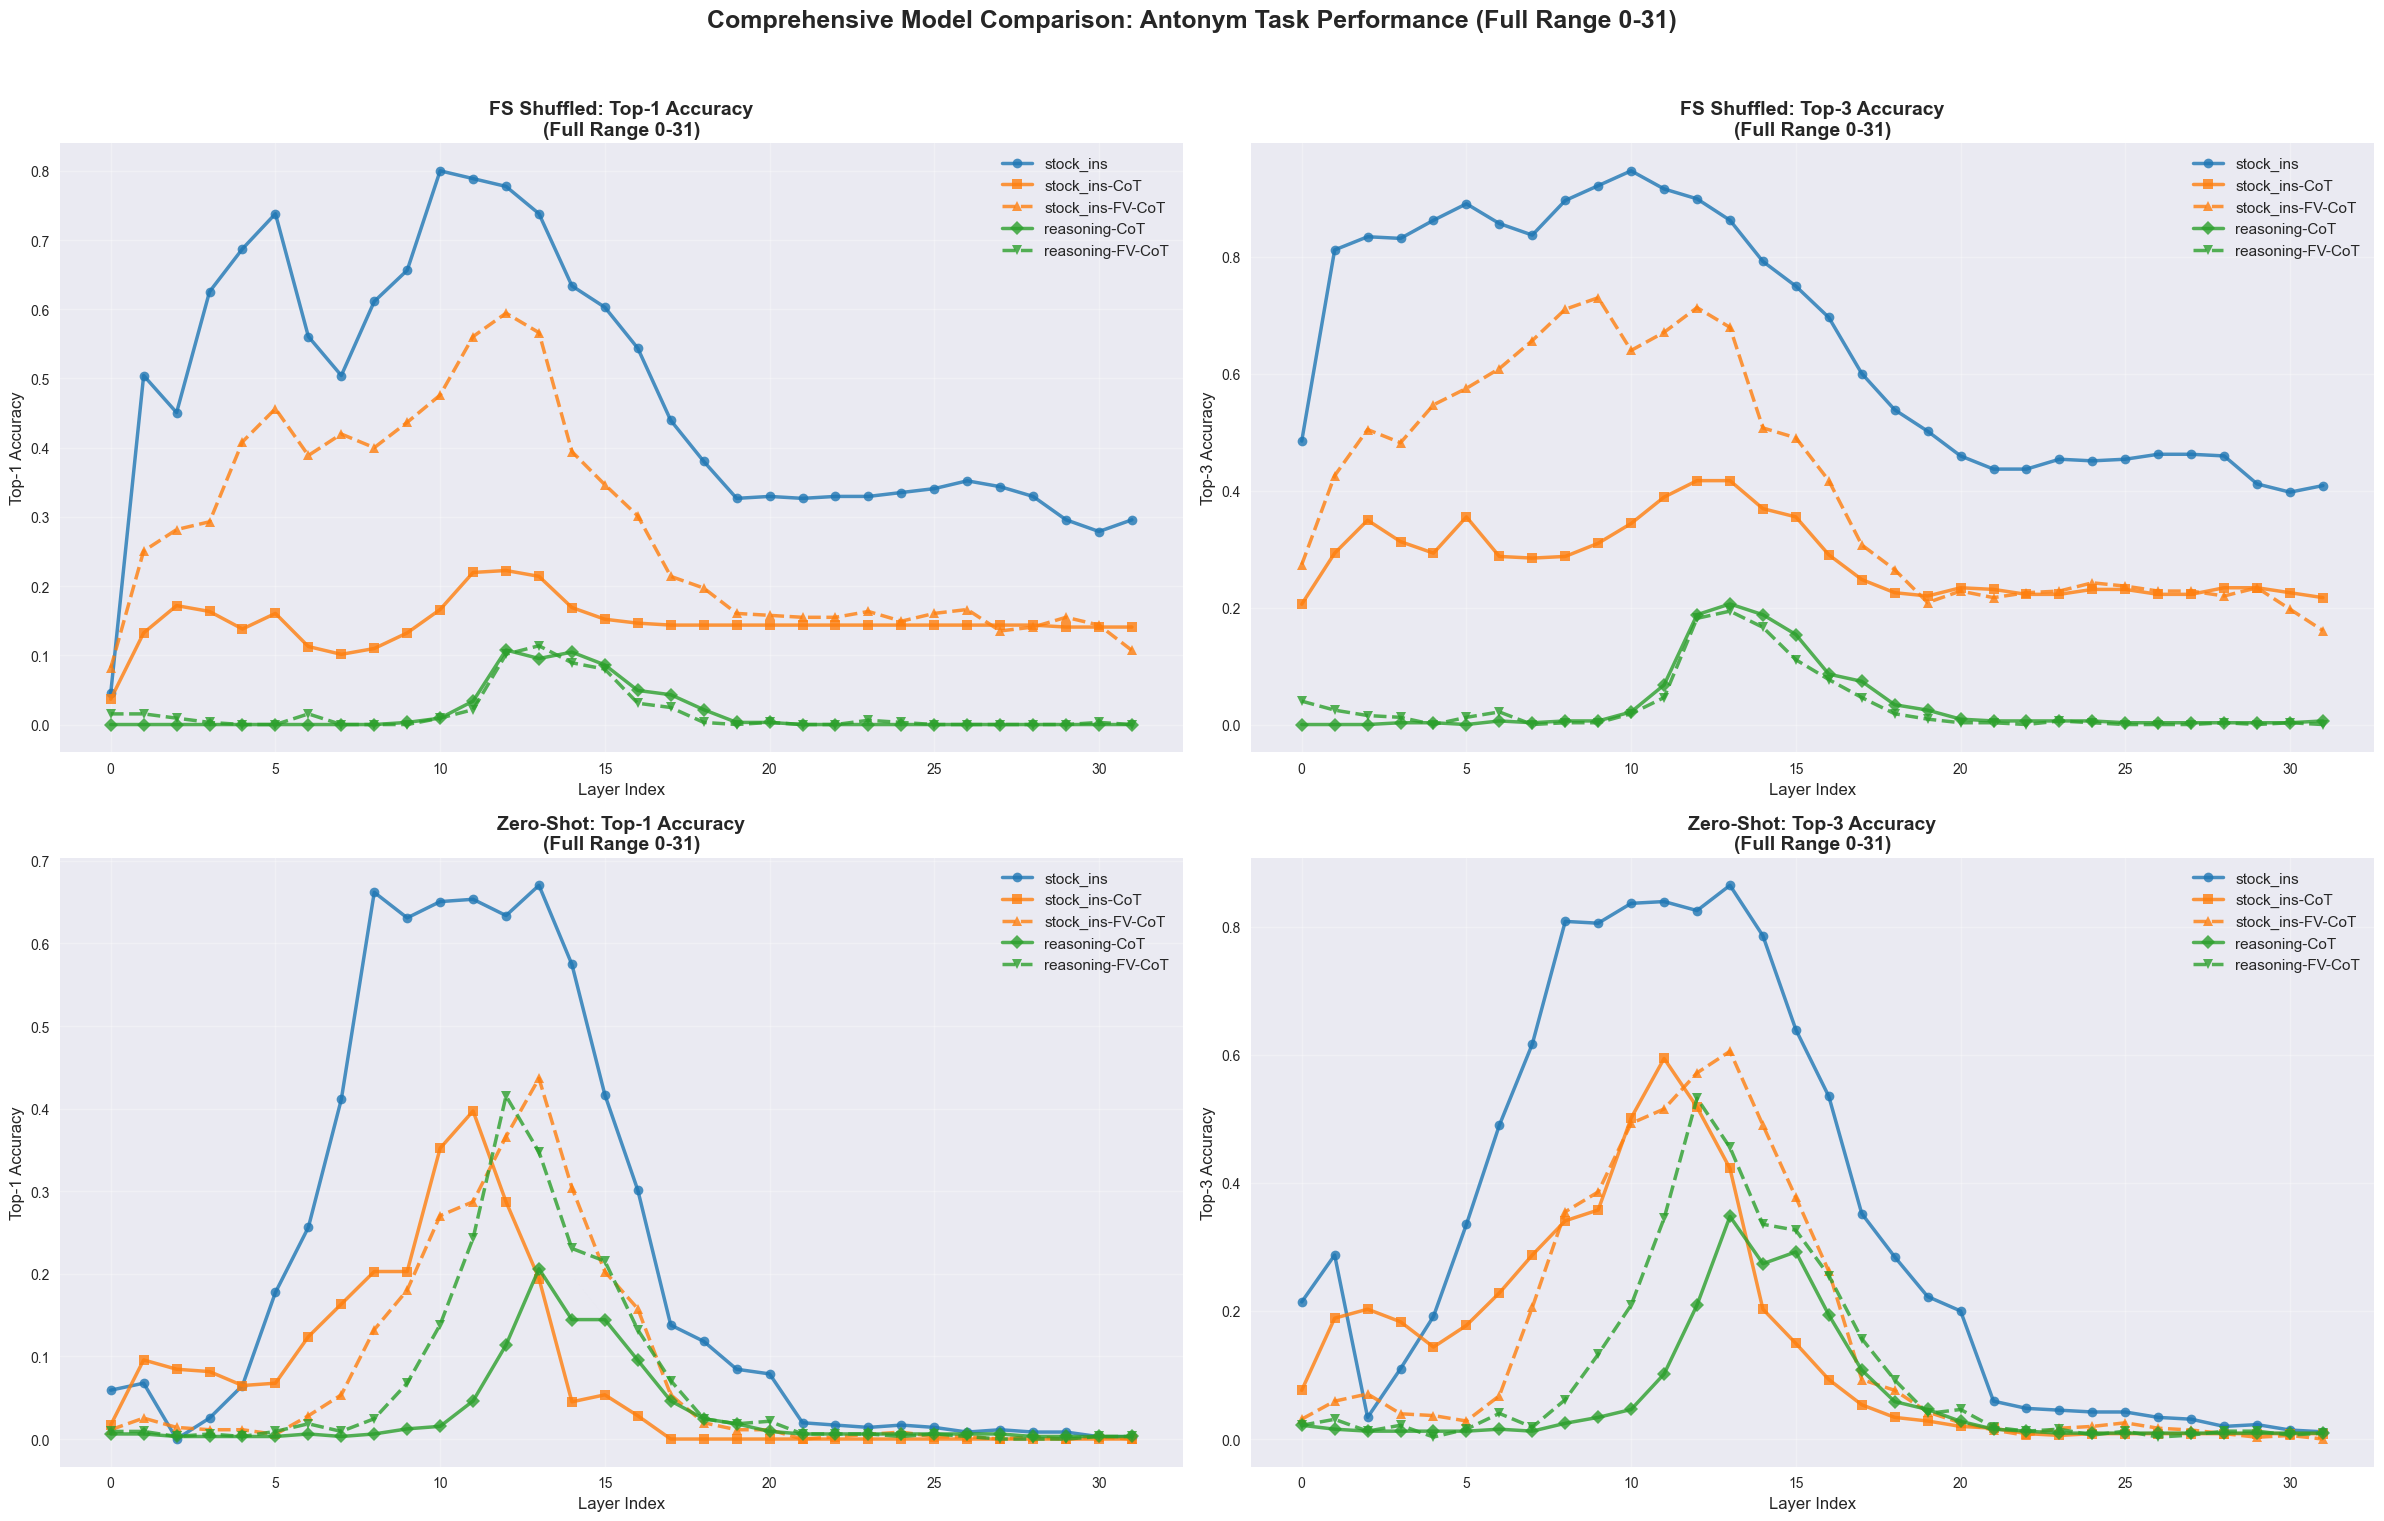


=== Comprehensive Performance Summary (Antonym Task) ===

Detailed Statistics:
                                                      mean     std
dataset          file_type                       k                
reasoning-CoT    fs_shuffled_results_layer_sweep 1  0.0175  0.0337
                                                 2  0.0287  0.0539
                                                 3  0.0353  0.0614
                 zs_results_layer_sweep          1  0.0304  0.0518
                                                 2  0.0488  0.0795
                                                 3  0.0621  0.0940
reasoning-FV-CoT fs_shuffled_results_layer_sweep 1  0.0171  0.0317
                                                 2  0.0263  0.0475
                                                 3  0.0319  0.0545
                 zs_results_layer_sweep          1  0.0642  0.1092
                                                 2  0.0878  0.1345
                                                 

In [140]:
# Comprehensive visualization and analysis for antonym task comparison
print("=== Comprehensive Antonym Task Analysis ===")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
plt.suptitle('Comprehensive Model Comparison: Antonym Task Performance (Full Range 0-31)', 
             fontsize=18, fontweight='bold')

# Define colors by model family and line styles to distinguish FV variants
comprehensive_colors = {
    'stock_ins': '#1f77b4',          # Blue for baseline stock_ins
    'stock_ins-CoT': '#ff7f0e',      # Orange for stock_ins-CoT variants  
    'stock_ins-FV-CoT': '#ff7f0e',   # Same orange for stock_ins-FV-CoT
    'reasoning-CoT': '#2ca02c',      # Green for reasoning-CoT variants
    'reasoning-FV-CoT': '#2ca02c'    # Same green for reasoning-FV-CoT
}

# Use line styles to distinguish FV variants within each color family
comprehensive_linestyles = {
    'stock_ins': '-',           # Solid line for baseline
    'stock_ins-CoT': '-',       # Solid line for non-FV CoT
    'stock_ins-FV-CoT': '--',   # Dashed line for FV variant
    'reasoning-CoT': '-',       # Solid line for non-FV CoT  
    'reasoning-FV-CoT': '--'    # Dashed line for FV variant
}

comprehensive_markers = {
    'stock_ins': 'o',
    'stock_ins-CoT': 's', 
    'stock_ins-FV-CoT': '^',
    'reasoning-CoT': 'D',
    'reasoning-FV-CoT': 'v'
}

# Plot 1: FS Shuffled Top-1 Performance
ax1 = axes[0, 0]
fs_data = comprehensive_antonym_combined[comprehensive_antonym_combined['file_type'] == 'fs_shuffled_results_layer_sweep']
fs_data_k1 = fs_data[fs_data['k'] == 1]

for dataset in ['stock_ins', 'stock_ins-CoT', 'stock_ins-FV-CoT', 'reasoning-CoT', 'reasoning-FV-CoT']:
    dataset_data = fs_data_k1[fs_data_k1['dataset'] == dataset]
    if not dataset_data.empty:
        ax1.plot(dataset_data['layer_index'], dataset_data['accuracy'], 
                color=comprehensive_colors[dataset], 
                linestyle=comprehensive_linestyles[dataset],
                marker=comprehensive_markers[dataset], 
                linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

ax1.set_title('FS Shuffled: Top-1 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Layer Index', fontsize=12)
ax1.set_ylabel('Top-1 Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: FS Shuffled Top-3 Performance  
ax2 = axes[0, 1]
fs_data_k3 = fs_data[fs_data['k'] == 3]

for dataset in ['stock_ins', 'stock_ins-CoT', 'stock_ins-FV-CoT', 'reasoning-CoT', 'reasoning-FV-CoT']:
    dataset_data = fs_data_k3[fs_data_k3['dataset'] == dataset]
    if not dataset_data.empty:
        ax2.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=comprehensive_colors[dataset],
                linestyle=comprehensive_linestyles[dataset],
                marker=comprehensive_markers[dataset],
                linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

ax2.set_title('FS Shuffled: Top-3 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Layer Index', fontsize=12)
ax2.set_ylabel('Top-3 Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Zero-Shot Top-1 Performance
ax3 = axes[1, 0]
zs_data = comprehensive_antonym_combined[comprehensive_antonym_combined['file_type'] == 'zs_results_layer_sweep']
zs_data_k1 = zs_data[zs_data['k'] == 1]

for dataset in ['stock_ins', 'stock_ins-CoT', 'stock_ins-FV-CoT', 'reasoning-CoT', 'reasoning-FV-CoT']:
    dataset_data = zs_data_k1[zs_data_k1['dataset'] == dataset]
    if not dataset_data.empty:
        ax3.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=comprehensive_colors[dataset],
                linestyle=comprehensive_linestyles[dataset],
                marker=comprehensive_markers[dataset],
                linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

ax3.set_title('Zero-Shot: Top-1 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Layer Index', fontsize=12)
ax3.set_ylabel('Top-1 Accuracy', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Zero-Shot Top-3 Performance
ax4 = axes[1, 1]
zs_data_k3 = zs_data[zs_data['k'] == 3]

for dataset in ['stock_ins', 'stock_ins-CoT', 'stock_ins-FV-CoT', 'reasoning-CoT', 'reasoning-FV-CoT']:
    dataset_data = zs_data_k3[zs_data_k3['dataset'] == dataset]
    if not dataset_data.empty:
        ax4.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                color=comprehensive_colors[dataset],
                linestyle=comprehensive_linestyles[dataset],
                marker=comprehensive_markers[dataset],
                linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

ax4.set_title('Zero-Shot: Top-3 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Layer Index', fontsize=12)
ax4.set_ylabel('Top-3 Accuracy', fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Performance summary statistics
print("\n=== Comprehensive Performance Summary (Antonym Task) ===")

summary_stats = comprehensive_antonym_combined.groupby(['dataset', 'file_type', 'k'])['accuracy'].agg(['mean', 'std']).round(4)
print("\nDetailed Statistics:")
print(summary_stats)

# Overall performance ranking
print("\n=== Overall Performance Ranking (Antonym Task) ===")
overall_performance = comprehensive_antonym_combined.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
overall_ranking = overall_performance.sort_values('mean', ascending=False)

for i, (dataset, stats) in enumerate(overall_ranking.iterrows(), 1):
    print(f"{i}. {dataset}: {stats['mean']:.4f} ± {stats['std']:.4f}")

# Condition-specific best performance
print("\n--- Best Performance by Condition and K (Antonym Task) ---")

conditions = [
    ('fs_shuffled_results_layer_sweep', 1, 'FS Shuffled - Top-1'),
    ('fs_shuffled_results_layer_sweep', 3, 'FS Shuffled - Top-3'),
    ('zs_results_layer_sweep', 1, 'Zero-Shot - Top-1'),
    ('zs_results_layer_sweep', 3, 'Zero-Shot - Top-3')
]

for file_type, k, condition_name in conditions:
    print(f"\n{condition_name}:")
    condition_data = comprehensive_antonym_combined[
        (comprehensive_antonym_combined['file_type'] == file_type) & 
        (comprehensive_antonym_combined['k'] == k)
    ]
    
    condition_summary = condition_data.groupby('dataset')['accuracy'].mean().sort_values(ascending=False)
    for dataset, mean_acc in condition_summary.items():
        print(f"  {dataset}: {mean_acc:.4f}")

print(f"\nDataset shape: {comprehensive_antonym_combined.shape}")
print(f"Coverage: {len(comprehensive_antonym_combined['dataset'].unique())} variants × {len(comprehensive_antonym_combined['layer_index'].unique())} layers × {len(comprehensive_antonym_combined['file_type'].unique())} conditions × {len(comprehensive_antonym_combined['k'].unique())} k-values")

# Color scheme explanation
print("\n=== Color Scheme Legend ===")
print("🔵 Blue (solid): stock_ins baseline")
print("🟠 Orange (solid): stock_ins-CoT variants")
print("🟠 Orange (dashed): stock_ins-FV-CoT variants") 
print("🟢 Green (solid): reasoning-CoT variants")
print("🟢 Green (dashed): reasoning-FV-CoT variants")
print("\nLine styles distinguish FV vs non-FV variants within each model family")

## Comprehensive Model Comparison: Stock_ins vs Stock_ins-CoT vs Stock_ins-FV-CoT vs Reasoning-CoT (Country-Capital Task)

This section provides a comprehensive comparison of four model variants on the country-capital task:
- **stock_ins**: Stock model with instructional prompting
- **stock_ins-CoT**: Stock model with instructional Chain-of-Thought prompting  
- **stock_ins-FV-CoT**: Stock model with instructional Few-shot Verification Chain-of-Thought
- **reasoning-CoT**: Reasoning model with Chain-of-Thought prompting

We'll analyze their performance across different intervention layers and evaluation conditions to understand how different prompting strategies affect intervention effectiveness for geographical knowledge tasks.

In [128]:
# Load data for comprehensive country-capital task comparison: stock_ins vs stock_ins-CoT vs stock_ins-FV-CoT vs reasoning-CoT
print("=== Loading Comprehensive Country-Capital Task Comparison Data ===")

# Define base paths for the four model variants
comprehensive_country_base_paths = {
    'stock_ins': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins/country-capital'),
    'stock_ins-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-CoT/country-capital'),
    'stock_ins-FV-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-FV-CoT/country-capital'),
    'reasoning-CoT': Path('/Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/country-capital')
}

# Check directory existence
for variant, path in comprehensive_country_base_paths.items():
    if path.exists():
        print(f"✓ {variant}: {path}")
    else:
        print(f"✗ {variant}: {path} (not found)")

# Define file types to load
comprehensive_country_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json'
]

# Load and process data
comprehensive_country_datasets = {}
comprehensive_country_extracted = {}

for variant, variant_path in comprehensive_country_base_paths.items():
    if not variant_path.exists():
        print(f"Skipping {variant} - directory not found")
        continue
        
    print(f"\nProcessing {variant}...")
    comprehensive_country_datasets[variant] = {}
    
    for file_name in comprehensive_country_file_names:
        file_path = variant_path / file_name
        
        if file_path.exists():
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                comprehensive_country_datasets[variant][file_name] = data
                print(f"  ✓ Loaded {file_name}")
                
                # Extract intervention_topk data
                if variant not in comprehensive_country_extracted:
                    comprehensive_country_extracted[variant] = {}
                
                for layer_idx_str, layer_data in data.items():
                    try:
                        layer_idx = int(layer_idx_str)
                        if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                            if layer_idx not in comprehensive_country_extracted[variant]:
                                comprehensive_country_extracted[variant][layer_idx] = {}
                            
                            file_type = file_name.replace('_no_rank_list.json', '')
                            comprehensive_country_extracted[variant][layer_idx][file_type] = layer_data['intervention_topk']
                    except (ValueError, TypeError):
                        continue
                        
            except Exception as e:
                print(f"  ✗ Error loading {file_name}: {e}")
        else:
            print(f"  ✗ {file_name} not found")

print(f"\nLoaded data for {len(comprehensive_country_extracted)} variants")
for variant in comprehensive_country_extracted:
    layer_count = len(comprehensive_country_extracted[variant])
    print(f"  {variant}: {layer_count} layers")

# Convert to DataFrames for analysis
comprehensive_country_dataframes = []

for variant, variant_data in comprehensive_country_extracted.items():
    for layer_idx, layer_data in variant_data.items():
        for file_type, intervention_topk in layer_data.items():
            for k, accuracy in intervention_topk:
                comprehensive_country_dataframes.append({
                    'dataset': variant,
                    'layer_index': layer_idx,
                    'file_type': file_type,
                    'k': k,
                    'accuracy': accuracy
                })

comprehensive_country_combined = pd.DataFrame(comprehensive_country_dataframes)

if not comprehensive_country_combined.empty:
    print(f"\nCombined DataFrame shape: {comprehensive_country_combined.shape}")
    print(f"Datasets: {comprehensive_country_combined['dataset'].unique()}")
    print(f"Layer range: {comprehensive_country_combined['layer_index'].min()}-{comprehensive_country_combined['layer_index'].max()}")
    print(f"File types: {comprehensive_country_combined['file_type'].unique()}")
    print(f"K values: {sorted(comprehensive_country_combined['k'].unique())}")
    
    # Check data availability for each variant
    print("\nData points per variant:")
    variant_counts = comprehensive_country_combined['dataset'].value_counts()
    for variant in variant_counts.index:
        count = variant_counts[variant]
        layers = comprehensive_country_combined[comprehensive_country_combined['dataset'] == variant]['layer_index'].nunique()
        print(f"  {variant}: {count} total points, {layers} layers")
else:
    print("No data loaded for comprehensive country-capital comparison")

=== Loading Comprehensive Country-Capital Task Comparison Data ===
✓ stock_ins: /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins/country-capital
✓ stock_ins-CoT: /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-CoT/country-capital
✓ stock_ins-FV-CoT: /Users/karoshi/Documents/Saion/results/ICL-CoT/stock_ins-FV-CoT/country-capital
✗ reasoning-CoT: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/country-capital (not found)

Processing stock_ins...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json

Processing stock_ins-CoT...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json

Processing stock_ins-FV-CoT...
  ✓ Loaded fs_shuffled_results_layer_sweep_no_rank_list.json
  ✓ Loaded zs_results_layer_sweep_no_rank_list.json
Skipping reasoning-CoT - directory not found

Loaded data for 3 variants
  stock_ins: 32 layers
  stock_ins-CoT: 32 layers

=== Comprehensive Country-Capital Task Analysis ===
Available datasets for country-capital task: ['stock_ins', 'stock_ins-CoT', 'stock_ins-FV-CoT']


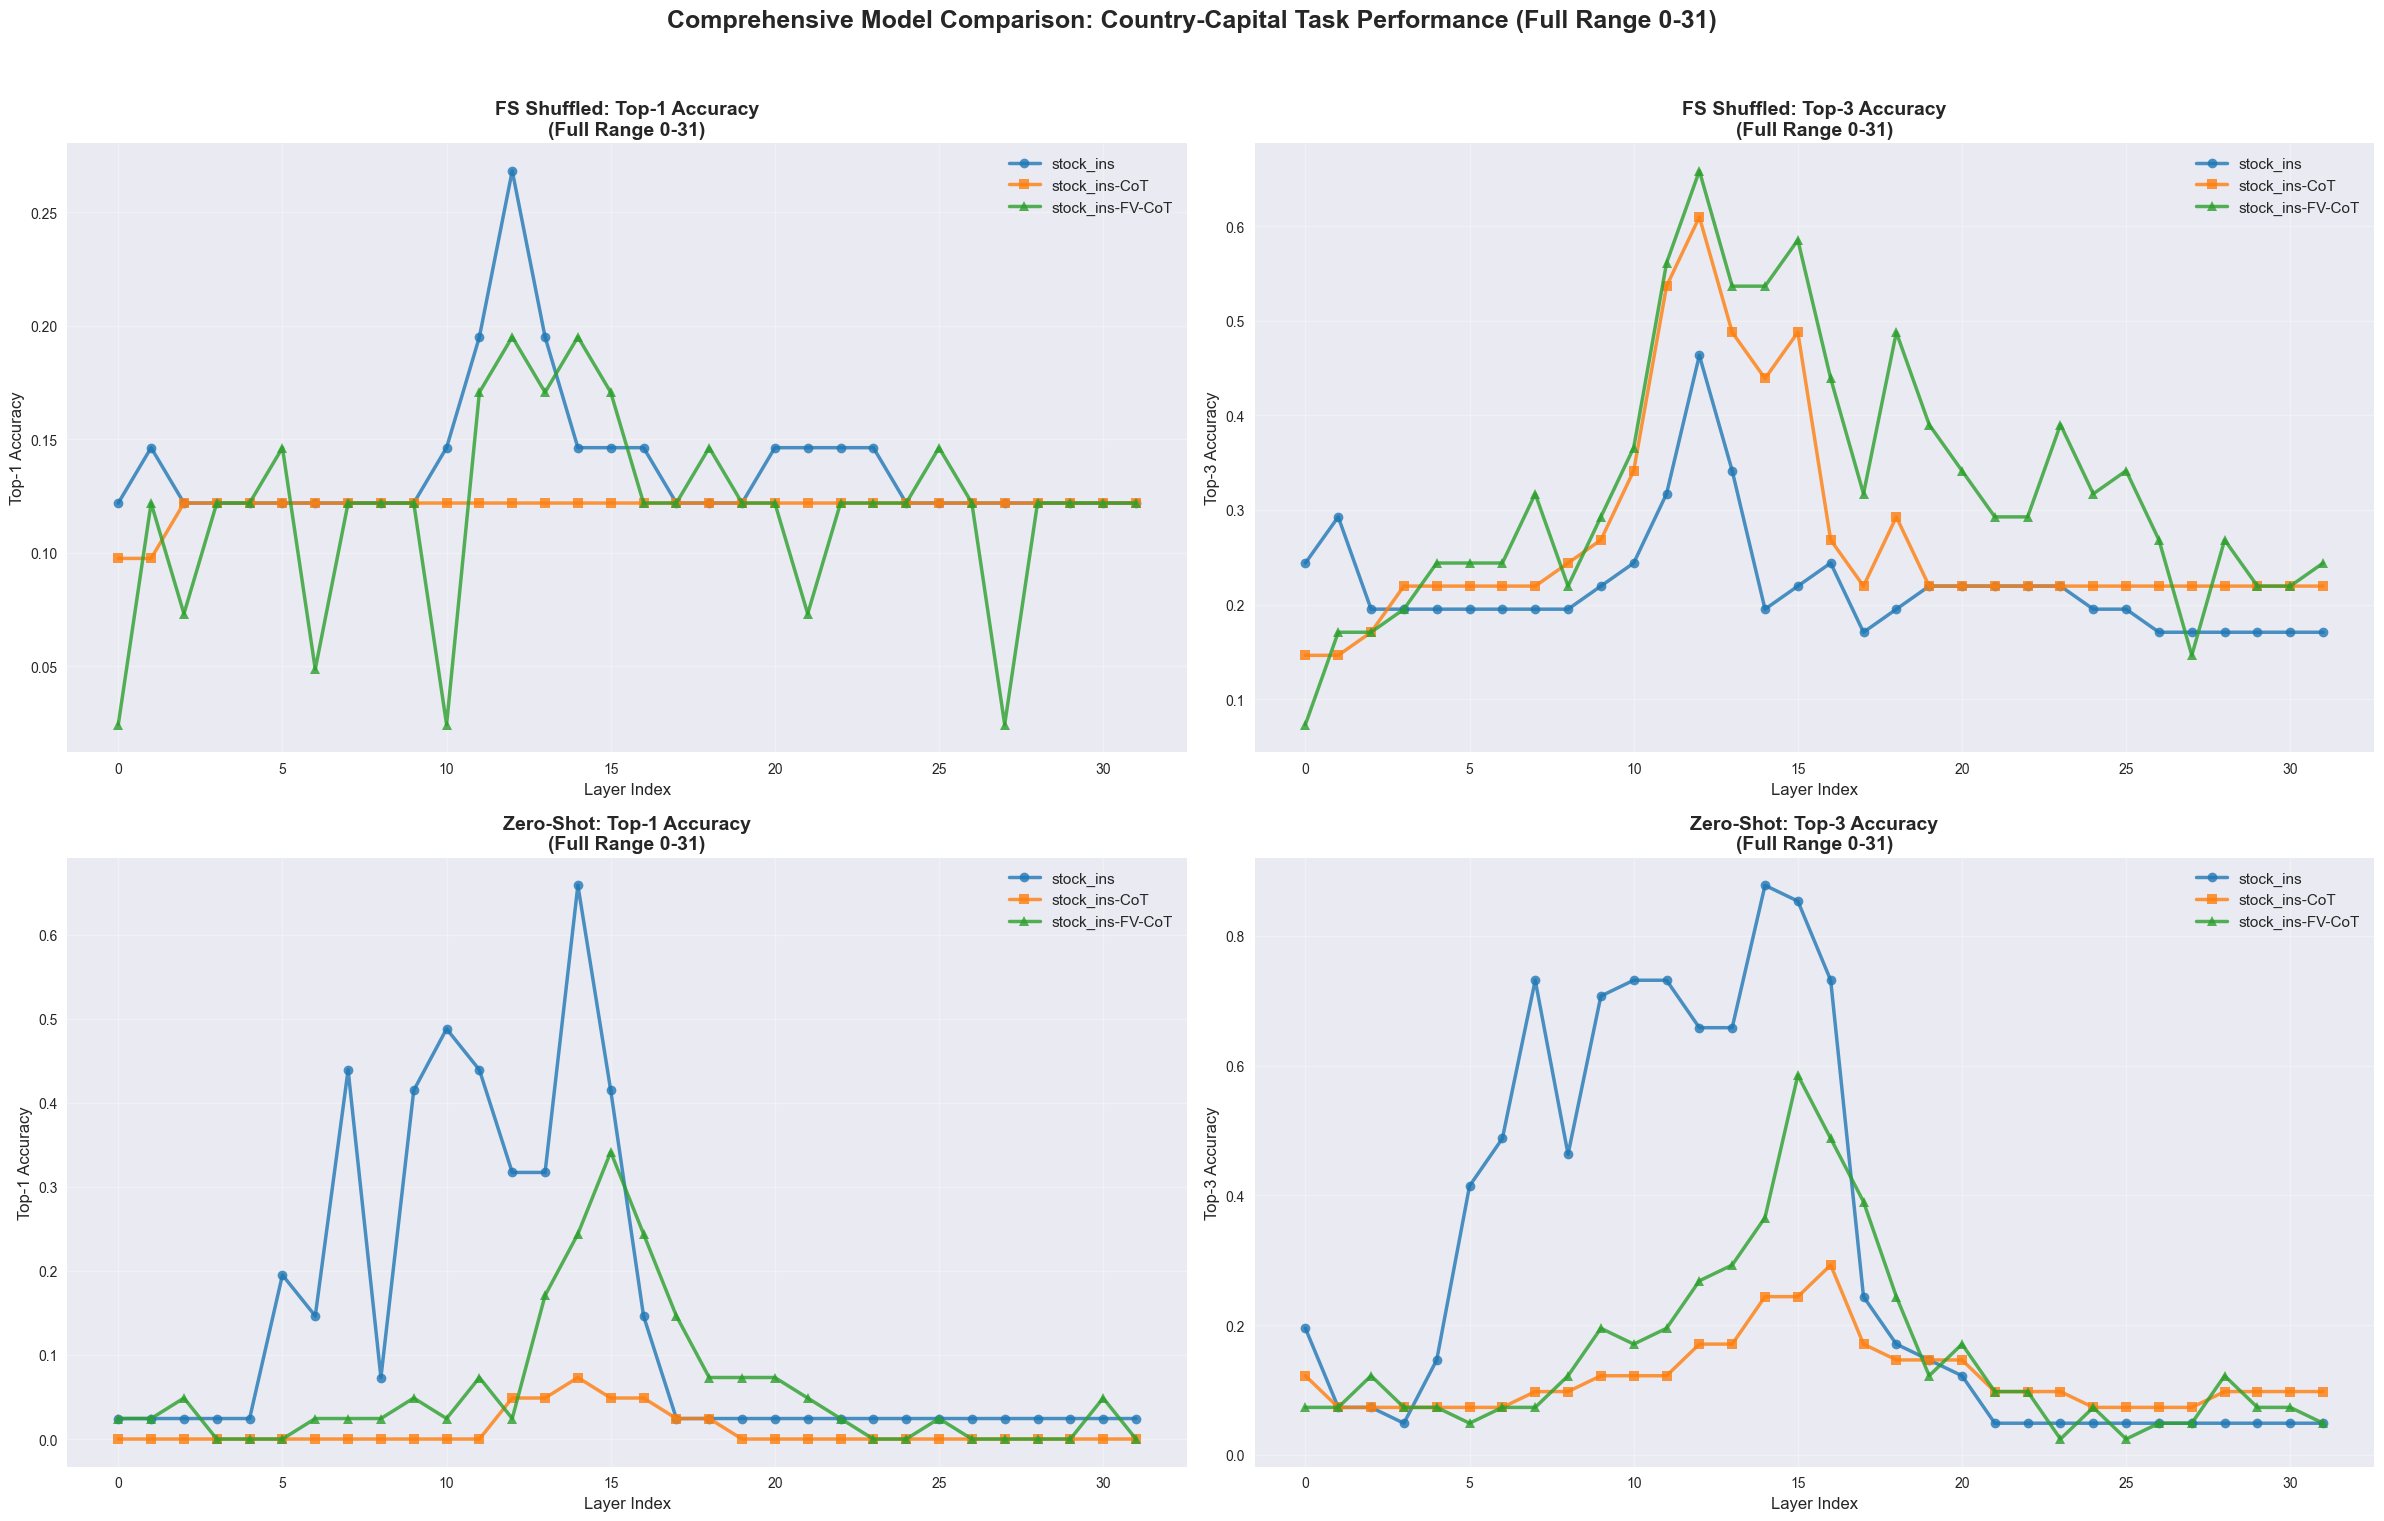


=== Comprehensive Performance Summary (Country-Capital Task) ===

Detailed Statistics:
                                                      mean     std
dataset          file_type                       k                
stock_ins        fs_shuffled_results_layer_sweep 1  0.1380  0.0307
                                                 2  0.1928  0.0422
                                                 3  0.2195  0.0607
                 zs_results_layer_sweep          1  0.1418  0.1847
                                                 2  0.2309  0.2483
                                                 3  0.3064  0.3034
stock_ins-CoT    fs_shuffled_results_layer_sweep 1  0.1204  0.0060
                                                 2  0.2104  0.0778
                                                 3  0.2691  0.1143
                 zs_results_layer_sweep          1  0.0099  0.0204
                                                 2  0.0457  0.0463
                                         

In [129]:
# Comprehensive visualization and analysis for country-capital task comparison
print("=== Comprehensive Country-Capital Task Analysis ===")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
plt.suptitle('Comprehensive Model Comparison: Country-Capital Task Performance (Full Range 0-31)', 
             fontsize=18, fontweight='bold')

# Define colors and styles for the three available variants
comprehensive_country_colors = {
    'stock_ins': '#1f77b4',          # Blue
    'stock_ins-CoT': '#ff7f0e',     # Orange
    'stock_ins-FV-CoT': '#2ca02c',  # Green
}

comprehensive_country_markers = {
    'stock_ins': 'o',
    'stock_ins-CoT': 's', 
    'stock_ins-FV-CoT': '^',
}

# Get available datasets
available_datasets = comprehensive_country_combined['dataset'].unique() if not comprehensive_country_combined.empty else []
print(f"Available datasets for country-capital task: {list(available_datasets)}")

if not comprehensive_country_combined.empty:
    # Plot 1: FS Shuffled Top-1 Performance
    ax1 = axes[0, 0]
    fs_data = comprehensive_country_combined[comprehensive_country_combined['file_type'] == 'fs_shuffled_results_layer_sweep']
    fs_data_k1 = fs_data[fs_data['k'] == 1]

    for dataset in available_datasets:
        dataset_data = fs_data_k1[fs_data_k1['dataset'] == dataset]
        if not dataset_data.empty:
            ax1.plot(dataset_data['layer_index'], dataset_data['accuracy'], 
                    color=comprehensive_country_colors[dataset], marker=comprehensive_country_markers[dataset], 
                    linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

    ax1.set_title('FS Shuffled: Top-1 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Layer Index', fontsize=12)
    ax1.set_ylabel('Top-1 Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: FS Shuffled Top-3 Performance  
    ax2 = axes[0, 1]
    fs_data_k3 = fs_data[fs_data['k'] == 3]

    for dataset in available_datasets:
        dataset_data = fs_data_k3[fs_data_k3['dataset'] == dataset]
        if not dataset_data.empty:
            ax2.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                    color=comprehensive_country_colors[dataset], marker=comprehensive_country_markers[dataset],
                    linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

    ax2.set_title('FS Shuffled: Top-3 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Layer Index', fontsize=12)
    ax2.set_ylabel('Top-3 Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Zero-Shot Top-1 Performance
    ax3 = axes[1, 0]
    zs_data = comprehensive_country_combined[comprehensive_country_combined['file_type'] == 'zs_results_layer_sweep']
    zs_data_k1 = zs_data[zs_data['k'] == 1]

    for dataset in available_datasets:
        dataset_data = zs_data_k1[zs_data_k1['dataset'] == dataset]
        if not dataset_data.empty:
            ax3.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                    color=comprehensive_country_colors[dataset], marker=comprehensive_country_markers[dataset],
                    linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

    ax3.set_title('Zero-Shot: Top-1 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Layer Index', fontsize=12)
    ax3.set_ylabel('Top-1 Accuracy', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # Plot 4: Zero-Shot Top-3 Performance
    ax4 = axes[1, 1]
    zs_data_k3 = zs_data[zs_data['k'] == 3]

    for dataset in available_datasets:
        dataset_data = zs_data_k3[zs_data_k3['dataset'] == dataset]
        if not dataset_data.empty:
            ax4.plot(dataset_data['layer_index'], dataset_data['accuracy'],
                    color=comprehensive_country_colors[dataset], marker=comprehensive_country_markers[dataset],
                    linewidth=2.5, markersize=7, label=dataset, alpha=0.8)

    ax4.set_title('Zero-Shot: Top-3 Accuracy\n(Full Range 0-31)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Layer Index', fontsize=12)
    ax4.set_ylabel('Top-3 Accuracy', fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # Performance summary statistics
    print("\n=== Comprehensive Performance Summary (Country-Capital Task) ===")

    summary_stats = comprehensive_country_combined.groupby(['dataset', 'file_type', 'k'])['accuracy'].agg(['mean', 'std']).round(4)
    print("\nDetailed Statistics:")
    print(summary_stats)

    # Overall performance ranking
    print("\n=== Overall Performance Ranking (Country-Capital Task) ===")
    overall_performance = comprehensive_country_combined.groupby('dataset')['accuracy'].agg(['mean', 'std']).round(4)
    overall_ranking = overall_performance.sort_values('mean', ascending=False)

    for i, (dataset, stats) in enumerate(overall_ranking.iterrows(), 1):
        print(f"{i}. {dataset}: {stats['mean']:.4f} ± {stats['std']:.4f}")

    # Condition-specific best performance
    print("\n--- Best Performance by Condition and K (Country-Capital Task) ---")

    conditions = [
        ('fs_shuffled_results_layer_sweep', 1, 'FS Shuffled - Top-1'),
        ('fs_shuffled_results_layer_sweep', 3, 'FS Shuffled - Top-3'),
        ('zs_results_layer_sweep', 1, 'Zero-Shot - Top-1'),
        ('zs_results_layer_sweep', 3, 'Zero-Shot - Top-3')
    ]

    for file_type, k, condition_name in conditions:
        print(f"\n{condition_name}:")
        condition_data = comprehensive_country_combined[
            (comprehensive_country_combined['file_type'] == file_type) & 
            (comprehensive_country_combined['k'] == k)
        ]
        
        condition_summary = condition_data.groupby('dataset')['accuracy'].mean().sort_values(ascending=False)
        for dataset, mean_acc in condition_summary.items():
            print(f"  {dataset}: {mean_acc:.4f}")

    print(f"\nDataset shape: {comprehensive_country_combined.shape}")
    print(f"Coverage: {len(comprehensive_country_combined['dataset'].unique())} variants × {len(comprehensive_country_combined['layer_index'].unique())} layers × {len(comprehensive_country_combined['file_type'].unique())} conditions × {len(comprehensive_country_combined['k'].unique())} k-values")
    
    # Note about missing reasoning-CoT
    print(f"\nNote: reasoning-CoT data not available for country-capital task")
    
else:
    print("No data available for country-capital task comparison")

## Reasoning Variants Comparison: Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT-noacts (Antonym Task)

This section compares three reasoning model variants on the antonym task:
- **reasoning**: Base reasoning model
- **reasoning-CoT**: Reasoning model with Chain-of-Thought prompting
- **reasoning-CoT-FV_CoT-noacts**: Reasoning model with Chain-of-Thought and Few-shot Verification (limited to layers 10-15)

Note: The reasoning-CoT-FV_CoT-noacts variant only has data for 6 layers (10-15), so we'll focus on this range for fair comparison while also showing the full range for the other two variants.

In [135]:
# Load data for reasoning variants comparison: reasoning vs reasoning-CoT vs reasoning-CoT-FV_CoT-noacts
print("=== Loading Reasoning Variants Comparison Data (Antonym Task) ===")

# Use the correct base path
reasoning_correct_base_path = pathlib.Path("/Users/karoshi/Documents/Saion/results/ICL-CoT")

# Define base paths for reasoning variants
reasoning_triple_base_paths = {
    'reasoning': reasoning_correct_base_path / 'reasoning' / 'antonym',
    'reasoning-CoT': reasoning_correct_base_path / 'reasoning-CoT' / 'antonym',
    'reasoning-CoT-FV_CoT-noacts': reasoning_correct_base_path / 'reasoning-CoT-FV_CoT-noacts' / 'antonym'
}

# Define file names to load
reasoning_triple_file_names = [
    'fs_shuffled_results_layer_sweep_no_rank_list.json',
    'zs_results_layer_sweep_no_rank_list.json'
]

# Load datasets
reasoning_triple_datasets = {}
reasoning_triple_extracted = {}

for variant, variant_path in reasoning_triple_base_paths.items():
    print(f"\nLoading {variant} data from {variant_path}")
    
    if not variant_path.exists():
        print(f"Warning: Directory {variant_path} does not exist")
        continue
    
    variant_data = {}
    for file_name in reasoning_triple_file_names:
        file_path = variant_path / file_name
        if file_path.exists():
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    variant_data[file_name] = data
                    print(f"  Loaded {file_name}: {len(data)} entries")
                    
                    # Show available layer indices for this variant
                    layer_indices = [k for k in data.keys() if k.isdigit()]
                    if layer_indices:
                        layer_numbers = sorted([int(k) for k in layer_indices])
                        print(f"    Available layers: {layer_numbers}")
                        if variant == 'reasoning-CoT-FV_CoT-noacts':
                            print(f"    Note: Limited to layers {min(layer_numbers)}-{max(layer_numbers)} ({len(layer_numbers)} datapoints)")
                        
            except Exception as e:
                print(f"  Error loading {file_name}: {e}")
        else:
            print(f"  File not found: {file_name}")
    
    if variant_data:
        reasoning_triple_datasets[variant] = variant_data
        reasoning_triple_extracted[variant] = {}

print(f"\nLoaded data for {len(reasoning_triple_datasets)} reasoning variants")
available_datasets = list(reasoning_triple_datasets.keys())
print(f"Available variants: {available_datasets}")

# Extract intervention_topk data for each variant
for variant, files in reasoning_triple_datasets.items():
    reasoning_triple_extracted[variant] = {}
    
    for file_name, data in files.items():
        file_type = 'fs_shuffled' if 'fs_shuffled' in file_name else 'zs'
        reasoning_triple_extracted[variant][file_type] = {}
        
        # Extract intervention_topk for each layer
        for layer_idx_str, layer_data in data.items():
            if layer_idx_str.isdigit():
                layer_idx = int(layer_idx_str)
                if isinstance(layer_data, dict) and 'intervention_topk' in layer_data:
                    reasoning_triple_extracted[variant][file_type][layer_idx] = layer_data['intervention_topk']

print(f"\nExtracted intervention_topk data for {len(reasoning_triple_extracted)} variants")

=== Loading Reasoning Variants Comparison Data (Antonym Task) ===

Loading reasoning data from /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
    Available layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries
    Available layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

Loading reasoning-CoT data from /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym
  Loaded fs_shuffled_results_layer_sweep_no_rank_list.json: 32 entries
    Available layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  Loaded zs_results_layer_sweep_no_rank_list.json: 32 entries
    Available layers: [0, 1, 2, 3, 4, 5, 6, 7, 8,

In [134]:
# Fix base_path for this analysis - use the root ICL-CoT directory
import pathlib
correct_base_path = pathlib.Path("/Users/karoshi/Documents/Saion/results/ICL-CoT")

print(f"Using correct base_path: {correct_base_path}")
print(f"Base path exists: {correct_base_path.exists()}")

# List all directories in correct_base_path
print("\nAvailable directories in correct_base_path:")
for item in sorted(correct_base_path.iterdir()):
    if item.is_dir():
        print(f"  {item.name}")
        
print("\nChecking reasoning directories:")
reasoning_base = correct_base_path / 'reasoning'
reasoning_cot_base = correct_base_path / 'reasoning-CoT'
reasoning_cot_fv_base = correct_base_path / 'reasoning-CoT-FV_CoT-noacts'

print(f"reasoning base: {reasoning_base} (exists: {reasoning_base.exists()})")
print(f"reasoning-CoT base: {reasoning_cot_base} (exists: {reasoning_cot_base.exists()})")
print(f"reasoning-CoT-FV_CoT-noacts base: {reasoning_cot_fv_base} (exists: {reasoning_cot_fv_base.exists()})")

if reasoning_base.exists():
    print(f"reasoning/antonym: {reasoning_base / 'antonym'} (exists: {(reasoning_base / 'antonym').exists()})")
if reasoning_cot_base.exists():
    print(f"reasoning-CoT/antonym: {reasoning_cot_base / 'antonym'} (exists: {(reasoning_cot_base / 'antonym').exists()})")
if reasoning_cot_fv_base.exists():
    print(f"reasoning-CoT-FV_CoT-noacts/antonym: {reasoning_cot_fv_base / 'antonym'} (exists: {(reasoning_cot_fv_base / 'antonym').exists()})")

Using correct base_path: /Users/karoshi/Documents/Saion/results/ICL-CoT
Base path exists: True

Available directories in correct_base_path:
  gptj
  reasoning
  reasoning-CoT
  reasoning-CoT-FV_CoT
  reasoning-CoT-FV_CoT-noacts
  reasoning-FV-CoT
  stock
  stock_ins
  stock_ins-CoT
  stock_ins-FV-CoT

Checking reasoning directories:
reasoning base: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning (exists: True)
reasoning-CoT base: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT (exists: True)
reasoning-CoT-FV_CoT-noacts base: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT-FV_CoT-noacts (exists: True)
reasoning/antonym: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning/antonym (exists: True)
reasoning-CoT/antonym: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT/antonym (exists: True)
reasoning-CoT-FV_CoT-noacts/antonym: /Users/karoshi/Documents/Saion/results/ICL-CoT/reasoning-CoT-FV_CoT-noacts/antonym (exists: True)


In [136]:
# Create DataFrames for reasoning variants comparison
print("=== Creating DataFrames for Reasoning Variants Comparison ===")

reasoning_triple_dataframes = []

for variant, file_types in reasoning_triple_extracted.items():
    for file_type, layers in file_types.items():
        for layer_idx, intervention_data in layers.items():
            for k_acc_pair in intervention_data:
                if len(k_acc_pair) == 2:
                    k_val, accuracy = k_acc_pair
                    reasoning_triple_dataframes.append({
                        'dataset': variant,
                        'file_type': file_type,
                        'layer_index': layer_idx,
                        'k': k_val,
                        'accuracy': accuracy
                    })

# Create combined DataFrame
reasoning_triple_combined = pd.DataFrame(reasoning_triple_dataframes)

print(f"Created combined DataFrame with {len(reasoning_triple_combined)} rows")
print(f"Variants: {sorted(reasoning_triple_combined['dataset'].unique())}")
print(f"File types: {sorted(reasoning_triple_combined['file_type'].unique())}")
print(f"Layer range: {reasoning_triple_combined['layer_index'].min()}-{reasoning_triple_combined['layer_index'].max()}")
print(f"K values: {sorted(reasoning_triple_combined['k'].unique())}")

# Show data coverage for each variant
print("\nData coverage by variant:")
for variant in sorted(reasoning_triple_combined['dataset'].unique()):
    variant_data = reasoning_triple_combined[reasoning_triple_combined['dataset'] == variant]
    layer_range = f"{variant_data['layer_index'].min()}-{variant_data['layer_index'].max()}"
    layer_count = len(variant_data['layer_index'].unique())
    print(f"  {variant}: layers {layer_range} ({layer_count} layers)")

# Filter to the common range for fair comparison (layers 10-15 for reasoning-CoT-FV_CoT-noacts)
common_range_triple = reasoning_triple_combined[
    (reasoning_triple_combined['layer_index'] >= 10) & 
    (reasoning_triple_combined['layer_index'] <= 15)
].copy()

print(f"\nFiltered to common range (10-15): {len(common_range_triple)} rows")

# Also create full range data for reasoning and reasoning-CoT (excluding reasoning-CoT-FV_CoT-noacts)
full_range_triple = reasoning_triple_combined[
    reasoning_triple_combined['dataset'].isin(['reasoning', 'reasoning-CoT'])
].copy()

print(f"Full range data (reasoning + reasoning-CoT): {len(full_range_triple)} rows")

=== Creating DataFrames for Reasoning Variants Comparison ===
Created combined DataFrame with 420 rows
Variants: ['reasoning', 'reasoning-CoT', 'reasoning-CoT-FV_CoT-noacts']
File types: ['fs_shuffled', 'zs']
Layer range: 0-31
K values: [1, 2, 3]

Data coverage by variant:
  reasoning: layers 0-31 (32 layers)
  reasoning-CoT: layers 0-31 (32 layers)
  reasoning-CoT-FV_CoT-noacts: layers 10-15 (6 layers)

Filtered to common range (10-15): 108 rows
Full range data (reasoning + reasoning-CoT): 384 rows


=== Visualizing Reasoning Variants Comparison ===


/var/folders/3p/3g5_f1vd46q4p7yf2n8w0ct00000gp/T/ipykernel_83282/2833555691.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3p/3g5_f1vd46q4p7yf2n8w0ct00000gp/T/ipykernel_83282/2833555691.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


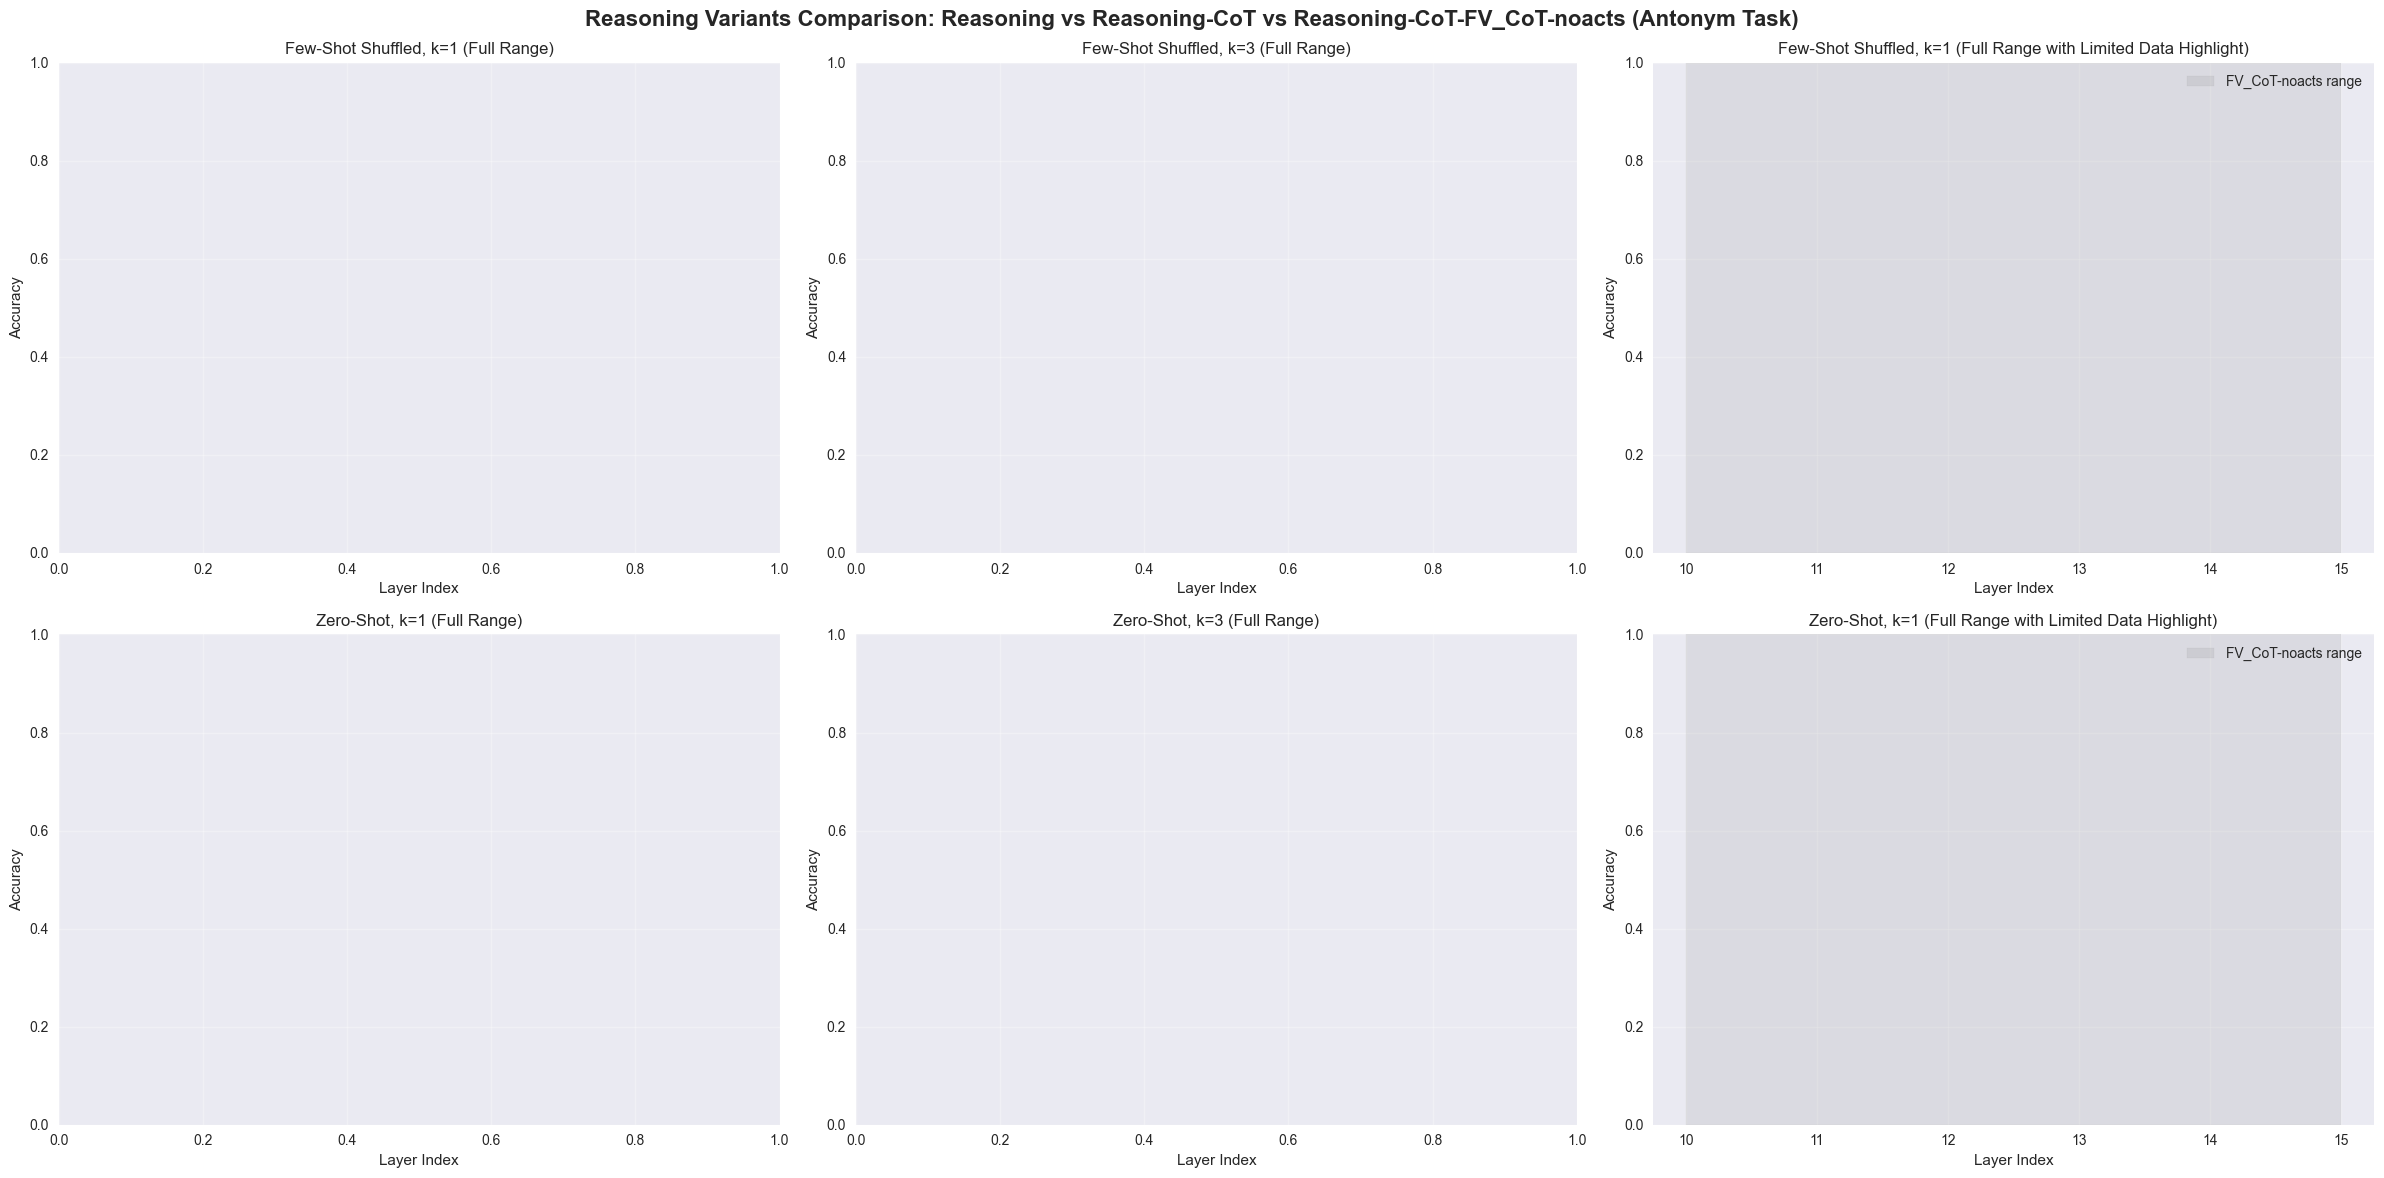


=== Statistical Summary for Common Range (Layers 10-15) ===

FS_SHUFFLED_RESULTS_LAYER_SWEEP Results:

  k=1:

  k=3:

ZS_RESULTS_LAYER_SWEEP Results:

  k=1:

  k=3:

=== Performance Ranking (Common Range, Layers 10-15) ===

FS_SHUFFLED_RESULTS_LAYER_SWEEP:
  k=1 ranking (by mean accuracy):
  k=3 ranking (by mean accuracy):

ZS_RESULTS_LAYER_SWEEP:
  k=1 ranking (by mean accuracy):
  k=3 ranking (by mean accuracy):

=== Updated Color Scheme Legend ===
🔵 Blue (solid, circle): reasoning baseline
🟢 Green (solid, square): reasoning-CoT
🟢 Green (dashed, triangle): reasoning-CoT-FV_CoT-noacts

Reasoning-CoT variants now share the same color (green) but use different line patterns and markers
Gray shaded region (10-15): indicates the limited range where reasoning-CoT-FV_CoT-noacts has data

Note: reasoning-CoT-FV_CoT-noacts is limited to layers 10-15 only (6 datapoints),
while reasoning and reasoning-CoT have full range data (0-31).


In [141]:
# Comprehensive visualization for reasoning variants comparison
print("=== Visualizing Reasoning Variants Comparison ===")

# Set up colors and markers for variants
triple_colors = {
    'reasoning': '#1f77b4',  # blue
    'reasoning-CoT': '#ff7f0e',  # orange
    'reasoning-CoT-FV_CoT-noacts': '#2ca02c'  # green
}

triple_markers = {
    'reasoning': 'o',
    'reasoning-CoT': 's', 
    'reasoning-CoT-FV_CoT-noacts': '^'
}

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Reasoning Variants Comparison: Reasoning vs Reasoning-CoT vs Reasoning-CoT-FV_CoT-noacts (Antonym Task)', fontsize=16, fontweight='bold')

conditions = ['fs_shuffled', 'zs']
k_values_to_plot = [1, 3]

for row_idx, file_type in enumerate(conditions):
    condition_name = 'Few-Shot Shuffled' if file_type == 'fs_shuffled' else 'Zero-Shot'
    
    for col_idx, k_val in enumerate(k_values_to_plot):
        ax = axes[row_idx, col_idx]
        
        # Plot 1: Common range (10-15) - all three variants
        common_data = common_range_triple[
            (common_range_triple['file_type'] == file_type) & 
            (common_range_triple['k'] == k_val)
        ]
        
        for variant in sorted(common_data['dataset'].unique()):
            variant_data = common_data[common_data['dataset'] == variant]
            if not variant_data.empty:
                ax.plot(variant_data['layer_index'], variant_data['accuracy'], 
                       marker=triple_markers[variant], color=triple_colors[variant], 
                       label=f'{variant}', linewidth=2, markersize=8, alpha=0.8)
        
        ax.set_xlabel('Layer Index')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{condition_name}, k={k_val} (Layers 10-15)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(9.5, 15.5)
    
    # Plot 3: Full range comparison (reasoning vs reasoning-CoT only)
    ax = axes[row_idx, 2]
    
    full_data = full_range_triple[
        (full_range_triple['file_type'] == file_type) & 
        (full_range_triple['k'] == 1)  # Use k=1 for clarity
    ]
    
    for variant in ['reasoning', 'reasoning-CoT']:
        variant_data = full_data[full_data['dataset'] == variant]
        if not variant_data.empty:
            ax.plot(variant_data['layer_index'], variant_data['accuracy'], 
                   marker=triple_markers[variant], color=triple_colors[variant], 
                   label=f'{variant}', linewidth=2, markersize=6, alpha=0.8)
    
    # Highlight the region where reasoning-CoT-FV_CoT-noacts has data
    ax.axvspan(10, 15, alpha=0.1, color='green', label='FV_CoT-noacts range')
    
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{condition_name}, k=1 (Full Range)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary for common range (10-15)
print("\n=== Statistical Summary for Common Range (Layers 10-15) ===")

reasoning_triple_stats = {}
for file_type in conditions:
    condition_data = common_range_triple[common_range_triple['file_type'] == file_type]
    
    print(f"\n{file_type.upper()} Results:")
    reasoning_triple_stats[file_type] = {}
    
    for k_val in [1, 3]:
        k_data = condition_data[condition_data['k'] == k_val]
        
        print(f"\n  k={k_val}:")
        for variant in sorted(k_data['dataset'].unique()):
            variant_data = k_data[k_data['dataset'] == variant]
            
            if not variant_data.empty:
                mean_acc = variant_data['accuracy'].mean()
                std_acc = variant_data['accuracy'].std()
                best_acc = variant_data['accuracy'].max()
                best_layer = variant_data.loc[variant_data['accuracy'].idxmax(), 'layer_index']
                
                reasoning_triple_stats[file_type][f'{variant}_k{k_val}'] = {
                    'mean': mean_acc,
                    'std': std_acc,
                    'best': best_acc,
                    'best_layer': best_layer
                }
                
                print(f"    {variant:25}: mean={mean_acc:.4f} ± {std_acc:.4f}, best={best_acc:.4f} (layer {best_layer})")

# Performance ranking for common range
print("\n=== Performance Ranking (Common Range, Layers 10-15) ===")

for file_type in conditions:
    print(f"\n{file_type.upper()}:")
    
    for k_val in [1, 3]:
        k_data = common_range_triple[
            (common_range_triple['file_type'] == file_type) & 
            (common_range_triple['k'] == k_val)
        ]
        
        variant_means = k_data.groupby('dataset')['accuracy'].mean().sort_values(ascending=False)
        
        print(f"  k={k_val} ranking (by mean accuracy):")
        for rank, (variant, mean_acc) in enumerate(variant_means.items(), 1):
            print(f"    {rank}. {variant}: {mean_acc:.4f}")

print("\nNote: reasoning-CoT-FV_CoT-noacts is limited to layers 10-15 only, while reasoning and reasoning-CoT have full range data (0-31).")